In [3]:
import os
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

In [4]:
music_genre_df = pd.read_csv("./music_genre_dataset.csv")

In [5]:
music_genre_df.head()

,centroid_mean,centroid_var,flux_mean,flux_var,rmse_mean,rmse_var,zcr_mean,zcr_var,contrast_mean,contrast_var,bandwidth_mean,bandwidth_var,flatness_mean,flatness_var,rolloff_mean,rolloff_var,mfcc_0_mean,mfcc_0_var,mfcc_1_mean,mfcc_1_var,mfcc_2_mean,mfcc_2_var,mfcc_3_mean,mfcc_3_var,mfcc_4_mean,mfcc_4_var,mfcc_5_mean,mfcc_5_var,mfcc_6_mean,mfcc_6_var,mfcc_7_mean,mfcc_7_var,mfcc_8_mean,mfcc_8_var,mfcc_9_mean,mfcc_9_var,mfcc_10_mean,mfcc_10_var,mfcc_11_mean,mfcc_11_var,mfcc_12_mean,mfcc_12_var,mfcc_13_mean,mfcc_13_var,mfcc_14_mean,mfcc_14_var,mfcc_15_mean,mfcc_15_var,mfcc_16_mean,mfcc_16_var,mfcc_17_mean,mfcc_17_var,mfcc_18_mean,mfcc_18_var,mfcc_19_mean,mfcc_19_var,tempo,label
0,3021.811793,8.631304e+05,1.545816,3.117694,0.211423,0.010099,0.127584,0.006086,18.501843,27.428413,3189.870264,150665.735440,0.055833,0.004369,7063.990618,3.379500e+06,-119.86384,3687.2175,71.17552,851.41290,13.874226,421.68090,8.972058,350.18750,13.293087,214.513140,8.356418,279.93020,11.714785,131.82400,0.227281,145.595000,10.098030,122.523800,3.187911,99.151720,4.057414,90.11531,-0.685949,78.795900,2.287951,96.736300,1.256292,108.062690,0.370943,126.18351,0.928776,120.674620,-1.613910,143.558850,3.805791,115.306240,4.630133,133.443330,4.249058,101.62490,112.347147,pop
1,3085.006429,9.371006e+05,1.696643,5.940423,0.192062,0.007828,0.141565,0.008426,17.610315,22.312666,3090.450154,143447.447139,0.072240,0.005155,6789.242280,2.920629e+06,-122.55636,4848.0156,67.31175,673.43410,14.497663,474.70140,15.167653,279.70547,7.731995,127.412796,4.679402,208.48330,7.360309,164.52353,3.619839,103.617165,8.258433,90.735920,4.730642,88.707306,3.671531,65.11533,3.122653,72.954834,4.398380,74.025960,2.423539,69.836240,2.386121,50.95205,-1.874956,52.759857,-0.676365,63.388060,-2.156180,91.401480,0.030505,87.559746,-1.906010,74.80400,103.359375,pop
2,3457.594928,1.001249e+06,1.623039,3.208166,0.256556,0.010939,0.161847,0.009069,17.705096,18.575089,3243.495962,148126.110925,0.087670,0.007243,7567.970904,2.365424e+06,-82.17037,3259.0627,59.28512,650.01770,22.729408,449.65594,12.442951,197.13376,8.209612,125.205730,5.467887,141.16423,10.697671,112.89577,6.067032,83.102800,0.910484,84.206860,5.528702,108.048820,-3.052664,92.72851,1.288742,70.796680,-1.568182,80.392685,-2.311807,64.859350,-2.224531,69.97291,-2.837123,65.517400,1.842081,69.941505,0.188256,70.616425,5.599402,91.032140,3.397985,92.23541,129.199219,pop
3,3021.211890,8.523383e+05,1.537019,3.058556,0.211496,0.010140,0.127349,0.006048,18.459025,27.132925,3189.247738,150479.767164,0.056228,0.004442,7066.523936,3.350110e+06,-119.85001,3692.9492,71.06872,857.59595,13.751196,415.16843,8.937724,349.84937,13.223387,215.723390,8.351688,284.85250,11.711052,132.47714,0.324510,147.473370,10.111516,125.120476,3.169137,97.827156,4.093327,90.42442,-0.636420,79.777520,2.230354,99.233055,1.176658,108.697586,0.368661,127.54189,0.951088,122.483284,-1.572587,145.711260,3.721722,117.326640,4.528792,133.399640,4.209765,102.53113,112.347147,pop
4,3326.073441,1.023269e+06,1.591738,6.355816,0.143018,0.011478,0.153413,0.008803,17.722443,20.351157,3167.911705,142185.510620,0.092992,0.009749,7219.589677,3.089231e+06,-171.58084,6459.8560,54.80697,681.24700,21.073519,433.97842,21.969357,316.14615,6.152843,167.911910,3.523801,206.10190,5.637858,164.67526,0.887712,166.909410,7.537427,134.367250,1.784371,92.375760,-2.610014,122.04566,-0.568933,108.244560,-1.194805,71.059456,-3.453007,72.763336,-2.395295,56.35854,-3.470941,59.921790,-2.460337,67.173730,-2.671494,63.750680,-2.705463,71.296684,0.360533,75.18217,112.347147,pop


In [6]:
music_genre_df.describe()

,centroid_mean,centroid_var,flux_mean,flux_var,rmse_mean,rmse_var,zcr_mean,zcr_var,contrast_mean,contrast_var,bandwidth_mean,bandwidth_var,flatness_mean,flatness_var,rolloff_mean,rolloff_var,mfcc_0_mean,mfcc_0_var,mfcc_1_mean,mfcc_1_var,mfcc_2_mean,mfcc_2_var,mfcc_3_mean,mfcc_3_var,mfcc_4_mean,mfcc_4_var,mfcc_5_mean,mfcc_5_var,mfcc_6_mean,mfcc_6_var,mfcc_7_mean,mfcc_7_var,mfcc_8_mean,mfcc_8_var,mfcc_9_mean,mfcc_9_var,mfcc_10_mean,mfcc_10_var,mfcc_11_mean,mfcc_11_var,mfcc_12_mean,mfcc_12_var,mfcc_13_mean,mfcc_13_var,mfcc_14_mean,mfcc_14_var,mfcc_15_mean,mfcc_15_var,mfcc_16_mean,mfcc_16_var,mfcc_17_mean,mfcc_17_var,mfcc_18_mean,mfcc_18_var,mfcc_19_mean,mfcc_19_var,tempo
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2099.964801,5.021998e+05,1.417983,2.877162,0.128748,0.003756,0.103627,0.003660,20.516475,50.318742,2185.832699,152547.585023,0.021807,1.519611e-03,4357.826807,2.029114e+06,-216.735298,3978.581787,103.236958,781.362743,-6.884211,504.226204,36.676549,242.131271,-0.822800,195.475427,14.524088,147.423713,-4.765452,133.674448,10.145186,105.016245,-6.462103,104.865355,7.914106,97.875265,-5.558173,91.112445,4.564364,83.986687,-4.398968,82.908961,2.026286,79.609489,-3.265956,77.648204,1.385172,75.302923,-3.627671,77.009908,0.729167,77.672620,-1.737474,80.448358,-0.720864,85.057652,120.999343
std,697.916610,4.390502e+05,0.340466,2.468793,0.064554,0.004443,0.041830,0.003715,2.181666,30.034734,528.594230,105060.198549,0.027880,4.239033e-03,1553.506323,1.569855e+06,98.040271,2891.863036,32.509609,472.393775,21.983699,300.579573,16.766314,124.430577,12.217688,108.149918,11.902577,75.048185,9.913539,63.119148,10.480087,45.001782,8.222212,43.227208,7.864826,40.739832,6.775931,42.420284,6.640471,36.774524,6.103203,37.814581,4.949000,38.981838,4.792690,39.251668,4.536473,39.817498,4.452308,38.602032,3.848512,39.100615,3.686273,42.817515,3.773666,53.257501,20.846512
min,533.990817,5.460424e+03,0.608903,0.027173,0.005260,0.000005,0.021693,0.000049,13.494408,10.204586,865.121557,14509.121787,0.000106,2.725537e-08,730.428917,1.559351e+04,-617.717960,184.942230,-3.042056,112.524320,-89.180230,48.456528,-17.209368,43.076595,-39.231346,39.819664,-28.378271,33.576305,-33.718570,39.505490,-25.152695,32.072010,-31.110357,36.907524,-12.296315,28.518957,-26.291992,32.521084,-16.023209,31.374617,-27.010887,27.783741,-12.298429,28.218786,-16.333420,15.020319,-14.290755,21.217950,-14.735099,20.130058,-12.219226,24.370277,-16.421915,24.816822,-17.275084,12.065102,69.837416
25%,1521.250102,1.936289e+05,1.162518,1.159416,0.085024,0.001184,0.070266,0.001279,18.783784,23.212516,1830.284135,74705.361934,0.003243,2.881899e-05,3130.851902,8.451849e+05,-272.159980,1997.588650,79.294870,443.406180,-22.135641,295.698760,24.429870,144.947115,-9.474430,117.579920,5.019131,92.781228,-12.602620,87.511302,2.006607,72.154400,-12.636358,72.113414,1.851733,68.937885,-10.485117,63.512406,-0.495134,59.536627,-8.945842,58.447362,-1.207504,55.820201,-6.662237,53.855017,-1.600580,52.373285,-6.669815,52.550694,-1.760604,53.071734,-4.121029,52.750205,-3.044734,54.028483,103.359375
50%,2109.168514,3.604953e+05,1.365104,2.101702,0.119893,0.002318,0.099520,0.002445,20.588925,39.822797,2178.848169,129439.425617,0.010495,1.605074e-04,4477.764590,1.615646e+06,-192.328830,3357.354850,101.701390,681.159875,-9.144243,438.786530,36.951996,219.73

In [7]:
music_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 58 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   centroid_mean   1000 non-null   float64
 1   centroid_var    1000 non-null   float64
 2   flux_mean       1000 non-null   float64
 3   flux_var        1000 non-null   float64
 4   rmse_mean       1000 non-null   float64
 5   rmse_var        1000 non-null   float64
 6   zcr_mean        1000 non-null   float64
 7   zcr_var         1000 non-null   float64
 8   contrast_mean   1000 non-null   float64
 9   contrast_var    1000 non-null   float64
 10  bandwidth_mean  1000 non-null   float64
 11  bandwidth_var   1000 non-null   float64
 12  flatness_mean   1000 non-null   float64
 13  flatness_var    1000 non-null   float64
 14  rolloff_mean    1000 non-null   float64
 15  rolloff_var     1000 non-null   float64
 16  mfcc_0_mean     1000 non-null   float64
 17  mfcc_0_var      1000 non-null   fl

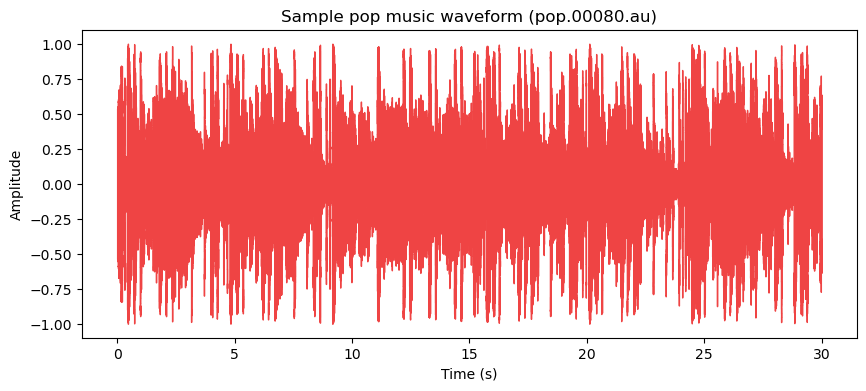

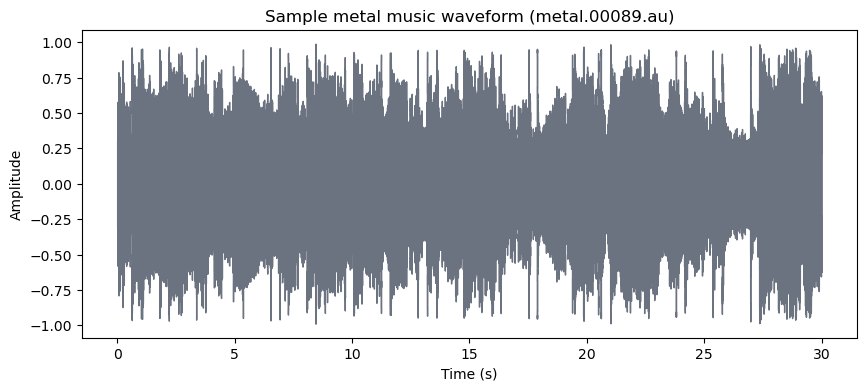

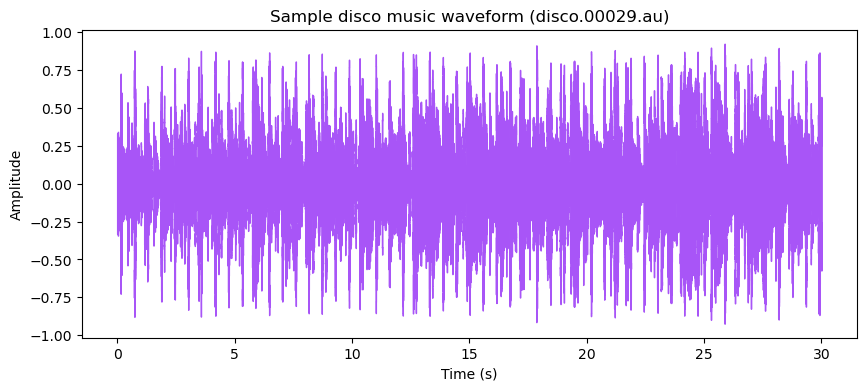

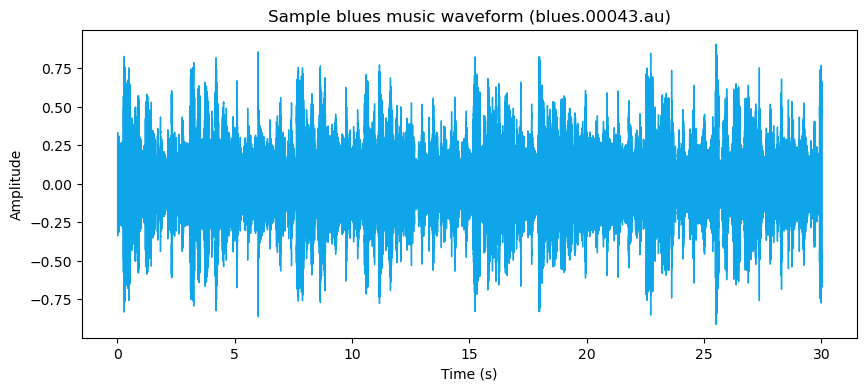

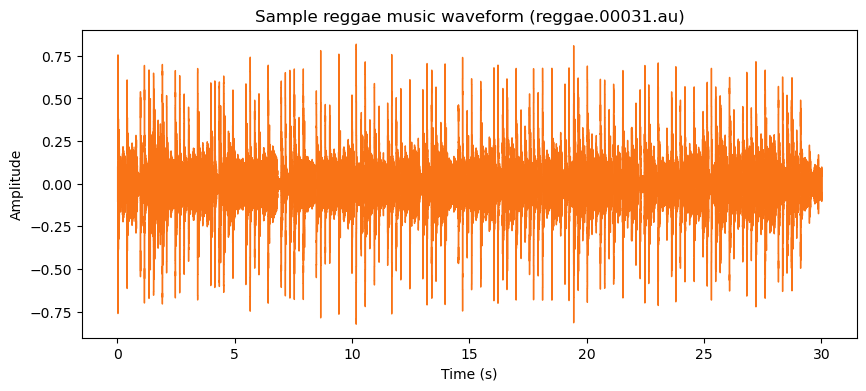

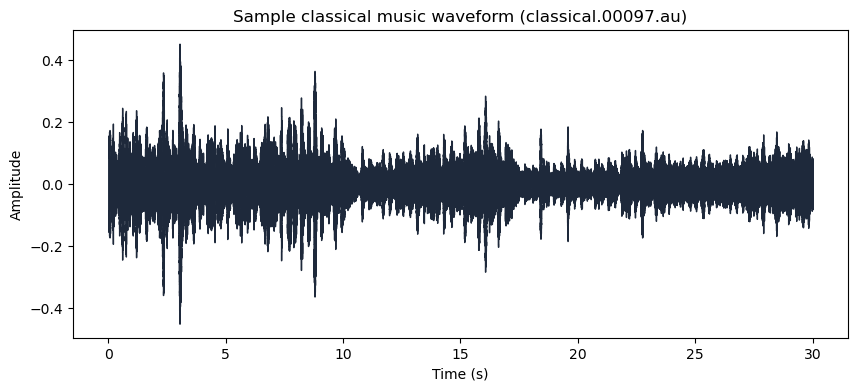

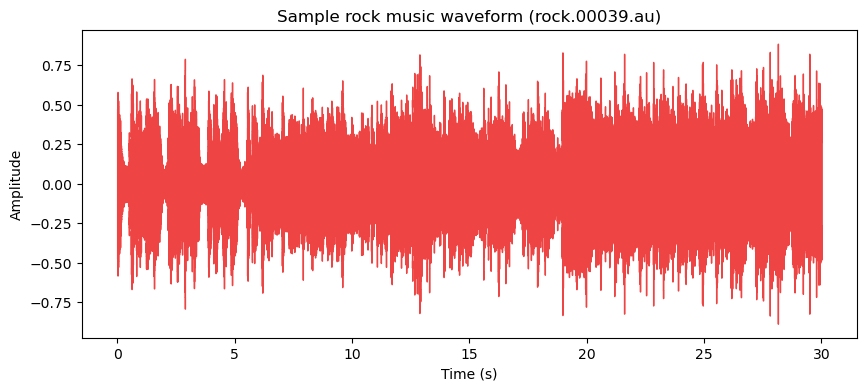

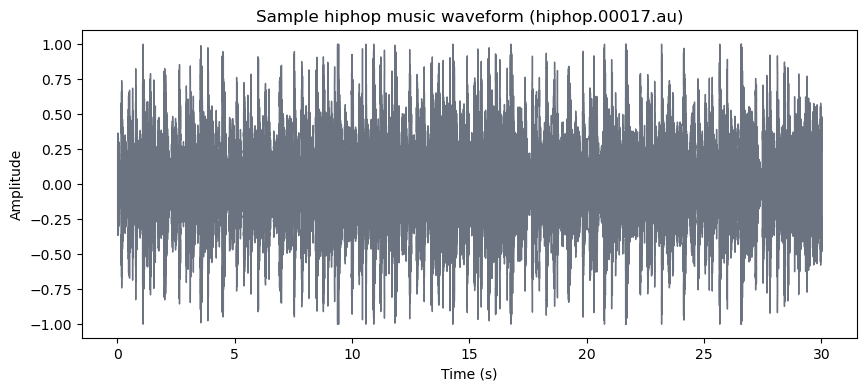

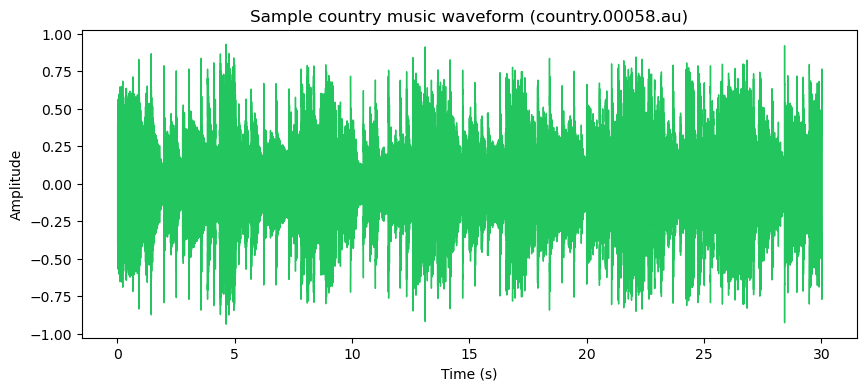

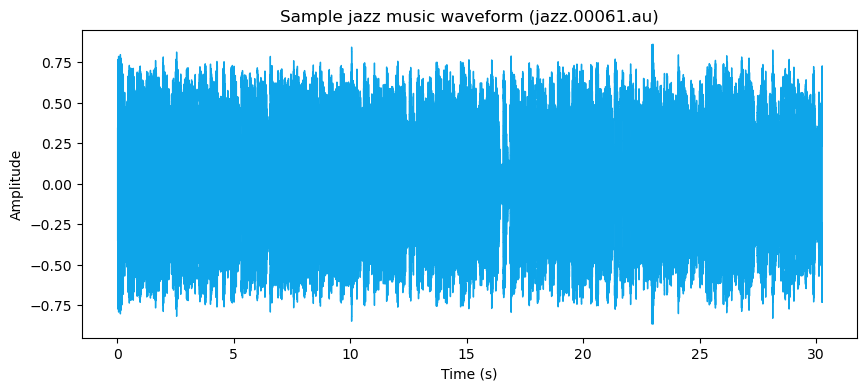

In [7]:
base_path = "./music_genres"

genres = {
    "pop": "#ef4444",
    "metal": "#6b7280",
    "disco": "#a855f7",
    "blues": "#0ea5e9",
    "reggae": "#f97316",
    "classical": "#1e293b",
    "rock": "#ef4444",
    "hiphop": "#6b7280",
    "country": "#22c55e",
    "jazz": "#0ea5e9"
}

for i, (genre, genre_color) in enumerate(genres.items()):    
    genre_path = os.path.join(base_path, genre)
        
    if not os.path.isdir(genre_path):
        continue
        
    sample_file_name = os.listdir(genre_path)[0]
    sample_file_path = os.path.join(genre_path, sample_file_name)
    
    audio, sr = librosa.load(sample_file_path)
    
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr, color=genre_color)
    plt.title("Sample {genre} music waveform ({file_name})".format(genre=genre, file_name=sample_file_name))
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

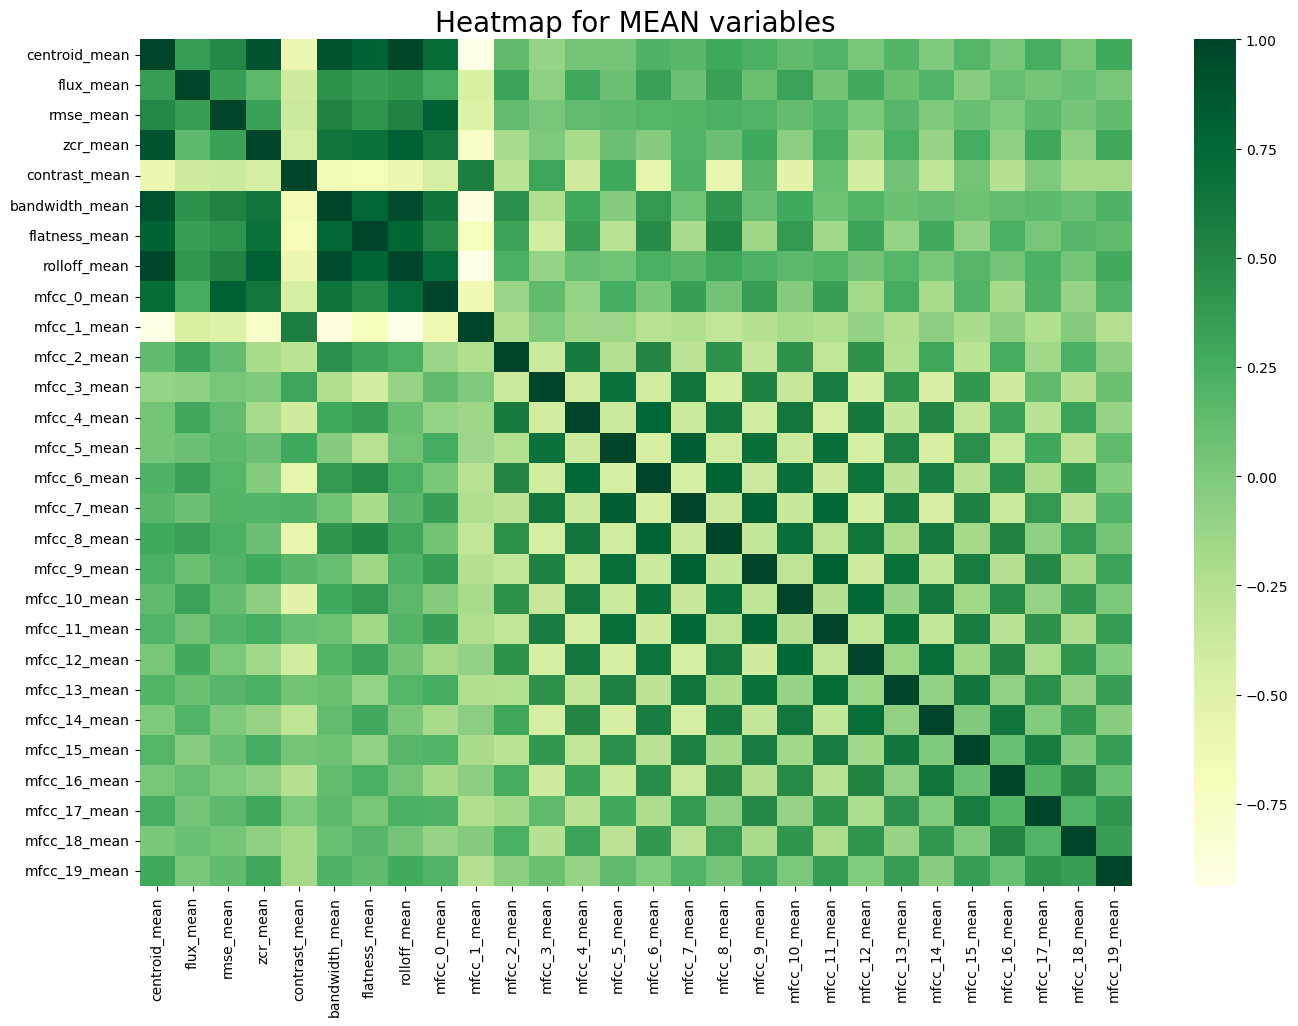

In [8]:
mean_columns = [col for col in music_genre_df.columns if 'mean' in col]

plt.figure(figsize=(16, 11))
sns.heatmap(music_genre_df[mean_columns].corr(), cmap="YlGn")
plt.title('Heatmap for MEAN variables', fontsize = 20) 
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

In [65]:
X = music_genre_df.drop(["label"], axis=1)
y = music_genre_df["label"]

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

encoder = preprocessing.LabelEncoder() 
y = encoder.fit_transform(y)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [33]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import pickle

In [12]:
models = {
    "RandomForestClassifier": {
        "clf": RandomForestClassifier(),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "KNeighborsClassifier": {
        "clf": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
            "p": [1, 2]
        }
    },
    "MLPClassifier": {
        "clf": MLPClassifier(max_iter=1000),
        "param_grid": {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "alpha": [0.0001, 0.001, 0.01],
            "learning_rate": ["constant", "invscaling", "adaptive"]
        }
    },
    "CatBoostClassifier": {
        "clf": CatBoostClassifier(),
        "param_grid": {
            "iterations": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "depth": [4, 6, 8],
            "l2_leaf_reg": [1, 3, 5]
        }
    },
    "XGBClassifier": {
        "clf": XGBClassifier(),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.8, 0.9, 1.0]
        }
    },
    "SVC": {
        "clf": SVC(),
        "param_grid": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf", "poly"],
            "degree": [2, 3, 4],
            "gamma": ["scale", "auto"]
        }
    }
}

In [13]:
model_scores = []

for model_name, model in models.items():
    model_selection = GridSearchCV(model["clf"], model["param_grid"], cv=5, return_train_score=False)
    model_selection.fit(X_train, y_train)
    model_scores.append({
        "model": model_name,
        "best_score": model_selection.best_score_,
        "best_params": model_selection.best_params_
    })

/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ochirjavjargalsaikhan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

0:	learn: 2.2896111	total: 86.6ms	remaining: 4.25s
1:	learn: 2.2761128	total: 109ms	remaining: 2.62s
2:	learn: 2.2661554	total: 127ms	remaining: 1.99s
3:	learn: 2.2544517	total: 149ms	remaining: 1.72s
4:	learn: 2.2439384	total: 170ms	remaining: 1.53s
5:	learn: 2.2331800	total: 197ms	remaining: 1.44s
6:	learn: 2.2244384	total: 215ms	remaining: 1.32s
7:	learn: 2.2115139	total: 220ms	remaining: 1.15s
8:	learn: 2.2006672	total: 225ms	remaining: 1.02s
9:	learn: 2.1908249	total: 230ms	remaining: 919ms
10:	learn: 2.1783350	total: 235ms	remaining: 832ms
11:	learn: 2.1671297	total: 240ms	remaining: 760ms
12:	learn: 2.1551963	total: 245ms	remaining: 698ms
13:	learn: 2.1415288	total: 250ms	remaining: 644ms
14:	learn: 2.1303542	total: 255ms	remaining: 596ms
15:	learn: 2.1207546	total: 260ms	remaining: 553ms
16:	learn: 2.1113310	total: 265ms	remaining: 515ms
17:	learn: 2.1041547	total: 270ms	remaining: 481ms
18:	learn: 2.0939507	total: 276ms	remaining: 450ms
19:	learn: 2.0829752	total: 281ms	remain

14:	learn: 2.1435927	total: 80.9ms	remaining: 189ms
15:	learn: 2.1333697	total: 86.5ms	remaining: 184ms
16:	learn: 2.1245748	total: 91.8ms	remaining: 178ms
17:	learn: 2.1149282	total: 97ms	remaining: 172ms
18:	learn: 2.1084651	total: 102ms	remaining: 167ms
19:	learn: 2.0978098	total: 108ms	remaining: 161ms
20:	learn: 2.0892956	total: 113ms	remaining: 156ms
21:	learn: 2.0801284	total: 118ms	remaining: 151ms
22:	learn: 2.0708493	total: 124ms	remaining: 145ms
23:	learn: 2.0604004	total: 129ms	remaining: 140ms
24:	learn: 2.0502535	total: 134ms	remaining: 134ms
25:	learn: 2.0428021	total: 140ms	remaining: 129ms
26:	learn: 2.0340095	total: 145ms	remaining: 124ms
27:	learn: 2.0258129	total: 151ms	remaining: 118ms
28:	learn: 2.0171382	total: 156ms	remaining: 113ms
29:	learn: 2.0106210	total: 161ms	remaining: 107ms
30:	learn: 2.0005849	total: 167ms	remaining: 102ms
31:	learn: 1.9920560	total: 172ms	remaining: 96.7ms
32:	learn: 1.9843675	total: 177ms	remaining: 91.3ms
33:	learn: 1.9768266	total:

46:	learn: 0.8230470	total: 252ms	remaining: 16.1ms
47:	learn: 0.8116439	total: 257ms	remaining: 10.7ms
48:	learn: 0.8047767	total: 263ms	remaining: 5.36ms
49:	learn: 0.7936236	total: 268ms	remaining: 0us
0:	learn: 2.1569706	total: 7.22ms	remaining: 354ms
1:	learn: 2.0501212	total: 12.2ms	remaining: 293ms
2:	learn: 1.9639134	total: 17.8ms	remaining: 279ms
3:	learn: 1.9071084	total: 23.2ms	remaining: 267ms
4:	learn: 1.8544540	total: 28.5ms	remaining: 256ms
5:	learn: 1.7938936	total: 33.6ms	remaining: 246ms
6:	learn: 1.7460888	total: 38.9ms	remaining: 239ms
7:	learn: 1.6875420	total: 44.1ms	remaining: 232ms
8:	learn: 1.6231602	total: 49.3ms	remaining: 225ms
9:	learn: 1.5876878	total: 54.5ms	remaining: 218ms
10:	learn: 1.5423137	total: 59.7ms	remaining: 212ms
11:	learn: 1.5067011	total: 64.9ms	remaining: 205ms
12:	learn: 1.4661261	total: 70.1ms	remaining: 200ms
13:	learn: 1.4287139	total: 75.3ms	remaining: 194ms
14:	learn: 1.3980369	total: 80.6ms	remaining: 188ms
15:	learn: 1.3708477	tota

24:	learn: 0.8497958	total: 133ms	remaining: 133ms
25:	learn: 0.8325721	total: 138ms	remaining: 128ms
26:	learn: 0.8168611	total: 144ms	remaining: 122ms
27:	learn: 0.7907773	total: 149ms	remaining: 117ms
28:	learn: 0.7754480	total: 154ms	remaining: 112ms
29:	learn: 0.7581600	total: 159ms	remaining: 106ms
30:	learn: 0.7435022	total: 165ms	remaining: 101ms
31:	learn: 0.7376446	total: 170ms	remaining: 95.7ms
32:	learn: 0.7262180	total: 175ms	remaining: 90.3ms
33:	learn: 0.7119378	total: 181ms	remaining: 85ms
34:	learn: 0.7038233	total: 186ms	remaining: 79.7ms
35:	learn: 0.6889418	total: 192ms	remaining: 74.5ms
36:	learn: 0.6732950	total: 197ms	remaining: 69.2ms
37:	learn: 0.6547165	total: 202ms	remaining: 63.9ms
38:	learn: 0.6387796	total: 208ms	remaining: 58.6ms
39:	learn: 0.6290577	total: 213ms	remaining: 53.3ms
40:	learn: 0.6146617	total: 218ms	remaining: 47.9ms
41:	learn: 0.5993121	total: 224ms	remaining: 42.6ms
42:	learn: 0.5930059	total: 229ms	remaining: 37.3ms
43:	learn: 0.5834604	

2:	learn: 1.7951415	total: 17.4ms	remaining: 273ms
3:	learn: 1.7096616	total: 22.9ms	remaining: 263ms
4:	learn: 1.6232635	total: 28.2ms	remaining: 254ms
5:	learn: 1.5145717	total: 33.4ms	remaining: 245ms
6:	learn: 1.4436917	total: 38.9ms	remaining: 239ms
7:	learn: 1.3799805	total: 44.3ms	remaining: 233ms
8:	learn: 1.3169397	total: 49.5ms	remaining: 226ms
9:	learn: 1.2782550	total: 54.6ms	remaining: 218ms
10:	learn: 1.2129264	total: 60.1ms	remaining: 213ms
11:	learn: 1.1761091	total: 65.3ms	remaining: 207ms
12:	learn: 1.1364093	total: 70.3ms	remaining: 200ms
13:	learn: 1.0813538	total: 75.6ms	remaining: 194ms
14:	learn: 1.0502610	total: 81.5ms	remaining: 190ms
15:	learn: 1.0223352	total: 86.8ms	remaining: 184ms
16:	learn: 0.9953294	total: 92.5ms	remaining: 179ms
17:	learn: 0.9638368	total: 98ms	remaining: 174ms
18:	learn: 0.9391662	total: 104ms	remaining: 169ms
19:	learn: 0.9118779	total: 109ms	remaining: 163ms
20:	learn: 0.8954055	total: 114ms	remaining: 157ms
21:	learn: 0.8719103	tota

32:	learn: 2.0347448	total: 176ms	remaining: 90.5ms
33:	learn: 2.0291956	total: 181ms	remaining: 85.2ms
34:	learn: 2.0223688	total: 187ms	remaining: 80.1ms
35:	learn: 2.0152524	total: 192ms	remaining: 74.7ms
36:	learn: 2.0074177	total: 197ms	remaining: 69.4ms
37:	learn: 1.9988566	total: 203ms	remaining: 64ms
38:	learn: 1.9924725	total: 208ms	remaining: 58.6ms
39:	learn: 1.9855057	total: 213ms	remaining: 53.2ms
40:	learn: 1.9783075	total: 218ms	remaining: 47.9ms
41:	learn: 1.9727356	total: 223ms	remaining: 42.6ms
42:	learn: 1.9653537	total: 229ms	remaining: 37.2ms
43:	learn: 1.9596845	total: 234ms	remaining: 31.9ms
44:	learn: 1.9535247	total: 240ms	remaining: 26.6ms
45:	learn: 1.9473095	total: 245ms	remaining: 21.3ms
46:	learn: 1.9401170	total: 250ms	remaining: 16ms
47:	learn: 1.9337998	total: 256ms	remaining: 10.7ms
48:	learn: 1.9276659	total: 261ms	remaining: 5.33ms
49:	learn: 1.9209074	total: 267ms	remaining: 0us
0:	learn: 2.2922104	total: 7.16ms	remaining: 351ms
1:	learn: 2.2846405	

8:	learn: 1.7453968	total: 49.6ms	remaining: 226ms
9:	learn: 1.7086549	total: 54.8ms	remaining: 219ms
10:	learn: 1.6629488	total: 60ms	remaining: 213ms
11:	learn: 1.6315560	total: 65.2ms	remaining: 206ms
12:	learn: 1.5904638	total: 70.7ms	remaining: 201ms
13:	learn: 1.5454694	total: 76ms	remaining: 196ms
14:	learn: 1.5147751	total: 81.6ms	remaining: 190ms
15:	learn: 1.4818506	total: 86.7ms	remaining: 184ms
16:	learn: 1.4517625	total: 91.9ms	remaining: 178ms
17:	learn: 1.4179154	total: 97.1ms	remaining: 173ms
18:	learn: 1.3962088	total: 102ms	remaining: 167ms
19:	learn: 1.3655603	total: 107ms	remaining: 161ms
20:	learn: 1.3437207	total: 113ms	remaining: 156ms
21:	learn: 1.3244894	total: 118ms	remaining: 151ms
22:	learn: 1.3036789	total: 124ms	remaining: 145ms
23:	learn: 1.2797213	total: 129ms	remaining: 140ms
24:	learn: 1.2595492	total: 135ms	remaining: 135ms
25:	learn: 1.2384841	total: 140ms	remaining: 129ms
26:	learn: 1.2239623	total: 145ms	remaining: 124ms
27:	learn: 1.2050272	total:

37:	learn: 1.1053809	total: 207ms	remaining: 65.4ms
38:	learn: 1.0936457	total: 213ms	remaining: 60.1ms
39:	learn: 1.0823519	total: 219ms	remaining: 54.7ms
40:	learn: 1.0682885	total: 225ms	remaining: 49.3ms
41:	learn: 1.0539275	total: 230ms	remaining: 43.8ms
42:	learn: 1.0417827	total: 236ms	remaining: 38.4ms
43:	learn: 1.0293871	total: 241ms	remaining: 32.8ms
44:	learn: 1.0194604	total: 246ms	remaining: 27.4ms
45:	learn: 1.0138680	total: 251ms	remaining: 21.9ms
46:	learn: 1.0026433	total: 256ms	remaining: 16.4ms
47:	learn: 0.9906592	total: 262ms	remaining: 10.9ms
48:	learn: 0.9837716	total: 267ms	remaining: 5.46ms
49:	learn: 0.9723175	total: 273ms	remaining: 0us
0:	learn: 2.1196651	total: 6.81ms	remaining: 334ms
1:	learn: 1.9741612	total: 12.1ms	remaining: 292ms
2:	learn: 1.8667302	total: 17.3ms	remaining: 272ms
3:	learn: 1.7984643	total: 22.5ms	remaining: 259ms
4:	learn: 1.7162962	total: 27.8ms	remaining: 250ms
5:	learn: 1.6499436	total: 33ms	remaining: 242ms
6:	learn: 1.5858509	tot

15:	learn: 1.2394823	total: 86.4ms	remaining: 184ms
16:	learn: 1.2195109	total: 91.8ms	remaining: 178ms
17:	learn: 1.1820984	total: 97.2ms	remaining: 173ms
18:	learn: 1.1538940	total: 103ms	remaining: 167ms
19:	learn: 1.1232393	total: 108ms	remaining: 162ms
20:	learn: 1.0968023	total: 113ms	remaining: 156ms
21:	learn: 1.0706066	total: 119ms	remaining: 151ms
22:	learn: 1.0453479	total: 125ms	remaining: 146ms
23:	learn: 1.0171185	total: 130ms	remaining: 141ms
24:	learn: 0.9959825	total: 136ms	remaining: 136ms
25:	learn: 0.9750203	total: 141ms	remaining: 130ms
26:	learn: 0.9580924	total: 146ms	remaining: 125ms
27:	learn: 0.9366325	total: 152ms	remaining: 119ms
28:	learn: 0.9184078	total: 157ms	remaining: 113ms
29:	learn: 0.8981752	total: 162ms	remaining: 108ms
30:	learn: 0.8776633	total: 167ms	remaining: 103ms
31:	learn: 0.8647074	total: 172ms	remaining: 97ms
32:	learn: 0.8487494	total: 178ms	remaining: 91.5ms
33:	learn: 0.8356000	total: 183ms	remaining: 86ms
34:	learn: 0.8250433	total: 1

41:	learn: 2.0153596	total: 224ms	remaining: 42.7ms
42:	learn: 2.0100020	total: 230ms	remaining: 37.4ms
43:	learn: 2.0056154	total: 235ms	remaining: 32ms
44:	learn: 1.9991508	total: 240ms	remaining: 26.7ms
45:	learn: 1.9939108	total: 246ms	remaining: 21.4ms
46:	learn: 1.9876411	total: 251ms	remaining: 16ms
47:	learn: 1.9813189	total: 256ms	remaining: 10.7ms
48:	learn: 1.9763250	total: 262ms	remaining: 5.34ms
49:	learn: 1.9711365	total: 267ms	remaining: 0us
0:	learn: 2.2931070	total: 7.17ms	remaining: 351ms
1:	learn: 2.2845111	total: 12.5ms	remaining: 300ms
2:	learn: 2.2771774	total: 17.7ms	remaining: 277ms
3:	learn: 2.2711916	total: 23.1ms	remaining: 265ms
4:	learn: 2.2642578	total: 28.2ms	remaining: 253ms
5:	learn: 2.2579141	total: 33.8ms	remaining: 248ms
6:	learn: 2.2510335	total: 38.7ms	remaining: 238ms
7:	learn: 2.2433783	total: 44.4ms	remaining: 233ms
8:	learn: 2.2346797	total: 49.3ms	remaining: 225ms
9:	learn: 2.2297278	total: 54.6ms	remaining: 218ms
10:	learn: 2.2217476	total: 5

18:	learn: 1.5149022	total: 101ms	remaining: 165ms
19:	learn: 1.4882587	total: 107ms	remaining: 160ms
20:	learn: 1.4679625	total: 112ms	remaining: 155ms
21:	learn: 1.4507071	total: 117ms	remaining: 149ms
22:	learn: 1.4298086	total: 123ms	remaining: 144ms
23:	learn: 1.4069251	total: 128ms	remaining: 139ms
24:	learn: 1.3873993	total: 133ms	remaining: 133ms
25:	learn: 1.3683248	total: 139ms	remaining: 128ms
26:	learn: 1.3528931	total: 144ms	remaining: 123ms
27:	learn: 1.3308024	total: 150ms	remaining: 118ms
28:	learn: 1.3120979	total: 155ms	remaining: 112ms
29:	learn: 1.2944921	total: 160ms	remaining: 107ms
30:	learn: 1.2760320	total: 165ms	remaining: 101ms
31:	learn: 1.2604840	total: 171ms	remaining: 96.1ms
32:	learn: 1.2482261	total: 176ms	remaining: 90.8ms
33:	learn: 1.2376612	total: 182ms	remaining: 85.5ms
34:	learn: 1.2209278	total: 187ms	remaining: 80.1ms
35:	learn: 1.2089298	total: 192ms	remaining: 74.7ms
36:	learn: 1.1973818	total: 197ms	remaining: 69.3ms
37:	learn: 1.1861876	tota

48:	learn: 1.0800669	total: 266ms	remaining: 5.42ms
49:	learn: 1.0672145	total: 271ms	remaining: 0us
0:	learn: 2.2150918	total: 6.82ms	remaining: 334ms
1:	learn: 2.1434170	total: 12.2ms	remaining: 293ms
2:	learn: 2.0718610	total: 17.3ms	remaining: 270ms
3:	learn: 2.0300869	total: 22.5ms	remaining: 259ms
4:	learn: 1.9824778	total: 27.8ms	remaining: 250ms
5:	learn: 1.9279183	total: 33.1ms	remaining: 243ms
6:	learn: 1.8901379	total: 38.5ms	remaining: 237ms
7:	learn: 1.8519987	total: 44ms	remaining: 231ms
8:	learn: 1.8083117	total: 48.9ms	remaining: 223ms
9:	learn: 1.7793802	total: 54.3ms	remaining: 217ms
10:	learn: 1.7352798	total: 59.5ms	remaining: 211ms
11:	learn: 1.6951936	total: 64.9ms	remaining: 205ms
12:	learn: 1.6562281	total: 70.2ms	remaining: 200ms
13:	learn: 1.6321104	total: 75.5ms	remaining: 194ms
14:	learn: 1.6026963	total: 80.6ms	remaining: 188ms
15:	learn: 1.5792872	total: 85.8ms	remaining: 182ms
16:	learn: 1.5535007	total: 91.2ms	remaining: 177ms
17:	learn: 1.5310403	total:

24:	learn: 1.0780391	total: 137ms	remaining: 137ms
25:	learn: 1.0601880	total: 143ms	remaining: 132ms
26:	learn: 1.0444030	total: 148ms	remaining: 126ms
27:	learn: 1.0251177	total: 153ms	remaining: 120ms
28:	learn: 1.0058262	total: 159ms	remaining: 115ms
29:	learn: 0.9908676	total: 164ms	remaining: 109ms
30:	learn: 0.9737175	total: 169ms	remaining: 104ms
31:	learn: 0.9610950	total: 174ms	remaining: 98ms
32:	learn: 0.9449954	total: 179ms	remaining: 92.5ms
33:	learn: 0.9359239	total: 185ms	remaining: 87.1ms
34:	learn: 0.9198440	total: 191ms	remaining: 81.6ms
35:	learn: 0.9091541	total: 196ms	remaining: 76.1ms
36:	learn: 0.8959817	total: 201ms	remaining: 70.7ms
37:	learn: 0.8911564	total: 206ms	remaining: 65.2ms
38:	learn: 0.8813286	total: 211ms	remaining: 59.6ms
39:	learn: 0.8682862	total: 217ms	remaining: 54.2ms
40:	learn: 0.8555307	total: 222ms	remaining: 48.7ms
41:	learn: 0.8425209	total: 227ms	remaining: 43.3ms
42:	learn: 0.8280531	total: 232ms	remaining: 37.8ms
43:	learn: 0.8198864	

55:	learn: 1.8039673	total: 302ms	remaining: 237ms
56:	learn: 1.7972795	total: 307ms	remaining: 232ms
57:	learn: 1.7908504	total: 313ms	remaining: 226ms
58:	learn: 1.7838344	total: 318ms	remaining: 221ms
59:	learn: 1.7779822	total: 324ms	remaining: 216ms
60:	learn: 1.7706268	total: 330ms	remaining: 211ms
61:	learn: 1.7632679	total: 336ms	remaining: 206ms
62:	learn: 1.7576458	total: 341ms	remaining: 200ms
63:	learn: 1.7516778	total: 347ms	remaining: 195ms
64:	learn: 1.7465985	total: 353ms	remaining: 190ms
65:	learn: 1.7411718	total: 359ms	remaining: 185ms
66:	learn: 1.7363322	total: 364ms	remaining: 179ms
67:	learn: 1.7306858	total: 371ms	remaining: 174ms
68:	learn: 1.7258493	total: 377ms	remaining: 169ms
69:	learn: 1.7204873	total: 382ms	remaining: 164ms
70:	learn: 1.7150549	total: 387ms	remaining: 158ms
71:	learn: 1.7101416	total: 393ms	remaining: 153ms
72:	learn: 1.7048317	total: 398ms	remaining: 147ms
73:	learn: 1.6993887	total: 404ms	remaining: 142ms
74:	learn: 1.6945249	total: 409

38:	learn: 1.9221029	total: 209ms	remaining: 327ms
39:	learn: 1.9139645	total: 214ms	remaining: 322ms
40:	learn: 1.9059345	total: 220ms	remaining: 317ms
41:	learn: 1.8992750	total: 226ms	remaining: 311ms
42:	learn: 1.8907666	total: 231ms	remaining: 306ms
43:	learn: 1.8841832	total: 236ms	remaining: 301ms
44:	learn: 1.8774427	total: 242ms	remaining: 296ms
45:	learn: 1.8700912	total: 247ms	remaining: 290ms
46:	learn: 1.8617669	total: 252ms	remaining: 284ms
47:	learn: 1.8542847	total: 258ms	remaining: 279ms
48:	learn: 1.8474176	total: 263ms	remaining: 274ms
49:	learn: 1.8396340	total: 268ms	remaining: 268ms
50:	learn: 1.8324859	total: 274ms	remaining: 263ms
51:	learn: 1.8246506	total: 280ms	remaining: 259ms
52:	learn: 1.8175633	total: 286ms	remaining: 253ms
53:	learn: 1.8121122	total: 291ms	remaining: 248ms
54:	learn: 1.8069028	total: 296ms	remaining: 242ms
55:	learn: 1.8011618	total: 302ms	remaining: 237ms
56:	learn: 1.7949059	total: 307ms	remaining: 232ms
57:	learn: 1.7883899	total: 313

19:	learn: 2.0878207	total: 108ms	remaining: 432ms
20:	learn: 2.0787614	total: 113ms	remaining: 426ms
21:	learn: 2.0693530	total: 118ms	remaining: 420ms
22:	learn: 2.0600825	total: 125ms	remaining: 417ms
23:	learn: 2.0498813	total: 130ms	remaining: 411ms
24:	learn: 2.0393890	total: 135ms	remaining: 405ms
25:	learn: 2.0319660	total: 140ms	remaining: 399ms
26:	learn: 2.0251773	total: 145ms	remaining: 393ms
27:	learn: 2.0167613	total: 151ms	remaining: 388ms
28:	learn: 2.0078060	total: 157ms	remaining: 384ms
29:	learn: 2.0013037	total: 162ms	remaining: 379ms
30:	learn: 1.9899297	total: 168ms	remaining: 373ms
31:	learn: 1.9814300	total: 173ms	remaining: 368ms
32:	learn: 1.9742063	total: 179ms	remaining: 363ms
33:	learn: 1.9665752	total: 184ms	remaining: 357ms
34:	learn: 1.9592672	total: 189ms	remaining: 352ms
35:	learn: 1.9518776	total: 195ms	remaining: 347ms
36:	learn: 1.9429364	total: 201ms	remaining: 342ms
37:	learn: 1.9352690	total: 206ms	remaining: 336ms
38:	learn: 1.9280969	total: 211

0:	learn: 2.1638104	total: 6.87ms	remaining: 680ms
1:	learn: 2.0536244	total: 12.2ms	remaining: 600ms
2:	learn: 1.9579522	total: 17.2ms	remaining: 555ms
3:	learn: 1.8978603	total: 22.5ms	remaining: 539ms
4:	learn: 1.8396488	total: 28.2ms	remaining: 535ms
5:	learn: 1.7884828	total: 33.8ms	remaining: 530ms
6:	learn: 1.7427282	total: 39.3ms	remaining: 522ms
7:	learn: 1.6864396	total: 44.8ms	remaining: 515ms
8:	learn: 1.6424000	total: 50ms	remaining: 505ms
9:	learn: 1.5991525	total: 55.1ms	remaining: 496ms
10:	learn: 1.5495352	total: 60.4ms	remaining: 489ms
11:	learn: 1.5089327	total: 65.8ms	remaining: 483ms
12:	learn: 1.4650293	total: 71.4ms	remaining: 478ms
13:	learn: 1.4207896	total: 76.8ms	remaining: 472ms
14:	learn: 1.3927678	total: 82.5ms	remaining: 467ms
15:	learn: 1.3608688	total: 88ms	remaining: 462ms
16:	learn: 1.3378241	total: 93.7ms	remaining: 458ms
17:	learn: 1.2989154	total: 99.3ms	remaining: 453ms
18:	learn: 1.2838111	total: 105ms	remaining: 447ms
19:	learn: 1.2524026	total:

86:	learn: 0.5693191	total: 463ms	remaining: 69.3ms
87:	learn: 0.5645670	total: 469ms	remaining: 64ms
88:	learn: 0.5578305	total: 475ms	remaining: 58.7ms
89:	learn: 0.5527723	total: 480ms	remaining: 53.3ms
90:	learn: 0.5492537	total: 485ms	remaining: 48ms
91:	learn: 0.5449778	total: 491ms	remaining: 42.7ms
92:	learn: 0.5403001	total: 496ms	remaining: 37.3ms
93:	learn: 0.5357630	total: 501ms	remaining: 32ms
94:	learn: 0.5318742	total: 506ms	remaining: 26.6ms
95:	learn: 0.5284576	total: 512ms	remaining: 21.3ms
96:	learn: 0.5243007	total: 517ms	remaining: 16ms
97:	learn: 0.5199563	total: 522ms	remaining: 10.7ms
98:	learn: 0.5164830	total: 528ms	remaining: 5.33ms
99:	learn: 0.5117814	total: 533ms	remaining: 0us
0:	learn: 2.1750641	total: 6.85ms	remaining: 678ms
1:	learn: 2.0929509	total: 11.9ms	remaining: 581ms
2:	learn: 2.0087916	total: 17ms	remaining: 551ms
3:	learn: 1.9503763	total: 22.2ms	remaining: 534ms
4:	learn: 1.8998386	total: 27.5ms	remaining: 523ms
5:	learn: 1.8374979	total: 32.

68:	learn: 0.6702228	total: 369ms	remaining: 166ms
69:	learn: 0.6656970	total: 375ms	remaining: 161ms
70:	learn: 0.6597232	total: 380ms	remaining: 155ms
71:	learn: 0.6526331	total: 385ms	remaining: 150ms
72:	learn: 0.6498273	total: 391ms	remaining: 145ms
73:	learn: 0.6448059	total: 396ms	remaining: 139ms
74:	learn: 0.6376626	total: 401ms	remaining: 134ms
75:	learn: 0.6281520	total: 407ms	remaining: 129ms
76:	learn: 0.6240298	total: 412ms	remaining: 123ms
77:	learn: 0.6202144	total: 418ms	remaining: 118ms
78:	learn: 0.6164532	total: 423ms	remaining: 112ms
79:	learn: 0.6136404	total: 428ms	remaining: 107ms
80:	learn: 0.6078783	total: 433ms	remaining: 102ms
81:	learn: 0.6010921	total: 438ms	remaining: 96.2ms
82:	learn: 0.5953768	total: 444ms	remaining: 90.9ms
83:	learn: 0.5914039	total: 449ms	remaining: 85.6ms
84:	learn: 0.5868095	total: 454ms	remaining: 80.2ms
85:	learn: 0.5830813	total: 460ms	remaining: 74.9ms
86:	learn: 0.5775670	total: 465ms	remaining: 69.5ms
87:	learn: 0.5713171	tota

52:	learn: 0.4901471	total: 285ms	remaining: 252ms
53:	learn: 0.4821695	total: 290ms	remaining: 247ms
54:	learn: 0.4746269	total: 295ms	remaining: 241ms
55:	learn: 0.4678680	total: 300ms	remaining: 236ms
56:	learn: 0.4618259	total: 306ms	remaining: 231ms
57:	learn: 0.4552161	total: 311ms	remaining: 225ms
58:	learn: 0.4509810	total: 317ms	remaining: 220ms
59:	learn: 0.4454012	total: 322ms	remaining: 215ms
60:	learn: 0.4397345	total: 327ms	remaining: 209ms
61:	learn: 0.4306804	total: 333ms	remaining: 204ms
62:	learn: 0.4229990	total: 338ms	remaining: 198ms
63:	learn: 0.4167446	total: 343ms	remaining: 193ms
64:	learn: 0.4130518	total: 348ms	remaining: 188ms
65:	learn: 0.4095271	total: 354ms	remaining: 182ms
66:	learn: 0.4048077	total: 359ms	remaining: 177ms
67:	learn: 0.4003925	total: 364ms	remaining: 171ms
68:	learn: 0.3956226	total: 370ms	remaining: 166ms
69:	learn: 0.3912445	total: 375ms	remaining: 161ms
70:	learn: 0.3864678	total: 380ms	remaining: 155ms
71:	learn: 0.3796812	total: 385

38:	learn: 0.6564810	total: 210ms	remaining: 329ms
39:	learn: 0.6471019	total: 215ms	remaining: 323ms
40:	learn: 0.6327216	total: 221ms	remaining: 318ms
41:	learn: 0.6180652	total: 226ms	remaining: 313ms
42:	learn: 0.6092366	total: 232ms	remaining: 307ms
43:	learn: 0.5996301	total: 237ms	remaining: 301ms
44:	learn: 0.5872928	total: 242ms	remaining: 296ms
45:	learn: 0.5771380	total: 247ms	remaining: 290ms
46:	learn: 0.5690362	total: 252ms	remaining: 285ms
47:	learn: 0.5610041	total: 258ms	remaining: 279ms
48:	learn: 0.5520643	total: 263ms	remaining: 274ms
49:	learn: 0.5411607	total: 269ms	remaining: 269ms
50:	learn: 0.5324105	total: 274ms	remaining: 263ms
51:	learn: 0.5229971	total: 279ms	remaining: 258ms
52:	learn: 0.5160801	total: 284ms	remaining: 252ms
53:	learn: 0.5085783	total: 290ms	remaining: 247ms
54:	learn: 0.4943412	total: 295ms	remaining: 241ms
55:	learn: 0.4843643	total: 300ms	remaining: 236ms
56:	learn: 0.4792425	total: 305ms	remaining: 230ms
57:	learn: 0.4729957	total: 310

21:	learn: 2.1138355	total: 121ms	remaining: 429ms
22:	learn: 2.1055749	total: 127ms	remaining: 425ms
23:	learn: 2.0993922	total: 132ms	remaining: 418ms
24:	learn: 2.0901400	total: 137ms	remaining: 412ms
25:	learn: 2.0831060	total: 143ms	remaining: 407ms
26:	learn: 2.0756860	total: 148ms	remaining: 401ms
27:	learn: 2.0680179	total: 154ms	remaining: 395ms
28:	learn: 2.0613070	total: 159ms	remaining: 389ms
29:	learn: 2.0543098	total: 164ms	remaining: 384ms
30:	learn: 2.0451984	total: 170ms	remaining: 378ms
31:	learn: 2.0384827	total: 175ms	remaining: 372ms
32:	learn: 2.0330197	total: 180ms	remaining: 366ms
33:	learn: 2.0271587	total: 186ms	remaining: 360ms
34:	learn: 2.0194160	total: 191ms	remaining: 354ms
35:	learn: 2.0117552	total: 196ms	remaining: 349ms
36:	learn: 2.0058215	total: 202ms	remaining: 343ms
37:	learn: 1.9978284	total: 207ms	remaining: 338ms
38:	learn: 1.9916275	total: 213ms	remaining: 333ms
39:	learn: 1.9853091	total: 218ms	remaining: 327ms
40:	learn: 1.9781206	total: 224

1:	learn: 2.2805889	total: 12.1ms	remaining: 591ms
2:	learn: 2.2717056	total: 17.6ms	remaining: 569ms
3:	learn: 2.2645198	total: 22.8ms	remaining: 546ms
4:	learn: 2.2561727	total: 28ms	remaining: 532ms
5:	learn: 2.2485067	total: 33.3ms	remaining: 521ms
6:	learn: 2.2402768	total: 38.3ms	remaining: 510ms
7:	learn: 2.2310606	total: 43.6ms	remaining: 501ms
8:	learn: 2.2210964	total: 48.7ms	remaining: 492ms
9:	learn: 2.2152067	total: 54.3ms	remaining: 489ms
10:	learn: 2.2057917	total: 59.5ms	remaining: 481ms
11:	learn: 2.1979131	total: 64.7ms	remaining: 475ms
12:	learn: 2.1875660	total: 70ms	remaining: 468ms
13:	learn: 2.1776793	total: 75.2ms	remaining: 462ms
14:	learn: 2.1692195	total: 80.4ms	remaining: 455ms
15:	learn: 2.1607430	total: 85.8ms	remaining: 451ms
16:	learn: 2.1538742	total: 91.2ms	remaining: 445ms
17:	learn: 2.1458754	total: 96.5ms	remaining: 440ms
18:	learn: 2.1396033	total: 102ms	remaining: 434ms
19:	learn: 2.1291716	total: 107ms	remaining: 428ms
20:	learn: 2.1194385	total:

84:	learn: 1.7577973	total: 458ms	remaining: 80.8ms
85:	learn: 1.7526769	total: 464ms	remaining: 75.5ms
86:	learn: 1.7486682	total: 469ms	remaining: 70.1ms
87:	learn: 1.7448954	total: 474ms	remaining: 64.7ms
88:	learn: 1.7404622	total: 479ms	remaining: 59.3ms
89:	learn: 1.7367326	total: 485ms	remaining: 53.9ms
90:	learn: 1.7313873	total: 490ms	remaining: 48.5ms
91:	learn: 1.7272368	total: 496ms	remaining: 43.1ms
92:	learn: 1.7225597	total: 501ms	remaining: 37.7ms
93:	learn: 1.7197121	total: 506ms	remaining: 32.3ms
94:	learn: 1.7156463	total: 511ms	remaining: 26.9ms
95:	learn: 1.7123896	total: 517ms	remaining: 21.5ms
96:	learn: 1.7085753	total: 522ms	remaining: 16.2ms
97:	learn: 1.7040695	total: 527ms	remaining: 10.8ms
98:	learn: 1.7002028	total: 533ms	remaining: 5.38ms
99:	learn: 1.6955250	total: 538ms	remaining: 0us
0:	learn: 2.2916657	total: 7.17ms	remaining: 709ms
1:	learn: 2.2816774	total: 12.3ms	remaining: 604ms
2:	learn: 2.2720558	total: 17.5ms	remaining: 567ms
3:	learn: 2.263094

65:	learn: 0.8618165	total: 355ms	remaining: 183ms
66:	learn: 0.8546734	total: 360ms	remaining: 177ms
67:	learn: 0.8474735	total: 365ms	remaining: 172ms
68:	learn: 0.8407024	total: 371ms	remaining: 167ms
69:	learn: 0.8326709	total: 376ms	remaining: 161ms
70:	learn: 0.8269846	total: 381ms	remaining: 156ms
71:	learn: 0.8197415	total: 387ms	remaining: 151ms
72:	learn: 0.8142285	total: 393ms	remaining: 145ms
73:	learn: 0.8096919	total: 398ms	remaining: 140ms
74:	learn: 0.8040980	total: 403ms	remaining: 134ms
75:	learn: 0.7975587	total: 409ms	remaining: 129ms
76:	learn: 0.7932663	total: 414ms	remaining: 124ms
77:	learn: 0.7883646	total: 419ms	remaining: 118ms
78:	learn: 0.7827311	total: 425ms	remaining: 113ms
79:	learn: 0.7764112	total: 430ms	remaining: 108ms
80:	learn: 0.7684745	total: 436ms	remaining: 102ms
81:	learn: 0.7629372	total: 441ms	remaining: 96.8ms
82:	learn: 0.7567353	total: 446ms	remaining: 91.4ms
83:	learn: 0.7544211	total: 452ms	remaining: 86ms
84:	learn: 0.7481451	total: 45

47:	learn: 1.0022134	total: 258ms	remaining: 280ms
48:	learn: 0.9929209	total: 264ms	remaining: 275ms
49:	learn: 0.9838755	total: 269ms	remaining: 269ms
50:	learn: 0.9766886	total: 275ms	remaining: 264ms
51:	learn: 0.9686042	total: 280ms	remaining: 259ms
52:	learn: 0.9599126	total: 285ms	remaining: 253ms
53:	learn: 0.9503861	total: 291ms	remaining: 248ms
54:	learn: 0.9427247	total: 296ms	remaining: 242ms
55:	learn: 0.9369120	total: 301ms	remaining: 237ms
56:	learn: 0.9274279	total: 307ms	remaining: 231ms
57:	learn: 0.9179590	total: 313ms	remaining: 226ms
58:	learn: 0.9074602	total: 318ms	remaining: 221ms
59:	learn: 0.8996512	total: 323ms	remaining: 215ms
60:	learn: 0.8910016	total: 329ms	remaining: 210ms
61:	learn: 0.8818761	total: 334ms	remaining: 205ms
62:	learn: 0.8757083	total: 339ms	remaining: 199ms
63:	learn: 0.8696688	total: 344ms	remaining: 194ms
64:	learn: 0.8628301	total: 349ms	remaining: 188ms
65:	learn: 0.8524936	total: 355ms	remaining: 183ms
66:	learn: 0.8429364	total: 360

28:	learn: 1.2245623	total: 156ms	remaining: 381ms
29:	learn: 1.2092930	total: 161ms	remaining: 376ms
30:	learn: 1.1965697	total: 166ms	remaining: 370ms
31:	learn: 1.1830595	total: 172ms	remaining: 365ms
32:	learn: 1.1707458	total: 177ms	remaining: 359ms
33:	learn: 1.1564993	total: 182ms	remaining: 353ms
34:	learn: 1.1424003	total: 187ms	remaining: 348ms
35:	learn: 1.1308436	total: 193ms	remaining: 343ms
36:	learn: 1.1210229	total: 198ms	remaining: 338ms
37:	learn: 1.1053809	total: 204ms	remaining: 332ms
38:	learn: 1.0936457	total: 209ms	remaining: 327ms
39:	learn: 1.0823519	total: 214ms	remaining: 322ms
40:	learn: 1.0682885	total: 220ms	remaining: 316ms
41:	learn: 1.0539275	total: 225ms	remaining: 311ms
42:	learn: 1.0417827	total: 230ms	remaining: 305ms
43:	learn: 1.0293871	total: 236ms	remaining: 300ms
44:	learn: 1.0194604	total: 241ms	remaining: 294ms
45:	learn: 1.0138680	total: 246ms	remaining: 289ms
46:	learn: 1.0026433	total: 251ms	remaining: 284ms
47:	learn: 0.9906592	total: 257

6:	learn: 1.5727762	total: 53.5ms	remaining: 711ms
7:	learn: 1.5180394	total: 59.1ms	remaining: 679ms
8:	learn: 1.4694754	total: 64.2ms	remaining: 649ms
9:	learn: 1.4223049	total: 69.2ms	remaining: 623ms
10:	learn: 1.3736495	total: 74.6ms	remaining: 603ms
11:	learn: 1.3449695	total: 79.7ms	remaining: 584ms
12:	learn: 1.3054067	total: 84.9ms	remaining: 568ms
13:	learn: 1.2503198	total: 90.4ms	remaining: 555ms
14:	learn: 1.2212120	total: 95.7ms	remaining: 542ms
15:	learn: 1.2052322	total: 101ms	remaining: 531ms
16:	learn: 1.1745716	total: 107ms	remaining: 521ms
17:	learn: 1.1340064	total: 112ms	remaining: 510ms
18:	learn: 1.1125119	total: 117ms	remaining: 500ms
19:	learn: 1.0824575	total: 123ms	remaining: 490ms
20:	learn: 1.0579146	total: 128ms	remaining: 482ms
21:	learn: 1.0366620	total: 133ms	remaining: 472ms
22:	learn: 1.0075881	total: 139ms	remaining: 464ms
23:	learn: 0.9848288	total: 144ms	remaining: 456ms
24:	learn: 0.9682755	total: 149ms	remaining: 448ms
25:	learn: 0.9515488	total

90:	learn: 0.4512792	total: 486ms	remaining: 48.1ms
91:	learn: 0.4480767	total: 492ms	remaining: 42.8ms
92:	learn: 0.4432977	total: 497ms	remaining: 37.4ms
93:	learn: 0.4384407	total: 502ms	remaining: 32.1ms
94:	learn: 0.4367128	total: 507ms	remaining: 26.7ms
95:	learn: 0.4312103	total: 513ms	remaining: 21.4ms
96:	learn: 0.4288842	total: 518ms	remaining: 16ms
97:	learn: 0.4249742	total: 523ms	remaining: 10.7ms
98:	learn: 0.4205023	total: 529ms	remaining: 5.34ms
99:	learn: 0.4140705	total: 534ms	remaining: 0us
0:	learn: 2.1103153	total: 6.79ms	remaining: 672ms
1:	learn: 2.0042325	total: 11.8ms	remaining: 580ms
2:	learn: 1.9014418	total: 16.8ms	remaining: 542ms
3:	learn: 1.8239440	total: 21.9ms	remaining: 525ms
4:	learn: 1.7587179	total: 27.3ms	remaining: 519ms
5:	learn: 1.6847874	total: 32.7ms	remaining: 512ms
6:	learn: 1.6294800	total: 37.9ms	remaining: 504ms
7:	learn: 1.5779945	total: 43.2ms	remaining: 497ms
8:	learn: 1.5298491	total: 48.5ms	remaining: 490ms
9:	learn: 1.4954520	total:

76:	learn: 0.4970822	total: 412ms	remaining: 123ms
77:	learn: 0.4929095	total: 418ms	remaining: 118ms
78:	learn: 0.4875178	total: 423ms	remaining: 113ms
79:	learn: 0.4852608	total: 429ms	remaining: 107ms
80:	learn: 0.4809895	total: 434ms	remaining: 102ms
81:	learn: 0.4756645	total: 439ms	remaining: 96.4ms
82:	learn: 0.4751841	total: 444ms	remaining: 91ms
83:	learn: 0.4707831	total: 450ms	remaining: 85.7ms
84:	learn: 0.4673553	total: 455ms	remaining: 80.3ms
85:	learn: 0.4616461	total: 461ms	remaining: 75ms
86:	learn: 0.4562144	total: 466ms	remaining: 69.6ms
87:	learn: 0.4532278	total: 471ms	remaining: 64.2ms
88:	learn: 0.4480893	total: 476ms	remaining: 58.8ms
89:	learn: 0.4439182	total: 481ms	remaining: 53.5ms
90:	learn: 0.4370334	total: 487ms	remaining: 48.1ms
91:	learn: 0.4334157	total: 492ms	remaining: 42.8ms
92:	learn: 0.4291311	total: 498ms	remaining: 37.5ms
93:	learn: 0.4231689	total: 503ms	remaining: 32.1ms
94:	learn: 0.4205396	total: 509ms	remaining: 26.8ms
95:	learn: 0.4171870	

54:	learn: 1.9426095	total: 312ms	remaining: 255ms
55:	learn: 1.9377067	total: 319ms	remaining: 251ms
56:	learn: 1.9328963	total: 325ms	remaining: 245ms
57:	learn: 1.9286696	total: 331ms	remaining: 240ms
58:	learn: 1.9229003	total: 337ms	remaining: 234ms
59:	learn: 1.9179357	total: 344ms	remaining: 229ms
60:	learn: 1.9127042	total: 351ms	remaining: 224ms
61:	learn: 1.9080599	total: 357ms	remaining: 219ms
62:	learn: 1.9018322	total: 363ms	remaining: 213ms
63:	learn: 1.8964496	total: 370ms	remaining: 208ms
64:	learn: 1.8915933	total: 377ms	remaining: 203ms
65:	learn: 1.8869205	total: 383ms	remaining: 197ms
66:	learn: 1.8834601	total: 389ms	remaining: 192ms
67:	learn: 1.8788024	total: 395ms	remaining: 186ms
68:	learn: 1.8736891	total: 401ms	remaining: 180ms
69:	learn: 1.8692631	total: 408ms	remaining: 175ms
70:	learn: 1.8646507	total: 415ms	remaining: 169ms
71:	learn: 1.8598952	total: 422ms	remaining: 164ms
72:	learn: 1.8554962	total: 429ms	remaining: 159ms
73:	learn: 1.8515920	total: 435

30:	learn: 2.0961139	total: 168ms	remaining: 374ms
31:	learn: 2.0910689	total: 174ms	remaining: 369ms
32:	learn: 2.0851878	total: 179ms	remaining: 363ms
33:	learn: 2.0795582	total: 184ms	remaining: 358ms
34:	learn: 2.0734672	total: 190ms	remaining: 353ms
35:	learn: 2.0668780	total: 195ms	remaining: 347ms
36:	learn: 2.0601570	total: 201ms	remaining: 342ms
37:	learn: 2.0553521	total: 206ms	remaining: 336ms
38:	learn: 2.0503981	total: 212ms	remaining: 331ms
39:	learn: 2.0439797	total: 217ms	remaining: 325ms
40:	learn: 2.0381112	total: 222ms	remaining: 320ms
41:	learn: 2.0301622	total: 228ms	remaining: 314ms
42:	learn: 2.0247441	total: 233ms	remaining: 309ms
43:	learn: 2.0195419	total: 238ms	remaining: 303ms
44:	learn: 2.0132382	total: 244ms	remaining: 298ms
45:	learn: 2.0085016	total: 249ms	remaining: 292ms
46:	learn: 2.0033210	total: 254ms	remaining: 287ms
47:	learn: 1.9975855	total: 260ms	remaining: 281ms
48:	learn: 1.9929834	total: 265ms	remaining: 276ms
49:	learn: 1.9868050	total: 270

14:	learn: 1.6117222	total: 80.3ms	remaining: 455ms
15:	learn: 1.5855398	total: 85.8ms	remaining: 450ms
16:	learn: 1.5614195	total: 90.8ms	remaining: 443ms
17:	learn: 1.5429494	total: 95.8ms	remaining: 436ms
18:	learn: 1.5149022	total: 101ms	remaining: 431ms
19:	learn: 1.4882587	total: 106ms	remaining: 426ms
20:	learn: 1.4679625	total: 112ms	remaining: 420ms
21:	learn: 1.4507071	total: 117ms	remaining: 414ms
22:	learn: 1.4298086	total: 122ms	remaining: 409ms
23:	learn: 1.4069251	total: 127ms	remaining: 404ms
24:	learn: 1.3873993	total: 133ms	remaining: 399ms
25:	learn: 1.3683248	total: 138ms	remaining: 393ms
26:	learn: 1.3528931	total: 143ms	remaining: 387ms
27:	learn: 1.3308024	total: 148ms	remaining: 382ms
28:	learn: 1.3120979	total: 154ms	remaining: 377ms
29:	learn: 1.2944921	total: 159ms	remaining: 372ms
30:	learn: 1.2760320	total: 165ms	remaining: 366ms
31:	learn: 1.2604840	total: 170ms	remaining: 361ms
32:	learn: 1.2482261	total: 175ms	remaining: 356ms
33:	learn: 1.2376612	total:

0:	learn: 2.2103258	total: 7.07ms	remaining: 700ms
1:	learn: 2.1351629	total: 12.7ms	remaining: 621ms
2:	learn: 2.0774809	total: 17.9ms	remaining: 580ms
3:	learn: 2.0327191	total: 23.1ms	remaining: 556ms
4:	learn: 1.9920441	total: 28.4ms	remaining: 539ms
5:	learn: 1.9394868	total: 33.7ms	remaining: 528ms
6:	learn: 1.9026090	total: 39.4ms	remaining: 524ms
7:	learn: 1.8571633	total: 44.7ms	remaining: 514ms
8:	learn: 1.8012139	total: 50ms	remaining: 505ms
9:	learn: 1.7721899	total: 55.3ms	remaining: 497ms
10:	learn: 1.7258944	total: 60.4ms	remaining: 489ms
11:	learn: 1.6901499	total: 65.5ms	remaining: 481ms
12:	learn: 1.6576166	total: 70.8ms	remaining: 474ms
13:	learn: 1.6250682	total: 76.2ms	remaining: 468ms
14:	learn: 1.5955342	total: 81.7ms	remaining: 463ms
15:	learn: 1.5728856	total: 87ms	remaining: 457ms
16:	learn: 1.5463815	total: 92.6ms	remaining: 452ms
17:	learn: 1.5229744	total: 98ms	remaining: 446ms
18:	learn: 1.5026796	total: 103ms	remaining: 441ms
19:	learn: 1.4699612	total: 1

84:	learn: 0.8291775	total: 456ms	remaining: 80.5ms
85:	learn: 0.8252768	total: 462ms	remaining: 75.2ms
86:	learn: 0.8181714	total: 467ms	remaining: 69.8ms
87:	learn: 0.8106806	total: 472ms	remaining: 64.4ms
88:	learn: 0.8058874	total: 478ms	remaining: 59.1ms
89:	learn: 0.7993186	total: 483ms	remaining: 53.7ms
90:	learn: 0.7946429	total: 489ms	remaining: 48.3ms
91:	learn: 0.7892053	total: 494ms	remaining: 42.9ms
92:	learn: 0.7836459	total: 499ms	remaining: 37.6ms
93:	learn: 0.7779200	total: 505ms	remaining: 32.3ms
94:	learn: 0.7719810	total: 511ms	remaining: 26.9ms
95:	learn: 0.7681780	total: 516ms	remaining: 21.5ms
96:	learn: 0.7643337	total: 521ms	remaining: 16.1ms
97:	learn: 0.7587555	total: 527ms	remaining: 10.7ms
98:	learn: 0.7538934	total: 532ms	remaining: 5.37ms
99:	learn: 0.7485589	total: 537ms	remaining: 0us
0:	learn: 2.2150918	total: 7.19ms	remaining: 712ms
1:	learn: 2.1434170	total: 12.5ms	remaining: 612ms
2:	learn: 2.0718610	total: 17.7ms	remaining: 573ms
3:	learn: 2.030086

65:	learn: 0.6430206	total: 354ms	remaining: 183ms
66:	learn: 0.6349266	total: 360ms	remaining: 177ms
67:	learn: 0.6309759	total: 365ms	remaining: 172ms
68:	learn: 0.6246314	total: 370ms	remaining: 166ms
69:	learn: 0.6151773	total: 376ms	remaining: 161ms
70:	learn: 0.6079844	total: 382ms	remaining: 156ms
71:	learn: 0.6008737	total: 387ms	remaining: 151ms
72:	learn: 0.5985341	total: 392ms	remaining: 145ms
73:	learn: 0.5909450	total: 397ms	remaining: 140ms
74:	learn: 0.5882866	total: 403ms	remaining: 134ms
75:	learn: 0.5835281	total: 408ms	remaining: 129ms
76:	learn: 0.5804453	total: 413ms	remaining: 123ms
77:	learn: 0.5744759	total: 419ms	remaining: 118ms
78:	learn: 0.5713343	total: 425ms	remaining: 113ms
79:	learn: 0.5688670	total: 430ms	remaining: 107ms
80:	learn: 0.5614747	total: 435ms	remaining: 102ms
81:	learn: 0.5572403	total: 441ms	remaining: 96.7ms
82:	learn: 0.5501159	total: 446ms	remaining: 91.4ms
83:	learn: 0.5484291	total: 452ms	remaining: 86ms
84:	learn: 0.5440944	total: 45

48:	learn: 0.7828629	total: 262ms	remaining: 272ms
49:	learn: 0.7712882	total: 267ms	remaining: 267ms
50:	learn: 0.7627635	total: 273ms	remaining: 262ms
51:	learn: 0.7542027	total: 278ms	remaining: 256ms
52:	learn: 0.7464615	total: 283ms	remaining: 251ms
53:	learn: 0.7428491	total: 288ms	remaining: 245ms
54:	learn: 0.7359605	total: 294ms	remaining: 240ms
55:	learn: 0.7300833	total: 299ms	remaining: 235ms
56:	learn: 0.7217332	total: 304ms	remaining: 230ms
57:	learn: 0.7173203	total: 310ms	remaining: 225ms
58:	learn: 0.7150501	total: 315ms	remaining: 219ms
59:	learn: 0.7040081	total: 321ms	remaining: 214ms
60:	learn: 0.6978621	total: 326ms	remaining: 208ms
61:	learn: 0.6930689	total: 331ms	remaining: 203ms
62:	learn: 0.6838150	total: 337ms	remaining: 198ms
63:	learn: 0.6770952	total: 342ms	remaining: 192ms
64:	learn: 0.6692390	total: 347ms	remaining: 187ms
65:	learn: 0.6645242	total: 352ms	remaining: 182ms
66:	learn: 0.6611168	total: 358ms	remaining: 176ms
67:	learn: 0.6537392	total: 363

31:	learn: 0.9280968	total: 170ms	remaining: 362ms
32:	learn: 0.9140594	total: 176ms	remaining: 357ms
33:	learn: 0.9014030	total: 181ms	remaining: 351ms
34:	learn: 0.8896277	total: 187ms	remaining: 347ms
35:	learn: 0.8807618	total: 193ms	remaining: 342ms
36:	learn: 0.8623340	total: 198ms	remaining: 337ms
37:	learn: 0.8484347	total: 203ms	remaining: 331ms
38:	learn: 0.8419249	total: 208ms	remaining: 326ms
39:	learn: 0.8344010	total: 214ms	remaining: 321ms
40:	learn: 0.8195578	total: 219ms	remaining: 315ms
41:	learn: 0.8058317	total: 224ms	remaining: 310ms
42:	learn: 0.7986903	total: 230ms	remaining: 305ms
43:	learn: 0.7838463	total: 235ms	remaining: 299ms
44:	learn: 0.7759581	total: 240ms	remaining: 294ms
45:	learn: 0.7709938	total: 245ms	remaining: 288ms
46:	learn: 0.7640832	total: 251ms	remaining: 283ms
47:	learn: 0.7519907	total: 256ms	remaining: 277ms
48:	learn: 0.7439988	total: 261ms	remaining: 272ms
49:	learn: 0.7408621	total: 267ms	remaining: 267ms
50:	learn: 0.7346182	total: 272

115:	learn: 1.5072687	total: 632ms	remaining: 458ms
116:	learn: 1.5045686	total: 638ms	remaining: 453ms
117:	learn: 1.5013432	total: 645ms	remaining: 448ms
118:	learn: 1.4973620	total: 651ms	remaining: 443ms
119:	learn: 1.4942614	total: 657ms	remaining: 438ms
120:	learn: 1.4918485	total: 663ms	remaining: 433ms
121:	learn: 1.4885147	total: 669ms	remaining: 428ms
122:	learn: 1.4850539	total: 675ms	remaining: 423ms
123:	learn: 1.4814126	total: 683ms	remaining: 419ms
124:	learn: 1.4786195	total: 693ms	remaining: 416ms
125:	learn: 1.4742412	total: 698ms	remaining: 410ms
126:	learn: 1.4714508	total: 704ms	remaining: 405ms
127:	learn: 1.4678629	total: 709ms	remaining: 399ms
128:	learn: 1.4643600	total: 714ms	remaining: 393ms
129:	learn: 1.4613459	total: 720ms	remaining: 388ms
130:	learn: 1.4582573	total: 725ms	remaining: 382ms
131:	learn: 1.4551877	total: 731ms	remaining: 376ms
132:	learn: 1.4522789	total: 736ms	remaining: 371ms
133:	learn: 1.4486435	total: 742ms	remaining: 365ms
134:	learn: 

95:	learn: 1.5838655	total: 521ms	remaining: 564ms
96:	learn: 1.5802179	total: 526ms	remaining: 558ms
97:	learn: 1.5762428	total: 531ms	remaining: 553ms
98:	learn: 1.5727401	total: 537ms	remaining: 548ms
99:	learn: 1.5689277	total: 543ms	remaining: 543ms
100:	learn: 1.5642321	total: 548ms	remaining: 537ms
101:	learn: 1.5603259	total: 554ms	remaining: 532ms
102:	learn: 1.5561615	total: 559ms	remaining: 527ms
103:	learn: 1.5523924	total: 565ms	remaining: 521ms
104:	learn: 1.5476519	total: 570ms	remaining: 516ms
105:	learn: 1.5435550	total: 576ms	remaining: 510ms
106:	learn: 1.5386713	total: 581ms	remaining: 505ms
107:	learn: 1.5338722	total: 586ms	remaining: 499ms
108:	learn: 1.5281261	total: 592ms	remaining: 494ms
109:	learn: 1.5235766	total: 598ms	remaining: 489ms
110:	learn: 1.5192288	total: 603ms	remaining: 483ms
111:	learn: 1.5155494	total: 608ms	remaining: 478ms
112:	learn: 1.5124226	total: 614ms	remaining: 473ms
113:	learn: 1.5088740	total: 619ms	remaining: 467ms
114:	learn: 1.504

77:	learn: 1.6745750	total: 425ms	remaining: 665ms
78:	learn: 1.6687409	total: 430ms	remaining: 659ms
79:	learn: 1.6651207	total: 436ms	remaining: 654ms
80:	learn: 1.6595127	total: 441ms	remaining: 648ms
81:	learn: 1.6539148	total: 446ms	remaining: 642ms
82:	learn: 1.6490912	total: 452ms	remaining: 637ms
83:	learn: 1.6444943	total: 457ms	remaining: 631ms
84:	learn: 1.6399634	total: 463ms	remaining: 626ms
85:	learn: 1.6348475	total: 468ms	remaining: 621ms
86:	learn: 1.6301429	total: 474ms	remaining: 615ms
87:	learn: 1.6253982	total: 479ms	remaining: 610ms
88:	learn: 1.6204206	total: 485ms	remaining: 604ms
89:	learn: 1.6161937	total: 490ms	remaining: 599ms
90:	learn: 1.6116467	total: 495ms	remaining: 593ms
91:	learn: 1.6059973	total: 501ms	remaining: 588ms
92:	learn: 1.6029714	total: 506ms	remaining: 582ms
93:	learn: 1.5998471	total: 511ms	remaining: 577ms
94:	learn: 1.5963518	total: 517ms	remaining: 571ms
95:	learn: 1.5935750	total: 522ms	remaining: 565ms
96:	learn: 1.5890455	total: 527

59:	learn: 1.7945587	total: 326ms	remaining: 762ms
60:	learn: 1.7877881	total: 332ms	remaining: 757ms
61:	learn: 1.7822086	total: 337ms	remaining: 751ms
62:	learn: 1.7751570	total: 343ms	remaining: 746ms
63:	learn: 1.7693151	total: 349ms	remaining: 741ms
64:	learn: 1.7638506	total: 354ms	remaining: 736ms
65:	learn: 1.7576601	total: 359ms	remaining: 730ms
66:	learn: 1.7526456	total: 365ms	remaining: 725ms
67:	learn: 1.7467037	total: 370ms	remaining: 719ms
68:	learn: 1.7416048	total: 376ms	remaining: 713ms
69:	learn: 1.7361369	total: 381ms	remaining: 708ms
70:	learn: 1.7304068	total: 387ms	remaining: 703ms
71:	learn: 1.7260920	total: 392ms	remaining: 697ms
72:	learn: 1.7213787	total: 398ms	remaining: 692ms
73:	learn: 1.7163029	total: 404ms	remaining: 687ms
74:	learn: 1.7105282	total: 409ms	remaining: 682ms
75:	learn: 1.7043697	total: 414ms	remaining: 676ms
76:	learn: 1.7008912	total: 420ms	remaining: 671ms
77:	learn: 1.6955447	total: 426ms	remaining: 666ms
78:	learn: 1.6899324	total: 431

40:	learn: 1.9119386	total: 225ms	remaining: 873ms
41:	learn: 1.9026820	total: 230ms	remaining: 867ms
42:	learn: 1.8948902	total: 236ms	remaining: 860ms
43:	learn: 1.8865488	total: 241ms	remaining: 854ms
44:	learn: 1.8780902	total: 246ms	remaining: 848ms
45:	learn: 1.8694913	total: 251ms	remaining: 842ms
46:	learn: 1.8618088	total: 257ms	remaining: 837ms
47:	learn: 1.8537530	total: 262ms	remaining: 830ms
48:	learn: 1.8476454	total: 267ms	remaining: 823ms
49:	learn: 1.8404620	total: 273ms	remaining: 818ms
50:	learn: 1.8337141	total: 278ms	remaining: 812ms
51:	learn: 1.8263898	total: 284ms	remaining: 807ms
52:	learn: 1.8193523	total: 289ms	remaining: 801ms
53:	learn: 1.8128308	total: 294ms	remaining: 795ms
54:	learn: 1.8065950	total: 300ms	remaining: 790ms
55:	learn: 1.8005758	total: 305ms	remaining: 784ms
56:	learn: 1.7944431	total: 310ms	remaining: 778ms
57:	learn: 1.7880962	total: 315ms	remaining: 772ms
58:	learn: 1.7804836	total: 321ms	remaining: 766ms
59:	learn: 1.7774377	total: 325

23:	learn: 1.1825438	total: 133ms	remaining: 978ms
24:	learn: 1.1612684	total: 139ms	remaining: 970ms
25:	learn: 1.1452262	total: 144ms	remaining: 964ms
26:	learn: 1.1244264	total: 150ms	remaining: 959ms
27:	learn: 1.1019917	total: 155ms	remaining: 952ms
28:	learn: 1.0871003	total: 160ms	remaining: 945ms
29:	learn: 1.0723928	total: 166ms	remaining: 938ms
30:	learn: 1.0568853	total: 171ms	remaining: 933ms
31:	learn: 1.0389553	total: 177ms	remaining: 928ms
32:	learn: 1.0279043	total: 182ms	remaining: 922ms
33:	learn: 1.0090745	total: 188ms	remaining: 918ms
34:	learn: 0.9922020	total: 193ms	remaining: 912ms
35:	learn: 0.9843108	total: 199ms	remaining: 905ms
36:	learn: 0.9727340	total: 204ms	remaining: 901ms
37:	learn: 0.9602546	total: 210ms	remaining: 895ms
38:	learn: 0.9448467	total: 215ms	remaining: 888ms
39:	learn: 0.9338557	total: 220ms	remaining: 881ms
40:	learn: 0.9210777	total: 226ms	remaining: 876ms
41:	learn: 0.9113917	total: 231ms	remaining: 870ms
42:	learn: 0.8990607	total: 237

4:	learn: 1.8396488	total: 32.2ms	remaining: 1.25s
5:	learn: 1.7884828	total: 37.6ms	remaining: 1.22s
6:	learn: 1.7427282	total: 43.2ms	remaining: 1.19s
7:	learn: 1.6864396	total: 48.7ms	remaining: 1.17s
8:	learn: 1.6424000	total: 53.9ms	remaining: 1.14s
9:	learn: 1.5991525	total: 59.3ms	remaining: 1.13s
10:	learn: 1.5495352	total: 65ms	remaining: 1.12s
11:	learn: 1.5089327	total: 71.1ms	remaining: 1.11s
12:	learn: 1.4650293	total: 77ms	remaining: 1.11s
13:	learn: 1.4207896	total: 82.4ms	remaining: 1.09s
14:	learn: 1.3927678	total: 88.2ms	remaining: 1.09s
15:	learn: 1.3608688	total: 93.8ms	remaining: 1.08s
16:	learn: 1.3378241	total: 99.5ms	remaining: 1.07s
17:	learn: 1.2989154	total: 105ms	remaining: 1.06s
18:	learn: 1.2838111	total: 111ms	remaining: 1.05s
19:	learn: 1.2524026	total: 116ms	remaining: 1.05s
20:	learn: 1.2277278	total: 122ms	remaining: 1.04s
21:	learn: 1.1996488	total: 128ms	remaining: 1.03s
22:	learn: 1.1755724	total: 133ms	remaining: 1.02s
23:	learn: 1.1532034	total: 

188:	learn: 0.2969642	total: 1.04s	remaining: 60.4ms
189:	learn: 0.2949908	total: 1.04s	remaining: 54.9ms
190:	learn: 0.2934433	total: 1.05s	remaining: 49.4ms
191:	learn: 0.2913713	total: 1.05s	remaining: 43.9ms
192:	learn: 0.2900007	total: 1.06s	remaining: 38.4ms
193:	learn: 0.2874276	total: 1.06s	remaining: 32.9ms
194:	learn: 0.2862305	total: 1.07s	remaining: 27.5ms
195:	learn: 0.2854655	total: 1.07s	remaining: 22ms
196:	learn: 0.2832789	total: 1.08s	remaining: 16.5ms
197:	learn: 0.2827444	total: 1.09s	remaining: 11ms
198:	learn: 0.2814170	total: 1.09s	remaining: 5.49ms
199:	learn: 0.2806543	total: 1.1s	remaining: 0us
0:	learn: 2.1569706	total: 6.93ms	remaining: 1.38s
1:	learn: 2.0501212	total: 12.1ms	remaining: 1.2s
2:	learn: 1.9639134	total: 17.2ms	remaining: 1.13s
3:	learn: 1.9071084	total: 22.4ms	remaining: 1.1s
4:	learn: 1.8544540	total: 27.6ms	remaining: 1.08s
5:	learn: 1.7938936	total: 33ms	remaining: 1.06s
6:	learn: 1.7460888	total: 38.2ms	remaining: 1.05s
7:	learn: 1.6875420

173:	learn: 0.3127741	total: 942ms	remaining: 141ms
174:	learn: 0.3109664	total: 948ms	remaining: 135ms
175:	learn: 0.3089194	total: 953ms	remaining: 130ms
176:	learn: 0.3073852	total: 959ms	remaining: 125ms
177:	learn: 0.3064254	total: 964ms	remaining: 119ms
178:	learn: 0.3053994	total: 969ms	remaining: 114ms
179:	learn: 0.3042224	total: 975ms	remaining: 108ms
180:	learn: 0.3020100	total: 981ms	remaining: 103ms
181:	learn: 0.3008578	total: 986ms	remaining: 97.5ms
182:	learn: 0.2989394	total: 991ms	remaining: 92ms
183:	learn: 0.2977198	total: 996ms	remaining: 86.6ms
184:	learn: 0.2965975	total: 1s	remaining: 81.2ms
185:	learn: 0.2952727	total: 1.01s	remaining: 75.8ms
186:	learn: 0.2931270	total: 1.01s	remaining: 70.3ms
187:	learn: 0.2912166	total: 1.02s	remaining: 64.9ms
188:	learn: 0.2885676	total: 1.02s	remaining: 59.5ms
189:	learn: 0.2872590	total: 1.03s	remaining: 54.1ms
190:	learn: 0.2857027	total: 1.03s	remaining: 48.7ms
191:	learn: 0.2844965	total: 1.04s	remaining: 43.3ms
192:	l

156:	learn: 0.3515976	total: 850ms	remaining: 233ms
157:	learn: 0.3504237	total: 856ms	remaining: 227ms
158:	learn: 0.3479861	total: 861ms	remaining: 222ms
159:	learn: 0.3457457	total: 866ms	remaining: 217ms
160:	learn: 0.3446072	total: 872ms	remaining: 211ms
161:	learn: 0.3418426	total: 877ms	remaining: 206ms
162:	learn: 0.3403609	total: 882ms	remaining: 200ms
163:	learn: 0.3385881	total: 887ms	remaining: 195ms
164:	learn: 0.3368883	total: 893ms	remaining: 189ms
165:	learn: 0.3349194	total: 898ms	remaining: 184ms
166:	learn: 0.3338036	total: 903ms	remaining: 178ms
167:	learn: 0.3308673	total: 909ms	remaining: 173ms
168:	learn: 0.3289727	total: 914ms	remaining: 168ms
169:	learn: 0.3282450	total: 919ms	remaining: 162ms
170:	learn: 0.3259259	total: 925ms	remaining: 157ms
171:	learn: 0.3226182	total: 930ms	remaining: 151ms
172:	learn: 0.3208475	total: 936ms	remaining: 146ms
173:	learn: 0.3185917	total: 941ms	remaining: 141ms
174:	learn: 0.3167303	total: 946ms	remaining: 135ms
175:	learn: 

139:	learn: 0.3816569	total: 752ms	remaining: 322ms
140:	learn: 0.3797018	total: 758ms	remaining: 317ms
141:	learn: 0.3765244	total: 763ms	remaining: 312ms
142:	learn: 0.3745525	total: 768ms	remaining: 306ms
143:	learn: 0.3721597	total: 773ms	remaining: 301ms
144:	learn: 0.3696461	total: 779ms	remaining: 295ms
145:	learn: 0.3666952	total: 784ms	remaining: 290ms
146:	learn: 0.3645375	total: 789ms	remaining: 285ms
147:	learn: 0.3636959	total: 795ms	remaining: 279ms
148:	learn: 0.3614838	total: 800ms	remaining: 274ms
149:	learn: 0.3586389	total: 805ms	remaining: 268ms
150:	learn: 0.3554740	total: 811ms	remaining: 263ms
151:	learn: 0.3537141	total: 816ms	remaining: 258ms
152:	learn: 0.3512501	total: 821ms	remaining: 252ms
153:	learn: 0.3488686	total: 826ms	remaining: 247ms
154:	learn: 0.3467980	total: 832ms	remaining: 241ms
155:	learn: 0.3441920	total: 837ms	remaining: 236ms
156:	learn: 0.3427044	total: 842ms	remaining: 231ms
157:	learn: 0.3414869	total: 848ms	remaining: 225ms
158:	learn: 

126:	learn: 0.2106521	total: 677ms	remaining: 389ms
127:	learn: 0.2080988	total: 683ms	remaining: 384ms
128:	learn: 0.2052234	total: 688ms	remaining: 379ms
129:	learn: 0.2023974	total: 693ms	remaining: 373ms
130:	learn: 0.1999522	total: 699ms	remaining: 368ms
131:	learn: 0.1984192	total: 704ms	remaining: 363ms
132:	learn: 0.1967562	total: 709ms	remaining: 357ms
133:	learn: 0.1946613	total: 714ms	remaining: 352ms
134:	learn: 0.1934201	total: 720ms	remaining: 347ms
135:	learn: 0.1916990	total: 725ms	remaining: 341ms
136:	learn: 0.1899077	total: 731ms	remaining: 336ms
137:	learn: 0.1880607	total: 736ms	remaining: 331ms
138:	learn: 0.1866089	total: 741ms	remaining: 325ms
139:	learn: 0.1838230	total: 746ms	remaining: 320ms
140:	learn: 0.1813979	total: 751ms	remaining: 314ms
141:	learn: 0.1787819	total: 757ms	remaining: 309ms
142:	learn: 0.1759951	total: 762ms	remaining: 304ms
143:	learn: 0.1737058	total: 768ms	remaining: 299ms
144:	learn: 0.1725273	total: 773ms	remaining: 293ms
145:	learn: 

114:	learn: 0.2267044	total: 611ms	remaining: 452ms
115:	learn: 0.2251956	total: 617ms	remaining: 447ms
116:	learn: 0.2226141	total: 622ms	remaining: 441ms
117:	learn: 0.2190271	total: 627ms	remaining: 436ms
118:	learn: 0.2158594	total: 632ms	remaining: 431ms
119:	learn: 0.2138808	total: 638ms	remaining: 425ms
120:	learn: 0.2112875	total: 643ms	remaining: 420ms
121:	learn: 0.2077722	total: 649ms	remaining: 415ms
122:	learn: 0.2057116	total: 654ms	remaining: 410ms
123:	learn: 0.2033248	total: 660ms	remaining: 405ms
124:	learn: 0.2012663	total: 665ms	remaining: 399ms
125:	learn: 0.1989390	total: 671ms	remaining: 394ms
126:	learn: 0.1973726	total: 676ms	remaining: 389ms
127:	learn: 0.1952351	total: 681ms	remaining: 383ms
128:	learn: 0.1935481	total: 687ms	remaining: 378ms
129:	learn: 0.1915957	total: 692ms	remaining: 373ms
130:	learn: 0.1888452	total: 697ms	remaining: 367ms
131:	learn: 0.1867058	total: 703ms	remaining: 362ms
132:	learn: 0.1851623	total: 708ms	remaining: 357ms
133:	learn: 

100:	learn: 0.2741231	total: 539ms	remaining: 528ms
101:	learn: 0.2723718	total: 544ms	remaining: 523ms
102:	learn: 0.2701524	total: 550ms	remaining: 518ms
103:	learn: 0.2670519	total: 555ms	remaining: 512ms
104:	learn: 0.2639344	total: 560ms	remaining: 507ms
105:	learn: 0.2612251	total: 566ms	remaining: 502ms
106:	learn: 0.2581084	total: 571ms	remaining: 497ms
107:	learn: 0.2552001	total: 577ms	remaining: 491ms
108:	learn: 0.2540019	total: 582ms	remaining: 486ms
109:	learn: 0.2524982	total: 587ms	remaining: 480ms
110:	learn: 0.2482863	total: 593ms	remaining: 475ms
111:	learn: 0.2459450	total: 598ms	remaining: 470ms
112:	learn: 0.2430927	total: 603ms	remaining: 464ms
113:	learn: 0.2404519	total: 609ms	remaining: 459ms
114:	learn: 0.2354770	total: 614ms	remaining: 454ms
115:	learn: 0.2325351	total: 619ms	remaining: 448ms
116:	learn: 0.2312312	total: 624ms	remaining: 443ms
117:	learn: 0.2285936	total: 630ms	remaining: 438ms
118:	learn: 0.2259982	total: 635ms	remaining: 432ms
119:	learn: 

71:	learn: 0.3882752	total: 457ms	remaining: 812ms
72:	learn: 0.3827047	total: 464ms	remaining: 807ms
73:	learn: 0.3770941	total: 470ms	remaining: 800ms
74:	learn: 0.3718951	total: 476ms	remaining: 793ms
75:	learn: 0.3674007	total: 482ms	remaining: 786ms
76:	learn: 0.3642410	total: 487ms	remaining: 778ms
77:	learn: 0.3600661	total: 493ms	remaining: 771ms
78:	learn: 0.3565038	total: 498ms	remaining: 763ms
79:	learn: 0.3472221	total: 504ms	remaining: 756ms
80:	learn: 0.3437132	total: 510ms	remaining: 749ms
81:	learn: 0.3403289	total: 515ms	remaining: 741ms
82:	learn: 0.3367088	total: 520ms	remaining: 733ms
83:	learn: 0.3338830	total: 525ms	remaining: 725ms
84:	learn: 0.3305611	total: 530ms	remaining: 718ms
85:	learn: 0.3268821	total: 536ms	remaining: 711ms
86:	learn: 0.3204369	total: 541ms	remaining: 703ms
87:	learn: 0.3160112	total: 547ms	remaining: 696ms
88:	learn: 0.3120874	total: 552ms	remaining: 688ms
89:	learn: 0.3074693	total: 557ms	remaining: 681ms
90:	learn: 0.3045028	total: 563

53:	learn: 0.5006838	total: 293ms	remaining: 791ms
54:	learn: 0.4910709	total: 298ms	remaining: 786ms
55:	learn: 0.4838650	total: 303ms	remaining: 780ms
56:	learn: 0.4740097	total: 309ms	remaining: 775ms
57:	learn: 0.4695722	total: 314ms	remaining: 769ms
58:	learn: 0.4575979	total: 320ms	remaining: 764ms
59:	learn: 0.4531459	total: 325ms	remaining: 758ms
60:	learn: 0.4485202	total: 330ms	remaining: 752ms
61:	learn: 0.4423756	total: 335ms	remaining: 746ms
62:	learn: 0.4342748	total: 341ms	remaining: 741ms
63:	learn: 0.4231235	total: 346ms	remaining: 735ms
64:	learn: 0.4199192	total: 351ms	remaining: 729ms
65:	learn: 0.4145076	total: 356ms	remaining: 723ms
66:	learn: 0.4065051	total: 361ms	remaining: 718ms
67:	learn: 0.3998762	total: 367ms	remaining: 712ms
68:	learn: 0.3941159	total: 372ms	remaining: 707ms
69:	learn: 0.3908648	total: 377ms	remaining: 701ms
70:	learn: 0.3872342	total: 383ms	remaining: 695ms
71:	learn: 0.3820903	total: 388ms	remaining: 690ms
72:	learn: 0.3793077	total: 393

38:	learn: 1.9916275	total: 211ms	remaining: 873ms
39:	learn: 1.9853091	total: 217ms	remaining: 868ms
40:	learn: 1.9781206	total: 222ms	remaining: 863ms
41:	learn: 1.9718323	total: 228ms	remaining: 857ms
42:	learn: 1.9643235	total: 233ms	remaining: 852ms
43:	learn: 1.9586342	total: 238ms	remaining: 845ms
44:	learn: 1.9518506	total: 244ms	remaining: 840ms
45:	learn: 1.9465178	total: 249ms	remaining: 834ms
46:	learn: 1.9405256	total: 254ms	remaining: 828ms
47:	learn: 1.9327995	total: 259ms	remaining: 822ms
48:	learn: 1.9276060	total: 265ms	remaining: 816ms
49:	learn: 1.9216870	total: 271ms	remaining: 812ms
50:	learn: 1.9160223	total: 276ms	remaining: 807ms
51:	learn: 1.9094235	total: 281ms	remaining: 800ms
52:	learn: 1.9035440	total: 286ms	remaining: 795ms
53:	learn: 1.8975883	total: 292ms	remaining: 789ms
54:	learn: 1.8924295	total: 297ms	remaining: 783ms
55:	learn: 1.8877979	total: 302ms	remaining: 777ms
56:	learn: 1.8817805	total: 307ms	remaining: 771ms
57:	learn: 1.8757429	total: 313

20:	learn: 2.1130418	total: 117ms	remaining: 997ms
21:	learn: 2.1061858	total: 123ms	remaining: 993ms
22:	learn: 2.0981400	total: 128ms	remaining: 986ms
23:	learn: 2.0921559	total: 134ms	remaining: 982ms
24:	learn: 2.0843651	total: 139ms	remaining: 973ms
25:	learn: 2.0774036	total: 144ms	remaining: 965ms
26:	learn: 2.0701147	total: 150ms	remaining: 960ms
27:	learn: 2.0626763	total: 156ms	remaining: 955ms
28:	learn: 2.0557850	total: 161ms	remaining: 949ms
29:	learn: 2.0498766	total: 166ms	remaining: 943ms
30:	learn: 2.0417476	total: 172ms	remaining: 937ms
31:	learn: 2.0340140	total: 178ms	remaining: 933ms
32:	learn: 2.0286497	total: 183ms	remaining: 926ms
33:	learn: 2.0228129	total: 188ms	remaining: 918ms
34:	learn: 2.0155602	total: 193ms	remaining: 912ms
35:	learn: 2.0085199	total: 199ms	remaining: 906ms
36:	learn: 2.0013711	total: 205ms	remaining: 901ms
37:	learn: 1.9936985	total: 210ms	remaining: 895ms
38:	learn: 1.9878321	total: 215ms	remaining: 889ms
39:	learn: 1.9810081	total: 221

1:	learn: 2.2805889	total: 12.1ms	remaining: 1.2s
2:	learn: 2.2717056	total: 17.5ms	remaining: 1.15s
3:	learn: 2.2645198	total: 22.7ms	remaining: 1.11s
4:	learn: 2.2561727	total: 27.9ms	remaining: 1.09s
5:	learn: 2.2485067	total: 33.6ms	remaining: 1.08s
6:	learn: 2.2402768	total: 39.2ms	remaining: 1.08s
7:	learn: 2.2310606	total: 44.5ms	remaining: 1.07s
8:	learn: 2.2210964	total: 49.8ms	remaining: 1.06s
9:	learn: 2.2152067	total: 55.4ms	remaining: 1.05s
10:	learn: 2.2057917	total: 60.8ms	remaining: 1.04s
11:	learn: 2.1979131	total: 66.2ms	remaining: 1.04s
12:	learn: 2.1875660	total: 71.4ms	remaining: 1.03s
13:	learn: 2.1776793	total: 76.9ms	remaining: 1.02s
14:	learn: 2.1692195	total: 82.6ms	remaining: 1.02s
15:	learn: 2.1607430	total: 87.9ms	remaining: 1.01s
16:	learn: 2.1538742	total: 93.5ms	remaining: 1.01s
17:	learn: 2.1458754	total: 98.8ms	remaining: 999ms
18:	learn: 2.1396033	total: 104ms	remaining: 994ms
19:	learn: 2.1291716	total: 110ms	remaining: 987ms
20:	learn: 2.1194385	tot

186:	learn: 1.4167924	total: 1.02s	remaining: 70.9ms
187:	learn: 1.4144149	total: 1.02s	remaining: 65.5ms
188:	learn: 1.4121254	total: 1.03s	remaining: 60ms
189:	learn: 1.4095898	total: 1.04s	remaining: 54.5ms
190:	learn: 1.4072448	total: 1.04s	remaining: 49.1ms
191:	learn: 1.4051160	total: 1.05s	remaining: 43.6ms
192:	learn: 1.4021523	total: 1.05s	remaining: 38.2ms
193:	learn: 1.3995573	total: 1.06s	remaining: 32.7ms
194:	learn: 1.3971608	total: 1.06s	remaining: 27.3ms
195:	learn: 1.3952437	total: 1.07s	remaining: 21.8ms
196:	learn: 1.3925908	total: 1.07s	remaining: 16.4ms
197:	learn: 1.3907606	total: 1.08s	remaining: 10.9ms
198:	learn: 1.3885072	total: 1.08s	remaining: 5.45ms
199:	learn: 1.3866133	total: 1.09s	remaining: 0us
0:	learn: 2.2922104	total: 7.12ms	remaining: 1.42s
1:	learn: 2.2846405	total: 12.2ms	remaining: 1.21s
2:	learn: 2.2766099	total: 17.3ms	remaining: 1.13s
3:	learn: 2.2689354	total: 22.5ms	remaining: 1.1s
4:	learn: 2.2623326	total: 27.7ms	remaining: 1.08s
5:	learn:

169:	learn: 1.4669562	total: 930ms	remaining: 164ms
170:	learn: 1.4646556	total: 936ms	remaining: 159ms
171:	learn: 1.4624753	total: 941ms	remaining: 153ms
172:	learn: 1.4601235	total: 947ms	remaining: 148ms
173:	learn: 1.4572636	total: 952ms	remaining: 142ms
174:	learn: 1.4544808	total: 958ms	remaining: 137ms
175:	learn: 1.4519076	total: 963ms	remaining: 131ms
176:	learn: 1.4495088	total: 969ms	remaining: 126ms
177:	learn: 1.4464381	total: 974ms	remaining: 120ms
178:	learn: 1.4443148	total: 979ms	remaining: 115ms
179:	learn: 1.4424888	total: 985ms	remaining: 109ms
180:	learn: 1.4406955	total: 990ms	remaining: 104ms
181:	learn: 1.4379522	total: 995ms	remaining: 98.4ms
182:	learn: 1.4348911	total: 1s	remaining: 93ms
183:	learn: 1.4323136	total: 1.01s	remaining: 87.5ms
184:	learn: 1.4290088	total: 1.01s	remaining: 82ms
185:	learn: 1.4265840	total: 1.02s	remaining: 76.6ms
186:	learn: 1.4245505	total: 1.02s	remaining: 71.1ms
187:	learn: 1.4220535	total: 1.03s	remaining: 65.6ms
188:	learn: 

151:	learn: 1.4996720	total: 831ms	remaining: 262ms
152:	learn: 1.4966971	total: 837ms	remaining: 257ms
153:	learn: 1.4932420	total: 842ms	remaining: 251ms
154:	learn: 1.4899510	total: 847ms	remaining: 246ms
155:	learn: 1.4861909	total: 853ms	remaining: 241ms
156:	learn: 1.4833872	total: 859ms	remaining: 235ms
157:	learn: 1.4809176	total: 864ms	remaining: 230ms
158:	learn: 1.4778736	total: 869ms	remaining: 224ms
159:	learn: 1.4751475	total: 875ms	remaining: 219ms
160:	learn: 1.4726308	total: 880ms	remaining: 213ms
161:	learn: 1.4700797	total: 886ms	remaining: 208ms
162:	learn: 1.4678459	total: 891ms	remaining: 202ms
163:	learn: 1.4650000	total: 897ms	remaining: 197ms
164:	learn: 1.4624220	total: 903ms	remaining: 192ms
165:	learn: 1.4594117	total: 908ms	remaining: 186ms
166:	learn: 1.4562356	total: 914ms	remaining: 181ms
167:	learn: 1.4540245	total: 920ms	remaining: 175ms
168:	learn: 1.4514146	total: 925ms	remaining: 170ms
169:	learn: 1.4486180	total: 931ms	remaining: 164ms
170:	learn: 

132:	learn: 0.5590911	total: 722ms	remaining: 364ms
133:	learn: 0.5560936	total: 728ms	remaining: 358ms
134:	learn: 0.5524903	total: 733ms	remaining: 353ms
135:	learn: 0.5504992	total: 738ms	remaining: 347ms
136:	learn: 0.5484003	total: 743ms	remaining: 342ms
137:	learn: 0.5460325	total: 748ms	remaining: 336ms
138:	learn: 0.5440307	total: 754ms	remaining: 331ms
139:	learn: 0.5404829	total: 759ms	remaining: 325ms
140:	learn: 0.5379109	total: 765ms	remaining: 320ms
141:	learn: 0.5354030	total: 770ms	remaining: 314ms
142:	learn: 0.5319626	total: 775ms	remaining: 309ms
143:	learn: 0.5288875	total: 781ms	remaining: 304ms
144:	learn: 0.5281145	total: 786ms	remaining: 298ms
145:	learn: 0.5256577	total: 792ms	remaining: 293ms
146:	learn: 0.5236785	total: 798ms	remaining: 288ms
147:	learn: 0.5219338	total: 803ms	remaining: 282ms
148:	learn: 0.5189859	total: 809ms	remaining: 277ms
149:	learn: 0.5175672	total: 815ms	remaining: 272ms
150:	learn: 0.5151098	total: 822ms	remaining: 267ms
151:	learn: 

114:	learn: 0.5903120	total: 623ms	remaining: 461ms
115:	learn: 0.5890849	total: 628ms	remaining: 455ms
116:	learn: 0.5841611	total: 634ms	remaining: 450ms
117:	learn: 0.5795907	total: 640ms	remaining: 444ms
118:	learn: 0.5750985	total: 645ms	remaining: 439ms
119:	learn: 0.5745410	total: 650ms	remaining: 434ms
120:	learn: 0.5705978	total: 655ms	remaining: 428ms
121:	learn: 0.5674430	total: 661ms	remaining: 422ms
122:	learn: 0.5655597	total: 665ms	remaining: 417ms
123:	learn: 0.5636435	total: 671ms	remaining: 411ms
124:	learn: 0.5591551	total: 677ms	remaining: 406ms
125:	learn: 0.5534893	total: 682ms	remaining: 401ms
126:	learn: 0.5508384	total: 688ms	remaining: 395ms
127:	learn: 0.5476884	total: 693ms	remaining: 390ms
128:	learn: 0.5435960	total: 698ms	remaining: 384ms
129:	learn: 0.5404974	total: 704ms	remaining: 379ms
130:	learn: 0.5373033	total: 709ms	remaining: 373ms
131:	learn: 0.5344036	total: 714ms	remaining: 368ms
132:	learn: 0.5315307	total: 719ms	remaining: 362ms
133:	learn: 

99:	learn: 0.6698020	total: 544ms	remaining: 544ms
100:	learn: 0.6651837	total: 550ms	remaining: 539ms
101:	learn: 0.6613828	total: 555ms	remaining: 533ms
102:	learn: 0.6599327	total: 560ms	remaining: 528ms
103:	learn: 0.6554111	total: 566ms	remaining: 522ms
104:	learn: 0.6504897	total: 571ms	remaining: 517ms
105:	learn: 0.6475312	total: 578ms	remaining: 512ms
106:	learn: 0.6447389	total: 583ms	remaining: 507ms
107:	learn: 0.6401505	total: 589ms	remaining: 502ms
108:	learn: 0.6377524	total: 594ms	remaining: 496ms
109:	learn: 0.6328940	total: 599ms	remaining: 490ms
110:	learn: 0.6311420	total: 605ms	remaining: 485ms
111:	learn: 0.6286159	total: 610ms	remaining: 480ms
112:	learn: 0.6247767	total: 616ms	remaining: 474ms
113:	learn: 0.6201042	total: 621ms	remaining: 469ms
114:	learn: 0.6145187	total: 626ms	remaining: 463ms
115:	learn: 0.6129633	total: 632ms	remaining: 457ms
116:	learn: 0.6084375	total: 637ms	remaining: 452ms
117:	learn: 0.6022824	total: 642ms	remaining: 446ms
118:	learn: 0

85:	learn: 0.7329334	total: 463ms	remaining: 614ms
86:	learn: 0.7258035	total: 469ms	remaining: 609ms
87:	learn: 0.7181972	total: 474ms	remaining: 603ms
88:	learn: 0.7118831	total: 479ms	remaining: 598ms
89:	learn: 0.7051162	total: 485ms	remaining: 592ms
90:	learn: 0.7004493	total: 490ms	remaining: 587ms
91:	learn: 0.6950649	total: 495ms	remaining: 581ms
92:	learn: 0.6891475	total: 501ms	remaining: 576ms
93:	learn: 0.6843488	total: 506ms	remaining: 571ms
94:	learn: 0.6806476	total: 511ms	remaining: 565ms
95:	learn: 0.6767385	total: 517ms	remaining: 560ms
96:	learn: 0.6729523	total: 522ms	remaining: 554ms
97:	learn: 0.6678282	total: 527ms	remaining: 549ms
98:	learn: 0.6636842	total: 533ms	remaining: 544ms
99:	learn: 0.6598641	total: 538ms	remaining: 538ms
100:	learn: 0.6555201	total: 544ms	remaining: 533ms
101:	learn: 0.6514576	total: 550ms	remaining: 529ms
102:	learn: 0.6467368	total: 555ms	remaining: 523ms
103:	learn: 0.6397752	total: 561ms	remaining: 518ms
104:	learn: 0.6366587	total

61:	learn: 0.8641879	total: 350ms	remaining: 778ms
62:	learn: 0.8561602	total: 356ms	remaining: 773ms
63:	learn: 0.8486971	total: 361ms	remaining: 768ms
64:	learn: 0.8426846	total: 367ms	remaining: 763ms
65:	learn: 0.8346273	total: 374ms	remaining: 758ms
66:	learn: 0.8256574	total: 379ms	remaining: 753ms
67:	learn: 0.8206389	total: 387ms	remaining: 751ms
68:	learn: 0.8122516	total: 394ms	remaining: 748ms
69:	learn: 0.8062490	total: 401ms	remaining: 745ms
70:	learn: 0.8000511	total: 408ms	remaining: 742ms
71:	learn: 0.7928068	total: 426ms	remaining: 757ms
72:	learn: 0.7885460	total: 431ms	remaining: 751ms
73:	learn: 0.7824619	total: 437ms	remaining: 745ms
74:	learn: 0.7760569	total: 444ms	remaining: 740ms
75:	learn: 0.7682696	total: 450ms	remaining: 733ms
76:	learn: 0.7627817	total: 455ms	remaining: 727ms
77:	learn: 0.7575122	total: 461ms	remaining: 721ms
78:	learn: 0.7510176	total: 466ms	remaining: 714ms
79:	learn: 0.7483680	total: 472ms	remaining: 708ms
80:	learn: 0.7411743	total: 478

39:	learn: 0.7453284	total: 266ms	remaining: 1.06s
40:	learn: 0.7325615	total: 273ms	remaining: 1.06s
41:	learn: 0.7183142	total: 280ms	remaining: 1.05s
42:	learn: 0.7130249	total: 288ms	remaining: 1.05s
43:	learn: 0.7074999	total: 295ms	remaining: 1.04s
44:	learn: 0.7008424	total: 303ms	remaining: 1.04s
45:	learn: 0.6915631	total: 310ms	remaining: 1.04s
46:	learn: 0.6834321	total: 318ms	remaining: 1.04s
47:	learn: 0.6741497	total: 325ms	remaining: 1.03s
48:	learn: 0.6652501	total: 333ms	remaining: 1.02s
49:	learn: 0.6562683	total: 341ms	remaining: 1.02s
50:	learn: 0.6506324	total: 348ms	remaining: 1.02s
51:	learn: 0.6409466	total: 355ms	remaining: 1.01s
52:	learn: 0.6357801	total: 362ms	remaining: 1s
53:	learn: 0.6265701	total: 370ms	remaining: 1000ms
54:	learn: 0.6216652	total: 376ms	remaining: 991ms
55:	learn: 0.6180976	total: 384ms	remaining: 988ms
56:	learn: 0.6125221	total: 392ms	remaining: 983ms
57:	learn: 0.6054381	total: 399ms	remaining: 977ms
58:	learn: 0.5992159	total: 406ms

17:	learn: 1.1340064	total: 130ms	remaining: 1.31s
18:	learn: 1.1125119	total: 137ms	remaining: 1.3s
19:	learn: 1.0824575	total: 143ms	remaining: 1.28s
20:	learn: 1.0579146	total: 150ms	remaining: 1.27s
21:	learn: 1.0366620	total: 156ms	remaining: 1.26s
22:	learn: 1.0075881	total: 163ms	remaining: 1.25s
23:	learn: 0.9848288	total: 170ms	remaining: 1.24s
24:	learn: 0.9682755	total: 176ms	remaining: 1.24s
25:	learn: 0.9515488	total: 183ms	remaining: 1.23s
26:	learn: 0.9354799	total: 188ms	remaining: 1.21s
27:	learn: 0.9165336	total: 196ms	remaining: 1.2s
28:	learn: 0.9015353	total: 202ms	remaining: 1.19s
29:	learn: 0.8808265	total: 207ms	remaining: 1.18s
30:	learn: 0.8655494	total: 213ms	remaining: 1.16s
31:	learn: 0.8614472	total: 219ms	remaining: 1.15s
32:	learn: 0.8467081	total: 225ms	remaining: 1.14s
33:	learn: 0.8340692	total: 231ms	remaining: 1.13s
34:	learn: 0.8162191	total: 236ms	remaining: 1.11s
35:	learn: 0.8055936	total: 242ms	remaining: 1.1s
36:	learn: 0.7937281	total: 247ms	

193:	learn: 0.2221151	total: 1.14s	remaining: 35.1ms
194:	learn: 0.2212239	total: 1.14s	remaining: 29.3ms
195:	learn: 0.2206496	total: 1.15s	remaining: 23.4ms
196:	learn: 0.2194772	total: 1.15s	remaining: 17.6ms
197:	learn: 0.2189534	total: 1.16s	remaining: 11.7ms
198:	learn: 0.2173889	total: 1.16s	remaining: 5.85ms
199:	learn: 0.2168504	total: 1.17s	remaining: 0us
0:	learn: 2.0877903	total: 7.77ms	remaining: 1.55s
1:	learn: 1.9451889	total: 13.1ms	remaining: 1.3s
2:	learn: 1.8358579	total: 18.3ms	remaining: 1.2s
3:	learn: 1.7679022	total: 23.8ms	remaining: 1.17s
4:	learn: 1.7071099	total: 29ms	remaining: 1.13s
5:	learn: 1.6236480	total: 35ms	remaining: 1.13s
6:	learn: 1.5702482	total: 40.6ms	remaining: 1.12s
7:	learn: 1.5261905	total: 46.2ms	remaining: 1.11s
8:	learn: 1.4815332	total: 51.5ms	remaining: 1.09s
9:	learn: 1.4418778	total: 57.2ms	remaining: 1.09s
10:	learn: 1.3921021	total: 62.6ms	remaining: 1.08s
11:	learn: 1.3600029	total: 68.4ms	remaining: 1.07s
12:	learn: 1.3159470	tot

168:	learn: 0.2733717	total: 958ms	remaining: 176ms
169:	learn: 0.2716999	total: 963ms	remaining: 170ms
170:	learn: 0.2694981	total: 969ms	remaining: 164ms
171:	learn: 0.2681025	total: 974ms	remaining: 159ms
172:	learn: 0.2667848	total: 980ms	remaining: 153ms
173:	learn: 0.2644280	total: 986ms	remaining: 147ms
174:	learn: 0.2632538	total: 991ms	remaining: 142ms
175:	learn: 0.2620591	total: 997ms	remaining: 136ms
176:	learn: 0.2611174	total: 1s	remaining: 130ms
177:	learn: 0.2596373	total: 1.01s	remaining: 125ms
178:	learn: 0.2587627	total: 1.01s	remaining: 119ms
179:	learn: 0.2567338	total: 1.02s	remaining: 113ms
180:	learn: 0.2554565	total: 1.02s	remaining: 108ms
181:	learn: 0.2535145	total: 1.03s	remaining: 102ms
182:	learn: 0.2513243	total: 1.04s	remaining: 96.3ms
183:	learn: 0.2504338	total: 1.04s	remaining: 90.6ms
184:	learn: 0.2489572	total: 1.05s	remaining: 84.9ms
185:	learn: 0.2479113	total: 1.05s	remaining: 79.3ms
186:	learn: 0.2460127	total: 1.06s	remaining: 73.6ms
187:	learn

144:	learn: 0.3021362	total: 823ms	remaining: 312ms
145:	learn: 0.2994724	total: 829ms	remaining: 306ms
146:	learn: 0.2982651	total: 834ms	remaining: 301ms
147:	learn: 0.2974350	total: 840ms	remaining: 295ms
148:	learn: 0.2946137	total: 845ms	remaining: 289ms
149:	learn: 0.2934930	total: 851ms	remaining: 284ms
150:	learn: 0.2918621	total: 856ms	remaining: 278ms
151:	learn: 0.2911166	total: 862ms	remaining: 272ms
152:	learn: 0.2891334	total: 868ms	remaining: 267ms
153:	learn: 0.2849979	total: 874ms	remaining: 261ms
154:	learn: 0.2840593	total: 879ms	remaining: 255ms
155:	learn: 0.2827983	total: 885ms	remaining: 250ms
156:	learn: 0.2808600	total: 890ms	remaining: 244ms
157:	learn: 0.2796563	total: 896ms	remaining: 238ms
158:	learn: 0.2775788	total: 902ms	remaining: 232ms
159:	learn: 0.2767799	total: 907ms	remaining: 227ms
160:	learn: 0.2752392	total: 913ms	remaining: 221ms
161:	learn: 0.2742735	total: 919ms	remaining: 215ms
162:	learn: 0.2731778	total: 924ms	remaining: 210ms
163:	learn: 

119:	learn: 0.3435809	total: 681ms	remaining: 454ms
120:	learn: 0.3404743	total: 687ms	remaining: 449ms
121:	learn: 0.3368343	total: 693ms	remaining: 443ms
122:	learn: 0.3365233	total: 698ms	remaining: 437ms
123:	learn: 0.3352653	total: 703ms	remaining: 431ms
124:	learn: 0.3328395	total: 709ms	remaining: 425ms
125:	learn: 0.3297980	total: 714ms	remaining: 419ms
126:	learn: 0.3236101	total: 720ms	remaining: 414ms
127:	learn: 0.3220489	total: 725ms	remaining: 408ms
128:	learn: 0.3196677	total: 731ms	remaining: 402ms
129:	learn: 0.3192620	total: 737ms	remaining: 397ms
130:	learn: 0.3166858	total: 742ms	remaining: 391ms
131:	learn: 0.3143520	total: 748ms	remaining: 385ms
132:	learn: 0.3133234	total: 754ms	remaining: 380ms
133:	learn: 0.3106615	total: 759ms	remaining: 374ms
134:	learn: 0.3077404	total: 765ms	remaining: 368ms
135:	learn: 0.3046442	total: 770ms	remaining: 362ms
136:	learn: 0.3033706	total: 776ms	remaining: 357ms
137:	learn: 0.3017827	total: 781ms	remaining: 351ms
138:	learn: 

94:	learn: 1.7770328	total: 554ms	remaining: 613ms
95:	learn: 1.7724534	total: 561ms	remaining: 608ms
96:	learn: 1.7682922	total: 567ms	remaining: 602ms
97:	learn: 1.7646248	total: 573ms	remaining: 596ms
98:	learn: 1.7607629	total: 579ms	remaining: 590ms
99:	learn: 1.7570911	total: 585ms	remaining: 585ms
100:	learn: 1.7533666	total: 590ms	remaining: 579ms
101:	learn: 1.7500361	total: 596ms	remaining: 573ms
102:	learn: 1.7462210	total: 602ms	remaining: 567ms
103:	learn: 1.7419355	total: 607ms	remaining: 561ms
104:	learn: 1.7377094	total: 613ms	remaining: 555ms
105:	learn: 1.7342610	total: 619ms	remaining: 549ms
106:	learn: 1.7299122	total: 625ms	remaining: 543ms
107:	learn: 1.7261681	total: 631ms	remaining: 537ms
108:	learn: 1.7219525	total: 636ms	remaining: 531ms
109:	learn: 1.7179234	total: 642ms	remaining: 526ms
110:	learn: 1.7149228	total: 648ms	remaining: 520ms
111:	learn: 1.7120097	total: 654ms	remaining: 514ms
112:	learn: 1.7087963	total: 660ms	remaining: 508ms
113:	learn: 1.7050

71:	learn: 1.8598952	total: 414ms	remaining: 735ms
72:	learn: 1.8554962	total: 420ms	remaining: 730ms
73:	learn: 1.8515920	total: 425ms	remaining: 724ms
74:	learn: 1.8473736	total: 431ms	remaining: 718ms
75:	learn: 1.8430493	total: 437ms	remaining: 712ms
76:	learn: 1.8394987	total: 443ms	remaining: 707ms
77:	learn: 1.8350563	total: 448ms	remaining: 701ms
78:	learn: 1.8297536	total: 454ms	remaining: 696ms
79:	learn: 1.8260969	total: 460ms	remaining: 690ms
80:	learn: 1.8221930	total: 466ms	remaining: 684ms
81:	learn: 1.8178509	total: 471ms	remaining: 678ms
82:	learn: 1.8138054	total: 476ms	remaining: 671ms
83:	learn: 1.8096728	total: 482ms	remaining: 666ms
84:	learn: 1.8058691	total: 488ms	remaining: 660ms
85:	learn: 1.8028678	total: 493ms	remaining: 654ms
86:	learn: 1.7988380	total: 498ms	remaining: 647ms
87:	learn: 1.7955907	total: 504ms	remaining: 641ms
88:	learn: 1.7915414	total: 510ms	remaining: 636ms
89:	learn: 1.7875941	total: 515ms	remaining: 630ms
90:	learn: 1.7835477	total: 521

48:	learn: 1.9796343	total: 277ms	remaining: 853ms
49:	learn: 1.9746359	total: 283ms	remaining: 848ms
50:	learn: 1.9698031	total: 288ms	remaining: 843ms
51:	learn: 1.9652520	total: 294ms	remaining: 837ms
52:	learn: 1.9593063	total: 300ms	remaining: 831ms
53:	learn: 1.9539609	total: 305ms	remaining: 824ms
54:	learn: 1.9491948	total: 311ms	remaining: 819ms
55:	learn: 1.9443016	total: 316ms	remaining: 813ms
56:	learn: 1.9391603	total: 322ms	remaining: 807ms
57:	learn: 1.9336929	total: 328ms	remaining: 802ms
58:	learn: 1.9272221	total: 333ms	remaining: 796ms
59:	learn: 1.9222988	total: 339ms	remaining: 791ms
60:	learn: 1.9158785	total: 344ms	remaining: 784ms
61:	learn: 1.9111498	total: 350ms	remaining: 779ms
62:	learn: 1.9062285	total: 355ms	remaining: 773ms
63:	learn: 1.9016412	total: 361ms	remaining: 767ms
64:	learn: 1.8971528	total: 367ms	remaining: 762ms
65:	learn: 1.8916654	total: 373ms	remaining: 756ms
66:	learn: 1.8873700	total: 378ms	remaining: 751ms
67:	learn: 1.8825032	total: 384

19:	learn: 2.1667347	total: 115ms	remaining: 1.04s
20:	learn: 2.1599443	total: 121ms	remaining: 1.03s
21:	learn: 2.1530907	total: 127ms	remaining: 1.03s
22:	learn: 2.1480890	total: 133ms	remaining: 1.02s
23:	learn: 2.1404266	total: 138ms	remaining: 1.01s
24:	learn: 2.1328533	total: 144ms	remaining: 1.01s
25:	learn: 2.1269556	total: 150ms	remaining: 1s
26:	learn: 2.1210710	total: 156ms	remaining: 999ms
27:	learn: 2.1148370	total: 162ms	remaining: 993ms
28:	learn: 2.1086265	total: 167ms	remaining: 986ms
29:	learn: 2.1037468	total: 173ms	remaining: 982ms
30:	learn: 2.0961139	total: 179ms	remaining: 974ms
31:	learn: 2.0910689	total: 185ms	remaining: 969ms
32:	learn: 2.0851878	total: 190ms	remaining: 963ms
33:	learn: 2.0795582	total: 196ms	remaining: 956ms
34:	learn: 2.0734672	total: 201ms	remaining: 949ms
35:	learn: 2.0668780	total: 207ms	remaining: 943ms
36:	learn: 2.0601570	total: 213ms	remaining: 937ms
37:	learn: 2.0553521	total: 218ms	remaining: 929ms
38:	learn: 2.0503981	total: 225ms	

189:	learn: 1.5096883	total: 1.12s	remaining: 59ms
190:	learn: 1.5077941	total: 1.13s	remaining: 53.1ms
191:	learn: 1.5056460	total: 1.13s	remaining: 47.2ms
192:	learn: 1.5026182	total: 1.14s	remaining: 41.3ms
193:	learn: 1.5000464	total: 1.14s	remaining: 35.4ms
194:	learn: 1.4977758	total: 1.15s	remaining: 29.5ms
195:	learn: 1.4956724	total: 1.16s	remaining: 23.6ms
196:	learn: 1.4932791	total: 1.16s	remaining: 17.7ms
197:	learn: 1.4910550	total: 1.17s	remaining: 11.8ms
198:	learn: 1.4888054	total: 1.18s	remaining: 5.91ms
199:	learn: 1.4869495	total: 1.18s	remaining: 0us
0:	learn: 2.2935916	total: 8.55ms	remaining: 1.7s
1:	learn: 2.2854715	total: 15.6ms	remaining: 1.54s
2:	learn: 2.2773435	total: 21.8ms	remaining: 1.43s
3:	learn: 2.2697146	total: 27.9ms	remaining: 1.36s
4:	learn: 2.2629805	total: 33.7ms	remaining: 1.31s
5:	learn: 2.2542373	total: 44.1ms	remaining: 1.43s
6:	learn: 2.2482965	total: 50.6ms	remaining: 1.4s
7:	learn: 2.2413117	total: 56.6ms	remaining: 1.36s
8:	learn: 2.2355

154:	learn: 1.5752822	total: 936ms	remaining: 272ms
155:	learn: 1.5717982	total: 941ms	remaining: 266ms
156:	learn: 1.5691851	total: 947ms	remaining: 259ms
157:	learn: 1.5668925	total: 953ms	remaining: 253ms
158:	learn: 1.5639600	total: 959ms	remaining: 247ms
159:	learn: 1.5611900	total: 965ms	remaining: 241ms
160:	learn: 1.5588297	total: 971ms	remaining: 235ms
161:	learn: 1.5568130	total: 976ms	remaining: 229ms
162:	learn: 1.5546053	total: 985ms	remaining: 224ms
163:	learn: 1.5518994	total: 991ms	remaining: 217ms
164:	learn: 1.5494020	total: 996ms	remaining: 211ms
165:	learn: 1.5464785	total: 1s	remaining: 205ms
166:	learn: 1.5433561	total: 1.01s	remaining: 199ms
167:	learn: 1.5413348	total: 1.01s	remaining: 193ms
168:	learn: 1.5388323	total: 1.02s	remaining: 187ms
169:	learn: 1.5361839	total: 1.03s	remaining: 181ms
170:	learn: 1.5340033	total: 1.03s	remaining: 175ms
171:	learn: 1.5320464	total: 1.04s	remaining: 169ms
172:	learn: 1.5299694	total: 1.04s	remaining: 163ms
173:	learn: 1.5

124:	learn: 0.6775865	total: 724ms	remaining: 435ms
125:	learn: 0.6753420	total: 731ms	remaining: 429ms
126:	learn: 0.6713841	total: 738ms	remaining: 424ms
127:	learn: 0.6692213	total: 744ms	remaining: 419ms
128:	learn: 0.6672954	total: 751ms	remaining: 413ms
129:	learn: 0.6638493	total: 758ms	remaining: 408ms
130:	learn: 0.6607672	total: 764ms	remaining: 402ms
131:	learn: 0.6569798	total: 770ms	remaining: 397ms
132:	learn: 0.6537239	total: 777ms	remaining: 391ms
133:	learn: 0.6495622	total: 784ms	remaining: 386ms
134:	learn: 0.6465514	total: 790ms	remaining: 380ms
135:	learn: 0.6440764	total: 797ms	remaining: 375ms
136:	learn: 0.6420574	total: 803ms	remaining: 369ms
137:	learn: 0.6396058	total: 810ms	remaining: 364ms
138:	learn: 0.6375665	total: 817ms	remaining: 359ms
139:	learn: 0.6347371	total: 824ms	remaining: 353ms
140:	learn: 0.6315043	total: 831ms	remaining: 348ms
141:	learn: 0.6291321	total: 838ms	remaining: 342ms
142:	learn: 0.6254557	total: 845ms	remaining: 337ms
143:	learn: 

106:	learn: 0.6926281	total: 701ms	remaining: 610ms
107:	learn: 0.6907583	total: 707ms	remaining: 603ms
108:	learn: 0.6858333	total: 713ms	remaining: 595ms
109:	learn: 0.6832873	total: 719ms	remaining: 588ms
110:	learn: 0.6807601	total: 726ms	remaining: 582ms
111:	learn: 0.6789955	total: 732ms	remaining: 575ms
112:	learn: 0.6750993	total: 737ms	remaining: 568ms
113:	learn: 0.6711222	total: 743ms	remaining: 561ms
114:	learn: 0.6679253	total: 749ms	remaining: 554ms
115:	learn: 0.6673309	total: 754ms	remaining: 546ms
116:	learn: 0.6629603	total: 760ms	remaining: 539ms
117:	learn: 0.6585093	total: 766ms	remaining: 532ms
118:	learn: 0.6538254	total: 772ms	remaining: 525ms
119:	learn: 0.6499179	total: 778ms	remaining: 518ms
120:	learn: 0.6449451	total: 783ms	remaining: 511ms
121:	learn: 0.6416147	total: 789ms	remaining: 505ms
122:	learn: 0.6377215	total: 795ms	remaining: 498ms
123:	learn: 0.6355309	total: 801ms	remaining: 491ms
124:	learn: 0.6312113	total: 807ms	remaining: 484ms
125:	learn: 

93:	learn: 0.7801059	total: 625ms	remaining: 705ms
94:	learn: 0.7771096	total: 632ms	remaining: 698ms
95:	learn: 0.7733114	total: 638ms	remaining: 691ms
96:	learn: 0.7676238	total: 645ms	remaining: 684ms
97:	learn: 0.7648420	total: 651ms	remaining: 678ms
98:	learn: 0.7616761	total: 657ms	remaining: 671ms
99:	learn: 0.7561271	total: 664ms	remaining: 664ms
100:	learn: 0.7532202	total: 670ms	remaining: 657ms
101:	learn: 0.7505420	total: 677ms	remaining: 650ms
102:	learn: 0.7474743	total: 683ms	remaining: 643ms
103:	learn: 0.7425653	total: 690ms	remaining: 636ms
104:	learn: 0.7378244	total: 696ms	remaining: 630ms
105:	learn: 0.7351534	total: 703ms	remaining: 623ms
106:	learn: 0.7331248	total: 710ms	remaining: 617ms
107:	learn: 0.7294472	total: 717ms	remaining: 611ms
108:	learn: 0.7272676	total: 724ms	remaining: 605ms
109:	learn: 0.7225936	total: 731ms	remaining: 598ms
110:	learn: 0.7192449	total: 738ms	remaining: 592ms
111:	learn: 0.7164314	total: 744ms	remaining: 585ms
112:	learn: 0.71248

56:	learn: 1.0052855	total: 319ms	remaining: 801ms
57:	learn: 0.9938135	total: 325ms	remaining: 795ms
58:	learn: 0.9865781	total: 330ms	remaining: 790ms
59:	learn: 0.9809580	total: 336ms	remaining: 784ms
60:	learn: 0.9730133	total: 342ms	remaining: 779ms
61:	learn: 0.9655231	total: 347ms	remaining: 773ms
62:	learn: 0.9572081	total: 353ms	remaining: 768ms
63:	learn: 0.9496615	total: 359ms	remaining: 762ms
64:	learn: 0.9441729	total: 364ms	remaining: 756ms
65:	learn: 0.9346109	total: 370ms	remaining: 750ms
66:	learn: 0.9272774	total: 375ms	remaining: 745ms
67:	learn: 0.9212678	total: 381ms	remaining: 739ms
68:	learn: 0.9132905	total: 386ms	remaining: 734ms
69:	learn: 0.9075674	total: 392ms	remaining: 728ms
70:	learn: 0.9017071	total: 398ms	remaining: 722ms
71:	learn: 0.8945164	total: 404ms	remaining: 718ms
72:	learn: 0.8897383	total: 410ms	remaining: 713ms
73:	learn: 0.8843899	total: 415ms	remaining: 707ms
74:	learn: 0.8811593	total: 421ms	remaining: 702ms
75:	learn: 0.8747964	total: 427

26:	learn: 1.3463250	total: 183ms	remaining: 1.17s
27:	learn: 1.3246960	total: 189ms	remaining: 1.16s
28:	learn: 1.3085554	total: 195ms	remaining: 1.15s
29:	learn: 1.2946205	total: 200ms	remaining: 1.13s
30:	learn: 1.2753027	total: 206ms	remaining: 1.12s
31:	learn: 1.2625457	total: 211ms	remaining: 1.11s
32:	learn: 1.2507191	total: 217ms	remaining: 1.1s
33:	learn: 1.2377011	total: 223ms	remaining: 1.09s
34:	learn: 1.2226884	total: 229ms	remaining: 1.08s
35:	learn: 1.2115964	total: 236ms	remaining: 1.07s
36:	learn: 1.1953884	total: 242ms	remaining: 1.07s
37:	learn: 1.1810876	total: 248ms	remaining: 1.06s
38:	learn: 1.1699767	total: 254ms	remaining: 1.05s
39:	learn: 1.1607532	total: 262ms	remaining: 1.05s
40:	learn: 1.1475702	total: 270ms	remaining: 1.04s
41:	learn: 1.1322280	total: 275ms	remaining: 1.03s
42:	learn: 1.1218006	total: 282ms	remaining: 1.03s
43:	learn: 1.1074768	total: 288ms	remaining: 1.02s
44:	learn: 1.0977200	total: 293ms	remaining: 1.01s
45:	learn: 1.0900595	total: 299m

193:	learn: 0.5010203	total: 1.19s	remaining: 36.8ms
194:	learn: 0.5001595	total: 1.2s	remaining: 30.7ms
195:	learn: 0.4980258	total: 1.2s	remaining: 24.5ms
196:	learn: 0.4968751	total: 1.21s	remaining: 18.4ms
197:	learn: 0.4946820	total: 1.21s	remaining: 12.2ms
198:	learn: 0.4922362	total: 1.22s	remaining: 6.12ms
199:	learn: 0.4897878	total: 1.22s	remaining: 0us
0:	learn: 2.1512799	total: 8.04ms	remaining: 1.6s
1:	learn: 2.0215929	total: 13.6ms	remaining: 1.35s
2:	learn: 1.9116517	total: 18.9ms	remaining: 1.24s
3:	learn: 1.8518204	total: 24.3ms	remaining: 1.19s
4:	learn: 1.7758759	total: 30.1ms	remaining: 1.17s
5:	learn: 1.7115163	total: 35.6ms	remaining: 1.15s
6:	learn: 1.6659933	total: 41.2ms	remaining: 1.14s
7:	learn: 1.6054992	total: 46.7ms	remaining: 1.12s
8:	learn: 1.5475353	total: 52ms	remaining: 1.1s
9:	learn: 1.5097160	total: 57.3ms	remaining: 1.09s
10:	learn: 1.4704764	total: 62.6ms	remaining: 1.08s
11:	learn: 1.4438426	total: 68.1ms	remaining: 1.07s
12:	learn: 1.3941324	tot

171:	learn: 0.3371652	total: 960ms	remaining: 156ms
172:	learn: 0.3338146	total: 965ms	remaining: 151ms
173:	learn: 0.3326865	total: 971ms	remaining: 145ms
174:	learn: 0.3311313	total: 976ms	remaining: 139ms
175:	learn: 0.3296562	total: 982ms	remaining: 134ms
176:	learn: 0.3279223	total: 987ms	remaining: 128ms
177:	learn: 0.3270064	total: 993ms	remaining: 123ms
178:	learn: 0.3259044	total: 998ms	remaining: 117ms
179:	learn: 0.3241390	total: 1s	remaining: 112ms
180:	learn: 0.3226106	total: 1.01s	remaining: 106ms
181:	learn: 0.3219316	total: 1.01s	remaining: 100ms
182:	learn: 0.3215855	total: 1.02s	remaining: 94.8ms
183:	learn: 0.3191280	total: 1.02s	remaining: 89.2ms
184:	learn: 0.3179295	total: 1.03s	remaining: 83.6ms
185:	learn: 0.3162622	total: 1.04s	remaining: 78ms
186:	learn: 0.3142753	total: 1.04s	remaining: 72.5ms
187:	learn: 0.3132000	total: 1.05s	remaining: 66.9ms
188:	learn: 0.3123145	total: 1.05s	remaining: 61.3ms
189:	learn: 0.3102434	total: 1.06s	remaining: 55.8ms
190:	lear

151:	learn: 0.3611849	total: 844ms	remaining: 267ms
152:	learn: 0.3604966	total: 850ms	remaining: 261ms
153:	learn: 0.3576674	total: 856ms	remaining: 256ms
154:	learn: 0.3556072	total: 862ms	remaining: 250ms
155:	learn: 0.3526269	total: 867ms	remaining: 245ms
156:	learn: 0.3522856	total: 872ms	remaining: 239ms
157:	learn: 0.3513507	total: 878ms	remaining: 233ms
158:	learn: 0.3497757	total: 883ms	remaining: 228ms
159:	learn: 0.3482896	total: 888ms	remaining: 222ms
160:	learn: 0.3476737	total: 894ms	remaining: 217ms
161:	learn: 0.3446078	total: 899ms	remaining: 211ms
162:	learn: 0.3437455	total: 905ms	remaining: 205ms
163:	learn: 0.3433694	total: 910ms	remaining: 200ms
164:	learn: 0.3415705	total: 916ms	remaining: 194ms
165:	learn: 0.3394934	total: 921ms	remaining: 189ms
166:	learn: 0.3369671	total: 927ms	remaining: 183ms
167:	learn: 0.3349849	total: 932ms	remaining: 178ms
168:	learn: 0.3346773	total: 938ms	remaining: 172ms
169:	learn: 0.3337041	total: 943ms	remaining: 166ms
170:	learn: 

135:	learn: 0.4091568	total: 740ms	remaining: 348ms
136:	learn: 0.4086012	total: 745ms	remaining: 343ms
137:	learn: 0.4063554	total: 751ms	remaining: 337ms
138:	learn: 0.4048729	total: 756ms	remaining: 332ms
139:	learn: 0.4022311	total: 762ms	remaining: 326ms
140:	learn: 0.3988638	total: 767ms	remaining: 321ms
141:	learn: 0.3979260	total: 772ms	remaining: 315ms
142:	learn: 0.3953654	total: 778ms	remaining: 310ms
143:	learn: 0.3922444	total: 783ms	remaining: 305ms
144:	learn: 0.3900640	total: 788ms	remaining: 299ms
145:	learn: 0.3887091	total: 794ms	remaining: 294ms
146:	learn: 0.3874220	total: 800ms	remaining: 288ms
147:	learn: 0.3844057	total: 805ms	remaining: 283ms
148:	learn: 0.3828726	total: 811ms	remaining: 277ms
149:	learn: 0.3817831	total: 816ms	remaining: 272ms
150:	learn: 0.3788631	total: 821ms	remaining: 266ms
151:	learn: 0.3778341	total: 826ms	remaining: 261ms
152:	learn: 0.3765279	total: 831ms	remaining: 255ms
153:	learn: 0.3743255	total: 837ms	remaining: 250ms
154:	learn: 

119:	learn: 0.4456891	total: 650ms	remaining: 433ms
120:	learn: 0.4403932	total: 655ms	remaining: 428ms
121:	learn: 0.4383203	total: 660ms	remaining: 422ms
122:	learn: 0.4365087	total: 665ms	remaining: 417ms
123:	learn: 0.4337842	total: 671ms	remaining: 411ms
124:	learn: 0.4316611	total: 677ms	remaining: 406ms
125:	learn: 0.4289052	total: 682ms	remaining: 401ms
126:	learn: 0.4270329	total: 687ms	remaining: 395ms
127:	learn: 0.4248052	total: 693ms	remaining: 390ms
128:	learn: 0.4241003	total: 699ms	remaining: 385ms
129:	learn: 0.4207546	total: 704ms	remaining: 379ms
130:	learn: 0.4170557	total: 710ms	remaining: 374ms
131:	learn: 0.4162859	total: 716ms	remaining: 369ms
132:	learn: 0.4136192	total: 722ms	remaining: 364ms
133:	learn: 0.4124097	total: 728ms	remaining: 358ms
134:	learn: 0.4080344	total: 733ms	remaining: 353ms
135:	learn: 0.4073473	total: 739ms	remaining: 348ms
136:	learn: 0.4059640	total: 745ms	remaining: 343ms
137:	learn: 0.4038714	total: 751ms	remaining: 337ms
138:	learn: 

84:	learn: 0.5403308	total: 543ms	remaining: 735ms
85:	learn: 0.5355069	total: 549ms	remaining: 728ms
86:	learn: 0.5292311	total: 555ms	remaining: 721ms
87:	learn: 0.5252666	total: 562ms	remaining: 715ms
88:	learn: 0.5182449	total: 568ms	remaining: 709ms
89:	learn: 0.5140579	total: 575ms	remaining: 703ms
90:	learn: 0.5092934	total: 581ms	remaining: 696ms
91:	learn: 0.5035061	total: 588ms	remaining: 690ms
92:	learn: 0.4961200	total: 594ms	remaining: 684ms
93:	learn: 0.4939479	total: 601ms	remaining: 677ms
94:	learn: 0.4893601	total: 607ms	remaining: 671ms
95:	learn: 0.4867988	total: 614ms	remaining: 665ms
96:	learn: 0.4850713	total: 620ms	remaining: 658ms
97:	learn: 0.4803205	total: 626ms	remaining: 652ms
98:	learn: 0.4767897	total: 633ms	remaining: 646ms
99:	learn: 0.4761837	total: 639ms	remaining: 639ms
100:	learn: 0.4702511	total: 646ms	remaining: 633ms
101:	learn: 0.4649242	total: 652ms	remaining: 627ms
102:	learn: 0.4616660	total: 659ms	remaining: 620ms
103:	learn: 0.4572547	total:

1:	learn: 2.2700575	total: 32.2ms	remaining: 773ms
2:	learn: 2.2551330	total: 48ms	remaining: 753ms
3:	learn: 2.2431607	total: 63.6ms	remaining: 732ms
4:	learn: 2.2283600	total: 80.8ms	remaining: 727ms
5:	learn: 2.2151469	total: 97.3ms	remaining: 714ms
6:	learn: 2.2023688	total: 114ms	remaining: 702ms
7:	learn: 2.1885962	total: 131ms	remaining: 690ms
8:	learn: 2.1748250	total: 148ms	remaining: 673ms
9:	learn: 2.1611684	total: 164ms	remaining: 655ms
10:	learn: 2.1499680	total: 180ms	remaining: 639ms
11:	learn: 2.1374060	total: 196ms	remaining: 621ms
12:	learn: 2.1251614	total: 213ms	remaining: 607ms
13:	learn: 2.1113705	total: 230ms	remaining: 590ms
14:	learn: 2.0999097	total: 246ms	remaining: 575ms
15:	learn: 2.0886329	total: 263ms	remaining: 558ms
16:	learn: 2.0773599	total: 279ms	remaining: 542ms
17:	learn: 2.0643927	total: 297ms	remaining: 528ms
18:	learn: 2.0518019	total: 313ms	remaining: 510ms
19:	learn: 2.0425276	total: 330ms	remaining: 495ms
20:	learn: 2.0290970	total: 347ms	rem

23:	learn: 2.0010598	total: 410ms	remaining: 444ms
24:	learn: 1.9879188	total: 427ms	remaining: 427ms
25:	learn: 1.9750209	total: 445ms	remaining: 411ms
26:	learn: 1.9662245	total: 462ms	remaining: 394ms
27:	learn: 1.9547554	total: 479ms	remaining: 376ms
28:	learn: 1.9456314	total: 496ms	remaining: 359ms
29:	learn: 1.9345950	total: 513ms	remaining: 342ms
30:	learn: 1.9240981	total: 530ms	remaining: 325ms
31:	learn: 1.9136140	total: 547ms	remaining: 308ms
32:	learn: 1.9057885	total: 564ms	remaining: 290ms
33:	learn: 1.8965200	total: 581ms	remaining: 273ms
34:	learn: 1.8860604	total: 597ms	remaining: 256ms
35:	learn: 1.8774752	total: 614ms	remaining: 239ms
36:	learn: 1.8686740	total: 631ms	remaining: 222ms
37:	learn: 1.8610233	total: 648ms	remaining: 205ms
38:	learn: 1.8511501	total: 664ms	remaining: 187ms
39:	learn: 1.8419147	total: 681ms	remaining: 170ms
40:	learn: 1.8342839	total: 698ms	remaining: 153ms
41:	learn: 1.8258466	total: 715ms	remaining: 136ms
42:	learn: 1.8167037	total: 732

43:	learn: 0.6473940	total: 762ms	remaining: 104ms
44:	learn: 0.6376469	total: 780ms	remaining: 86.6ms
45:	learn: 0.6284872	total: 797ms	remaining: 69.3ms
46:	learn: 0.6140573	total: 815ms	remaining: 52ms
47:	learn: 0.6066003	total: 832ms	remaining: 34.7ms
48:	learn: 0.5997295	total: 850ms	remaining: 17.3ms
49:	learn: 0.5948541	total: 866ms	remaining: 0us
0:	learn: 2.1721064	total: 16.5ms	remaining: 810ms
1:	learn: 2.0398089	total: 32.8ms	remaining: 786ms
2:	learn: 1.9381502	total: 49.8ms	remaining: 780ms
3:	learn: 1.8404468	total: 66.7ms	remaining: 767ms
4:	learn: 1.7623360	total: 84.1ms	remaining: 757ms
5:	learn: 1.7025288	total: 101ms	remaining: 739ms
6:	learn: 1.6284857	total: 118ms	remaining: 722ms
7:	learn: 1.5625891	total: 134ms	remaining: 701ms
8:	learn: 1.5049283	total: 150ms	remaining: 684ms
9:	learn: 1.4502754	total: 167ms	remaining: 670ms
10:	learn: 1.4086075	total: 185ms	remaining: 655ms
11:	learn: 1.3660295	total: 201ms	remaining: 636ms
12:	learn: 1.3294965	total: 218ms	r

15:	learn: 0.7963639	total: 267ms	remaining: 567ms
16:	learn: 0.7575422	total: 283ms	remaining: 550ms
17:	learn: 0.7245474	total: 300ms	remaining: 534ms
18:	learn: 0.6982071	total: 317ms	remaining: 518ms
19:	learn: 0.6793857	total: 334ms	remaining: 502ms
20:	learn: 0.6509876	total: 352ms	remaining: 486ms
21:	learn: 0.6252614	total: 368ms	remaining: 468ms
22:	learn: 0.6007331	total: 384ms	remaining: 451ms
23:	learn: 0.5837367	total: 400ms	remaining: 434ms
24:	learn: 0.5596081	total: 417ms	remaining: 417ms
25:	learn: 0.5417972	total: 433ms	remaining: 399ms
26:	learn: 0.5238641	total: 450ms	remaining: 383ms
27:	learn: 0.5083580	total: 466ms	remaining: 366ms
28:	learn: 0.4915047	total: 483ms	remaining: 350ms
29:	learn: 0.4740347	total: 499ms	remaining: 333ms
30:	learn: 0.4565036	total: 515ms	remaining: 316ms
31:	learn: 0.4403211	total: 533ms	remaining: 300ms
32:	learn: 0.4319461	total: 548ms	remaining: 282ms
33:	learn: 0.4181791	total: 565ms	remaining: 266ms
34:	learn: 0.4128003	total: 581

38:	learn: 0.3698698	total: 657ms	remaining: 185ms
39:	learn: 0.3607092	total: 674ms	remaining: 168ms
40:	learn: 0.3503682	total: 691ms	remaining: 152ms
41:	learn: 0.3415035	total: 708ms	remaining: 135ms
42:	learn: 0.3320454	total: 725ms	remaining: 118ms
43:	learn: 0.3255888	total: 742ms	remaining: 101ms
44:	learn: 0.3180697	total: 760ms	remaining: 84.4ms
45:	learn: 0.3122358	total: 776ms	remaining: 67.5ms
46:	learn: 0.3029228	total: 794ms	remaining: 50.7ms
47:	learn: 0.2972853	total: 811ms	remaining: 33.8ms
48:	learn: 0.2892973	total: 829ms	remaining: 16.9ms
49:	learn: 0.2830203	total: 845ms	remaining: 0us
0:	learn: 2.2927815	total: 17.7ms	remaining: 869ms
1:	learn: 2.2822105	total: 34.7ms	remaining: 833ms
2:	learn: 2.2730073	total: 50.9ms	remaining: 798ms
3:	learn: 2.2658297	total: 68.3ms	remaining: 786ms
4:	learn: 2.2546743	total: 85.4ms	remaining: 769ms
5:	learn: 2.2474278	total: 102ms	remaining: 747ms
6:	learn: 2.2381613	total: 119ms	remaining: 732ms
7:	learn: 2.2286127	total: 136

0:	learn: 2.2938346	total: 17.5ms	remaining: 857ms
1:	learn: 2.2834777	total: 34.8ms	remaining: 835ms
2:	learn: 2.2739355	total: 51.8ms	remaining: 811ms
3:	learn: 2.2657904	total: 69.3ms	remaining: 797ms
4:	learn: 2.2580811	total: 86.2ms	remaining: 776ms
5:	learn: 2.2495817	total: 102ms	remaining: 749ms
6:	learn: 2.2398864	total: 119ms	remaining: 733ms
7:	learn: 2.2307312	total: 137ms	remaining: 718ms
8:	learn: 2.2202565	total: 154ms	remaining: 703ms
9:	learn: 2.2115619	total: 171ms	remaining: 684ms
10:	learn: 2.2041377	total: 187ms	remaining: 665ms
11:	learn: 2.1968499	total: 205ms	remaining: 648ms
12:	learn: 2.1885279	total: 221ms	remaining: 629ms
13:	learn: 2.1812046	total: 238ms	remaining: 611ms
14:	learn: 2.1723213	total: 255ms	remaining: 596ms
15:	learn: 2.1654547	total: 272ms	remaining: 577ms
16:	learn: 2.1569430	total: 289ms	remaining: 561ms
17:	learn: 2.1472078	total: 306ms	remaining: 543ms
18:	learn: 2.1379063	total: 323ms	remaining: 526ms
19:	learn: 2.1310282	total: 339ms	re

21:	learn: 1.2764519	total: 382ms	remaining: 486ms
22:	learn: 1.2524804	total: 399ms	remaining: 468ms
23:	learn: 1.2295647	total: 415ms	remaining: 450ms
24:	learn: 1.2023594	total: 433ms	remaining: 433ms
25:	learn: 1.1774925	total: 450ms	remaining: 415ms
26:	learn: 1.1559214	total: 468ms	remaining: 399ms
27:	learn: 1.1299373	total: 486ms	remaining: 382ms
28:	learn: 1.1130025	total: 503ms	remaining: 364ms
29:	learn: 1.0918707	total: 520ms	remaining: 347ms
30:	learn: 1.0684066	total: 537ms	remaining: 329ms
31:	learn: 1.0475059	total: 554ms	remaining: 312ms
32:	learn: 1.0321164	total: 571ms	remaining: 294ms
33:	learn: 1.0157343	total: 589ms	remaining: 277ms
34:	learn: 1.0012133	total: 606ms	remaining: 260ms
35:	learn: 0.9851140	total: 624ms	remaining: 243ms
36:	learn: 0.9742154	total: 641ms	remaining: 225ms
37:	learn: 0.9597705	total: 659ms	remaining: 208ms
38:	learn: 0.9492958	total: 675ms	remaining: 190ms
39:	learn: 0.9362120	total: 692ms	remaining: 173ms
40:	learn: 0.9262665	total: 709

38:	learn: 0.9358652	total: 677ms	remaining: 191ms
39:	learn: 0.9202506	total: 694ms	remaining: 174ms
40:	learn: 0.9117721	total: 712ms	remaining: 156ms
41:	learn: 0.9003238	total: 730ms	remaining: 139ms
42:	learn: 0.8881609	total: 746ms	remaining: 121ms
43:	learn: 0.8746373	total: 764ms	remaining: 104ms
44:	learn: 0.8638277	total: 782ms	remaining: 86.8ms
45:	learn: 0.8522697	total: 799ms	remaining: 69.5ms
46:	learn: 0.8404025	total: 817ms	remaining: 52.2ms
47:	learn: 0.8305611	total: 834ms	remaining: 34.8ms
48:	learn: 0.8211708	total: 851ms	remaining: 17.4ms
49:	learn: 0.8127826	total: 868ms	remaining: 0us
0:	learn: 2.1166562	total: 17.4ms	remaining: 854ms
1:	learn: 1.9694704	total: 34.9ms	remaining: 838ms
2:	learn: 1.8415942	total: 51.9ms	remaining: 813ms
3:	learn: 1.7445687	total: 69.2ms	remaining: 796ms
4:	learn: 1.6464711	total: 86.2ms	remaining: 776ms
5:	learn: 1.5731776	total: 104ms	remaining: 759ms
6:	learn: 1.5005997	total: 121ms	remaining: 744ms
7:	learn: 1.4253842	total: 138

5:	learn: 1.5756492	total: 104ms	remaining: 764ms
6:	learn: 1.5046003	total: 122ms	remaining: 747ms
7:	learn: 1.4369039	total: 139ms	remaining: 732ms
8:	learn: 1.3741725	total: 156ms	remaining: 710ms
9:	learn: 1.3188084	total: 172ms	remaining: 689ms
10:	learn: 1.2725486	total: 190ms	remaining: 672ms
11:	learn: 1.2297887	total: 205ms	remaining: 650ms
12:	learn: 1.1879320	total: 222ms	remaining: 633ms
13:	learn: 1.1457677	total: 239ms	remaining: 615ms
14:	learn: 1.1095468	total: 256ms	remaining: 598ms
15:	learn: 1.0792132	total: 273ms	remaining: 580ms
16:	learn: 1.0394785	total: 290ms	remaining: 563ms
17:	learn: 1.0078844	total: 308ms	remaining: 547ms
18:	learn: 0.9793967	total: 324ms	remaining: 529ms
19:	learn: 0.9571073	total: 341ms	remaining: 511ms
20:	learn: 0.9316140	total: 358ms	remaining: 495ms
21:	learn: 0.9049633	total: 375ms	remaining: 478ms
22:	learn: 0.8796418	total: 393ms	remaining: 462ms
23:	learn: 0.8596201	total: 410ms	remaining: 444ms
24:	learn: 0.8351835	total: 427ms	re

21:	learn: 2.1450908	total: 385ms	remaining: 490ms
22:	learn: 2.1395770	total: 402ms	remaining: 472ms
23:	learn: 2.1326775	total: 420ms	remaining: 455ms
24:	learn: 2.1252750	total: 436ms	remaining: 436ms
25:	learn: 2.1181230	total: 453ms	remaining: 418ms
26:	learn: 2.1124094	total: 471ms	remaining: 401ms
27:	learn: 2.1053329	total: 488ms	remaining: 383ms
28:	learn: 2.0995764	total: 506ms	remaining: 366ms
29:	learn: 2.0926573	total: 523ms	remaining: 349ms
30:	learn: 2.0858745	total: 540ms	remaining: 331ms
31:	learn: 2.0788035	total: 558ms	remaining: 314ms
32:	learn: 2.0741510	total: 575ms	remaining: 296ms
33:	learn: 2.0693528	total: 592ms	remaining: 279ms
34:	learn: 2.0623874	total: 610ms	remaining: 261ms
35:	learn: 2.0575145	total: 627ms	remaining: 244ms
36:	learn: 2.0515997	total: 644ms	remaining: 226ms
37:	learn: 2.0452679	total: 662ms	remaining: 209ms
38:	learn: 2.0397838	total: 679ms	remaining: 191ms
39:	learn: 2.0332197	total: 696ms	remaining: 174ms
40:	learn: 2.0287339	total: 714

40:	learn: 2.0305964	total: 684ms	remaining: 150ms
41:	learn: 2.0250701	total: 701ms	remaining: 134ms
42:	learn: 2.0197437	total: 718ms	remaining: 117ms
43:	learn: 2.0137806	total: 736ms	remaining: 100ms
44:	learn: 2.0079492	total: 753ms	remaining: 83.7ms
45:	learn: 2.0023489	total: 770ms	remaining: 67ms
46:	learn: 1.9972958	total: 787ms	remaining: 50.2ms
47:	learn: 1.9923661	total: 805ms	remaining: 33.5ms
48:	learn: 1.9869392	total: 821ms	remaining: 16.8ms
49:	learn: 1.9814057	total: 838ms	remaining: 0us
0:	learn: 2.2309331	total: 15.9ms	remaining: 779ms
1:	learn: 2.1592043	total: 32.3ms	remaining: 775ms
2:	learn: 2.0937928	total: 49.6ms	remaining: 777ms
3:	learn: 2.0497994	total: 66.2ms	remaining: 761ms
4:	learn: 1.9857493	total: 82.5ms	remaining: 742ms
5:	learn: 1.9427955	total: 99.5ms	remaining: 729ms
6:	learn: 1.8989009	total: 116ms	remaining: 712ms
7:	learn: 1.8484365	total: 133ms	remaining: 700ms
8:	learn: 1.8022357	total: 151ms	remaining: 686ms
9:	learn: 1.7527698	total: 167ms	

2:	learn: 2.1022556	total: 50.4ms	remaining: 790ms
3:	learn: 2.0517853	total: 67.4ms	remaining: 775ms
4:	learn: 1.9993248	total: 84.9ms	remaining: 764ms
5:	learn: 1.9516347	total: 107ms	remaining: 785ms
6:	learn: 1.9012800	total: 123ms	remaining: 757ms
7:	learn: 1.8557726	total: 142ms	remaining: 745ms
8:	learn: 1.8094119	total: 160ms	remaining: 730ms
9:	learn: 1.7724164	total: 177ms	remaining: 707ms
10:	learn: 1.7364393	total: 197ms	remaining: 699ms
11:	learn: 1.7056382	total: 215ms	remaining: 680ms
12:	learn: 1.6748990	total: 232ms	remaining: 661ms
13:	learn: 1.6428796	total: 249ms	remaining: 640ms
14:	learn: 1.6070947	total: 267ms	remaining: 624ms
15:	learn: 1.5841041	total: 290ms	remaining: 616ms
16:	learn: 1.5531711	total: 312ms	remaining: 606ms
17:	learn: 1.5283794	total: 341ms	remaining: 606ms
18:	learn: 1.4996131	total: 361ms	remaining: 590ms
19:	learn: 1.4761906	total: 381ms	remaining: 572ms
20:	learn: 1.4518059	total: 401ms	remaining: 554ms
21:	learn: 1.4267692	total: 420ms	re

22:	learn: 1.0224135	total: 407ms	remaining: 477ms
23:	learn: 1.0037345	total: 425ms	remaining: 461ms
24:	learn: 0.9810555	total: 443ms	remaining: 443ms
25:	learn: 0.9567598	total: 461ms	remaining: 425ms
26:	learn: 0.9371208	total: 478ms	remaining: 407ms
27:	learn: 0.9211203	total: 495ms	remaining: 389ms
28:	learn: 0.9045178	total: 513ms	remaining: 371ms
29:	learn: 0.8843924	total: 529ms	remaining: 353ms
30:	learn: 0.8654777	total: 547ms	remaining: 335ms
31:	learn: 0.8454108	total: 564ms	remaining: 317ms
32:	learn: 0.8316482	total: 580ms	remaining: 299ms
33:	learn: 0.8175172	total: 597ms	remaining: 281ms
34:	learn: 0.8023560	total: 614ms	remaining: 263ms
35:	learn: 0.7900760	total: 631ms	remaining: 245ms
36:	learn: 0.7751755	total: 648ms	remaining: 228ms
37:	learn: 0.7576014	total: 664ms	remaining: 210ms
38:	learn: 0.7437505	total: 680ms	remaining: 192ms
39:	learn: 0.7299310	total: 696ms	remaining: 174ms
40:	learn: 0.7158457	total: 712ms	remaining: 156ms
41:	learn: 0.6995382	total: 730

36:	learn: 0.7575238	total: 660ms	remaining: 232ms
37:	learn: 0.7407416	total: 679ms	remaining: 214ms
38:	learn: 0.7290209	total: 696ms	remaining: 196ms
39:	learn: 0.7173391	total: 713ms	remaining: 178ms
40:	learn: 0.7038971	total: 730ms	remaining: 160ms
41:	learn: 0.6898773	total: 749ms	remaining: 143ms
42:	learn: 0.6780665	total: 767ms	remaining: 125ms
43:	learn: 0.6664653	total: 784ms	remaining: 107ms
44:	learn: 0.6512328	total: 802ms	remaining: 89.1ms
45:	learn: 0.6380486	total: 819ms	remaining: 71.3ms
46:	learn: 0.6235020	total: 837ms	remaining: 53.4ms
47:	learn: 0.6112027	total: 854ms	remaining: 35.6ms
48:	learn: 0.6024924	total: 872ms	remaining: 17.8ms
49:	learn: 0.5917839	total: 890ms	remaining: 0us
0:	learn: 2.2870718	total: 16.8ms	remaining: 1.66s
1:	learn: 2.2700184	total: 34ms	remaining: 1.67s
2:	learn: 2.2561130	total: 51.2ms	remaining: 1.66s
3:	learn: 2.2445735	total: 69.3ms	remaining: 1.66s
4:	learn: 2.2275448	total: 86.8ms	remaining: 1.65s
5:	learn: 2.2163504	total: 105

55:	learn: 1.7075520	total: 995ms	remaining: 781ms
56:	learn: 1.7003443	total: 1.01s	remaining: 765ms
57:	learn: 1.6926679	total: 1.03s	remaining: 747ms
58:	learn: 1.6856630	total: 1.05s	remaining: 729ms
59:	learn: 1.6786852	total: 1.07s	remaining: 711ms
60:	learn: 1.6713923	total: 1.08s	remaining: 693ms
61:	learn: 1.6639145	total: 1.1s	remaining: 675ms
62:	learn: 1.6561904	total: 1.12s	remaining: 657ms
63:	learn: 1.6494931	total: 1.14s	remaining: 639ms
64:	learn: 1.6432635	total: 1.15s	remaining: 621ms
65:	learn: 1.6363264	total: 1.17s	remaining: 602ms
66:	learn: 1.6295741	total: 1.19s	remaining: 585ms
67:	learn: 1.6215426	total: 1.21s	remaining: 567ms
68:	learn: 1.6145874	total: 1.22s	remaining: 550ms
69:	learn: 1.6074559	total: 1.24s	remaining: 532ms
70:	learn: 1.6002040	total: 1.26s	remaining: 514ms
71:	learn: 1.5937771	total: 1.27s	remaining: 496ms
72:	learn: 1.5870744	total: 1.29s	remaining: 478ms
73:	learn: 1.5809237	total: 1.31s	remaining: 460ms
74:	learn: 1.5739896	total: 1.33

21:	learn: 2.0275138	total: 381ms	remaining: 1.35s
22:	learn: 2.0169468	total: 400ms	remaining: 1.34s
23:	learn: 2.0055438	total: 418ms	remaining: 1.32s
24:	learn: 1.9940457	total: 436ms	remaining: 1.31s
25:	learn: 1.9823379	total: 454ms	remaining: 1.29s
26:	learn: 1.9739443	total: 471ms	remaining: 1.27s
27:	learn: 1.9631558	total: 489ms	remaining: 1.26s
28:	learn: 1.9551774	total: 506ms	remaining: 1.24s
29:	learn: 1.9459278	total: 524ms	remaining: 1.22s
30:	learn: 1.9359421	total: 542ms	remaining: 1.21s
31:	learn: 1.9255783	total: 559ms	remaining: 1.19s
32:	learn: 1.9180661	total: 576ms	remaining: 1.17s
33:	learn: 1.9085104	total: 593ms	remaining: 1.15s
34:	learn: 1.8982003	total: 612ms	remaining: 1.14s
35:	learn: 1.8895987	total: 630ms	remaining: 1.12s
36:	learn: 1.8800633	total: 648ms	remaining: 1.1s
37:	learn: 1.8727896	total: 665ms	remaining: 1.08s
38:	learn: 1.8618156	total: 683ms	remaining: 1.07s
39:	learn: 1.8517677	total: 701ms	remaining: 1.05s
40:	learn: 1.8442816	total: 718m

88:	learn: 1.4926757	total: 1.58s	remaining: 195ms
89:	learn: 1.4868801	total: 1.6s	remaining: 177ms
90:	learn: 1.4800085	total: 1.61s	remaining: 160ms
91:	learn: 1.4746022	total: 1.63s	remaining: 142ms
92:	learn: 1.4697668	total: 1.65s	remaining: 124ms
93:	learn: 1.4643903	total: 1.67s	remaining: 107ms
94:	learn: 1.4604865	total: 1.69s	remaining: 88.8ms
95:	learn: 1.4546149	total: 1.7s	remaining: 71ms
96:	learn: 1.4485647	total: 1.72s	remaining: 53.2ms
97:	learn: 1.4437590	total: 1.74s	remaining: 35.5ms
98:	learn: 1.4387811	total: 1.76s	remaining: 17.7ms
99:	learn: 1.4328493	total: 1.77s	remaining: 0us
0:	learn: 2.1527449	total: 18.9ms	remaining: 1.87s
1:	learn: 2.0255324	total: 37.8ms	remaining: 1.85s
2:	learn: 1.9196820	total: 55.4ms	remaining: 1.79s
3:	learn: 1.8411324	total: 74.2ms	remaining: 1.78s
4:	learn: 1.7444448	total: 90.9ms	remaining: 1.73s
5:	learn: 1.6803062	total: 109ms	remaining: 1.71s
6:	learn: 1.6113525	total: 126ms	remaining: 1.68s
7:	learn: 1.5414731	total: 144ms	r

55:	learn: 0.5162584	total: 991ms	remaining: 779ms
56:	learn: 0.5062831	total: 1.01s	remaining: 762ms
57:	learn: 0.4987908	total: 1.03s	remaining: 744ms
58:	learn: 0.4911714	total: 1.04s	remaining: 726ms
59:	learn: 0.4818038	total: 1.06s	remaining: 708ms
60:	learn: 0.4764227	total: 1.08s	remaining: 690ms
61:	learn: 0.4682347	total: 1.1s	remaining: 672ms
62:	learn: 0.4608289	total: 1.11s	remaining: 654ms
63:	learn: 0.4549608	total: 1.13s	remaining: 637ms
64:	learn: 0.4501057	total: 1.15s	remaining: 619ms
65:	learn: 0.4436112	total: 1.17s	remaining: 601ms
66:	learn: 0.4363069	total: 1.18s	remaining: 584ms
67:	learn: 0.4290398	total: 1.2s	remaining: 567ms
68:	learn: 0.4224321	total: 1.22s	remaining: 549ms
69:	learn: 0.4137041	total: 1.24s	remaining: 531ms
70:	learn: 0.4077700	total: 1.26s	remaining: 514ms
71:	learn: 0.4016920	total: 1.28s	remaining: 496ms
72:	learn: 0.3978545	total: 1.29s	remaining: 478ms
73:	learn: 0.3911649	total: 1.31s	remaining: 461ms
74:	learn: 0.3878496	total: 1.33s

21:	learn: 1.0369350	total: 394ms	remaining: 1.4s
22:	learn: 1.0091252	total: 413ms	remaining: 1.38s
23:	learn: 0.9882932	total: 431ms	remaining: 1.36s
24:	learn: 0.9632890	total: 449ms	remaining: 1.34s
25:	learn: 0.9375527	total: 466ms	remaining: 1.33s
26:	learn: 0.9135841	total: 483ms	remaining: 1.3s
27:	learn: 0.8865008	total: 500ms	remaining: 1.28s
28:	learn: 0.8693941	total: 517ms	remaining: 1.27s
29:	learn: 0.8485006	total: 535ms	remaining: 1.25s
30:	learn: 0.8309049	total: 553ms	remaining: 1.23s
31:	learn: 0.8115786	total: 570ms	remaining: 1.21s
32:	learn: 0.7953674	total: 587ms	remaining: 1.19s
33:	learn: 0.7787379	total: 606ms	remaining: 1.18s
34:	learn: 0.7637275	total: 624ms	remaining: 1.16s
35:	learn: 0.7481836	total: 642ms	remaining: 1.14s
36:	learn: 0.7341838	total: 659ms	remaining: 1.12s
37:	learn: 0.7230771	total: 677ms	remaining: 1.1s
38:	learn: 0.7073650	total: 695ms	remaining: 1.09s
39:	learn: 0.6946803	total: 712ms	remaining: 1.07s
40:	learn: 0.6841372	total: 729ms	

88:	learn: 0.3111015	total: 1.54s	remaining: 190ms
89:	learn: 0.3066606	total: 1.56s	remaining: 173ms
90:	learn: 0.3026920	total: 1.57s	remaining: 156ms
91:	learn: 0.2980037	total: 1.59s	remaining: 138ms
92:	learn: 0.2957911	total: 1.61s	remaining: 121ms
93:	learn: 0.2927752	total: 1.63s	remaining: 104ms
94:	learn: 0.2888595	total: 1.64s	remaining: 86.4ms
95:	learn: 0.2870731	total: 1.66s	remaining: 69.1ms
96:	learn: 0.2840862	total: 1.68s	remaining: 51.8ms
97:	learn: 0.2800412	total: 1.69s	remaining: 34.5ms
98:	learn: 0.2763288	total: 1.71s	remaining: 17.3ms
99:	learn: 0.2741503	total: 1.73s	remaining: 0us
0:	learn: 2.0168085	total: 18.5ms	remaining: 1.83s
1:	learn: 1.8110802	total: 35.7ms	remaining: 1.75s
2:	learn: 1.6885916	total: 52.5ms	remaining: 1.7s
3:	learn: 1.5538085	total: 68.7ms	remaining: 1.65s
4:	learn: 1.4226895	total: 85.6ms	remaining: 1.63s
5:	learn: 1.3545057	total: 103ms	remaining: 1.61s
6:	learn: 1.2635163	total: 120ms	remaining: 1.59s
7:	learn: 1.1837002	total: 136m

55:	learn: 0.2458391	total: 980ms	remaining: 770ms
56:	learn: 0.2405995	total: 999ms	remaining: 754ms
57:	learn: 0.2360655	total: 1.02s	remaining: 736ms
58:	learn: 0.2295061	total: 1.03s	remaining: 719ms
59:	learn: 0.2250579	total: 1.05s	remaining: 702ms
60:	learn: 0.2173170	total: 1.07s	remaining: 684ms
61:	learn: 0.2121197	total: 1.09s	remaining: 668ms
62:	learn: 0.2075362	total: 1.1s	remaining: 649ms
63:	learn: 0.2031418	total: 1.12s	remaining: 632ms
64:	learn: 0.1985546	total: 1.14s	remaining: 614ms
65:	learn: 0.1932861	total: 1.16s	remaining: 596ms
66:	learn: 0.1900316	total: 1.17s	remaining: 579ms
67:	learn: 0.1851624	total: 1.19s	remaining: 561ms
68:	learn: 0.1816719	total: 1.21s	remaining: 544ms
69:	learn: 0.1769649	total: 1.23s	remaining: 526ms
70:	learn: 0.1755944	total: 1.25s	remaining: 509ms
71:	learn: 0.1735918	total: 1.26s	remaining: 491ms
72:	learn: 0.1702756	total: 1.28s	remaining: 473ms
73:	learn: 0.1662828	total: 1.3s	remaining: 456ms
74:	learn: 0.1623900	total: 1.31s

21:	learn: 0.6382683	total: 374ms	remaining: 1.32s
22:	learn: 0.6134309	total: 393ms	remaining: 1.32s
23:	learn: 0.5994909	total: 410ms	remaining: 1.3s
24:	learn: 0.5767624	total: 427ms	remaining: 1.28s
25:	learn: 0.5589099	total: 444ms	remaining: 1.26s
26:	learn: 0.5386750	total: 461ms	remaining: 1.25s
27:	learn: 0.5216687	total: 477ms	remaining: 1.23s
28:	learn: 0.5049258	total: 495ms	remaining: 1.21s
29:	learn: 0.4908146	total: 511ms	remaining: 1.19s
30:	learn: 0.4774187	total: 527ms	remaining: 1.17s
31:	learn: 0.4653169	total: 543ms	remaining: 1.15s
32:	learn: 0.4531996	total: 560ms	remaining: 1.14s
33:	learn: 0.4419369	total: 578ms	remaining: 1.12s
34:	learn: 0.4297241	total: 596ms	remaining: 1.11s
35:	learn: 0.4147319	total: 613ms	remaining: 1.09s
36:	learn: 0.4067631	total: 630ms	remaining: 1.07s
37:	learn: 0.3972522	total: 648ms	remaining: 1.06s
38:	learn: 0.3889414	total: 667ms	remaining: 1.04s
39:	learn: 0.3825018	total: 684ms	remaining: 1.02s
40:	learn: 0.3709532	total: 701m

83:	learn: 0.1370377	total: 1.5s	remaining: 287ms
84:	learn: 0.1357072	total: 1.52s	remaining: 269ms
85:	learn: 0.1336950	total: 1.54s	remaining: 251ms
86:	learn: 0.1311766	total: 1.56s	remaining: 233ms
87:	learn: 0.1296701	total: 1.58s	remaining: 215ms
88:	learn: 0.1273181	total: 1.59s	remaining: 197ms
89:	learn: 0.1253180	total: 1.61s	remaining: 179ms
90:	learn: 0.1229992	total: 1.63s	remaining: 161ms
91:	learn: 0.1213438	total: 1.65s	remaining: 143ms
92:	learn: 0.1199695	total: 1.66s	remaining: 125ms
93:	learn: 0.1182947	total: 1.68s	remaining: 107ms
94:	learn: 0.1165116	total: 1.7s	remaining: 89.4ms
95:	learn: 0.1141508	total: 1.72s	remaining: 71.5ms
96:	learn: 0.1123196	total: 1.73s	remaining: 53.6ms
97:	learn: 0.1103481	total: 1.75s	remaining: 35.7ms
98:	learn: 0.1080833	total: 1.77s	remaining: 17.9ms
99:	learn: 0.1067842	total: 1.78s	remaining: 0us
0:	learn: 2.2927815	total: 18ms	remaining: 1.78s
1:	learn: 2.2822105	total: 35.8ms	remaining: 1.75s
2:	learn: 2.2730073	total: 53.9m

53:	learn: 1.8736797	total: 990ms	remaining: 843ms
54:	learn: 1.8669645	total: 1.01s	remaining: 824ms
55:	learn: 1.8597779	total: 1.02s	remaining: 804ms
56:	learn: 1.8541297	total: 1.04s	remaining: 784ms
57:	learn: 1.8486410	total: 1.06s	remaining: 766ms
58:	learn: 1.8424998	total: 1.07s	remaining: 747ms
59:	learn: 1.8370702	total: 1.09s	remaining: 728ms
60:	learn: 1.8300016	total: 1.11s	remaining: 710ms
61:	learn: 1.8240732	total: 1.13s	remaining: 691ms
62:	learn: 1.8178685	total: 1.14s	remaining: 672ms
63:	learn: 1.8122051	total: 1.16s	remaining: 654ms
64:	learn: 1.8063911	total: 1.18s	remaining: 635ms
65:	learn: 1.8001726	total: 1.2s	remaining: 617ms
66:	learn: 1.7945428	total: 1.21s	remaining: 598ms
67:	learn: 1.7879063	total: 1.23s	remaining: 580ms
68:	learn: 1.7821367	total: 1.25s	remaining: 561ms
69:	learn: 1.7769035	total: 1.27s	remaining: 544ms
70:	learn: 1.7710991	total: 1.29s	remaining: 526ms
71:	learn: 1.7657983	total: 1.3s	remaining: 508ms
72:	learn: 1.7610135	total: 1.32s

17:	learn: 2.1472078	total: 396ms	remaining: 1.8s
18:	learn: 2.1379063	total: 424ms	remaining: 1.81s
19:	learn: 2.1310282	total: 453ms	remaining: 1.81s
20:	learn: 2.1221483	total: 479ms	remaining: 1.8s
21:	learn: 2.1136047	total: 504ms	remaining: 1.79s
22:	learn: 2.1073439	total: 531ms	remaining: 1.78s
23:	learn: 2.0996043	total: 560ms	remaining: 1.77s
24:	learn: 2.0911325	total: 581ms	remaining: 1.74s
25:	learn: 2.0826090	total: 603ms	remaining: 1.72s
26:	learn: 2.0763813	total: 630ms	remaining: 1.7s
27:	learn: 2.0684687	total: 651ms	remaining: 1.67s
28:	learn: 2.0620299	total: 671ms	remaining: 1.64s
29:	learn: 2.0548452	total: 692ms	remaining: 1.61s
30:	learn: 2.0470069	total: 715ms	remaining: 1.59s
31:	learn: 2.0390867	total: 740ms	remaining: 1.57s
32:	learn: 2.0330984	total: 762ms	remaining: 1.55s
33:	learn: 2.0270603	total: 793ms	remaining: 1.54s
34:	learn: 2.0186992	total: 819ms	remaining: 1.52s
35:	learn: 2.0122680	total: 843ms	remaining: 1.5s
36:	learn: 2.0046841	total: 865ms	r

86:	learn: 1.6941120	total: 1.95s	remaining: 291ms
87:	learn: 1.6894349	total: 1.97s	remaining: 269ms
88:	learn: 1.6849394	total: 1.99s	remaining: 246ms
89:	learn: 1.6796489	total: 2.01s	remaining: 223ms
90:	learn: 1.6749905	total: 2.03s	remaining: 201ms
91:	learn: 1.6705607	total: 2.05s	remaining: 178ms
92:	learn: 1.6661136	total: 2.07s	remaining: 156ms
93:	learn: 1.6614979	total: 2.08s	remaining: 133ms
94:	learn: 1.6570401	total: 2.1s	remaining: 111ms
95:	learn: 1.6518059	total: 2.12s	remaining: 88.4ms
96:	learn: 1.6462085	total: 2.14s	remaining: 66.1ms
97:	learn: 1.6418727	total: 2.15s	remaining: 44ms
98:	learn: 1.6381051	total: 2.17s	remaining: 22ms
99:	learn: 1.6327717	total: 2.19s	remaining: 0us
0:	learn: 2.2067965	total: 17.6ms	remaining: 1.74s
1:	learn: 2.1228645	total: 34.7ms	remaining: 1.7s
2:	learn: 2.0431659	total: 51ms	remaining: 1.65s
3:	learn: 1.9872817	total: 67.7ms	remaining: 1.63s
4:	learn: 1.9092397	total: 84.2ms	remaining: 1.6s
5:	learn: 1.8566058	total: 102ms	remai

51:	learn: 0.7997506	total: 895ms	remaining: 826ms
52:	learn: 0.7873235	total: 912ms	remaining: 809ms
53:	learn: 0.7800709	total: 929ms	remaining: 791ms
54:	learn: 0.7685328	total: 946ms	remaining: 774ms
55:	learn: 0.7578599	total: 963ms	remaining: 757ms
56:	learn: 0.7477642	total: 981ms	remaining: 740ms
57:	learn: 0.7393653	total: 997ms	remaining: 722ms
58:	learn: 0.7324553	total: 1.01s	remaining: 705ms
59:	learn: 0.7221418	total: 1.03s	remaining: 688ms
60:	learn: 0.7127669	total: 1.05s	remaining: 670ms
61:	learn: 0.7027948	total: 1.06s	remaining: 652ms
62:	learn: 0.6945251	total: 1.08s	remaining: 635ms
63:	learn: 0.6874705	total: 1.1s	remaining: 618ms
64:	learn: 0.6792207	total: 1.12s	remaining: 602ms
65:	learn: 0.6742928	total: 1.13s	remaining: 584ms
66:	learn: 0.6672009	total: 1.15s	remaining: 567ms
67:	learn: 0.6595362	total: 1.17s	remaining: 550ms
68:	learn: 0.6514702	total: 1.19s	remaining: 533ms
69:	learn: 0.6434317	total: 1.21s	remaining: 517ms
70:	learn: 0.6340689	total: 1.22

16:	learn: 1.4093699	total: 302ms	remaining: 1.47s
17:	learn: 1.3810184	total: 320ms	remaining: 1.46s
18:	learn: 1.3506939	total: 338ms	remaining: 1.44s
19:	learn: 1.3265036	total: 356ms	remaining: 1.43s
20:	learn: 1.2997745	total: 374ms	remaining: 1.41s
21:	learn: 1.2727395	total: 392ms	remaining: 1.39s
22:	learn: 1.2504355	total: 411ms	remaining: 1.38s
23:	learn: 1.2294439	total: 429ms	remaining: 1.36s
24:	learn: 1.2057897	total: 446ms	remaining: 1.34s
25:	learn: 1.1801439	total: 463ms	remaining: 1.32s
26:	learn: 1.1580390	total: 480ms	remaining: 1.3s
27:	learn: 1.1312299	total: 498ms	remaining: 1.28s
28:	learn: 1.1136111	total: 516ms	remaining: 1.26s
29:	learn: 1.0934411	total: 533ms	remaining: 1.24s
30:	learn: 1.0729065	total: 549ms	remaining: 1.22s
31:	learn: 1.0551674	total: 566ms	remaining: 1.2s
32:	learn: 1.0405388	total: 583ms	remaining: 1.18s
33:	learn: 1.0239432	total: 601ms	remaining: 1.17s
34:	learn: 1.0097953	total: 617ms	remaining: 1.15s
35:	learn: 0.9935306	total: 636ms

82:	learn: 0.5550385	total: 1.53s	remaining: 314ms
83:	learn: 0.5498947	total: 1.55s	remaining: 296ms
84:	learn: 0.5443445	total: 1.57s	remaining: 277ms
85:	learn: 0.5401585	total: 1.59s	remaining: 259ms
86:	learn: 0.5340941	total: 1.61s	remaining: 241ms
87:	learn: 0.5276405	total: 1.63s	remaining: 222ms
88:	learn: 0.5223151	total: 1.65s	remaining: 204ms
89:	learn: 0.5159189	total: 1.66s	remaining: 185ms
90:	learn: 0.5113858	total: 1.68s	remaining: 166ms
91:	learn: 0.5057028	total: 1.7s	remaining: 148ms
92:	learn: 0.5015099	total: 1.72s	remaining: 129ms
93:	learn: 0.4955070	total: 1.73s	remaining: 111ms
94:	learn: 0.4886757	total: 1.76s	remaining: 92.5ms
95:	learn: 0.4844497	total: 1.78s	remaining: 74.2ms
96:	learn: 0.4812261	total: 1.8s	remaining: 55.6ms
97:	learn: 0.4764098	total: 1.82s	remaining: 37.1ms
98:	learn: 0.4718900	total: 1.84s	remaining: 18.5ms
99:	learn: 0.4674330	total: 1.85s	remaining: 0us
0:	learn: 2.1166562	total: 17.1ms	remaining: 1.69s
1:	learn: 1.9694704	total: 34.

51:	learn: 0.4642542	total: 1.07s	remaining: 991ms
52:	learn: 0.4568314	total: 1.09s	remaining: 971ms
53:	learn: 0.4475512	total: 1.11s	remaining: 950ms
54:	learn: 0.4381416	total: 1.14s	remaining: 929ms
55:	learn: 0.4362590	total: 1.15s	remaining: 907ms
56:	learn: 0.4268255	total: 1.18s	remaining: 887ms
57:	learn: 0.4236864	total: 1.19s	remaining: 865ms
58:	learn: 0.4128837	total: 1.21s	remaining: 844ms
59:	learn: 0.4080790	total: 1.23s	remaining: 823ms
60:	learn: 0.3990006	total: 1.25s	remaining: 802ms
61:	learn: 0.3921068	total: 1.27s	remaining: 782ms
62:	learn: 0.3835559	total: 1.29s	remaining: 761ms
63:	learn: 0.3780765	total: 1.31s	remaining: 740ms
64:	learn: 0.3713837	total: 1.33s	remaining: 719ms
65:	learn: 0.3667511	total: 1.36s	remaining: 699ms
66:	learn: 0.3605244	total: 1.38s	remaining: 679ms
67:	learn: 0.3542147	total: 1.4s	remaining: 658ms
68:	learn: 0.3493916	total: 1.42s	remaining: 637ms
69:	learn: 0.3439702	total: 1.44s	remaining: 617ms
70:	learn: 0.3391956	total: 1.46

24:	learn: 0.8351835	total: 441ms	remaining: 1.32s
25:	learn: 0.8159430	total: 459ms	remaining: 1.31s
26:	learn: 0.7923414	total: 478ms	remaining: 1.29s
27:	learn: 0.7703557	total: 496ms	remaining: 1.27s
28:	learn: 0.7514858	total: 513ms	remaining: 1.26s
29:	learn: 0.7313413	total: 530ms	remaining: 1.24s
30:	learn: 0.7146717	total: 549ms	remaining: 1.22s
31:	learn: 0.7006546	total: 565ms	remaining: 1.2s
32:	learn: 0.6897291	total: 583ms	remaining: 1.18s
33:	learn: 0.6707540	total: 601ms	remaining: 1.17s
34:	learn: 0.6538464	total: 619ms	remaining: 1.15s
35:	learn: 0.6429604	total: 636ms	remaining: 1.13s
36:	learn: 0.6294410	total: 654ms	remaining: 1.11s
37:	learn: 0.6155745	total: 671ms	remaining: 1.09s
38:	learn: 0.6022759	total: 689ms	remaining: 1.08s
39:	learn: 0.5922331	total: 707ms	remaining: 1.06s
40:	learn: 0.5793539	total: 724ms	remaining: 1.04s
41:	learn: 0.5610296	total: 742ms	remaining: 1.02s
42:	learn: 0.5497314	total: 759ms	remaining: 1s
43:	learn: 0.5378512	total: 776ms	r

90:	learn: 0.2633788	total: 1.6s	remaining: 159ms
91:	learn: 0.2610210	total: 1.62s	remaining: 141ms
92:	learn: 0.2584675	total: 1.64s	remaining: 123ms
93:	learn: 0.2568762	total: 1.66s	remaining: 106ms
94:	learn: 0.2531523	total: 1.68s	remaining: 88.2ms
95:	learn: 0.2513412	total: 1.69s	remaining: 70.6ms
96:	learn: 0.2502978	total: 1.71s	remaining: 53ms
97:	learn: 0.2481017	total: 1.73s	remaining: 35.3ms
98:	learn: 0.2444686	total: 1.75s	remaining: 17.6ms
99:	learn: 0.2414325	total: 1.76s	remaining: 0us
0:	learn: 2.2952917	total: 19.2ms	remaining: 1.9s
1:	learn: 2.2875339	total: 36.7ms	remaining: 1.8s
2:	learn: 2.2803904	total: 54.4ms	remaining: 1.76s
3:	learn: 2.2750436	total: 71.8ms	remaining: 1.72s
4:	learn: 2.2665877	total: 92.5ms	remaining: 1.76s
5:	learn: 2.2610189	total: 111ms	remaining: 1.74s
6:	learn: 2.2538839	total: 129ms	remaining: 1.71s
7:	learn: 2.2463028	total: 147ms	remaining: 1.69s
8:	learn: 2.2394167	total: 165ms	remaining: 1.66s
9:	learn: 2.2308386	total: 182ms	rema

54:	learn: 1.9508063	total: 963ms	remaining: 788ms
55:	learn: 1.9447411	total: 980ms	remaining: 770ms
56:	learn: 1.9399765	total: 998ms	remaining: 753ms
57:	learn: 1.9355634	total: 1.01s	remaining: 736ms
58:	learn: 1.9300560	total: 1.03s	remaining: 718ms
59:	learn: 1.9251704	total: 1.05s	remaining: 700ms
60:	learn: 1.9189918	total: 1.07s	remaining: 684ms
61:	learn: 1.9139139	total: 1.09s	remaining: 667ms
62:	learn: 1.9085521	total: 1.1s	remaining: 649ms
63:	learn: 1.9031198	total: 1.12s	remaining: 631ms
64:	learn: 1.8980247	total: 1.14s	remaining: 614ms
65:	learn: 1.8927324	total: 1.16s	remaining: 597ms
66:	learn: 1.8878088	total: 1.18s	remaining: 580ms
67:	learn: 1.8828142	total: 1.2s	remaining: 564ms
68:	learn: 1.8777751	total: 1.22s	remaining: 548ms
69:	learn: 1.8732106	total: 1.24s	remaining: 530ms
70:	learn: 1.8678061	total: 1.25s	remaining: 513ms
71:	learn: 1.8627835	total: 1.27s	remaining: 495ms
72:	learn: 1.8578040	total: 1.29s	remaining: 478ms
73:	learn: 1.8534386	total: 1.31s

18:	learn: 2.1753006	total: 339ms	remaining: 1.45s
19:	learn: 2.1696330	total: 356ms	remaining: 1.42s
20:	learn: 2.1626606	total: 374ms	remaining: 1.41s
21:	learn: 2.1559162	total: 392ms	remaining: 1.39s
22:	learn: 2.1510183	total: 408ms	remaining: 1.37s
23:	learn: 2.1440650	total: 425ms	remaining: 1.35s
24:	learn: 2.1362752	total: 444ms	remaining: 1.33s
25:	learn: 2.1294267	total: 463ms	remaining: 1.32s
26:	learn: 2.1243494	total: 480ms	remaining: 1.3s
27:	learn: 2.1175425	total: 498ms	remaining: 1.28s
28:	learn: 2.1121686	total: 515ms	remaining: 1.26s
29:	learn: 2.1061605	total: 533ms	remaining: 1.24s
30:	learn: 2.0996982	total: 551ms	remaining: 1.23s
31:	learn: 2.0932692	total: 569ms	remaining: 1.21s
32:	learn: 2.0882502	total: 587ms	remaining: 1.19s
33:	learn: 2.0829136	total: 605ms	remaining: 1.17s
34:	learn: 2.0759024	total: 624ms	remaining: 1.16s
35:	learn: 2.0707010	total: 642ms	remaining: 1.14s
36:	learn: 2.0647772	total: 660ms	remaining: 1.12s
37:	learn: 2.0602520	total: 680m

88:	learn: 1.7930660	total: 1.59s	remaining: 197ms
89:	learn: 1.7883687	total: 1.61s	remaining: 179ms
90:	learn: 1.7843916	total: 1.63s	remaining: 161ms
91:	learn: 1.7805390	total: 1.64s	remaining: 143ms
92:	learn: 1.7761461	total: 1.66s	remaining: 125ms
93:	learn: 1.7721040	total: 1.68s	remaining: 107ms
94:	learn: 1.7679192	total: 1.7s	remaining: 89.5ms
95:	learn: 1.7645158	total: 1.72s	remaining: 71.6ms
96:	learn: 1.7593162	total: 1.74s	remaining: 53.7ms
97:	learn: 1.7554920	total: 1.75s	remaining: 35.8ms
98:	learn: 1.7522043	total: 1.77s	remaining: 17.9ms
99:	learn: 1.7473618	total: 1.79s	remaining: 0us
0:	learn: 2.2309331	total: 17.1ms	remaining: 1.69s
1:	learn: 2.1592043	total: 33.6ms	remaining: 1.64s
2:	learn: 2.0937928	total: 51.2ms	remaining: 1.66s
3:	learn: 2.0497994	total: 67.9ms	remaining: 1.63s
4:	learn: 1.9857493	total: 84.3ms	remaining: 1.6s
5:	learn: 1.9427955	total: 102ms	remaining: 1.59s
6:	learn: 1.8989009	total: 118ms	remaining: 1.57s
7:	learn: 1.8484365	total: 135ms

52:	learn: 0.9397425	total: 970ms	remaining: 860ms
53:	learn: 0.9269350	total: 988ms	remaining: 841ms
54:	learn: 0.9130816	total: 1.01s	remaining: 824ms
55:	learn: 0.9030640	total: 1.02s	remaining: 805ms
56:	learn: 0.8930709	total: 1.04s	remaining: 788ms
57:	learn: 0.8847631	total: 1.06s	remaining: 770ms
58:	learn: 0.8770883	total: 1.08s	remaining: 752ms
59:	learn: 0.8680751	total: 1.1s	remaining: 734ms
60:	learn: 0.8572470	total: 1.12s	remaining: 715ms
61:	learn: 0.8473711	total: 1.14s	remaining: 697ms
62:	learn: 0.8398728	total: 1.15s	remaining: 678ms
63:	learn: 0.8317797	total: 1.17s	remaining: 660ms
64:	learn: 0.8232652	total: 1.19s	remaining: 641ms
65:	learn: 0.8179992	total: 1.21s	remaining: 623ms
66:	learn: 0.8081451	total: 1.23s	remaining: 604ms
67:	learn: 0.7998889	total: 1.25s	remaining: 586ms
68:	learn: 0.7911391	total: 1.26s	remaining: 567ms
69:	learn: 0.7821186	total: 1.28s	remaining: 548ms
70:	learn: 0.7732155	total: 1.3s	remaining: 530ms
71:	learn: 0.7652312	total: 1.31s

14:	learn: 1.6070947	total: 319ms	remaining: 1.81s
15:	learn: 1.5841041	total: 339ms	remaining: 1.78s
16:	learn: 1.5531711	total: 357ms	remaining: 1.74s
17:	learn: 1.5283794	total: 376ms	remaining: 1.71s
18:	learn: 1.4996131	total: 394ms	remaining: 1.68s
19:	learn: 1.4761906	total: 412ms	remaining: 1.65s
20:	learn: 1.4518059	total: 429ms	remaining: 1.61s
21:	learn: 1.4267692	total: 449ms	remaining: 1.59s
22:	learn: 1.4028739	total: 466ms	remaining: 1.56s
23:	learn: 1.3828231	total: 485ms	remaining: 1.53s
24:	learn: 1.3596255	total: 502ms	remaining: 1.51s
25:	learn: 1.3358948	total: 521ms	remaining: 1.48s
26:	learn: 1.3141602	total: 539ms	remaining: 1.46s
27:	learn: 1.2893556	total: 558ms	remaining: 1.43s
28:	learn: 1.2707704	total: 575ms	remaining: 1.41s
29:	learn: 1.2534131	total: 594ms	remaining: 1.39s
30:	learn: 1.2321090	total: 612ms	remaining: 1.36s
31:	learn: 1.2169173	total: 630ms	remaining: 1.34s
32:	learn: 1.2037690	total: 648ms	remaining: 1.31s
33:	learn: 1.1879056	total: 667

79:	learn: 0.7040932	total: 1.52s	remaining: 381ms
80:	learn: 0.6975808	total: 1.54s	remaining: 362ms
81:	learn: 0.6914668	total: 1.56s	remaining: 343ms
82:	learn: 0.6833395	total: 1.58s	remaining: 323ms
83:	learn: 0.6790449	total: 1.6s	remaining: 304ms
84:	learn: 0.6744964	total: 1.61s	remaining: 285ms
85:	learn: 0.6697646	total: 1.63s	remaining: 266ms
86:	learn: 0.6626818	total: 1.65s	remaining: 246ms
87:	learn: 0.6571621	total: 1.67s	remaining: 227ms
88:	learn: 0.6513544	total: 1.68s	remaining: 208ms
89:	learn: 0.6450890	total: 1.7s	remaining: 189ms
90:	learn: 0.6390325	total: 1.72s	remaining: 170ms
91:	learn: 0.6330425	total: 1.73s	remaining: 151ms
92:	learn: 0.6266915	total: 1.75s	remaining: 132ms
93:	learn: 0.6198825	total: 1.77s	remaining: 113ms
94:	learn: 0.6140308	total: 1.79s	remaining: 94.1ms
95:	learn: 0.6099109	total: 1.8s	remaining: 75.2ms
96:	learn: 0.6042443	total: 1.82s	remaining: 56.3ms
97:	learn: 0.5998163	total: 1.84s	remaining: 37.5ms
98:	learn: 0.5947980	total: 1.

42:	learn: 0.6860148	total: 774ms	remaining: 1.03s
43:	learn: 0.6716095	total: 791ms	remaining: 1.01s
44:	learn: 0.6655558	total: 807ms	remaining: 987ms
45:	learn: 0.6553837	total: 825ms	remaining: 968ms
46:	learn: 0.6441422	total: 842ms	remaining: 950ms
47:	learn: 0.6354151	total: 859ms	remaining: 930ms
48:	learn: 0.6278542	total: 877ms	remaining: 913ms
49:	learn: 0.6162795	total: 894ms	remaining: 894ms
50:	learn: 0.6076397	total: 912ms	remaining: 876ms
51:	learn: 0.5987657	total: 928ms	remaining: 857ms
52:	learn: 0.5905217	total: 948ms	remaining: 841ms
53:	learn: 0.5805408	total: 964ms	remaining: 822ms
54:	learn: 0.5685236	total: 982ms	remaining: 803ms
55:	learn: 0.5622965	total: 999ms	remaining: 785ms
56:	learn: 0.5525830	total: 1.02s	remaining: 768ms
57:	learn: 0.5445949	total: 1.04s	remaining: 752ms
58:	learn: 0.5337493	total: 1.06s	remaining: 737ms
59:	learn: 0.5246695	total: 1.08s	remaining: 719ms
60:	learn: 0.5188229	total: 1.1s	remaining: 702ms
61:	learn: 0.5135179	total: 1.12

7:	learn: 1.5663294	total: 138ms	remaining: 1.58s
8:	learn: 1.5075179	total: 155ms	remaining: 1.57s
9:	learn: 1.4594013	total: 173ms	remaining: 1.56s
10:	learn: 1.4144266	total: 190ms	remaining: 1.54s
11:	learn: 1.3764726	total: 208ms	remaining: 1.52s
12:	learn: 1.3316333	total: 225ms	remaining: 1.51s
13:	learn: 1.2918008	total: 242ms	remaining: 1.49s
14:	learn: 1.2569304	total: 259ms	remaining: 1.47s
15:	learn: 1.2292696	total: 276ms	remaining: 1.45s
16:	learn: 1.1941124	total: 293ms	remaining: 1.43s
17:	learn: 1.1651694	total: 311ms	remaining: 1.42s
18:	learn: 1.1356155	total: 327ms	remaining: 1.4s
19:	learn: 1.1127443	total: 345ms	remaining: 1.38s
20:	learn: 1.0869813	total: 361ms	remaining: 1.36s
21:	learn: 1.0612894	total: 379ms	remaining: 1.34s
22:	learn: 1.0371579	total: 396ms	remaining: 1.32s
23:	learn: 1.0169806	total: 414ms	remaining: 1.31s
24:	learn: 0.9922438	total: 432ms	remaining: 1.3s
25:	learn: 0.9707322	total: 450ms	remaining: 1.28s
26:	learn: 0.9511996	total: 468ms	re

74:	learn: 0.4180983	total: 1.3s	remaining: 435ms
75:	learn: 0.4151024	total: 1.32s	remaining: 418ms
76:	learn: 0.4116514	total: 1.34s	remaining: 400ms
77:	learn: 0.4071951	total: 1.36s	remaining: 383ms
78:	learn: 0.4022990	total: 1.37s	remaining: 365ms
79:	learn: 0.3985079	total: 1.39s	remaining: 348ms
80:	learn: 0.3931335	total: 1.41s	remaining: 331ms
81:	learn: 0.3893798	total: 1.43s	remaining: 313ms
82:	learn: 0.3844517	total: 1.45s	remaining: 296ms
83:	learn: 0.3828546	total: 1.46s	remaining: 279ms
84:	learn: 0.3783861	total: 1.48s	remaining: 261ms
85:	learn: 0.3752302	total: 1.5s	remaining: 244ms
86:	learn: 0.3711259	total: 1.51s	remaining: 226ms
87:	learn: 0.3658830	total: 1.53s	remaining: 209ms
88:	learn: 0.3610417	total: 1.55s	remaining: 191ms
89:	learn: 0.3588304	total: 1.57s	remaining: 174ms
90:	learn: 0.3559802	total: 1.58s	remaining: 157ms
91:	learn: 0.3511437	total: 1.6s	remaining: 139ms
92:	learn: 0.3498133	total: 1.62s	remaining: 122ms
93:	learn: 0.3466507	total: 1.64s	

140:	learn: 1.2569787	total: 2.51s	remaining: 1.05s
141:	learn: 1.2529600	total: 2.53s	remaining: 1.03s
142:	learn: 1.2491979	total: 2.55s	remaining: 1.01s
143:	learn: 1.2450666	total: 2.56s	remaining: 997ms
144:	learn: 1.2406939	total: 2.58s	remaining: 979ms
145:	learn: 1.2363996	total: 2.6s	remaining: 962ms
146:	learn: 1.2327387	total: 2.62s	remaining: 944ms
147:	learn: 1.2287664	total: 2.63s	remaining: 926ms
148:	learn: 1.2242965	total: 2.65s	remaining: 908ms
149:	learn: 1.2211198	total: 2.67s	remaining: 890ms
150:	learn: 1.2168978	total: 2.69s	remaining: 872ms
151:	learn: 1.2126490	total: 2.71s	remaining: 854ms
152:	learn: 1.2089481	total: 2.72s	remaining: 836ms
153:	learn: 1.2052103	total: 2.74s	remaining: 819ms
154:	learn: 1.2017355	total: 2.76s	remaining: 801ms
155:	learn: 1.1990538	total: 2.78s	remaining: 783ms
156:	learn: 1.1960082	total: 2.79s	remaining: 765ms
157:	learn: 1.1921232	total: 2.81s	remaining: 747ms
158:	learn: 1.1889624	total: 2.83s	remaining: 729ms
159:	learn: 1

104:	learn: 1.4039265	total: 1.89s	remaining: 1.71s
105:	learn: 1.3994121	total: 1.91s	remaining: 1.69s
106:	learn: 1.3938643	total: 1.93s	remaining: 1.67s
107:	learn: 1.3892729	total: 1.94s	remaining: 1.66s
108:	learn: 1.3836095	total: 1.96s	remaining: 1.64s
109:	learn: 1.3788170	total: 1.98s	remaining: 1.62s
110:	learn: 1.3739128	total: 2s	remaining: 1.6s
111:	learn: 1.3684586	total: 2.01s	remaining: 1.58s
112:	learn: 1.3644070	total: 2.03s	remaining: 1.56s
113:	learn: 1.3587206	total: 2.05s	remaining: 1.54s
114:	learn: 1.3536202	total: 2.07s	remaining: 1.53s
115:	learn: 1.3487643	total: 2.08s	remaining: 1.51s
116:	learn: 1.3438000	total: 2.1s	remaining: 1.49s
117:	learn: 1.3389470	total: 2.12s	remaining: 1.47s
118:	learn: 1.3342888	total: 2.14s	remaining: 1.45s
119:	learn: 1.3294409	total: 2.15s	remaining: 1.44s
120:	learn: 1.3245935	total: 2.17s	remaining: 1.42s
121:	learn: 1.3206613	total: 2.19s	remaining: 1.4s
122:	learn: 1.3154852	total: 2.21s	remaining: 1.38s
123:	learn: 1.3113

70:	learn: 1.6084816	total: 1.28s	remaining: 2.33s
71:	learn: 1.6018523	total: 1.3s	remaining: 2.31s
72:	learn: 1.5947881	total: 1.32s	remaining: 2.29s
73:	learn: 1.5882551	total: 1.33s	remaining: 2.27s
74:	learn: 1.5807219	total: 1.35s	remaining: 2.25s
75:	learn: 1.5752882	total: 1.37s	remaining: 2.23s
76:	learn: 1.5692235	total: 1.39s	remaining: 2.21s
77:	learn: 1.5637180	total: 1.4s	remaining: 2.2s
78:	learn: 1.5570569	total: 1.42s	remaining: 2.18s
79:	learn: 1.5504522	total: 1.44s	remaining: 2.16s
80:	learn: 1.5449752	total: 1.46s	remaining: 2.15s
81:	learn: 1.5378964	total: 1.48s	remaining: 2.13s
82:	learn: 1.5314711	total: 1.5s	remaining: 2.11s
83:	learn: 1.5251072	total: 1.52s	remaining: 2.1s
84:	learn: 1.5193751	total: 1.54s	remaining: 2.08s
85:	learn: 1.5139875	total: 1.56s	remaining: 2.06s
86:	learn: 1.5082055	total: 1.58s	remaining: 2.05s
87:	learn: 1.5039431	total: 1.59s	remaining: 2.03s
88:	learn: 1.4981093	total: 1.61s	remaining: 2.01s
89:	learn: 1.4924097	total: 1.63s	re

30:	learn: 1.9359421	total: 542ms	remaining: 2.95s
31:	learn: 1.9255783	total: 559ms	remaining: 2.94s
32:	learn: 1.9180661	total: 577ms	remaining: 2.92s
33:	learn: 1.9085104	total: 594ms	remaining: 2.9s
34:	learn: 1.8982003	total: 611ms	remaining: 2.88s
35:	learn: 1.8895987	total: 629ms	remaining: 2.87s
36:	learn: 1.8800633	total: 647ms	remaining: 2.85s
37:	learn: 1.8727896	total: 665ms	remaining: 2.83s
38:	learn: 1.8618156	total: 683ms	remaining: 2.82s
39:	learn: 1.8517677	total: 701ms	remaining: 2.81s
40:	learn: 1.8442816	total: 720ms	remaining: 2.79s
41:	learn: 1.8343771	total: 739ms	remaining: 2.78s
42:	learn: 1.8249068	total: 760ms	remaining: 2.77s
43:	learn: 1.8163646	total: 779ms	remaining: 2.76s
44:	learn: 1.8076519	total: 800ms	remaining: 2.75s
45:	learn: 1.7998088	total: 818ms	remaining: 2.74s
46:	learn: 1.7915695	total: 837ms	remaining: 2.72s
47:	learn: 1.7835286	total: 854ms	remaining: 2.71s
48:	learn: 1.7762379	total: 873ms	remaining: 2.69s
49:	learn: 1.7678109	total: 890m

191:	learn: 1.0929854	total: 3.5s	remaining: 146ms
192:	learn: 1.0900407	total: 3.52s	remaining: 128ms
193:	learn: 1.0877489	total: 3.53s	remaining: 109ms
194:	learn: 1.0851061	total: 3.55s	remaining: 91ms
195:	learn: 1.0819549	total: 3.57s	remaining: 72.8ms
196:	learn: 1.0797211	total: 3.59s	remaining: 54.7ms
197:	learn: 1.0771276	total: 3.61s	remaining: 36.4ms
198:	learn: 1.0748051	total: 3.63s	remaining: 18.2ms
199:	learn: 1.0719774	total: 3.65s	remaining: 0us
0:	learn: 2.2891350	total: 20.2ms	remaining: 4.02s
1:	learn: 2.2730625	total: 39.8ms	remaining: 3.94s
2:	learn: 2.2582566	total: 59.7ms	remaining: 3.92s
3:	learn: 2.2450870	total: 78.4ms	remaining: 3.84s
4:	learn: 2.2305297	total: 97ms	remaining: 3.78s
5:	learn: 2.2175303	total: 117ms	remaining: 3.79s
6:	learn: 2.2011309	total: 139ms	remaining: 3.85s
7:	learn: 2.1865503	total: 158ms	remaining: 3.79s
8:	learn: 2.1720717	total: 177ms	remaining: 3.76s
9:	learn: 2.1596444	total: 195ms	remaining: 3.71s
10:	learn: 2.1469884	total: 2

157:	learn: 1.1790031	total: 2.99s	remaining: 795ms
158:	learn: 1.1757091	total: 3.01s	remaining: 776ms
159:	learn: 1.1720833	total: 3.03s	remaining: 757ms
160:	learn: 1.1690013	total: 3.04s	remaining: 738ms
161:	learn: 1.1658317	total: 3.06s	remaining: 719ms
162:	learn: 1.1622501	total: 3.08s	remaining: 700ms
163:	learn: 1.1583414	total: 3.1s	remaining: 681ms
164:	learn: 1.1543328	total: 3.12s	remaining: 662ms
165:	learn: 1.1511723	total: 3.14s	remaining: 643ms
166:	learn: 1.1482060	total: 3.15s	remaining: 624ms
167:	learn: 1.1443366	total: 3.17s	remaining: 604ms
168:	learn: 1.1406790	total: 3.19s	remaining: 585ms
169:	learn: 1.1383867	total: 3.21s	remaining: 566ms
170:	learn: 1.1350993	total: 3.23s	remaining: 548ms
171:	learn: 1.1315517	total: 3.25s	remaining: 529ms
172:	learn: 1.1279835	total: 3.27s	remaining: 510ms
173:	learn: 1.1248807	total: 3.28s	remaining: 491ms
174:	learn: 1.1214376	total: 3.3s	remaining: 472ms
175:	learn: 1.1183503	total: 3.32s	remaining: 453ms
176:	learn: 1.

128:	learn: 0.2144529	total: 2.36s	remaining: 1.3s
129:	learn: 0.2117378	total: 2.38s	remaining: 1.28s
130:	learn: 0.2099726	total: 2.4s	remaining: 1.26s
131:	learn: 0.2079201	total: 2.42s	remaining: 1.24s
132:	learn: 0.2058937	total: 2.43s	remaining: 1.23s
133:	learn: 0.2045997	total: 2.45s	remaining: 1.21s
134:	learn: 0.2034273	total: 2.47s	remaining: 1.19s
135:	learn: 0.2016496	total: 2.49s	remaining: 1.17s
136:	learn: 0.1991895	total: 2.51s	remaining: 1.15s
137:	learn: 0.1979634	total: 2.52s	remaining: 1.13s
138:	learn: 0.1959901	total: 2.54s	remaining: 1.11s
139:	learn: 0.1945744	total: 2.56s	remaining: 1.1s
140:	learn: 0.1925417	total: 2.58s	remaining: 1.08s
141:	learn: 0.1906573	total: 2.6s	remaining: 1.06s
142:	learn: 0.1895528	total: 2.61s	remaining: 1.04s
143:	learn: 0.1879564	total: 2.63s	remaining: 1.02s
144:	learn: 0.1856029	total: 2.65s	remaining: 1s
145:	learn: 0.1842150	total: 2.67s	remaining: 986ms
146:	learn: 0.1819883	total: 2.68s	remaining: 968ms
147:	learn: 0.18014

92:	learn: 0.3049746	total: 1.69s	remaining: 1.95s
93:	learn: 0.3010587	total: 1.71s	remaining: 1.93s
94:	learn: 0.2962831	total: 1.73s	remaining: 1.91s
95:	learn: 0.2928313	total: 1.75s	remaining: 1.89s
96:	learn: 0.2894206	total: 1.77s	remaining: 1.88s
97:	learn: 0.2857647	total: 1.78s	remaining: 1.86s
98:	learn: 0.2823255	total: 1.8s	remaining: 1.84s
99:	learn: 0.2804735	total: 1.82s	remaining: 1.82s
100:	learn: 0.2775180	total: 1.83s	remaining: 1.8s
101:	learn: 0.2747137	total: 1.85s	remaining: 1.78s
102:	learn: 0.2714884	total: 1.87s	remaining: 1.76s
103:	learn: 0.2675076	total: 1.89s	remaining: 1.74s
104:	learn: 0.2643891	total: 1.91s	remaining: 1.72s
105:	learn: 0.2608968	total: 1.93s	remaining: 1.71s
106:	learn: 0.2568850	total: 1.95s	remaining: 1.69s
107:	learn: 0.2546253	total: 1.96s	remaining: 1.67s
108:	learn: 0.2517130	total: 1.99s	remaining: 1.66s
109:	learn: 0.2489345	total: 2s	remaining: 1.64s
110:	learn: 0.2461769	total: 2.02s	remaining: 1.62s
111:	learn: 0.2436861	tot

57:	learn: 0.5174226	total: 1.05s	remaining: 2.57s
58:	learn: 0.5105968	total: 1.07s	remaining: 2.55s
59:	learn: 0.5034751	total: 1.09s	remaining: 2.53s
60:	learn: 0.4948871	total: 1.1s	remaining: 2.52s
61:	learn: 0.4875491	total: 1.12s	remaining: 2.5s
62:	learn: 0.4799687	total: 1.14s	remaining: 2.48s
63:	learn: 0.4730381	total: 1.16s	remaining: 2.46s
64:	learn: 0.4661059	total: 1.18s	remaining: 2.44s
65:	learn: 0.4600533	total: 1.19s	remaining: 2.42s
66:	learn: 0.4513892	total: 1.21s	remaining: 2.4s
67:	learn: 0.4451013	total: 1.23s	remaining: 2.38s
68:	learn: 0.4378228	total: 1.25s	remaining: 2.37s
69:	learn: 0.4336868	total: 1.26s	remaining: 2.35s
70:	learn: 0.4262510	total: 1.28s	remaining: 2.33s
71:	learn: 0.4200409	total: 1.3s	remaining: 2.31s
72:	learn: 0.4130418	total: 1.32s	remaining: 2.29s
73:	learn: 0.4061489	total: 1.34s	remaining: 2.28s
74:	learn: 0.3993376	total: 1.35s	remaining: 2.26s
75:	learn: 0.3948406	total: 1.37s	remaining: 2.24s
76:	learn: 0.3896098	total: 1.39s	r

19:	learn: 1.0901929	total: 358ms	remaining: 3.22s
20:	learn: 1.0631865	total: 384ms	remaining: 3.27s
21:	learn: 1.0369350	total: 403ms	remaining: 3.26s
22:	learn: 1.0091252	total: 421ms	remaining: 3.24s
23:	learn: 0.9882932	total: 439ms	remaining: 3.22s
24:	learn: 0.9632890	total: 457ms	remaining: 3.2s
25:	learn: 0.9375527	total: 475ms	remaining: 3.18s
26:	learn: 0.9135841	total: 493ms	remaining: 3.16s
27:	learn: 0.8865008	total: 512ms	remaining: 3.15s
28:	learn: 0.8693941	total: 530ms	remaining: 3.12s
29:	learn: 0.8485006	total: 547ms	remaining: 3.1s
30:	learn: 0.8309049	total: 566ms	remaining: 3.08s
31:	learn: 0.8115786	total: 585ms	remaining: 3.07s
32:	learn: 0.7953674	total: 603ms	remaining: 3.05s
33:	learn: 0.7787379	total: 621ms	remaining: 3.03s
34:	learn: 0.7637275	total: 639ms	remaining: 3.01s
35:	learn: 0.7481836	total: 657ms	remaining: 2.99s
36:	learn: 0.7341838	total: 676ms	remaining: 2.98s
37:	learn: 0.7230771	total: 693ms	remaining: 2.95s
38:	learn: 0.7073650	total: 710ms

183:	learn: 0.1272701	total: 3.34s	remaining: 290ms
184:	learn: 0.1262065	total: 3.36s	remaining: 272ms
185:	learn: 0.1249328	total: 3.38s	remaining: 254ms
186:	learn: 0.1238706	total: 3.39s	remaining: 236ms
187:	learn: 0.1232552	total: 3.41s	remaining: 218ms
188:	learn: 0.1226859	total: 3.43s	remaining: 200ms
189:	learn: 0.1220302	total: 3.44s	remaining: 181ms
190:	learn: 0.1209459	total: 3.46s	remaining: 163ms
191:	learn: 0.1202741	total: 3.48s	remaining: 145ms
192:	learn: 0.1192644	total: 3.5s	remaining: 127ms
193:	learn: 0.1185686	total: 3.51s	remaining: 109ms
194:	learn: 0.1175887	total: 3.53s	remaining: 90.5ms
195:	learn: 0.1172511	total: 3.55s	remaining: 72.4ms
196:	learn: 0.1163725	total: 3.57s	remaining: 54.3ms
197:	learn: 0.1151584	total: 3.58s	remaining: 36.2ms
198:	learn: 0.1143160	total: 3.6s	remaining: 18.1ms
199:	learn: 0.1135398	total: 3.62s	remaining: 0us
0:	learn: 2.1728917	total: 18ms	remaining: 3.58s
1:	learn: 2.0372752	total: 35.8ms	remaining: 3.55s
2:	learn: 1.931

144:	learn: 0.1711198	total: 2.63s	remaining: 999ms
145:	learn: 0.1692134	total: 2.65s	remaining: 981ms
146:	learn: 0.1677892	total: 2.67s	remaining: 963ms
147:	learn: 0.1658544	total: 2.69s	remaining: 945ms
148:	learn: 0.1641667	total: 2.71s	remaining: 927ms
149:	learn: 0.1630312	total: 2.73s	remaining: 908ms
150:	learn: 0.1618770	total: 2.74s	remaining: 891ms
151:	learn: 0.1605438	total: 2.76s	remaining: 872ms
152:	learn: 0.1593582	total: 2.78s	remaining: 854ms
153:	learn: 0.1573239	total: 2.8s	remaining: 836ms
154:	learn: 0.1558690	total: 2.81s	remaining: 817ms
155:	learn: 0.1541291	total: 2.83s	remaining: 799ms
156:	learn: 0.1526046	total: 2.85s	remaining: 781ms
157:	learn: 0.1509981	total: 2.87s	remaining: 763ms
158:	learn: 0.1501169	total: 2.89s	remaining: 745ms
159:	learn: 0.1483507	total: 2.91s	remaining: 727ms
160:	learn: 0.1470908	total: 2.92s	remaining: 709ms
161:	learn: 0.1458176	total: 2.94s	remaining: 690ms
162:	learn: 0.1448423	total: 2.96s	remaining: 672ms
163:	learn: 0

115:	learn: 0.0995647	total: 2.12s	remaining: 1.53s
116:	learn: 0.0981249	total: 2.13s	remaining: 1.51s
117:	learn: 0.0967442	total: 2.15s	remaining: 1.5s
118:	learn: 0.0956594	total: 2.17s	remaining: 1.48s
119:	learn: 0.0943887	total: 2.19s	remaining: 1.46s
120:	learn: 0.0932746	total: 2.21s	remaining: 1.44s
121:	learn: 0.0923049	total: 2.22s	remaining: 1.42s
122:	learn: 0.0916372	total: 2.24s	remaining: 1.4s
123:	learn: 0.0903740	total: 2.26s	remaining: 1.38s
124:	learn: 0.0891520	total: 2.28s	remaining: 1.37s
125:	learn: 0.0885966	total: 2.29s	remaining: 1.35s
126:	learn: 0.0877253	total: 2.31s	remaining: 1.33s
127:	learn: 0.0865342	total: 2.33s	remaining: 1.31s
128:	learn: 0.0856736	total: 2.35s	remaining: 1.29s
129:	learn: 0.0845966	total: 2.37s	remaining: 1.27s
130:	learn: 0.0839781	total: 2.38s	remaining: 1.25s
131:	learn: 0.0833265	total: 2.4s	remaining: 1.24s
132:	learn: 0.0823494	total: 2.42s	remaining: 1.22s
133:	learn: 0.0815025	total: 2.44s	remaining: 1.2s
134:	learn: 0.08

79:	learn: 0.1478128	total: 1.42s	remaining: 2.13s
80:	learn: 0.1446348	total: 1.44s	remaining: 2.12s
81:	learn: 0.1418837	total: 1.46s	remaining: 2.1s
82:	learn: 0.1393004	total: 1.48s	remaining: 2.08s
83:	learn: 0.1371660	total: 1.49s	remaining: 2.06s
84:	learn: 0.1350363	total: 1.51s	remaining: 2.04s
85:	learn: 0.1331653	total: 1.53s	remaining: 2.02s
86:	learn: 0.1308258	total: 1.54s	remaining: 2s
87:	learn: 0.1288758	total: 1.56s	remaining: 1.99s
88:	learn: 0.1267383	total: 1.58s	remaining: 1.97s
89:	learn: 0.1251327	total: 1.59s	remaining: 1.95s
90:	learn: 0.1237140	total: 1.61s	remaining: 1.93s
91:	learn: 0.1206527	total: 1.63s	remaining: 1.91s
92:	learn: 0.1194677	total: 1.65s	remaining: 1.9s
93:	learn: 0.1178446	total: 1.66s	remaining: 1.88s
94:	learn: 0.1156847	total: 1.68s	remaining: 1.86s
95:	learn: 0.1139198	total: 1.7s	remaining: 1.84s
96:	learn: 0.1117164	total: 1.72s	remaining: 1.82s
97:	learn: 0.1095198	total: 1.73s	remaining: 1.8s
98:	learn: 0.1076559	total: 1.75s	rema

48:	learn: 0.3078084	total: 854ms	remaining: 2.63s
49:	learn: 0.2992956	total: 871ms	remaining: 2.61s
50:	learn: 0.2937442	total: 888ms	remaining: 2.59s
51:	learn: 0.2827424	total: 906ms	remaining: 2.58s
52:	learn: 0.2740137	total: 923ms	remaining: 2.56s
53:	learn: 0.2659809	total: 940ms	remaining: 2.54s
54:	learn: 0.2604645	total: 957ms	remaining: 2.52s
55:	learn: 0.2550543	total: 975ms	remaining: 2.51s
56:	learn: 0.2497181	total: 991ms	remaining: 2.49s
57:	learn: 0.2449018	total: 1.01s	remaining: 2.47s
58:	learn: 0.2396455	total: 1.02s	remaining: 2.45s
59:	learn: 0.2323597	total: 1.04s	remaining: 2.43s
60:	learn: 0.2277128	total: 1.06s	remaining: 2.41s
61:	learn: 0.2230993	total: 1.07s	remaining: 2.39s
62:	learn: 0.2195537	total: 1.09s	remaining: 2.37s
63:	learn: 0.2136182	total: 1.11s	remaining: 2.36s
64:	learn: 0.2095570	total: 1.12s	remaining: 2.34s
65:	learn: 0.2064845	total: 1.14s	remaining: 2.32s
66:	learn: 0.2018644	total: 1.16s	remaining: 2.3s
67:	learn: 0.1987403	total: 1.18

14:	learn: 0.8376973	total: 261ms	remaining: 3.21s
15:	learn: 0.8056066	total: 278ms	remaining: 3.19s
16:	learn: 0.7699426	total: 294ms	remaining: 3.17s
17:	learn: 0.7337751	total: 311ms	remaining: 3.15s
18:	learn: 0.7110775	total: 329ms	remaining: 3.13s
19:	learn: 0.6894779	total: 345ms	remaining: 3.1s
20:	learn: 0.6614815	total: 363ms	remaining: 3.1s
21:	learn: 0.6382683	total: 380ms	remaining: 3.08s
22:	learn: 0.6134309	total: 397ms	remaining: 3.06s
23:	learn: 0.5994909	total: 415ms	remaining: 3.04s
24:	learn: 0.5767624	total: 432ms	remaining: 3.02s
25:	learn: 0.5589099	total: 449ms	remaining: 3s
26:	learn: 0.5386750	total: 466ms	remaining: 2.98s
27:	learn: 0.5216687	total: 483ms	remaining: 2.97s
28:	learn: 0.5049258	total: 500ms	remaining: 2.95s
29:	learn: 0.4908146	total: 518ms	remaining: 2.94s
30:	learn: 0.4774187	total: 535ms	remaining: 2.92s
31:	learn: 0.4653169	total: 552ms	remaining: 2.9s
32:	learn: 0.4531996	total: 569ms	remaining: 2.88s
33:	learn: 0.4419369	total: 586ms	rem

180:	learn: 0.0486435	total: 3.18s	remaining: 334ms
181:	learn: 0.0481947	total: 3.2s	remaining: 316ms
182:	learn: 0.0478101	total: 3.21s	remaining: 299ms
183:	learn: 0.0473964	total: 3.23s	remaining: 281ms
184:	learn: 0.0472024	total: 3.25s	remaining: 264ms
185:	learn: 0.0466544	total: 3.27s	remaining: 246ms
186:	learn: 0.0462776	total: 3.29s	remaining: 228ms
187:	learn: 0.0459789	total: 3.3s	remaining: 211ms
188:	learn: 0.0456140	total: 3.32s	remaining: 193ms
189:	learn: 0.0453248	total: 3.34s	remaining: 176ms
190:	learn: 0.0449230	total: 3.35s	remaining: 158ms
191:	learn: 0.0445507	total: 3.37s	remaining: 140ms
192:	learn: 0.0441136	total: 3.39s	remaining: 123ms
193:	learn: 0.0436719	total: 3.4s	remaining: 105ms
194:	learn: 0.0433297	total: 3.42s	remaining: 87.8ms
195:	learn: 0.0431616	total: 3.44s	remaining: 70.2ms
196:	learn: 0.0429029	total: 3.46s	remaining: 52.6ms
197:	learn: 0.0426010	total: 3.47s	remaining: 35.1ms
198:	learn: 0.0424336	total: 3.49s	remaining: 17.5ms
199:	learn

145:	learn: 0.0578972	total: 2.59s	remaining: 959ms
146:	learn: 0.0572690	total: 2.61s	remaining: 942ms
147:	learn: 0.0565901	total: 2.63s	remaining: 924ms
148:	learn: 0.0558790	total: 2.65s	remaining: 906ms
149:	learn: 0.0552175	total: 2.67s	remaining: 888ms
150:	learn: 0.0544808	total: 2.68s	remaining: 870ms
151:	learn: 0.0537324	total: 2.7s	remaining: 853ms
152:	learn: 0.0532968	total: 2.72s	remaining: 835ms
153:	learn: 0.0528000	total: 2.73s	remaining: 817ms
154:	learn: 0.0521354	total: 2.75s	remaining: 799ms
155:	learn: 0.0515219	total: 2.77s	remaining: 781ms
156:	learn: 0.0511716	total: 2.79s	remaining: 763ms
157:	learn: 0.0506246	total: 2.8s	remaining: 746ms
158:	learn: 0.0500739	total: 2.82s	remaining: 728ms
159:	learn: 0.0494685	total: 2.84s	remaining: 710ms
160:	learn: 0.0488544	total: 2.86s	remaining: 692ms
161:	learn: 0.0483691	total: 2.87s	remaining: 674ms
162:	learn: 0.0479488	total: 2.89s	remaining: 657ms
163:	learn: 0.0476582	total: 2.91s	remaining: 639ms
164:	learn: 0.

112:	learn: 1.5860318	total: 1.99s	remaining: 1.53s
113:	learn: 1.5812213	total: 2.01s	remaining: 1.51s
114:	learn: 1.5765897	total: 2.03s	remaining: 1.5s
115:	learn: 1.5722410	total: 2.04s	remaining: 1.48s
116:	learn: 1.5678403	total: 2.06s	remaining: 1.46s
117:	learn: 1.5642107	total: 2.08s	remaining: 1.44s
118:	learn: 1.5598185	total: 2.09s	remaining: 1.43s
119:	learn: 1.5551072	total: 2.11s	remaining: 1.41s
120:	learn: 1.5508046	total: 2.13s	remaining: 1.39s
121:	learn: 1.5476829	total: 2.15s	remaining: 1.37s
122:	learn: 1.5438514	total: 2.16s	remaining: 1.35s
123:	learn: 1.5394677	total: 2.18s	remaining: 1.34s
124:	learn: 1.5358854	total: 2.2s	remaining: 1.32s
125:	learn: 1.5318728	total: 2.22s	remaining: 1.3s
126:	learn: 1.5276511	total: 2.23s	remaining: 1.28s
127:	learn: 1.5239036	total: 2.26s	remaining: 1.27s
128:	learn: 1.5202763	total: 2.28s	remaining: 1.26s
129:	learn: 1.5162740	total: 2.3s	remaining: 1.24s
130:	learn: 1.5127592	total: 2.32s	remaining: 1.22s
131:	learn: 1.50

74:	learn: 1.7505313	total: 1.35s	remaining: 2.25s
75:	learn: 1.7455598	total: 1.37s	remaining: 2.23s
76:	learn: 1.7404087	total: 1.38s	remaining: 2.21s
77:	learn: 1.7357806	total: 1.4s	remaining: 2.19s
78:	learn: 1.7307652	total: 1.42s	remaining: 2.17s
79:	learn: 1.7257800	total: 1.44s	remaining: 2.16s
80:	learn: 1.7208085	total: 1.46s	remaining: 2.14s
81:	learn: 1.7157218	total: 1.47s	remaining: 2.12s
82:	learn: 1.7112479	total: 1.49s	remaining: 2.1s
83:	learn: 1.7054623	total: 1.51s	remaining: 2.08s
84:	learn: 1.7008872	total: 1.53s	remaining: 2.07s
85:	learn: 1.6959747	total: 1.54s	remaining: 2.05s
86:	learn: 1.6902633	total: 1.56s	remaining: 2.03s
87:	learn: 1.6851645	total: 1.58s	remaining: 2.01s
88:	learn: 1.6798782	total: 1.6s	remaining: 2s
89:	learn: 1.6749427	total: 1.62s	remaining: 1.98s
90:	learn: 1.6702411	total: 1.64s	remaining: 1.96s
91:	learn: 1.6658305	total: 1.65s	remaining: 1.94s
92:	learn: 1.6606848	total: 1.67s	remaining: 1.92s
93:	learn: 1.6557130	total: 1.69s	rem

37:	learn: 1.9889824	total: 699ms	remaining: 2.98s
38:	learn: 1.9809527	total: 718ms	remaining: 2.96s
39:	learn: 1.9732292	total: 737ms	remaining: 2.95s
40:	learn: 1.9669585	total: 755ms	remaining: 2.93s
41:	learn: 1.9590324	total: 773ms	remaining: 2.91s
42:	learn: 1.9516056	total: 791ms	remaining: 2.89s
43:	learn: 1.9444449	total: 808ms	remaining: 2.87s
44:	learn: 1.9378256	total: 826ms	remaining: 2.85s
45:	learn: 1.9311115	total: 844ms	remaining: 2.83s
46:	learn: 1.9249674	total: 862ms	remaining: 2.81s
47:	learn: 1.9198290	total: 879ms	remaining: 2.79s
48:	learn: 1.9138097	total: 898ms	remaining: 2.77s
49:	learn: 1.9056730	total: 916ms	remaining: 2.75s
50:	learn: 1.8988323	total: 934ms	remaining: 2.73s
51:	learn: 1.8934468	total: 951ms	remaining: 2.71s
52:	learn: 1.8866649	total: 970ms	remaining: 2.69s
53:	learn: 1.8793688	total: 987ms	remaining: 2.67s
54:	learn: 1.8721763	total: 1s	remaining: 2.65s
55:	learn: 1.8655391	total: 1.02s	remaining: 2.63s
56:	learn: 1.8593401	total: 1.04s	

3:	learn: 2.2657904	total: 71ms	remaining: 3.48s
4:	learn: 2.2580811	total: 88.2ms	remaining: 3.44s
5:	learn: 2.2495817	total: 105ms	remaining: 3.4s
6:	learn: 2.2398864	total: 122ms	remaining: 3.35s
7:	learn: 2.2307312	total: 138ms	remaining: 3.32s
8:	learn: 2.2202565	total: 155ms	remaining: 3.29s
9:	learn: 2.2115619	total: 172ms	remaining: 3.27s
10:	learn: 2.2041377	total: 189ms	remaining: 3.25s
11:	learn: 2.1968499	total: 208ms	remaining: 3.25s
12:	learn: 2.1885279	total: 224ms	remaining: 3.22s
13:	learn: 2.1812046	total: 241ms	remaining: 3.2s
14:	learn: 2.1723213	total: 258ms	remaining: 3.18s
15:	learn: 2.1654547	total: 278ms	remaining: 3.2s
16:	learn: 2.1569430	total: 297ms	remaining: 3.19s
17:	learn: 2.1472078	total: 315ms	remaining: 3.18s
18:	learn: 2.1379063	total: 332ms	remaining: 3.16s
19:	learn: 2.1310282	total: 350ms	remaining: 3.15s
20:	learn: 2.1221483	total: 368ms	remaining: 3.14s
21:	learn: 2.1136047	total: 386ms	remaining: 3.12s
22:	learn: 2.1073439	total: 403ms	remaini

165:	learn: 1.4093207	total: 3.01s	remaining: 617ms
166:	learn: 1.4059805	total: 3.03s	remaining: 598ms
167:	learn: 1.4026949	total: 3.05s	remaining: 580ms
168:	learn: 1.3994143	total: 3.06s	remaining: 562ms
169:	learn: 1.3959506	total: 3.08s	remaining: 544ms
170:	learn: 1.3930707	total: 3.1s	remaining: 526ms
171:	learn: 1.3900069	total: 3.13s	remaining: 509ms
172:	learn: 1.3864339	total: 3.15s	remaining: 492ms
173:	learn: 1.3836293	total: 3.17s	remaining: 474ms
174:	learn: 1.3811310	total: 3.19s	remaining: 455ms
175:	learn: 1.3778561	total: 3.2s	remaining: 437ms
176:	learn: 1.3750437	total: 3.23s	remaining: 420ms
177:	learn: 1.3728509	total: 3.26s	remaining: 403ms
178:	learn: 1.3698505	total: 3.28s	remaining: 385ms
179:	learn: 1.3677176	total: 3.3s	remaining: 367ms
180:	learn: 1.3645124	total: 3.32s	remaining: 349ms
181:	learn: 1.3612479	total: 3.34s	remaining: 330ms
182:	learn: 1.3583189	total: 3.36s	remaining: 312ms
183:	learn: 1.3556242	total: 3.38s	remaining: 294ms
184:	learn: 1.3

132:	learn: 1.4955258	total: 2.48s	remaining: 1.25s
133:	learn: 1.4917117	total: 2.5s	remaining: 1.23s
134:	learn: 1.4884668	total: 2.52s	remaining: 1.21s
135:	learn: 1.4852309	total: 2.54s	remaining: 1.19s
136:	learn: 1.4815765	total: 2.55s	remaining: 1.17s
137:	learn: 1.4781491	total: 2.57s	remaining: 1.16s
138:	learn: 1.4754966	total: 2.59s	remaining: 1.14s
139:	learn: 1.4722918	total: 2.61s	remaining: 1.12s
140:	learn: 1.4690077	total: 2.63s	remaining: 1.1s
141:	learn: 1.4647214	total: 2.64s	remaining: 1.08s
142:	learn: 1.4616819	total: 2.66s	remaining: 1.06s
143:	learn: 1.4580835	total: 2.68s	remaining: 1.04s
144:	learn: 1.4548750	total: 2.7s	remaining: 1.02s
145:	learn: 1.4509455	total: 2.71s	remaining: 1s
146:	learn: 1.4478677	total: 2.73s	remaining: 985ms
147:	learn: 1.4442526	total: 2.75s	remaining: 966ms
148:	learn: 1.4401785	total: 2.77s	remaining: 947ms
149:	learn: 1.4370076	total: 2.78s	remaining: 928ms
150:	learn: 1.4334543	total: 2.8s	remaining: 909ms
151:	learn: 1.42988

92:	learn: 0.5135480	total: 1.74s	remaining: 2s
93:	learn: 0.5099852	total: 1.75s	remaining: 1.98s
94:	learn: 0.5064517	total: 1.77s	remaining: 1.96s
95:	learn: 0.5035511	total: 1.79s	remaining: 1.94s
96:	learn: 0.4980837	total: 1.81s	remaining: 1.92s
97:	learn: 0.4924304	total: 1.83s	remaining: 1.9s
98:	learn: 0.4891414	total: 1.84s	remaining: 1.88s
99:	learn: 0.4856007	total: 1.86s	remaining: 1.86s
100:	learn: 0.4813827	total: 1.88s	remaining: 1.85s
101:	learn: 0.4772718	total: 1.9s	remaining: 1.83s
102:	learn: 0.4741906	total: 1.92s	remaining: 1.81s
103:	learn: 0.4708804	total: 1.94s	remaining: 1.79s
104:	learn: 0.4667224	total: 1.96s	remaining: 1.77s
105:	learn: 0.4627408	total: 1.97s	remaining: 1.75s
106:	learn: 0.4600502	total: 1.99s	remaining: 1.73s
107:	learn: 0.4548551	total: 2.01s	remaining: 1.71s
108:	learn: 0.4512520	total: 2.03s	remaining: 1.69s
109:	learn: 0.4488019	total: 2.04s	remaining: 1.67s
110:	learn: 0.4458698	total: 2.06s	remaining: 1.65s
111:	learn: 0.4440808	tot

53:	learn: 0.7800709	total: 1.02s	remaining: 2.77s
54:	learn: 0.7685328	total: 1.05s	remaining: 2.77s
55:	learn: 0.7578599	total: 1.07s	remaining: 2.76s
56:	learn: 0.7477642	total: 1.09s	remaining: 2.74s
57:	learn: 0.7393653	total: 1.11s	remaining: 2.71s
58:	learn: 0.7324553	total: 1.13s	remaining: 2.69s
59:	learn: 0.7221418	total: 1.14s	remaining: 2.67s
60:	learn: 0.7127669	total: 1.16s	remaining: 2.65s
61:	learn: 0.7027948	total: 1.18s	remaining: 2.63s
62:	learn: 0.6945251	total: 1.2s	remaining: 2.61s
63:	learn: 0.6874705	total: 1.22s	remaining: 2.59s
64:	learn: 0.6792207	total: 1.24s	remaining: 2.57s
65:	learn: 0.6742928	total: 1.25s	remaining: 2.55s
66:	learn: 0.6672009	total: 1.27s	remaining: 2.53s
67:	learn: 0.6595362	total: 1.29s	remaining: 2.51s
68:	learn: 0.6514702	total: 1.31s	remaining: 2.49s
69:	learn: 0.6434317	total: 1.34s	remaining: 2.48s
70:	learn: 0.6340689	total: 1.36s	remaining: 2.47s
71:	learn: 0.6264194	total: 1.38s	remaining: 2.45s
72:	learn: 0.6202258	total: 1.4s

15:	learn: 1.4378705	total: 286ms	remaining: 3.29s
16:	learn: 1.4063032	total: 304ms	remaining: 3.27s
17:	learn: 1.3770732	total: 322ms	remaining: 3.25s
18:	learn: 1.3450945	total: 340ms	remaining: 3.23s
19:	learn: 1.3240108	total: 357ms	remaining: 3.21s
20:	learn: 1.2952479	total: 375ms	remaining: 3.19s
21:	learn: 1.2704195	total: 392ms	remaining: 3.17s
22:	learn: 1.2451736	total: 412ms	remaining: 3.17s
23:	learn: 1.2198595	total: 430ms	remaining: 3.15s
24:	learn: 1.1989732	total: 449ms	remaining: 3.14s
25:	learn: 1.1760124	total: 468ms	remaining: 3.13s
26:	learn: 1.1532012	total: 487ms	remaining: 3.12s
27:	learn: 1.1295489	total: 506ms	remaining: 3.11s
28:	learn: 1.1108067	total: 523ms	remaining: 3.08s
29:	learn: 1.0935531	total: 542ms	remaining: 3.07s
30:	learn: 1.0757638	total: 561ms	remaining: 3.06s
31:	learn: 1.0561754	total: 580ms	remaining: 3.04s
32:	learn: 1.0367561	total: 598ms	remaining: 3.03s
33:	learn: 1.0258597	total: 616ms	remaining: 3.01s
34:	learn: 1.0102353	total: 636

177:	learn: 0.2789359	total: 3.23s	remaining: 400ms
178:	learn: 0.2768826	total: 3.25s	remaining: 382ms
179:	learn: 0.2753159	total: 3.27s	remaining: 363ms
180:	learn: 0.2736248	total: 3.29s	remaining: 345ms
181:	learn: 0.2723268	total: 3.31s	remaining: 327ms
182:	learn: 0.2703599	total: 3.32s	remaining: 309ms
183:	learn: 0.2681550	total: 3.34s	remaining: 291ms
184:	learn: 0.2662402	total: 3.36s	remaining: 272ms
185:	learn: 0.2649763	total: 3.38s	remaining: 254ms
186:	learn: 0.2635275	total: 3.4s	remaining: 236ms
187:	learn: 0.2622357	total: 3.41s	remaining: 218ms
188:	learn: 0.2609527	total: 3.43s	remaining: 200ms
189:	learn: 0.2594033	total: 3.45s	remaining: 182ms
190:	learn: 0.2581746	total: 3.47s	remaining: 163ms
191:	learn: 0.2569460	total: 3.48s	remaining: 145ms
192:	learn: 0.2560349	total: 3.5s	remaining: 127ms
193:	learn: 0.2544450	total: 3.52s	remaining: 109ms
194:	learn: 0.2533401	total: 3.54s	remaining: 90.7ms
195:	learn: 0.2523372	total: 3.55s	remaining: 72.5ms
196:	learn: 

143:	learn: 0.3382760	total: 2.58s	remaining: 1s
144:	learn: 0.3361842	total: 2.6s	remaining: 986ms
145:	learn: 0.3343465	total: 2.62s	remaining: 969ms
146:	learn: 0.3331117	total: 2.64s	remaining: 951ms
147:	learn: 0.3311730	total: 2.65s	remaining: 933ms
148:	learn: 0.3292927	total: 2.67s	remaining: 915ms
149:	learn: 0.3269836	total: 2.69s	remaining: 897ms
150:	learn: 0.3239142	total: 2.71s	remaining: 879ms
151:	learn: 0.3215622	total: 2.73s	remaining: 862ms
152:	learn: 0.3192695	total: 2.75s	remaining: 844ms
153:	learn: 0.3173029	total: 2.77s	remaining: 826ms
154:	learn: 0.3149331	total: 2.78s	remaining: 808ms
155:	learn: 0.3129459	total: 2.8s	remaining: 791ms
156:	learn: 0.3108832	total: 2.82s	remaining: 772ms
157:	learn: 0.3088398	total: 2.84s	remaining: 755ms
158:	learn: 0.3072364	total: 2.86s	remaining: 737ms
159:	learn: 0.3049697	total: 2.88s	remaining: 719ms
160:	learn: 0.3043329	total: 2.89s	remaining: 701ms
161:	learn: 0.3016999	total: 2.91s	remaining: 683ms
162:	learn: 0.299

108:	learn: 0.4314097	total: 1.94s	remaining: 1.62s
109:	learn: 0.4278500	total: 1.96s	remaining: 1.6s
110:	learn: 0.4252743	total: 1.97s	remaining: 1.58s
111:	learn: 0.4214883	total: 1.99s	remaining: 1.56s
112:	learn: 0.4179294	total: 2.01s	remaining: 1.54s
113:	learn: 0.4152560	total: 2.02s	remaining: 1.53s
114:	learn: 0.4111072	total: 2.04s	remaining: 1.51s
115:	learn: 0.4067704	total: 2.06s	remaining: 1.49s
116:	learn: 0.4049944	total: 2.08s	remaining: 1.47s
117:	learn: 0.4013371	total: 2.09s	remaining: 1.46s
118:	learn: 0.3978143	total: 2.11s	remaining: 1.44s
119:	learn: 0.3958951	total: 2.13s	remaining: 1.42s
120:	learn: 0.3918430	total: 2.15s	remaining: 1.4s
121:	learn: 0.3875769	total: 2.17s	remaining: 1.39s
122:	learn: 0.3847334	total: 2.19s	remaining: 1.37s
123:	learn: 0.3817961	total: 2.22s	remaining: 1.36s
124:	learn: 0.3788000	total: 2.24s	remaining: 1.35s
125:	learn: 0.3746435	total: 2.26s	remaining: 1.33s
126:	learn: 0.3718183	total: 2.28s	remaining: 1.31s
127:	learn: 0.

72:	learn: 0.3591352	total: 1.3s	remaining: 2.27s
73:	learn: 0.3546027	total: 1.32s	remaining: 2.25s
74:	learn: 0.3488336	total: 1.34s	remaining: 2.23s
75:	learn: 0.3440474	total: 1.36s	remaining: 2.21s
76:	learn: 0.3384991	total: 1.37s	remaining: 2.19s
77:	learn: 0.3341555	total: 1.39s	remaining: 2.18s
78:	learn: 0.3302510	total: 1.41s	remaining: 2.16s
79:	learn: 0.3258591	total: 1.43s	remaining: 2.14s
80:	learn: 0.3202549	total: 1.44s	remaining: 2.12s
81:	learn: 0.3160952	total: 1.46s	remaining: 2.1s
82:	learn: 0.3125578	total: 1.48s	remaining: 2.08s
83:	learn: 0.3070603	total: 1.5s	remaining: 2.07s
84:	learn: 0.3037179	total: 1.51s	remaining: 2.05s
85:	learn: 0.2999051	total: 1.53s	remaining: 2.03s
86:	learn: 0.2956350	total: 1.55s	remaining: 2.01s
87:	learn: 0.2907199	total: 1.56s	remaining: 1.99s
88:	learn: 0.2890070	total: 1.58s	remaining: 1.97s
89:	learn: 0.2860169	total: 1.6s	remaining: 1.95s
90:	learn: 0.2818423	total: 1.62s	remaining: 1.94s
91:	learn: 0.2779751	total: 1.63s	r

33:	learn: 0.6426793	total: 661ms	remaining: 3.23s
34:	learn: 0.6312863	total: 679ms	remaining: 3.2s
35:	learn: 0.6182080	total: 696ms	remaining: 3.17s
36:	learn: 0.6088598	total: 713ms	remaining: 3.14s
37:	learn: 0.5930797	total: 731ms	remaining: 3.12s
38:	learn: 0.5826853	total: 749ms	remaining: 3.09s
39:	learn: 0.5712907	total: 767ms	remaining: 3.07s
40:	learn: 0.5590281	total: 785ms	remaining: 3.04s
41:	learn: 0.5443198	total: 803ms	remaining: 3.02s
42:	learn: 0.5299942	total: 821ms	remaining: 3s
43:	learn: 0.5213912	total: 840ms	remaining: 2.98s
44:	learn: 0.5137871	total: 857ms	remaining: 2.95s
45:	learn: 0.5053263	total: 875ms	remaining: 2.93s
46:	learn: 0.4985874	total: 892ms	remaining: 2.9s
47:	learn: 0.4929978	total: 908ms	remaining: 2.88s
48:	learn: 0.4878713	total: 924ms	remaining: 2.85s
49:	learn: 0.4801624	total: 942ms	remaining: 2.83s
50:	learn: 0.4729013	total: 958ms	remaining: 2.8s
51:	learn: 0.4642542	total: 975ms	remaining: 2.78s
52:	learn: 0.4568314	total: 992ms	rem

196:	learn: 0.1016531	total: 3.62s	remaining: 55.1ms
197:	learn: 0.1009193	total: 3.64s	remaining: 36.7ms
198:	learn: 0.1006934	total: 3.65s	remaining: 18.4ms
199:	learn: 0.1002038	total: 3.67s	remaining: 0us
0:	learn: 2.1167882	total: 17.5ms	remaining: 3.48s
1:	learn: 1.9532960	total: 35.2ms	remaining: 3.49s
2:	learn: 1.8346254	total: 52.7ms	remaining: 3.46s
3:	learn: 1.7553901	total: 70.8ms	remaining: 3.47s
4:	learn: 1.6569163	total: 89.5ms	remaining: 3.49s
5:	learn: 1.5787467	total: 107ms	remaining: 3.46s
6:	learn: 1.5064188	total: 124ms	remaining: 3.42s
7:	learn: 1.4429702	total: 141ms	remaining: 3.39s
8:	learn: 1.3831127	total: 168ms	remaining: 3.57s
9:	learn: 1.3213476	total: 192ms	remaining: 3.64s
10:	learn: 1.2692348	total: 213ms	remaining: 3.65s
11:	learn: 1.2240821	total: 244ms	remaining: 3.83s
12:	learn: 1.1827461	total: 268ms	remaining: 3.85s
13:	learn: 1.1426880	total: 285ms	remaining: 3.79s
14:	learn: 1.1091762	total: 303ms	remaining: 3.73s
15:	learn: 1.0832777	total: 320

159:	learn: 0.1369286	total: 2.9s	remaining: 725ms
160:	learn: 0.1360842	total: 2.92s	remaining: 707ms
161:	learn: 0.1346271	total: 2.94s	remaining: 689ms
162:	learn: 0.1339745	total: 2.95s	remaining: 670ms
163:	learn: 0.1329847	total: 2.97s	remaining: 652ms
164:	learn: 0.1315994	total: 2.99s	remaining: 634ms
165:	learn: 0.1313297	total: 3s	remaining: 616ms
166:	learn: 0.1301891	total: 3.02s	remaining: 597ms
167:	learn: 0.1296694	total: 3.04s	remaining: 579ms
168:	learn: 0.1289177	total: 3.06s	remaining: 561ms
169:	learn: 0.1276857	total: 3.08s	remaining: 543ms
170:	learn: 0.1273128	total: 3.09s	remaining: 525ms
171:	learn: 0.1262192	total: 3.11s	remaining: 506ms
172:	learn: 0.1251834	total: 3.13s	remaining: 488ms
173:	learn: 0.1240161	total: 3.15s	remaining: 470ms
174:	learn: 0.1231652	total: 3.16s	remaining: 452ms
175:	learn: 0.1222096	total: 3.18s	remaining: 434ms
176:	learn: 0.1212378	total: 3.2s	remaining: 416ms
177:	learn: 0.1205519	total: 3.21s	remaining: 397ms
178:	learn: 0.119

120:	learn: 0.1923648	total: 2.18s	remaining: 1.42s
121:	learn: 0.1914237	total: 2.2s	remaining: 1.41s
122:	learn: 0.1894894	total: 2.22s	remaining: 1.39s
123:	learn: 0.1868468	total: 2.23s	remaining: 1.37s
124:	learn: 0.1851853	total: 2.25s	remaining: 1.35s
125:	learn: 0.1838122	total: 2.27s	remaining: 1.33s
126:	learn: 0.1814301	total: 2.29s	remaining: 1.31s
127:	learn: 0.1789796	total: 2.3s	remaining: 1.29s
128:	learn: 0.1779563	total: 2.32s	remaining: 1.28s
129:	learn: 0.1755762	total: 2.34s	remaining: 1.26s
130:	learn: 0.1745609	total: 2.35s	remaining: 1.24s
131:	learn: 0.1728659	total: 2.37s	remaining: 1.22s
132:	learn: 0.1716143	total: 2.39s	remaining: 1.2s
133:	learn: 0.1703556	total: 2.41s	remaining: 1.19s
134:	learn: 0.1689506	total: 2.42s	remaining: 1.17s
135:	learn: 0.1673435	total: 2.44s	remaining: 1.15s
136:	learn: 0.1665058	total: 2.46s	remaining: 1.13s
137:	learn: 0.1647983	total: 2.48s	remaining: 1.11s
138:	learn: 0.1636206	total: 2.49s	remaining: 1.09s
139:	learn: 0.1

84:	learn: 0.2820694	total: 1.54s	remaining: 2.08s
85:	learn: 0.2789192	total: 1.56s	remaining: 2.06s
86:	learn: 0.2759533	total: 1.57s	remaining: 2.04s
87:	learn: 0.2725014	total: 1.59s	remaining: 2.02s
88:	learn: 0.2696139	total: 1.61s	remaining: 2s
89:	learn: 0.2663359	total: 1.63s	remaining: 1.99s
90:	learn: 0.2633788	total: 1.64s	remaining: 1.97s
91:	learn: 0.2610210	total: 1.66s	remaining: 1.95s
92:	learn: 0.2584675	total: 1.68s	remaining: 1.93s
93:	learn: 0.2568762	total: 1.69s	remaining: 1.91s
94:	learn: 0.2531523	total: 1.71s	remaining: 1.89s
95:	learn: 0.2513412	total: 1.73s	remaining: 1.87s
96:	learn: 0.2502978	total: 1.74s	remaining: 1.85s
97:	learn: 0.2481017	total: 1.76s	remaining: 1.83s
98:	learn: 0.2444686	total: 1.78s	remaining: 1.81s
99:	learn: 0.2414325	total: 1.79s	remaining: 1.79s
100:	learn: 0.2395241	total: 1.81s	remaining: 1.78s
101:	learn: 0.2370652	total: 1.83s	remaining: 1.76s
102:	learn: 0.2338510	total: 1.85s	remaining: 1.74s
103:	learn: 0.2311259	total: 1.

49:	learn: 1.9854035	total: 900ms	remaining: 2.7s
50:	learn: 1.9796087	total: 920ms	remaining: 2.69s
51:	learn: 1.9747234	total: 945ms	remaining: 2.69s
52:	learn: 1.9691921	total: 963ms	remaining: 2.67s
53:	learn: 1.9635159	total: 981ms	remaining: 2.65s
54:	learn: 1.9572513	total: 998ms	remaining: 2.63s
55:	learn: 1.9515436	total: 1.01s	remaining: 2.61s
56:	learn: 1.9457381	total: 1.03s	remaining: 2.59s
57:	learn: 1.9415650	total: 1.05s	remaining: 2.57s
58:	learn: 1.9361670	total: 1.07s	remaining: 2.55s
59:	learn: 1.9317856	total: 1.09s	remaining: 2.54s
60:	learn: 1.9262606	total: 1.1s	remaining: 2.52s
61:	learn: 1.9209905	total: 1.12s	remaining: 2.5s
62:	learn: 1.9156616	total: 1.14s	remaining: 2.48s
63:	learn: 1.9103888	total: 1.16s	remaining: 2.46s
64:	learn: 1.9060366	total: 1.18s	remaining: 2.44s
65:	learn: 1.9013187	total: 1.19s	remaining: 2.42s
66:	learn: 1.8968112	total: 1.21s	remaining: 2.4s
67:	learn: 1.8916470	total: 1.23s	remaining: 2.39s
68:	learn: 1.8860392	total: 1.25s	r

9:	learn: 2.2277008	total: 171ms	remaining: 3.25s
10:	learn: 2.2217185	total: 189ms	remaining: 3.25s
11:	learn: 2.2146379	total: 205ms	remaining: 3.21s
12:	learn: 2.2078723	total: 224ms	remaining: 3.21s
13:	learn: 2.1999176	total: 242ms	remaining: 3.21s
14:	learn: 2.1927293	total: 260ms	remaining: 3.2s
15:	learn: 2.1858115	total: 279ms	remaining: 3.2s
16:	learn: 2.1794995	total: 295ms	remaining: 3.18s
17:	learn: 2.1721551	total: 315ms	remaining: 3.18s
18:	learn: 2.1651480	total: 334ms	remaining: 3.19s
19:	learn: 2.1591988	total: 351ms	remaining: 3.16s
20:	learn: 2.1512830	total: 369ms	remaining: 3.15s
21:	learn: 2.1450908	total: 389ms	remaining: 3.15s
22:	learn: 2.1395770	total: 408ms	remaining: 3.14s
23:	learn: 2.1326775	total: 426ms	remaining: 3.13s
24:	learn: 2.1252750	total: 456ms	remaining: 3.19s
25:	learn: 2.1181230	total: 486ms	remaining: 3.25s
26:	learn: 2.1124094	total: 505ms	remaining: 3.23s
27:	learn: 2.1053329	total: 525ms	remaining: 3.23s
28:	learn: 2.0995764	total: 543ms	

174:	learn: 1.4953197	total: 3.53s	remaining: 504ms
175:	learn: 1.4925101	total: 3.56s	remaining: 486ms
176:	learn: 1.4900427	total: 3.59s	remaining: 466ms
177:	learn: 1.4870873	total: 3.62s	remaining: 447ms
178:	learn: 1.4842653	total: 3.64s	remaining: 427ms
179:	learn: 1.4820797	total: 3.66s	remaining: 407ms
180:	learn: 1.4792919	total: 3.69s	remaining: 387ms
181:	learn: 1.4769569	total: 3.71s	remaining: 367ms
182:	learn: 1.4741618	total: 3.74s	remaining: 347ms
183:	learn: 1.4716264	total: 3.76s	remaining: 327ms
184:	learn: 1.4692854	total: 3.78s	remaining: 307ms
185:	learn: 1.4665896	total: 3.8s	remaining: 286ms
186:	learn: 1.4644352	total: 3.82s	remaining: 266ms
187:	learn: 1.4617374	total: 3.84s	remaining: 245ms
188:	learn: 1.4590643	total: 3.86s	remaining: 224ms
189:	learn: 1.4561036	total: 3.87s	remaining: 204ms
190:	learn: 1.4538293	total: 3.89s	remaining: 183ms
191:	learn: 1.4515209	total: 3.91s	remaining: 163ms
192:	learn: 1.4493044	total: 3.93s	remaining: 143ms
193:	learn: 1

137:	learn: 1.6101034	total: 2.59s	remaining: 1.16s
138:	learn: 1.6067176	total: 2.6s	remaining: 1.14s
139:	learn: 1.6041097	total: 2.62s	remaining: 1.12s
140:	learn: 1.6009446	total: 2.64s	remaining: 1.1s
141:	learn: 1.5976854	total: 2.66s	remaining: 1.08s
142:	learn: 1.5946956	total: 2.68s	remaining: 1.07s
143:	learn: 1.5912280	total: 2.69s	remaining: 1.05s
144:	learn: 1.5886317	total: 2.71s	remaining: 1.03s
145:	learn: 1.5846920	total: 2.73s	remaining: 1.01s
146:	learn: 1.5813315	total: 2.75s	remaining: 991ms
147:	learn: 1.5785968	total: 2.77s	remaining: 972ms
148:	learn: 1.5752830	total: 2.79s	remaining: 954ms
149:	learn: 1.5723992	total: 2.8s	remaining: 935ms
150:	learn: 1.5696611	total: 2.82s	remaining: 917ms
151:	learn: 1.5663918	total: 2.84s	remaining: 898ms
152:	learn: 1.5638241	total: 2.86s	remaining: 879ms
153:	learn: 1.5604685	total: 2.88s	remaining: 860ms
154:	learn: 1.5579908	total: 2.9s	remaining: 841ms
155:	learn: 1.5552021	total: 2.92s	remaining: 823ms
156:	learn: 1.55

97:	learn: 1.7730809	total: 1.8s	remaining: 1.87s
98:	learn: 1.7696275	total: 1.82s	remaining: 1.85s
99:	learn: 1.7656026	total: 1.83s	remaining: 1.83s
100:	learn: 1.7617190	total: 1.85s	remaining: 1.82s
101:	learn: 1.7574479	total: 1.87s	remaining: 1.8s
102:	learn: 1.7532327	total: 1.89s	remaining: 1.78s
103:	learn: 1.7494959	total: 1.91s	remaining: 1.76s
104:	learn: 1.7457287	total: 1.92s	remaining: 1.74s
105:	learn: 1.7417245	total: 1.94s	remaining: 1.72s
106:	learn: 1.7379370	total: 1.96s	remaining: 1.7s
107:	learn: 1.7342978	total: 1.98s	remaining: 1.68s
108:	learn: 1.7301172	total: 1.99s	remaining: 1.66s
109:	learn: 1.7263278	total: 2.01s	remaining: 1.65s
110:	learn: 1.7221581	total: 2.03s	remaining: 1.63s
111:	learn: 1.7179808	total: 2.04s	remaining: 1.61s
112:	learn: 1.7144575	total: 2.06s	remaining: 1.59s
113:	learn: 1.7109552	total: 2.08s	remaining: 1.57s
114:	learn: 1.7073543	total: 2.1s	remaining: 1.55s
115:	learn: 1.7038932	total: 2.11s	remaining: 1.53s
116:	learn: 1.69964

58:	learn: 1.9347863	total: 1.07s	remaining: 2.55s
59:	learn: 1.9308615	total: 1.08s	remaining: 2.53s
60:	learn: 1.9246436	total: 1.1s	remaining: 2.51s
61:	learn: 1.9199022	total: 1.12s	remaining: 2.49s
62:	learn: 1.9145463	total: 1.14s	remaining: 2.48s
63:	learn: 1.9093715	total: 1.16s	remaining: 2.45s
64:	learn: 1.9044650	total: 1.17s	remaining: 2.44s
65:	learn: 1.8995613	total: 1.19s	remaining: 2.42s
66:	learn: 1.8948189	total: 1.21s	remaining: 2.4s
67:	learn: 1.8901124	total: 1.23s	remaining: 2.38s
68:	learn: 1.8854880	total: 1.24s	remaining: 2.36s
69:	learn: 1.8809071	total: 1.26s	remaining: 2.34s
70:	learn: 1.8761683	total: 1.28s	remaining: 2.33s
71:	learn: 1.8711946	total: 1.3s	remaining: 2.31s
72:	learn: 1.8666009	total: 1.32s	remaining: 2.29s
73:	learn: 1.8621593	total: 1.34s	remaining: 2.28s
74:	learn: 1.8574038	total: 1.35s	remaining: 2.26s
75:	learn: 1.8530463	total: 1.37s	remaining: 2.24s
76:	learn: 1.8483984	total: 1.39s	remaining: 2.22s
77:	learn: 1.8432445	total: 1.41s	

20:	learn: 1.4398525	total: 377ms	remaining: 3.22s
21:	learn: 1.4153828	total: 397ms	remaining: 3.21s
22:	learn: 1.3952109	total: 416ms	remaining: 3.2s
23:	learn: 1.3734860	total: 436ms	remaining: 3.2s
24:	learn: 1.3485440	total: 456ms	remaining: 3.19s
25:	learn: 1.3256947	total: 473ms	remaining: 3.17s
26:	learn: 1.3041909	total: 493ms	remaining: 3.16s
27:	learn: 1.2826053	total: 512ms	remaining: 3.15s
28:	learn: 1.2645311	total: 530ms	remaining: 3.12s
29:	learn: 1.2474387	total: 547ms	remaining: 3.1s
30:	learn: 1.2308350	total: 565ms	remaining: 3.08s
31:	learn: 1.2129150	total: 583ms	remaining: 3.06s
32:	learn: 1.1960242	total: 600ms	remaining: 3.04s
33:	learn: 1.1803235	total: 618ms	remaining: 3.02s
34:	learn: 1.1647653	total: 635ms	remaining: 3s
35:	learn: 1.1494182	total: 653ms	remaining: 2.98s
36:	learn: 1.1342413	total: 672ms	remaining: 2.96s
37:	learn: 1.1221625	total: 691ms	remaining: 2.94s
38:	learn: 1.1077006	total: 710ms	remaining: 2.93s
39:	learn: 1.0968224	total: 729ms	rem

188:	learn: 0.3719164	total: 3.49s	remaining: 203ms
189:	learn: 0.3697970	total: 3.51s	remaining: 185ms
190:	learn: 0.3684247	total: 3.53s	remaining: 166ms
191:	learn: 0.3674384	total: 3.55s	remaining: 148ms
192:	learn: 0.3664526	total: 3.57s	remaining: 130ms
193:	learn: 0.3651617	total: 3.6s	remaining: 111ms
194:	learn: 0.3640082	total: 3.62s	remaining: 92.8ms
195:	learn: 0.3617128	total: 3.64s	remaining: 74.3ms
196:	learn: 0.3598048	total: 3.66s	remaining: 55.7ms
197:	learn: 0.3580627	total: 3.67s	remaining: 37.1ms
198:	learn: 0.3570738	total: 3.69s	remaining: 18.6ms
199:	learn: 0.3552398	total: 3.71s	remaining: 0us
0:	learn: 2.2327984	total: 17.2ms	remaining: 3.43s
1:	learn: 2.1608705	total: 35.4ms	remaining: 3.51s
2:	learn: 2.0949113	total: 53ms	remaining: 3.48s
3:	learn: 2.0376694	total: 70.5ms	remaining: 3.46s
4:	learn: 1.9757478	total: 87.9ms	remaining: 3.43s
5:	learn: 1.9289264	total: 105ms	remaining: 3.38s
6:	learn: 1.8870725	total: 122ms	remaining: 3.37s
7:	learn: 1.8406586	t

155:	learn: 0.4145090	total: 2.88s	remaining: 813ms
156:	learn: 0.4118327	total: 2.9s	remaining: 795ms
157:	learn: 0.4101234	total: 2.92s	remaining: 776ms
158:	learn: 0.4064199	total: 2.94s	remaining: 757ms
159:	learn: 0.4044597	total: 2.95s	remaining: 739ms
160:	learn: 0.4018264	total: 2.97s	remaining: 720ms
161:	learn: 0.3992023	total: 2.99s	remaining: 701ms
162:	learn: 0.3975825	total: 3.01s	remaining: 683ms
163:	learn: 0.3961169	total: 3.02s	remaining: 664ms
164:	learn: 0.3931348	total: 3.04s	remaining: 645ms
165:	learn: 0.3908200	total: 3.06s	remaining: 627ms
166:	learn: 0.3888338	total: 3.08s	remaining: 608ms
167:	learn: 0.3866171	total: 3.1s	remaining: 590ms
168:	learn: 0.3853623	total: 3.11s	remaining: 571ms
169:	learn: 0.3833598	total: 3.13s	remaining: 552ms
170:	learn: 0.3809031	total: 3.15s	remaining: 534ms
171:	learn: 0.3789545	total: 3.17s	remaining: 516ms
172:	learn: 0.3767224	total: 3.19s	remaining: 497ms
173:	learn: 0.3742480	total: 3.2s	remaining: 479ms
174:	learn: 0.3

126:	learn: 0.5016572	total: 2.33s	remaining: 1.34s
127:	learn: 0.4981531	total: 2.35s	remaining: 1.32s
128:	learn: 0.4951009	total: 2.36s	remaining: 1.3s
129:	learn: 0.4911986	total: 2.38s	remaining: 1.28s
130:	learn: 0.4891604	total: 2.4s	remaining: 1.26s
131:	learn: 0.4864696	total: 2.42s	remaining: 1.25s
132:	learn: 0.4829060	total: 2.44s	remaining: 1.23s
133:	learn: 0.4826921	total: 2.46s	remaining: 1.21s
134:	learn: 0.4791652	total: 2.48s	remaining: 1.19s
135:	learn: 0.4756353	total: 2.5s	remaining: 1.17s
136:	learn: 0.4727259	total: 2.51s	remaining: 1.16s
137:	learn: 0.4692861	total: 2.53s	remaining: 1.14s
138:	learn: 0.4659538	total: 2.55s	remaining: 1.12s
139:	learn: 0.4635773	total: 2.57s	remaining: 1.1s
140:	learn: 0.4604284	total: 2.59s	remaining: 1.08s
141:	learn: 0.4584781	total: 2.6s	remaining: 1.06s
142:	learn: 0.4558262	total: 2.62s	remaining: 1.04s
143:	learn: 0.4529477	total: 2.64s	remaining: 1.03s
144:	learn: 0.4496987	total: 2.66s	remaining: 1.01s
145:	learn: 0.448

86:	learn: 0.6771847	total: 1.61s	remaining: 2.09s
87:	learn: 0.6708032	total: 1.63s	remaining: 2.07s
88:	learn: 0.6653349	total: 1.65s	remaining: 2.05s
89:	learn: 0.6601465	total: 1.66s	remaining: 2.03s
90:	learn: 0.6544802	total: 1.68s	remaining: 2.01s
91:	learn: 0.6482795	total: 1.7s	remaining: 1.99s
92:	learn: 0.6441328	total: 1.72s	remaining: 1.97s
93:	learn: 0.6376169	total: 1.73s	remaining: 1.95s
94:	learn: 0.6321517	total: 1.75s	remaining: 1.94s
95:	learn: 0.6269624	total: 1.77s	remaining: 1.92s
96:	learn: 0.6231326	total: 1.79s	remaining: 1.9s
97:	learn: 0.6163885	total: 1.81s	remaining: 1.88s
98:	learn: 0.6113508	total: 1.82s	remaining: 1.86s
99:	learn: 0.6067160	total: 1.84s	remaining: 1.84s
100:	learn: 0.6010270	total: 1.86s	remaining: 1.82s
101:	learn: 0.5962035	total: 1.88s	remaining: 1.8s
102:	learn: 0.5918173	total: 1.9s	remaining: 1.78s
103:	learn: 0.5863466	total: 1.91s	remaining: 1.77s
104:	learn: 0.5809623	total: 1.93s	remaining: 1.75s
105:	learn: 0.5759032	total: 1

48:	learn: 0.9662571	total: 913ms	remaining: 2.81s
49:	learn: 0.9579289	total: 930ms	remaining: 2.79s
50:	learn: 0.9471350	total: 947ms	remaining: 2.77s
51:	learn: 0.9384935	total: 964ms	remaining: 2.74s
52:	learn: 0.9275283	total: 983ms	remaining: 2.73s
53:	learn: 0.9185508	total: 1000ms	remaining: 2.7s
54:	learn: 0.9087194	total: 1.02s	remaining: 2.68s
55:	learn: 0.8979152	total: 1.03s	remaining: 2.66s
56:	learn: 0.8881273	total: 1.05s	remaining: 2.64s
57:	learn: 0.8812295	total: 1.07s	remaining: 2.62s
58:	learn: 0.8713292	total: 1.09s	remaining: 2.6s
59:	learn: 0.8631403	total: 1.1s	remaining: 2.58s
60:	learn: 0.8527910	total: 1.12s	remaining: 2.56s
61:	learn: 0.8436483	total: 1.14s	remaining: 2.54s
62:	learn: 0.8356940	total: 1.16s	remaining: 2.52s
63:	learn: 0.8264091	total: 1.17s	remaining: 2.5s
64:	learn: 0.8184999	total: 1.19s	remaining: 2.47s
65:	learn: 0.8117037	total: 1.21s	remaining: 2.45s
66:	learn: 0.8013645	total: 1.23s	remaining: 2.43s
67:	learn: 0.7932944	total: 1.24s	

17:	learn: 1.1684955	total: 315ms	remaining: 3.18s
18:	learn: 1.1373541	total: 333ms	remaining: 3.17s
19:	learn: 1.1149919	total: 350ms	remaining: 3.15s
20:	learn: 1.0877784	total: 368ms	remaining: 3.13s
21:	learn: 1.0608756	total: 385ms	remaining: 3.11s
22:	learn: 1.0406650	total: 402ms	remaining: 3.09s
23:	learn: 1.0175784	total: 420ms	remaining: 3.08s
24:	learn: 0.9933835	total: 437ms	remaining: 3.06s
25:	learn: 0.9721430	total: 455ms	remaining: 3.05s
26:	learn: 0.9503277	total: 472ms	remaining: 3.03s
27:	learn: 0.9282860	total: 490ms	remaining: 3.01s
28:	learn: 0.9093525	total: 508ms	remaining: 2.99s
29:	learn: 0.8904773	total: 525ms	remaining: 2.98s
30:	learn: 0.8701550	total: 543ms	remaining: 2.96s
31:	learn: 0.8551354	total: 561ms	remaining: 2.94s
32:	learn: 0.8394424	total: 579ms	remaining: 2.93s
33:	learn: 0.8223257	total: 597ms	remaining: 2.91s
34:	learn: 0.8084235	total: 614ms	remaining: 2.89s
35:	learn: 0.7962467	total: 632ms	remaining: 2.88s
36:	learn: 0.7789381	total: 649

181:	learn: 0.1849110	total: 3.25s	remaining: 322ms
182:	learn: 0.1840786	total: 3.27s	remaining: 304ms
183:	learn: 0.1829655	total: 3.29s	remaining: 286ms
184:	learn: 0.1821255	total: 3.31s	remaining: 268ms
185:	learn: 0.1814267	total: 3.33s	remaining: 250ms
186:	learn: 0.1798795	total: 3.34s	remaining: 232ms
187:	learn: 0.1784468	total: 3.36s	remaining: 215ms
188:	learn: 0.1771863	total: 3.38s	remaining: 197ms
189:	learn: 0.1759830	total: 3.4s	remaining: 179ms
190:	learn: 0.1751190	total: 3.41s	remaining: 161ms
191:	learn: 0.1740563	total: 3.43s	remaining: 143ms
192:	learn: 0.1734336	total: 3.45s	remaining: 125ms
193:	learn: 0.1728688	total: 3.46s	remaining: 107ms
194:	learn: 0.1715017	total: 3.48s	remaining: 89.3ms
195:	learn: 0.1701415	total: 3.5s	remaining: 71.5ms
196:	learn: 0.1688982	total: 3.52s	remaining: 53.6ms
197:	learn: 0.1675898	total: 3.54s	remaining: 35.7ms
198:	learn: 0.1669411	total: 3.56s	remaining: 17.9ms
199:	learn: 0.1658669	total: 3.57s	remaining: 0us
0:	learn: 2

145:	learn: 0.2339235	total: 2.61s	remaining: 965ms
146:	learn: 0.2321196	total: 2.63s	remaining: 947ms
147:	learn: 0.2304987	total: 2.65s	remaining: 930ms
148:	learn: 0.2277803	total: 2.67s	remaining: 913ms
149:	learn: 0.2257415	total: 2.69s	remaining: 895ms
150:	learn: 0.2237697	total: 2.7s	remaining: 878ms
151:	learn: 0.2220278	total: 2.72s	remaining: 860ms
152:	learn: 0.2204138	total: 2.74s	remaining: 843ms
153:	learn: 0.2183932	total: 2.76s	remaining: 825ms
154:	learn: 0.2166423	total: 2.78s	remaining: 807ms
155:	learn: 0.2152473	total: 2.8s	remaining: 790ms
156:	learn: 0.2137596	total: 2.82s	remaining: 772ms
157:	learn: 0.2132223	total: 2.83s	remaining: 754ms
158:	learn: 0.2109140	total: 2.85s	remaining: 736ms
159:	learn: 0.2107178	total: 2.87s	remaining: 718ms
160:	learn: 0.2090068	total: 2.89s	remaining: 700ms
161:	learn: 0.2076309	total: 2.91s	remaining: 682ms
162:	learn: 0.2061693	total: 2.92s	remaining: 664ms
163:	learn: 0.2046328	total: 2.94s	remaining: 646ms
164:	learn: 0.

116:	learn: 0.2989175	total: 2.18s	remaining: 1.55s
117:	learn: 0.2966367	total: 2.2s	remaining: 1.53s
118:	learn: 0.2937866	total: 2.22s	remaining: 1.51s
119:	learn: 0.2922753	total: 2.24s	remaining: 1.49s
120:	learn: 0.2890197	total: 2.26s	remaining: 1.47s
121:	learn: 0.2872650	total: 2.27s	remaining: 1.45s
122:	learn: 0.2845260	total: 2.29s	remaining: 1.44s
123:	learn: 0.2822542	total: 2.31s	remaining: 1.42s
124:	learn: 0.2808289	total: 2.33s	remaining: 1.4s
125:	learn: 0.2788710	total: 2.35s	remaining: 1.38s
126:	learn: 0.2755503	total: 2.37s	remaining: 1.36s
127:	learn: 0.2728286	total: 2.39s	remaining: 1.34s
128:	learn: 0.2712150	total: 2.41s	remaining: 1.32s
129:	learn: 0.2686989	total: 2.42s	remaining: 1.3s
130:	learn: 0.2672044	total: 2.44s	remaining: 1.29s
131:	learn: 0.2647702	total: 2.46s	remaining: 1.27s
132:	learn: 0.2624468	total: 2.48s	remaining: 1.25s
133:	learn: 0.2618739	total: 2.5s	remaining: 1.23s
134:	learn: 0.2608232	total: 2.52s	remaining: 1.21s
135:	learn: 0.25

84:	learn: 0.3931340	total: 1.59s	remaining: 2.15s
85:	learn: 0.3891492	total: 1.61s	remaining: 2.13s
86:	learn: 0.3859005	total: 1.63s	remaining: 2.12s
87:	learn: 0.3810037	total: 1.67s	remaining: 2.13s
88:	learn: 0.3783893	total: 1.69s	remaining: 2.11s
89:	learn: 0.3750733	total: 1.71s	remaining: 2.09s
90:	learn: 0.3704739	total: 1.73s	remaining: 2.07s
91:	learn: 0.3677125	total: 1.74s	remaining: 2.05s
92:	learn: 0.3656030	total: 1.76s	remaining: 2.03s
93:	learn: 0.3603100	total: 1.78s	remaining: 2.01s
94:	learn: 0.3565849	total: 1.8s	remaining: 1.99s
95:	learn: 0.3529154	total: 1.82s	remaining: 1.97s
96:	learn: 0.3491502	total: 1.84s	remaining: 1.95s
97:	learn: 0.3454442	total: 1.85s	remaining: 1.93s
98:	learn: 0.3413136	total: 1.87s	remaining: 1.91s
99:	learn: 0.3370911	total: 1.89s	remaining: 1.89s
100:	learn: 0.3342508	total: 1.91s	remaining: 1.87s
101:	learn: 0.3311932	total: 1.93s	remaining: 1.85s
102:	learn: 0.3295373	total: 1.95s	remaining: 1.83s
103:	learn: 0.3259522	total: 

54:	learn: 0.5425941	total: 1.06s	remaining: 2.79s
55:	learn: 0.5416662	total: 1.08s	remaining: 2.77s
56:	learn: 0.5313106	total: 1.1s	remaining: 2.75s
57:	learn: 0.5237666	total: 1.12s	remaining: 2.74s
58:	learn: 0.5142891	total: 1.14s	remaining: 2.72s
59:	learn: 0.5059353	total: 1.16s	remaining: 2.7s
60:	learn: 0.4984704	total: 1.18s	remaining: 2.68s
61:	learn: 0.4922858	total: 1.19s	remaining: 2.66s
62:	learn: 0.4852985	total: 1.21s	remaining: 2.64s
63:	learn: 0.4815447	total: 1.23s	remaining: 2.62s
64:	learn: 0.4734262	total: 1.25s	remaining: 2.6s
65:	learn: 0.4671997	total: 1.27s	remaining: 2.58s
66:	learn: 0.4605302	total: 1.29s	remaining: 2.56s
67:	learn: 0.4550443	total: 1.31s	remaining: 2.54s
68:	learn: 0.4485789	total: 1.32s	remaining: 2.52s
69:	learn: 0.4430670	total: 1.34s	remaining: 2.5s
70:	learn: 0.4383240	total: 1.36s	remaining: 2.48s
71:	learn: 0.4319085	total: 1.38s	remaining: 2.46s
72:	learn: 0.4265823	total: 1.4s	remaining: 2.43s
73:	learn: 0.4246956	total: 1.42s	re

15:	learn: 2.0863120	total: 1.23s	remaining: 2.61s
16:	learn: 2.0745722	total: 1.3s	remaining: 2.53s
17:	learn: 2.0609415	total: 1.38s	remaining: 2.45s
18:	learn: 2.0489862	total: 1.45s	remaining: 2.37s
19:	learn: 2.0365721	total: 1.53s	remaining: 2.29s
20:	learn: 2.0248583	total: 1.61s	remaining: 2.22s
21:	learn: 2.0130608	total: 1.68s	remaining: 2.14s
22:	learn: 2.0003776	total: 1.75s	remaining: 2.06s
23:	learn: 1.9895726	total: 1.82s	remaining: 1.98s
24:	learn: 1.9780389	total: 1.9s	remaining: 1.9s
25:	learn: 1.9675049	total: 1.97s	remaining: 1.82s
26:	learn: 1.9561955	total: 2.05s	remaining: 1.74s
27:	learn: 1.9453595	total: 2.14s	remaining: 1.68s
28:	learn: 1.9354723	total: 2.22s	remaining: 1.6s
29:	learn: 1.9241787	total: 2.29s	remaining: 1.53s
30:	learn: 1.9149954	total: 2.37s	remaining: 1.45s
31:	learn: 1.9043227	total: 2.44s	remaining: 1.37s
32:	learn: 1.8938471	total: 2.52s	remaining: 1.3s
33:	learn: 1.8831756	total: 2.59s	remaining: 1.22s
34:	learn: 1.8727624	total: 2.66s	re

29:	learn: 1.9281109	total: 2.04s	remaining: 1.36s
30:	learn: 1.9175362	total: 2.1s	remaining: 1.29s
31:	learn: 1.9071714	total: 2.17s	remaining: 1.22s
32:	learn: 1.8973948	total: 2.24s	remaining: 1.16s
33:	learn: 1.8868919	total: 2.31s	remaining: 1.09s
34:	learn: 1.8774273	total: 2.38s	remaining: 1.02s
35:	learn: 1.8667785	total: 2.44s	remaining: 950ms
36:	learn: 1.8570875	total: 2.51s	remaining: 882ms
37:	learn: 1.8473657	total: 2.58s	remaining: 815ms
38:	learn: 1.8375506	total: 2.65s	remaining: 746ms
39:	learn: 1.8278398	total: 2.71s	remaining: 679ms
40:	learn: 1.8184337	total: 2.78s	remaining: 610ms
41:	learn: 1.8096326	total: 2.85s	remaining: 542ms
42:	learn: 1.8023853	total: 2.92s	remaining: 475ms
43:	learn: 1.7916645	total: 2.98s	remaining: 407ms
44:	learn: 1.7820328	total: 3.05s	remaining: 339ms
45:	learn: 1.7732056	total: 3.12s	remaining: 271ms
46:	learn: 1.7656610	total: 3.19s	remaining: 204ms
47:	learn: 1.7563796	total: 3.27s	remaining: 136ms
48:	learn: 1.7472057	total: 3.35

41:	learn: 0.4837329	total: 3.06s	remaining: 582ms
42:	learn: 0.4718553	total: 3.13s	remaining: 509ms
43:	learn: 0.4592607	total: 3.2s	remaining: 437ms
44:	learn: 0.4488632	total: 3.28s	remaining: 365ms
45:	learn: 0.4397284	total: 3.36s	remaining: 292ms
46:	learn: 0.4303993	total: 3.43s	remaining: 219ms
47:	learn: 0.4212929	total: 3.49s	remaining: 146ms
48:	learn: 0.4103670	total: 3.56s	remaining: 72.7ms
49:	learn: 0.4014287	total: 3.63s	remaining: 0us
0:	learn: 2.1556455	total: 67.5ms	remaining: 3.31s
1:	learn: 2.0233850	total: 135ms	remaining: 3.23s
2:	learn: 1.9305207	total: 203ms	remaining: 3.18s
3:	learn: 1.8257276	total: 273ms	remaining: 3.13s
4:	learn: 1.7382286	total: 341ms	remaining: 3.07s
5:	learn: 1.6497446	total: 408ms	remaining: 2.99s
6:	learn: 1.5762757	total: 479ms	remaining: 2.94s
7:	learn: 1.5194580	total: 549ms	remaining: 2.88s
8:	learn: 1.4550163	total: 622ms	remaining: 2.83s
9:	learn: 1.3922660	total: 691ms	remaining: 2.77s
10:	learn: 1.3399345	total: 761ms	remainin

3:	learn: 1.4822829	total: 278ms	remaining: 3.19s
4:	learn: 1.3765617	total: 365ms	remaining: 3.29s
5:	learn: 1.2604340	total: 442ms	remaining: 3.24s
6:	learn: 1.1675596	total: 516ms	remaining: 3.17s
7:	learn: 1.0943121	total: 594ms	remaining: 3.12s
8:	learn: 1.0315599	total: 668ms	remaining: 3.04s
9:	learn: 0.9609110	total: 743ms	remaining: 2.97s
10:	learn: 0.8967102	total: 816ms	remaining: 2.89s
11:	learn: 0.8365881	total: 915ms	remaining: 2.9s
12:	learn: 0.7880111	total: 987ms	remaining: 2.81s
13:	learn: 0.7424168	total: 1.06s	remaining: 2.72s
14:	learn: 0.7011052	total: 1.13s	remaining: 2.63s
15:	learn: 0.6597611	total: 1.2s	remaining: 2.54s
16:	learn: 0.6333539	total: 1.27s	remaining: 2.46s
17:	learn: 0.6004634	total: 1.34s	remaining: 2.39s
18:	learn: 0.5702432	total: 1.42s	remaining: 2.31s
19:	learn: 0.5435717	total: 1.49s	remaining: 2.24s
20:	learn: 0.5192681	total: 1.57s	remaining: 2.17s
21:	learn: 0.4900415	total: 1.65s	remaining: 2.09s
22:	learn: 0.4664876	total: 1.72s	remain

15:	learn: 0.6459629	total: 1.11s	remaining: 2.37s
16:	learn: 0.6123591	total: 1.18s	remaining: 2.29s
17:	learn: 0.5792775	total: 1.25s	remaining: 2.22s
18:	learn: 0.5492535	total: 1.32s	remaining: 2.15s
19:	learn: 0.5214315	total: 1.39s	remaining: 2.08s
20:	learn: 0.4953381	total: 1.46s	remaining: 2.01s
21:	learn: 0.4728151	total: 1.53s	remaining: 1.94s
22:	learn: 0.4487375	total: 1.61s	remaining: 1.89s
23:	learn: 0.4296543	total: 1.68s	remaining: 1.82s
24:	learn: 0.4088270	total: 1.75s	remaining: 1.75s
25:	learn: 0.3908064	total: 1.82s	remaining: 1.68s
26:	learn: 0.3732718	total: 1.89s	remaining: 1.61s
27:	learn: 0.3581957	total: 1.96s	remaining: 1.54s
28:	learn: 0.3434294	total: 2.03s	remaining: 1.47s
29:	learn: 0.3285178	total: 2.1s	remaining: 1.4s
30:	learn: 0.3161760	total: 2.17s	remaining: 1.33s
31:	learn: 0.3038485	total: 2.24s	remaining: 1.26s
32:	learn: 0.2920279	total: 2.32s	remaining: 1.19s
33:	learn: 0.2817846	total: 2.4s	remaining: 1.13s
34:	learn: 0.2709688	total: 2.48s	

27:	learn: 2.0784054	total: 2.11s	remaining: 1.66s
28:	learn: 2.0705923	total: 2.18s	remaining: 1.58s
29:	learn: 2.0639832	total: 2.25s	remaining: 1.5s
30:	learn: 2.0570234	total: 2.32s	remaining: 1.42s
31:	learn: 2.0505360	total: 2.4s	remaining: 1.35s
32:	learn: 2.0448456	total: 2.47s	remaining: 1.27s
33:	learn: 2.0378520	total: 2.55s	remaining: 1.2s
34:	learn: 2.0315033	total: 2.62s	remaining: 1.12s
35:	learn: 2.0232419	total: 2.69s	remaining: 1.04s
36:	learn: 2.0166182	total: 2.76s	remaining: 970ms
37:	learn: 2.0106971	total: 2.83s	remaining: 894ms
38:	learn: 2.0042258	total: 2.91s	remaining: 821ms
39:	learn: 1.9974441	total: 2.98s	remaining: 745ms
40:	learn: 1.9910347	total: 3.05s	remaining: 670ms
41:	learn: 1.9841528	total: 3.13s	remaining: 595ms
42:	learn: 1.9787454	total: 3.2s	remaining: 520ms
43:	learn: 1.9712708	total: 3.27s	remaining: 445ms
44:	learn: 1.9637787	total: 3.34s	remaining: 371ms
45:	learn: 1.9580169	total: 3.41s	remaining: 296ms
46:	learn: 1.9525105	total: 3.48s	r

39:	learn: 1.9906572	total: 2.89s	remaining: 722ms
40:	learn: 1.9838961	total: 2.96s	remaining: 649ms
41:	learn: 1.9763084	total: 3.03s	remaining: 577ms
42:	learn: 1.9703121	total: 3.12s	remaining: 508ms
43:	learn: 1.9632318	total: 3.22s	remaining: 439ms
44:	learn: 1.9576952	total: 3.3s	remaining: 366ms
45:	learn: 1.9513984	total: 3.37s	remaining: 293ms
46:	learn: 1.9458383	total: 3.44s	remaining: 220ms
47:	learn: 1.9389925	total: 3.51s	remaining: 146ms
48:	learn: 1.9328983	total: 3.58s	remaining: 73.2ms
49:	learn: 1.9265013	total: 3.66s	remaining: 0us
0:	learn: 2.2237708	total: 70.2ms	remaining: 3.44s
1:	learn: 2.1424198	total: 138ms	remaining: 3.32s
2:	learn: 2.0718154	total: 207ms	remaining: 3.25s
3:	learn: 1.9965570	total: 276ms	remaining: 3.18s
4:	learn: 1.9472499	total: 344ms	remaining: 3.09s
5:	learn: 1.8788863	total: 414ms	remaining: 3.04s
6:	learn: 1.8261289	total: 485ms	remaining: 2.98s
7:	learn: 1.7833587	total: 552ms	remaining: 2.9s
8:	learn: 1.7392669	total: 624ms	remainin

1:	learn: 2.1449942	total: 147ms	remaining: 3.53s
2:	learn: 2.0815778	total: 219ms	remaining: 3.42s
3:	learn: 2.0023170	total: 290ms	remaining: 3.33s
4:	learn: 1.9468149	total: 361ms	remaining: 3.25s
5:	learn: 1.8865955	total: 433ms	remaining: 3.18s
6:	learn: 1.8252965	total: 505ms	remaining: 3.1s
7:	learn: 1.7811971	total: 579ms	remaining: 3.04s
8:	learn: 1.7349289	total: 652ms	remaining: 2.97s
9:	learn: 1.6913532	total: 725ms	remaining: 2.9s
10:	learn: 1.6415149	total: 798ms	remaining: 2.83s
11:	learn: 1.6011531	total: 869ms	remaining: 2.75s
12:	learn: 1.5589906	total: 943ms	remaining: 2.68s
13:	learn: 1.5216799	total: 1.02s	remaining: 2.62s
14:	learn: 1.4869476	total: 1.09s	remaining: 2.55s
15:	learn: 1.4482104	total: 1.17s	remaining: 2.48s
16:	learn: 1.4138276	total: 1.24s	remaining: 2.41s
17:	learn: 1.3816941	total: 1.31s	remaining: 2.33s
18:	learn: 1.3540297	total: 1.39s	remaining: 2.26s
19:	learn: 1.3254251	total: 1.46s	remaining: 2.19s
20:	learn: 1.2958907	total: 1.53s	remainin

13:	learn: 1.1299290	total: 991ms	remaining: 2.55s
14:	learn: 1.0881544	total: 1.06s	remaining: 2.48s
15:	learn: 1.0457256	total: 1.13s	remaining: 2.4s
16:	learn: 1.0070356	total: 1.2s	remaining: 2.33s
17:	learn: 0.9719445	total: 1.27s	remaining: 2.26s
18:	learn: 0.9343765	total: 1.34s	remaining: 2.19s
19:	learn: 0.9048063	total: 1.41s	remaining: 2.12s
20:	learn: 0.8722619	total: 1.48s	remaining: 2.04s
21:	learn: 0.8413634	total: 1.55s	remaining: 1.97s
22:	learn: 0.8154664	total: 1.62s	remaining: 1.9s
23:	learn: 0.7887826	total: 1.69s	remaining: 1.83s
24:	learn: 0.7653128	total: 1.76s	remaining: 1.76s
25:	learn: 0.7422759	total: 1.83s	remaining: 1.69s
26:	learn: 0.7198017	total: 1.9s	remaining: 1.61s
27:	learn: 0.6940396	total: 1.97s	remaining: 1.54s
28:	learn: 0.6759051	total: 2.04s	remaining: 1.48s
29:	learn: 0.6563824	total: 2.11s	remaining: 1.4s
30:	learn: 0.6348784	total: 2.17s	remaining: 1.33s
31:	learn: 0.6162251	total: 2.24s	remaining: 1.26s
32:	learn: 0.5999248	total: 2.32s	re

25:	learn: 0.7344978	total: 1.85s	remaining: 1.71s
26:	learn: 0.7107366	total: 1.92s	remaining: 1.64s
27:	learn: 0.6865024	total: 1.99s	remaining: 1.57s
28:	learn: 0.6636344	total: 2.06s	remaining: 1.49s
29:	learn: 0.6440106	total: 2.14s	remaining: 1.43s
30:	learn: 0.6251638	total: 2.21s	remaining: 1.35s
31:	learn: 0.6073815	total: 2.28s	remaining: 1.28s
32:	learn: 0.5921515	total: 2.35s	remaining: 1.21s
33:	learn: 0.5758254	total: 2.42s	remaining: 1.14s
34:	learn: 0.5594212	total: 2.49s	remaining: 1.07s
35:	learn: 0.5429610	total: 2.57s	remaining: 998ms
36:	learn: 0.5286365	total: 2.64s	remaining: 927ms
37:	learn: 0.5150666	total: 2.71s	remaining: 855ms
38:	learn: 0.5017989	total: 2.78s	remaining: 785ms
39:	learn: 0.4871276	total: 2.85s	remaining: 713ms
40:	learn: 0.4726015	total: 2.92s	remaining: 642ms
41:	learn: 0.4606042	total: 3s	remaining: 571ms
42:	learn: 0.4479014	total: 3.07s	remaining: 499ms
43:	learn: 0.4367485	total: 3.14s	remaining: 428ms
44:	learn: 0.4252540	total: 3.21s	

37:	learn: 2.0813772	total: 2.76s	remaining: 871ms
38:	learn: 2.0761581	total: 2.83s	remaining: 798ms
39:	learn: 2.0710327	total: 2.92s	remaining: 731ms
40:	learn: 2.0660639	total: 2.99s	remaining: 657ms
41:	learn: 2.0611691	total: 3.06s	remaining: 583ms
42:	learn: 2.0568469	total: 3.14s	remaining: 511ms
43:	learn: 2.0513297	total: 3.21s	remaining: 438ms
44:	learn: 2.0463198	total: 3.29s	remaining: 365ms
45:	learn: 2.0416903	total: 3.37s	remaining: 293ms
46:	learn: 2.0374222	total: 3.44s	remaining: 220ms
47:	learn: 2.0330787	total: 3.51s	remaining: 146ms
48:	learn: 2.0292240	total: 3.58s	remaining: 73ms
49:	learn: 2.0241989	total: 3.66s	remaining: 0us
0:	learn: 2.2970503	total: 72.2ms	remaining: 3.54s
1:	learn: 2.2909099	total: 155ms	remaining: 3.71s
2:	learn: 2.2859809	total: 226ms	remaining: 3.54s
3:	learn: 2.2788800	total: 295ms	remaining: 3.39s
4:	learn: 2.2736774	total: 363ms	remaining: 3.27s
5:	learn: 2.2667817	total: 435ms	remaining: 3.19s
6:	learn: 2.2614020	total: 504ms	remain

49:	learn: 0.9880551	total: 3.68s	remaining: 0us
0:	learn: 2.2432039	total: 72.1ms	remaining: 3.53s
1:	learn: 2.1771887	total: 146ms	remaining: 3.5s
2:	learn: 2.1328101	total: 218ms	remaining: 3.42s
3:	learn: 2.0651233	total: 289ms	remaining: 3.32s
4:	learn: 2.0213375	total: 362ms	remaining: 3.26s
5:	learn: 1.9748804	total: 435ms	remaining: 3.19s
6:	learn: 1.9322936	total: 508ms	remaining: 3.12s
7:	learn: 1.8996896	total: 579ms	remaining: 3.04s
8:	learn: 1.8635483	total: 652ms	remaining: 2.97s
9:	learn: 1.8270251	total: 725ms	remaining: 2.9s
10:	learn: 1.7917735	total: 797ms	remaining: 2.83s
11:	learn: 1.7578889	total: 870ms	remaining: 2.75s
12:	learn: 1.7248335	total: 945ms	remaining: 2.69s
13:	learn: 1.6871737	total: 1.02s	remaining: 2.62s
14:	learn: 1.6531529	total: 1.09s	remaining: 2.54s
15:	learn: 1.6195145	total: 1.16s	remaining: 2.47s
16:	learn: 1.5885476	total: 1.24s	remaining: 2.4s
17:	learn: 1.5552752	total: 1.31s	remaining: 2.33s
18:	learn: 1.5254448	total: 1.38s	remaining: 

14:	learn: 1.6436580	total: 1.08s	remaining: 2.52s
15:	learn: 1.6098916	total: 1.16s	remaining: 2.46s
16:	learn: 1.5792676	total: 1.23s	remaining: 2.39s
17:	learn: 1.5500331	total: 1.3s	remaining: 2.32s
18:	learn: 1.5213163	total: 1.38s	remaining: 2.25s
19:	learn: 1.4920285	total: 1.45s	remaining: 2.18s
20:	learn: 1.4688533	total: 1.52s	remaining: 2.1s
21:	learn: 1.4428071	total: 1.59s	remaining: 2.03s
22:	learn: 1.4179662	total: 1.67s	remaining: 1.96s
23:	learn: 1.3967244	total: 1.75s	remaining: 1.89s
24:	learn: 1.3730706	total: 1.82s	remaining: 1.82s
25:	learn: 1.3548258	total: 1.9s	remaining: 1.75s
26:	learn: 1.3318134	total: 1.97s	remaining: 1.68s
27:	learn: 1.3084498	total: 2.04s	remaining: 1.61s
28:	learn: 1.2879158	total: 2.12s	remaining: 1.53s
29:	learn: 1.2712363	total: 2.19s	remaining: 1.46s
30:	learn: 1.2525751	total: 2.26s	remaining: 1.39s
31:	learn: 1.2355611	total: 2.33s	remaining: 1.31s
32:	learn: 1.2173280	total: 2.41s	remaining: 1.24s
33:	learn: 1.1986465	total: 2.48s	

26:	learn: 0.9407879	total: 1.95s	remaining: 1.66s
27:	learn: 0.9181763	total: 2.02s	remaining: 1.59s
28:	learn: 0.8945036	total: 2.09s	remaining: 1.52s
29:	learn: 0.8749653	total: 2.17s	remaining: 1.44s
30:	learn: 0.8546605	total: 2.24s	remaining: 1.37s
31:	learn: 0.8352587	total: 2.31s	remaining: 1.3s
32:	learn: 0.8168326	total: 2.38s	remaining: 1.23s
33:	learn: 0.8001066	total: 2.45s	remaining: 1.15s
34:	learn: 0.7835877	total: 2.52s	remaining: 1.08s
35:	learn: 0.7658864	total: 2.59s	remaining: 1.01s
36:	learn: 0.7470722	total: 2.66s	remaining: 935ms
37:	learn: 0.7303617	total: 2.73s	remaining: 863ms
38:	learn: 0.7144321	total: 2.8s	remaining: 791ms
39:	learn: 0.6961178	total: 2.88s	remaining: 719ms
40:	learn: 0.6800529	total: 2.94s	remaining: 647ms
41:	learn: 0.6653081	total: 3.01s	remaining: 574ms
42:	learn: 0.6515734	total: 3.09s	remaining: 503ms
43:	learn: 0.6370043	total: 3.16s	remaining: 430ms
44:	learn: 0.6220224	total: 3.24s	remaining: 360ms
45:	learn: 0.6076203	total: 3.32s

38:	learn: 1.8333335	total: 2.85s	remaining: 4.46s
39:	learn: 1.8240639	total: 2.92s	remaining: 4.39s
40:	learn: 1.8144528	total: 3s	remaining: 4.32s
41:	learn: 1.8044225	total: 3.07s	remaining: 4.24s
42:	learn: 1.7963434	total: 3.15s	remaining: 4.17s
43:	learn: 1.7860610	total: 3.22s	remaining: 4.09s
44:	learn: 1.7765530	total: 3.29s	remaining: 4.02s
45:	learn: 1.7681447	total: 3.37s	remaining: 3.95s
46:	learn: 1.7603169	total: 3.44s	remaining: 3.88s
47:	learn: 1.7508897	total: 3.51s	remaining: 3.81s
48:	learn: 1.7419686	total: 3.59s	remaining: 3.73s
49:	learn: 1.7342240	total: 3.66s	remaining: 3.66s
50:	learn: 1.7248458	total: 3.73s	remaining: 3.59s
51:	learn: 1.7155817	total: 3.81s	remaining: 3.51s
52:	learn: 1.7066285	total: 3.88s	remaining: 3.44s
53:	learn: 1.6981370	total: 3.95s	remaining: 3.37s
54:	learn: 1.6897567	total: 4.03s	remaining: 3.3s
55:	learn: 1.6803686	total: 4.1s	remaining: 3.22s
56:	learn: 1.6727326	total: 4.17s	remaining: 3.15s
57:	learn: 1.6650137	total: 4.25s	re

0:	learn: 2.2874863	total: 71.1ms	remaining: 7.04s
1:	learn: 2.2718261	total: 143ms	remaining: 6.99s
2:	learn: 2.2554886	total: 215ms	remaining: 6.95s
3:	learn: 2.2398597	total: 290ms	remaining: 6.96s
4:	learn: 2.2253166	total: 366ms	remaining: 6.95s
5:	learn: 2.2096199	total: 441ms	remaining: 6.92s
6:	learn: 2.1946326	total: 515ms	remaining: 6.84s
7:	learn: 2.1810695	total: 589ms	remaining: 6.77s
8:	learn: 2.1684269	total: 664ms	remaining: 6.72s
9:	learn: 2.1544679	total: 741ms	remaining: 6.67s
10:	learn: 2.1411850	total: 816ms	remaining: 6.6s
11:	learn: 2.1285664	total: 891ms	remaining: 6.53s
12:	learn: 2.1171954	total: 985ms	remaining: 6.59s
13:	learn: 2.1034778	total: 1.06s	remaining: 6.52s
14:	learn: 2.0904946	total: 1.13s	remaining: 6.42s
15:	learn: 2.0786395	total: 1.21s	remaining: 6.35s
16:	learn: 2.0663989	total: 1.28s	remaining: 6.28s
17:	learn: 2.0549016	total: 1.36s	remaining: 6.18s
18:	learn: 2.0437348	total: 1.44s	remaining: 6.13s
19:	learn: 2.0315803	total: 1.51s	remaini

62:	learn: 1.6341884	total: 4.65s	remaining: 2.73s
63:	learn: 1.6263505	total: 4.73s	remaining: 2.66s
64:	learn: 1.6193732	total: 4.8s	remaining: 2.59s
65:	learn: 1.6128278	total: 4.88s	remaining: 2.51s
66:	learn: 1.6058444	total: 4.95s	remaining: 2.44s
67:	learn: 1.5990392	total: 5.02s	remaining: 2.36s
68:	learn: 1.5916866	total: 5.1s	remaining: 2.29s
69:	learn: 1.5844076	total: 5.17s	remaining: 2.22s
70:	learn: 1.5768576	total: 5.25s	remaining: 2.14s
71:	learn: 1.5702655	total: 5.32s	remaining: 2.07s
72:	learn: 1.5628521	total: 5.39s	remaining: 1.99s
73:	learn: 1.5550711	total: 5.47s	remaining: 1.92s
74:	learn: 1.5479564	total: 5.54s	remaining: 1.85s
75:	learn: 1.5408730	total: 5.61s	remaining: 1.77s
76:	learn: 1.5335255	total: 5.69s	remaining: 1.7s
77:	learn: 1.5264646	total: 5.76s	remaining: 1.63s
78:	learn: 1.5200780	total: 5.84s	remaining: 1.55s
79:	learn: 1.5129735	total: 5.91s	remaining: 1.48s
80:	learn: 1.5052592	total: 5.98s	remaining: 1.4s
81:	learn: 1.4983580	total: 6.05s	r

24:	learn: 0.8006186	total: 1.91s	remaining: 5.73s
25:	learn: 0.7770335	total: 1.98s	remaining: 5.64s
26:	learn: 0.7531818	total: 2.05s	remaining: 5.56s
27:	learn: 0.7336888	total: 2.13s	remaining: 5.47s
28:	learn: 0.7123717	total: 2.2s	remaining: 5.39s
29:	learn: 0.6924280	total: 2.27s	remaining: 5.31s
30:	learn: 0.6744625	total: 2.35s	remaining: 5.23s
31:	learn: 0.6551658	total: 2.42s	remaining: 5.15s
32:	learn: 0.6363273	total: 2.49s	remaining: 5.06s
33:	learn: 0.6176856	total: 2.57s	remaining: 4.98s
34:	learn: 0.6020280	total: 2.64s	remaining: 4.9s
35:	learn: 0.5871575	total: 2.71s	remaining: 4.83s
36:	learn: 0.5725236	total: 2.79s	remaining: 4.75s
37:	learn: 0.5579676	total: 2.86s	remaining: 4.67s
38:	learn: 0.5433252	total: 2.93s	remaining: 4.59s
39:	learn: 0.5298804	total: 3s	remaining: 4.51s
40:	learn: 0.5164989	total: 3.08s	remaining: 4.43s
41:	learn: 0.5055463	total: 3.15s	remaining: 4.34s
42:	learn: 0.4952879	total: 3.22s	remaining: 4.27s
43:	learn: 0.4838385	total: 3.29s	re

86:	learn: 0.1975133	total: 6.4s	remaining: 956ms
87:	learn: 0.1946358	total: 6.47s	remaining: 883ms
88:	learn: 0.1912346	total: 6.55s	remaining: 810ms
89:	learn: 0.1885956	total: 6.62s	remaining: 736ms
90:	learn: 0.1853830	total: 6.69s	remaining: 662ms
91:	learn: 0.1825367	total: 6.76s	remaining: 588ms
92:	learn: 0.1796528	total: 6.84s	remaining: 515ms
93:	learn: 0.1770352	total: 6.91s	remaining: 441ms
94:	learn: 0.1742557	total: 6.98s	remaining: 368ms
95:	learn: 0.1717524	total: 7.06s	remaining: 294ms
96:	learn: 0.1691996	total: 7.13s	remaining: 220ms
97:	learn: 0.1675539	total: 7.2s	remaining: 147ms
98:	learn: 0.1647395	total: 7.27s	remaining: 73.5ms
99:	learn: 0.1625301	total: 7.35s	remaining: 0us
0:	learn: 2.1556455	total: 74.6ms	remaining: 7.38s
1:	learn: 2.0233850	total: 148ms	remaining: 7.23s
2:	learn: 1.9305207	total: 238ms	remaining: 7.7s
3:	learn: 1.8257276	total: 310ms	remaining: 7.45s
4:	learn: 1.7382286	total: 382ms	remaining: 7.26s
5:	learn: 1.6497446	total: 456ms	remain

48:	learn: 0.4267287	total: 3.65s	remaining: 3.79s
49:	learn: 0.4169445	total: 3.72s	remaining: 3.72s
50:	learn: 0.4077540	total: 3.79s	remaining: 3.64s
51:	learn: 0.3977218	total: 3.87s	remaining: 3.57s
52:	learn: 0.3890508	total: 3.94s	remaining: 3.49s
53:	learn: 0.3803881	total: 4.01s	remaining: 3.42s
54:	learn: 0.3712660	total: 4.09s	remaining: 3.34s
55:	learn: 0.3637905	total: 4.16s	remaining: 3.27s
56:	learn: 0.3559436	total: 4.24s	remaining: 3.19s
57:	learn: 0.3485606	total: 4.31s	remaining: 3.12s
58:	learn: 0.3399692	total: 4.38s	remaining: 3.04s
59:	learn: 0.3328569	total: 4.46s	remaining: 2.97s
60:	learn: 0.3251688	total: 4.53s	remaining: 2.9s
61:	learn: 0.3196162	total: 4.6s	remaining: 2.82s
62:	learn: 0.3131023	total: 4.68s	remaining: 2.75s
63:	learn: 0.3067505	total: 4.75s	remaining: 2.67s
64:	learn: 0.3007065	total: 4.83s	remaining: 2.6s
65:	learn: 0.2962544	total: 4.9s	remaining: 2.52s
66:	learn: 0.2914960	total: 4.97s	remaining: 2.45s
67:	learn: 0.2863751	total: 5.04s	r

10:	learn: 0.8967102	total: 817ms	remaining: 6.61s
11:	learn: 0.8365881	total: 891ms	remaining: 6.54s
12:	learn: 0.7880111	total: 967ms	remaining: 6.47s
13:	learn: 0.7424168	total: 1.04s	remaining: 6.4s
14:	learn: 0.7011052	total: 1.12s	remaining: 6.33s
15:	learn: 0.6597611	total: 1.19s	remaining: 6.25s
16:	learn: 0.6333539	total: 1.26s	remaining: 6.17s
17:	learn: 0.6004634	total: 1.34s	remaining: 6.09s
18:	learn: 0.5702432	total: 1.41s	remaining: 6.02s
19:	learn: 0.5435717	total: 1.49s	remaining: 5.95s
20:	learn: 0.5192681	total: 1.56s	remaining: 5.87s
21:	learn: 0.4900415	total: 1.64s	remaining: 5.81s
22:	learn: 0.4664876	total: 1.71s	remaining: 5.74s
23:	learn: 0.4504012	total: 1.79s	remaining: 5.66s
24:	learn: 0.4299652	total: 1.86s	remaining: 5.58s
25:	learn: 0.4106727	total: 1.94s	remaining: 5.51s
26:	learn: 0.3875698	total: 2.01s	remaining: 5.43s
27:	learn: 0.3704953	total: 2.08s	remaining: 5.35s
28:	learn: 0.3546027	total: 2.15s	remaining: 5.28s
29:	learn: 0.3407068	total: 2.23

72:	learn: 0.0950407	total: 5.32s	remaining: 1.97s
73:	learn: 0.0936515	total: 5.39s	remaining: 1.89s
74:	learn: 0.0913959	total: 5.46s	remaining: 1.82s
75:	learn: 0.0893837	total: 5.54s	remaining: 1.75s
76:	learn: 0.0877300	total: 5.61s	remaining: 1.68s
77:	learn: 0.0859102	total: 5.68s	remaining: 1.6s
78:	learn: 0.0842062	total: 5.75s	remaining: 1.53s
79:	learn: 0.0824417	total: 5.83s	remaining: 1.46s
80:	learn: 0.0808687	total: 5.9s	remaining: 1.38s
81:	learn: 0.0794346	total: 5.97s	remaining: 1.31s
82:	learn: 0.0782780	total: 6.05s	remaining: 1.24s
83:	learn: 0.0771911	total: 6.12s	remaining: 1.17s
84:	learn: 0.0756795	total: 6.19s	remaining: 1.09s
85:	learn: 0.0746449	total: 6.27s	remaining: 1.02s
86:	learn: 0.0734924	total: 6.34s	remaining: 947ms
87:	learn: 0.0721959	total: 6.41s	remaining: 874ms
88:	learn: 0.0709803	total: 6.48s	remaining: 801ms
89:	learn: 0.0698133	total: 6.56s	remaining: 729ms
90:	learn: 0.0686843	total: 6.63s	remaining: 656ms
91:	learn: 0.0675577	total: 6.7s	

34:	learn: 0.2709688	total: 2.65s	remaining: 4.92s
35:	learn: 0.2625132	total: 2.73s	remaining: 4.85s
36:	learn: 0.2521800	total: 2.8s	remaining: 4.77s
37:	learn: 0.2434044	total: 2.88s	remaining: 4.7s
38:	learn: 0.2353100	total: 2.95s	remaining: 4.62s
39:	learn: 0.2281556	total: 3.03s	remaining: 4.54s
40:	learn: 0.2214924	total: 3.1s	remaining: 4.46s
41:	learn: 0.2144360	total: 3.17s	remaining: 4.38s
42:	learn: 0.2099208	total: 3.25s	remaining: 4.3s
43:	learn: 0.2026218	total: 3.32s	remaining: 4.22s
44:	learn: 0.1952985	total: 3.39s	remaining: 4.15s
45:	learn: 0.1904012	total: 3.46s	remaining: 4.07s
46:	learn: 0.1843251	total: 3.53s	remaining: 3.98s
47:	learn: 0.1782355	total: 3.61s	remaining: 3.91s
48:	learn: 0.1727370	total: 3.68s	remaining: 3.83s
49:	learn: 0.1675732	total: 3.75s	remaining: 3.75s
50:	learn: 0.1628319	total: 3.83s	remaining: 3.68s
51:	learn: 0.1587266	total: 3.9s	remaining: 3.6s
52:	learn: 0.1542332	total: 3.98s	remaining: 3.53s
53:	learn: 0.1492301	total: 4.05s	rem

96:	learn: 0.0588316	total: 7.31s	remaining: 226ms
97:	learn: 0.0581271	total: 7.38s	remaining: 151ms
98:	learn: 0.0572867	total: 7.45s	remaining: 75.2ms
99:	learn: 0.0562275	total: 7.52s	remaining: 0us
0:	learn: 2.2945649	total: 69ms	remaining: 6.83s
1:	learn: 2.2857095	total: 137ms	remaining: 6.7s
2:	learn: 2.2773998	total: 208ms	remaining: 6.73s
3:	learn: 2.2675679	total: 277ms	remaining: 6.64s
4:	learn: 2.2609632	total: 346ms	remaining: 6.58s
5:	learn: 2.2512192	total: 416ms	remaining: 6.51s
6:	learn: 2.2430929	total: 487ms	remaining: 6.47s
7:	learn: 2.2365403	total: 560ms	remaining: 6.44s
8:	learn: 2.2295856	total: 631ms	remaining: 6.38s
9:	learn: 2.2217566	total: 704ms	remaining: 6.33s
10:	learn: 2.2140329	total: 772ms	remaining: 6.25s
11:	learn: 2.2056946	total: 842ms	remaining: 6.18s
12:	learn: 2.1999216	total: 922ms	remaining: 6.17s
13:	learn: 2.1926047	total: 1s	remaining: 6.16s
14:	learn: 2.1849758	total: 1.07s	remaining: 6.08s
15:	learn: 2.1770355	total: 1.15s	remaining: 6.

60:	learn: 1.8665473	total: 4.44s	remaining: 2.84s
61:	learn: 1.8611876	total: 4.51s	remaining: 2.76s
62:	learn: 1.8554298	total: 4.58s	remaining: 2.69s
63:	learn: 1.8492753	total: 4.68s	remaining: 2.63s
64:	learn: 1.8447351	total: 4.76s	remaining: 2.56s
65:	learn: 1.8394836	total: 4.83s	remaining: 2.49s
66:	learn: 1.8336621	total: 4.91s	remaining: 2.42s
67:	learn: 1.8284871	total: 4.99s	remaining: 2.35s
68:	learn: 1.8232819	total: 5.06s	remaining: 2.27s
69:	learn: 1.8178768	total: 5.13s	remaining: 2.2s
70:	learn: 1.8116600	total: 5.2s	remaining: 2.12s
71:	learn: 1.8067281	total: 5.27s	remaining: 2.05s
72:	learn: 1.8005951	total: 5.34s	remaining: 1.97s
73:	learn: 1.7949944	total: 5.41s	remaining: 1.9s
74:	learn: 1.7895917	total: 5.47s	remaining: 1.82s
75:	learn: 1.7856608	total: 5.54s	remaining: 1.75s
76:	learn: 1.7803131	total: 5.61s	remaining: 1.68s
77:	learn: 1.7750625	total: 5.68s	remaining: 1.6s
78:	learn: 1.7700093	total: 5.75s	remaining: 1.53s
79:	learn: 1.7656556	total: 5.82s	r

22:	learn: 2.1176564	total: 1.68s	remaining: 5.63s
23:	learn: 2.1107641	total: 1.77s	remaining: 5.61s
24:	learn: 2.1047218	total: 1.85s	remaining: 5.55s
25:	learn: 2.0986395	total: 1.93s	remaining: 5.49s
26:	learn: 2.0907138	total: 2.01s	remaining: 5.43s
27:	learn: 2.0831239	total: 2.08s	remaining: 5.35s
28:	learn: 2.0754726	total: 2.16s	remaining: 5.28s
29:	learn: 2.0692687	total: 2.25s	remaining: 5.25s
30:	learn: 2.0623803	total: 2.32s	remaining: 5.17s
31:	learn: 2.0557557	total: 2.4s	remaining: 5.1s
32:	learn: 2.0498023	total: 2.47s	remaining: 5.02s
33:	learn: 2.0424094	total: 2.55s	remaining: 4.94s
34:	learn: 2.0357124	total: 2.62s	remaining: 4.87s
35:	learn: 2.0285034	total: 2.71s	remaining: 4.82s
36:	learn: 2.0223296	total: 2.79s	remaining: 4.75s
37:	learn: 2.0156645	total: 2.87s	remaining: 4.69s
38:	learn: 2.0097332	total: 2.95s	remaining: 4.62s
39:	learn: 2.0036101	total: 3.03s	remaining: 4.54s
40:	learn: 1.9973081	total: 3.1s	remaining: 4.47s
41:	learn: 1.9912961	total: 3.18s	

84:	learn: 1.7337461	total: 6s	remaining: 1.06s
85:	learn: 1.7293256	total: 6.08s	remaining: 990ms
86:	learn: 1.7239578	total: 6.15s	remaining: 919ms
87:	learn: 1.7189517	total: 6.22s	remaining: 849ms
88:	learn: 1.7141435	total: 6.3s	remaining: 778ms
89:	learn: 1.7081233	total: 6.38s	remaining: 709ms
90:	learn: 1.7030048	total: 6.45s	remaining: 638ms
91:	learn: 1.6985789	total: 6.53s	remaining: 568ms
92:	learn: 1.6947479	total: 6.6s	remaining: 497ms
93:	learn: 1.6903629	total: 6.67s	remaining: 426ms
94:	learn: 1.6857939	total: 6.75s	remaining: 355ms
95:	learn: 1.6807142	total: 6.82s	remaining: 284ms
96:	learn: 1.6761784	total: 6.89s	remaining: 213ms
97:	learn: 1.6711214	total: 6.97s	remaining: 142ms
98:	learn: 1.6659308	total: 7.04s	remaining: 71.1ms
99:	learn: 1.6617559	total: 7.12s	remaining: 0us
0:	learn: 2.2237708	total: 68.2ms	remaining: 6.75s
1:	learn: 2.1424198	total: 137ms	remaining: 6.71s
2:	learn: 2.0718154	total: 207ms	remaining: 6.7s
3:	learn: 1.9965570	total: 276ms	remaini

46:	learn: 0.7791726	total: 3.48s	remaining: 3.92s
47:	learn: 0.7660680	total: 3.55s	remaining: 3.85s
48:	learn: 0.7529748	total: 3.63s	remaining: 3.77s
49:	learn: 0.7404742	total: 3.7s	remaining: 3.7s
50:	learn: 0.7295217	total: 3.77s	remaining: 3.63s
51:	learn: 0.7183053	total: 3.85s	remaining: 3.55s
52:	learn: 0.7067721	total: 3.92s	remaining: 3.48s
53:	learn: 0.6961798	total: 4s	remaining: 3.4s
54:	learn: 0.6859218	total: 4.07s	remaining: 3.33s
55:	learn: 0.6758931	total: 4.14s	remaining: 3.26s
56:	learn: 0.6666253	total: 4.22s	remaining: 3.18s
57:	learn: 0.6553587	total: 4.3s	remaining: 3.11s
58:	learn: 0.6454988	total: 4.37s	remaining: 3.04s
59:	learn: 0.6347736	total: 4.45s	remaining: 2.96s
60:	learn: 0.6252553	total: 4.53s	remaining: 2.9s
61:	learn: 0.6166346	total: 4.61s	remaining: 2.83s
62:	learn: 0.6084936	total: 4.69s	remaining: 2.75s
63:	learn: 0.6003286	total: 4.78s	remaining: 2.69s
64:	learn: 0.5909655	total: 4.89s	remaining: 2.63s
65:	learn: 0.5841271	total: 4.98s	remai

10:	learn: 1.6415149	total: 774ms	remaining: 6.26s
11:	learn: 1.6011531	total: 846ms	remaining: 6.21s
12:	learn: 1.5589906	total: 918ms	remaining: 6.14s
13:	learn: 1.5216799	total: 989ms	remaining: 6.08s
14:	learn: 1.4869476	total: 1.06s	remaining: 6.01s
15:	learn: 1.4482104	total: 1.13s	remaining: 5.92s
16:	learn: 1.4138276	total: 1.2s	remaining: 5.85s
17:	learn: 1.3816941	total: 1.26s	remaining: 5.77s
18:	learn: 1.3540297	total: 1.33s	remaining: 5.69s
19:	learn: 1.3254251	total: 1.4s	remaining: 5.62s
20:	learn: 1.2958907	total: 1.48s	remaining: 5.56s
21:	learn: 1.2675101	total: 1.55s	remaining: 5.49s
22:	learn: 1.2405227	total: 1.62s	remaining: 5.43s
23:	learn: 1.2108143	total: 1.69s	remaining: 5.35s
24:	learn: 1.1807256	total: 1.76s	remaining: 5.28s
25:	learn: 1.1572597	total: 1.83s	remaining: 5.21s
26:	learn: 1.1337982	total: 1.9s	remaining: 5.15s
27:	learn: 1.1090682	total: 1.97s	remaining: 5.08s
28:	learn: 1.0888570	total: 2.04s	remaining: 5s
29:	learn: 1.0664311	total: 2.12s	rem

72:	learn: 0.5355670	total: 5.81s	remaining: 2.15s
73:	learn: 0.5279880	total: 5.89s	remaining: 2.07s
74:	learn: 0.5206063	total: 5.97s	remaining: 1.99s
75:	learn: 0.5146129	total: 6.05s	remaining: 1.91s
76:	learn: 0.5078485	total: 6.12s	remaining: 1.83s
77:	learn: 0.5000193	total: 6.2s	remaining: 1.75s
78:	learn: 0.4930306	total: 6.28s	remaining: 1.67s
79:	learn: 0.4875781	total: 6.36s	remaining: 1.59s
80:	learn: 0.4804735	total: 6.43s	remaining: 1.51s
81:	learn: 0.4739337	total: 6.51s	remaining: 1.43s
82:	learn: 0.4677479	total: 6.58s	remaining: 1.35s
83:	learn: 0.4612744	total: 6.66s	remaining: 1.27s
84:	learn: 0.4552856	total: 6.74s	remaining: 1.19s
85:	learn: 0.4489873	total: 6.82s	remaining: 1.11s
86:	learn: 0.4431604	total: 6.89s	remaining: 1.03s
87:	learn: 0.4393705	total: 6.97s	remaining: 950ms
88:	learn: 0.4326114	total: 7.04s	remaining: 870ms
89:	learn: 0.4273111	total: 7.12s	remaining: 791ms
90:	learn: 0.4208819	total: 7.19s	remaining: 712ms
91:	learn: 0.4157018	total: 7.27

36:	learn: 0.5319764	total: 2.82s	remaining: 4.8s
37:	learn: 0.5202877	total: 2.89s	remaining: 4.72s
38:	learn: 0.5067966	total: 2.97s	remaining: 4.64s
39:	learn: 0.4922509	total: 3.04s	remaining: 4.56s
40:	learn: 0.4788655	total: 3.11s	remaining: 4.48s
41:	learn: 0.4673177	total: 3.18s	remaining: 4.39s
42:	learn: 0.4545371	total: 3.26s	remaining: 4.32s
43:	learn: 0.4409836	total: 3.33s	remaining: 4.24s
44:	learn: 0.4288084	total: 3.4s	remaining: 4.16s
45:	learn: 0.4191536	total: 3.48s	remaining: 4.08s
46:	learn: 0.4085144	total: 3.55s	remaining: 4.01s
47:	learn: 0.3978127	total: 3.62s	remaining: 3.92s
48:	learn: 0.3895720	total: 3.7s	remaining: 3.85s
49:	learn: 0.3782104	total: 3.77s	remaining: 3.77s
50:	learn: 0.3698322	total: 3.84s	remaining: 3.69s
51:	learn: 0.3609012	total: 3.92s	remaining: 3.62s
52:	learn: 0.3526550	total: 3.99s	remaining: 3.54s
53:	learn: 0.3452602	total: 4.06s	remaining: 3.46s
54:	learn: 0.3368746	total: 4.14s	remaining: 3.38s
55:	learn: 0.3299319	total: 4.21s	

98:	learn: 0.1677101	total: 7.32s	remaining: 74ms
99:	learn: 0.1655380	total: 7.39s	remaining: 0us
0:	learn: 2.1484875	total: 72.7ms	remaining: 7.2s
1:	learn: 2.0060732	total: 146ms	remaining: 7.14s
2:	learn: 1.8962817	total: 218ms	remaining: 7.06s
3:	learn: 1.7757893	total: 292ms	remaining: 7s
4:	learn: 1.6905374	total: 364ms	remaining: 6.92s
5:	learn: 1.5984123	total: 439ms	remaining: 6.88s
6:	learn: 1.5106363	total: 512ms	remaining: 6.79s
7:	learn: 1.4527374	total: 585ms	remaining: 6.72s
8:	learn: 1.3867814	total: 660ms	remaining: 6.68s
9:	learn: 1.3264672	total: 733ms	remaining: 6.6s
10:	learn: 1.2650610	total: 816ms	remaining: 6.6s
11:	learn: 1.2163479	total: 890ms	remaining: 6.53s
12:	learn: 1.1669115	total: 966ms	remaining: 6.47s
13:	learn: 1.1239494	total: 1.04s	remaining: 6.4s
14:	learn: 1.0868384	total: 1.11s	remaining: 6.32s
15:	learn: 1.0427377	total: 1.19s	remaining: 6.25s
16:	learn: 1.0065124	total: 1.27s	remaining: 6.18s
17:	learn: 0.9670848	total: 1.34s	remaining: 6.13s

60:	learn: 0.2923155	total: 4.53s	remaining: 2.9s
61:	learn: 0.2863060	total: 4.6s	remaining: 2.82s
62:	learn: 0.2809970	total: 4.67s	remaining: 2.74s
63:	learn: 0.2760655	total: 4.74s	remaining: 2.67s
64:	learn: 0.2710483	total: 4.82s	remaining: 2.59s
65:	learn: 0.2666782	total: 4.9s	remaining: 2.52s
66:	learn: 0.2621374	total: 4.97s	remaining: 2.45s
67:	learn: 0.2573363	total: 5.04s	remaining: 2.37s
68:	learn: 0.2528018	total: 5.12s	remaining: 2.3s
69:	learn: 0.2479505	total: 5.19s	remaining: 2.22s
70:	learn: 0.2437226	total: 5.26s	remaining: 2.15s
71:	learn: 0.2400460	total: 5.33s	remaining: 2.07s
72:	learn: 0.2355568	total: 5.41s	remaining: 2s
73:	learn: 0.2303525	total: 5.48s	remaining: 1.93s
74:	learn: 0.2263738	total: 5.55s	remaining: 1.85s
75:	learn: 0.2228677	total: 5.63s	remaining: 1.78s
76:	learn: 0.2188973	total: 5.7s	remaining: 1.7s
77:	learn: 0.2159459	total: 5.77s	remaining: 1.63s
78:	learn: 0.2121239	total: 5.85s	remaining: 1.55s
79:	learn: 0.2080929	total: 5.93s	remain

22:	learn: 2.1657342	total: 1.72s	remaining: 5.76s
23:	learn: 2.1604154	total: 1.79s	remaining: 5.68s
24:	learn: 2.1546282	total: 1.87s	remaining: 5.61s
25:	learn: 2.1497864	total: 1.94s	remaining: 5.53s
26:	learn: 2.1434687	total: 2.02s	remaining: 5.45s
27:	learn: 2.1382942	total: 2.09s	remaining: 5.37s
28:	learn: 2.1320803	total: 2.16s	remaining: 5.3s
29:	learn: 2.1272081	total: 2.24s	remaining: 5.22s
30:	learn: 2.1218594	total: 2.31s	remaining: 5.15s
31:	learn: 2.1170001	total: 2.39s	remaining: 5.07s
32:	learn: 2.1127468	total: 2.46s	remaining: 5s
33:	learn: 2.1072588	total: 2.54s	remaining: 4.93s
34:	learn: 2.1023756	total: 2.61s	remaining: 4.85s
35:	learn: 2.0960154	total: 2.69s	remaining: 4.78s
36:	learn: 2.0908410	total: 2.76s	remaining: 4.71s
37:	learn: 2.0863455	total: 2.84s	remaining: 4.63s
38:	learn: 2.0815291	total: 2.92s	remaining: 4.57s
39:	learn: 2.0762347	total: 3.01s	remaining: 4.51s
40:	learn: 2.0711339	total: 3.08s	remaining: 4.44s
41:	learn: 2.0655547	total: 3.16s	r

84:	learn: 1.8679986	total: 6.5s	remaining: 1.15s
85:	learn: 1.8645367	total: 6.57s	remaining: 1.07s
86:	learn: 1.8607942	total: 6.65s	remaining: 993ms
87:	learn: 1.8563870	total: 6.72s	remaining: 916ms
88:	learn: 1.8522690	total: 6.8s	remaining: 840ms
89:	learn: 1.8484023	total: 6.87s	remaining: 763ms
90:	learn: 1.8432575	total: 6.95s	remaining: 687ms
91:	learn: 1.8388784	total: 7.02s	remaining: 611ms
92:	learn: 1.8353356	total: 7.1s	remaining: 534ms
93:	learn: 1.8322043	total: 7.17s	remaining: 458ms
94:	learn: 1.8281998	total: 7.25s	remaining: 382ms
95:	learn: 1.8246649	total: 7.33s	remaining: 305ms
96:	learn: 1.8206569	total: 7.4s	remaining: 229ms
97:	learn: 1.8161904	total: 7.5s	remaining: 153ms
98:	learn: 1.8123962	total: 7.58s	remaining: 76.5ms
99:	learn: 1.8087316	total: 7.65s	remaining: 0us
0:	learn: 2.2970503	total: 74.7ms	remaining: 7.39s
1:	learn: 2.2909099	total: 147ms	remaining: 7.21s
2:	learn: 2.2859809	total: 221ms	remaining: 7.14s
3:	learn: 2.2788800	total: 297ms	remain

46:	learn: 2.0335376	total: 3.5s	remaining: 3.95s
47:	learn: 2.0281560	total: 3.58s	remaining: 3.88s
48:	learn: 2.0231692	total: 3.65s	remaining: 3.8s
49:	learn: 2.0182856	total: 3.73s	remaining: 3.73s
50:	learn: 2.0133242	total: 3.8s	remaining: 3.65s
51:	learn: 2.0088579	total: 3.88s	remaining: 3.58s
52:	learn: 2.0048095	total: 3.95s	remaining: 3.5s
53:	learn: 1.9998548	total: 4.02s	remaining: 3.43s
54:	learn: 1.9944292	total: 4.1s	remaining: 3.35s
55:	learn: 1.9892835	total: 4.18s	remaining: 3.28s
56:	learn: 1.9845816	total: 4.27s	remaining: 3.22s
57:	learn: 1.9800903	total: 4.35s	remaining: 3.15s
58:	learn: 1.9741850	total: 4.42s	remaining: 3.07s
59:	learn: 1.9691868	total: 4.5s	remaining: 3s
60:	learn: 1.9641577	total: 4.57s	remaining: 2.92s
61:	learn: 1.9595379	total: 4.64s	remaining: 2.85s
62:	learn: 1.9543773	total: 4.72s	remaining: 2.77s
63:	learn: 1.9492810	total: 4.79s	remaining: 2.69s
64:	learn: 1.9456180	total: 4.87s	remaining: 2.62s
65:	learn: 1.9414880	total: 4.94s	remain

8:	learn: 1.8635483	total: 655ms	remaining: 6.63s
9:	learn: 1.8270251	total: 730ms	remaining: 6.57s
10:	learn: 1.7917735	total: 803ms	remaining: 6.5s
11:	learn: 1.7578889	total: 879ms	remaining: 6.45s
12:	learn: 1.7248335	total: 954ms	remaining: 6.38s
13:	learn: 1.6871737	total: 1.03s	remaining: 6.31s
14:	learn: 1.6531529	total: 1.12s	remaining: 6.36s
15:	learn: 1.6195145	total: 1.2s	remaining: 6.28s
16:	learn: 1.5885476	total: 1.27s	remaining: 6.2s
17:	learn: 1.5552752	total: 1.34s	remaining: 6.12s
18:	learn: 1.5254448	total: 1.42s	remaining: 6.05s
19:	learn: 1.4969465	total: 1.49s	remaining: 5.96s
20:	learn: 1.4663755	total: 1.56s	remaining: 5.89s
21:	learn: 1.4417553	total: 1.64s	remaining: 5.81s
22:	learn: 1.4169104	total: 1.71s	remaining: 5.74s
23:	learn: 1.3941497	total: 1.78s	remaining: 5.65s
24:	learn: 1.3716292	total: 1.86s	remaining: 5.57s
25:	learn: 1.3504001	total: 1.93s	remaining: 5.5s
26:	learn: 1.3274864	total: 2s	remaining: 5.42s
27:	learn: 1.3076744	total: 2.08s	remain

70:	learn: 0.7608398	total: 5.34s	remaining: 2.18s
71:	learn: 0.7499516	total: 5.42s	remaining: 2.11s
72:	learn: 0.7411571	total: 5.49s	remaining: 2.03s
73:	learn: 0.7323111	total: 5.59s	remaining: 1.96s
74:	learn: 0.7216547	total: 5.66s	remaining: 1.89s
75:	learn: 0.7138988	total: 5.74s	remaining: 1.81s
76:	learn: 0.7069659	total: 5.82s	remaining: 1.74s
77:	learn: 0.6993566	total: 5.89s	remaining: 1.66s
78:	learn: 0.6905954	total: 5.96s	remaining: 1.58s
79:	learn: 0.6830758	total: 6.04s	remaining: 1.51s
80:	learn: 0.6755080	total: 6.12s	remaining: 1.43s
81:	learn: 0.6678974	total: 6.19s	remaining: 1.36s
82:	learn: 0.6606931	total: 6.26s	remaining: 1.28s
83:	learn: 0.6540509	total: 6.33s	remaining: 1.21s
84:	learn: 0.6469464	total: 6.41s	remaining: 1.13s
85:	learn: 0.6400074	total: 6.48s	remaining: 1.05s
86:	learn: 0.6338190	total: 6.56s	remaining: 980ms
87:	learn: 0.6276436	total: 6.63s	remaining: 904ms
88:	learn: 0.6212577	total: 6.71s	remaining: 829ms
89:	learn: 0.6142910	total: 6.7

32:	learn: 1.2173280	total: 2.52s	remaining: 5.12s
33:	learn: 1.1986465	total: 2.6s	remaining: 5.04s
34:	learn: 1.1823453	total: 2.67s	remaining: 4.96s
35:	learn: 1.1631068	total: 2.75s	remaining: 4.88s
36:	learn: 1.1491060	total: 2.82s	remaining: 4.8s
37:	learn: 1.1321635	total: 2.89s	remaining: 4.72s
38:	learn: 1.1158517	total: 2.97s	remaining: 4.64s
39:	learn: 1.1002109	total: 3.04s	remaining: 4.56s
40:	learn: 1.0857461	total: 3.12s	remaining: 4.48s
41:	learn: 1.0722964	total: 3.19s	remaining: 4.41s
42:	learn: 1.0582355	total: 3.27s	remaining: 4.33s
43:	learn: 1.0422533	total: 3.34s	remaining: 4.25s
44:	learn: 1.0278495	total: 3.41s	remaining: 4.17s
45:	learn: 1.0146750	total: 3.48s	remaining: 4.09s
46:	learn: 1.0029847	total: 3.56s	remaining: 4.01s
47:	learn: 0.9897733	total: 3.63s	remaining: 3.93s
48:	learn: 0.9748386	total: 3.71s	remaining: 3.86s
49:	learn: 0.9641424	total: 3.78s	remaining: 3.78s
50:	learn: 0.9522033	total: 3.85s	remaining: 3.7s
51:	learn: 0.9404474	total: 3.93s	

94:	learn: 0.2772063	total: 7.15s	remaining: 377ms
95:	learn: 0.2740109	total: 7.23s	remaining: 301ms
96:	learn: 0.2708789	total: 7.3s	remaining: 226ms
97:	learn: 0.2677745	total: 7.37s	remaining: 150ms
98:	learn: 0.2648779	total: 7.45s	remaining: 75.2ms
99:	learn: 0.2616044	total: 7.52s	remaining: 0us
0:	learn: 2.1860217	total: 73.1ms	remaining: 7.24s
1:	learn: 2.0626473	total: 148ms	remaining: 7.26s
2:	learn: 1.9839265	total: 220ms	remaining: 7.1s
3:	learn: 1.8713970	total: 293ms	remaining: 7.04s
4:	learn: 1.7999965	total: 372ms	remaining: 7.07s
5:	learn: 1.7262049	total: 446ms	remaining: 6.99s
6:	learn: 1.6631968	total: 522ms	remaining: 6.94s
7:	learn: 1.6149719	total: 598ms	remaining: 6.88s
8:	learn: 1.5632212	total: 674ms	remaining: 6.81s
9:	learn: 1.5099901	total: 752ms	remaining: 6.77s
10:	learn: 1.4604260	total: 826ms	remaining: 6.69s
11:	learn: 1.4206907	total: 903ms	remaining: 6.62s
12:	learn: 1.3760935	total: 977ms	remaining: 6.54s
13:	learn: 1.3264716	total: 1.05s	remaining

56:	learn: 0.4869348	total: 4.25s	remaining: 3.2s
57:	learn: 0.4769070	total: 4.32s	remaining: 3.13s
58:	learn: 0.4675563	total: 4.39s	remaining: 3.05s
59:	learn: 0.4608781	total: 4.47s	remaining: 2.98s
60:	learn: 0.4522524	total: 4.54s	remaining: 2.9s
61:	learn: 0.4456794	total: 4.61s	remaining: 2.83s
62:	learn: 0.4372995	total: 4.69s	remaining: 2.75s
63:	learn: 0.4295395	total: 4.76s	remaining: 2.68s
64:	learn: 0.4234923	total: 4.84s	remaining: 2.6s
65:	learn: 0.4161616	total: 4.91s	remaining: 2.53s
66:	learn: 0.4098841	total: 4.98s	remaining: 2.45s
67:	learn: 0.4031743	total: 5.06s	remaining: 2.38s
68:	learn: 0.3971794	total: 5.13s	remaining: 2.31s
69:	learn: 0.3912245	total: 5.21s	remaining: 2.23s
70:	learn: 0.3867282	total: 5.3s	remaining: 2.16s
71:	learn: 0.3808622	total: 5.37s	remaining: 2.09s
72:	learn: 0.3734101	total: 5.45s	remaining: 2.01s
73:	learn: 0.3682501	total: 5.53s	remaining: 1.94s
74:	learn: 0.3618851	total: 5.6s	remaining: 1.87s
75:	learn: 0.3551926	total: 5.68s	re

18:	learn: 1.1445332	total: 1.42s	remaining: 6.03s
19:	learn: 1.1144632	total: 1.49s	remaining: 5.96s
20:	learn: 1.0865824	total: 1.56s	remaining: 5.88s
21:	learn: 1.0525441	total: 1.64s	remaining: 5.8s
22:	learn: 1.0210236	total: 1.71s	remaining: 5.73s
23:	learn: 0.9958511	total: 1.79s	remaining: 5.66s
24:	learn: 0.9690799	total: 1.86s	remaining: 5.58s
25:	learn: 0.9443838	total: 1.94s	remaining: 5.51s
26:	learn: 0.9168856	total: 2.01s	remaining: 5.43s
27:	learn: 0.8944049	total: 2.08s	remaining: 5.36s
28:	learn: 0.8716174	total: 2.16s	remaining: 5.28s
29:	learn: 0.8514517	total: 2.23s	remaining: 5.21s
30:	learn: 0.8327866	total: 2.31s	remaining: 5.13s
31:	learn: 0.8157689	total: 2.38s	remaining: 5.06s
32:	learn: 0.7996394	total: 2.46s	remaining: 4.99s
33:	learn: 0.7819677	total: 2.53s	remaining: 4.92s
34:	learn: 0.7642456	total: 2.61s	remaining: 4.85s
35:	learn: 0.7469363	total: 2.69s	remaining: 4.78s
36:	learn: 0.7286295	total: 2.76s	remaining: 4.7s
37:	learn: 0.7117791	total: 2.83s

80:	learn: 1.4950572	total: 6.17s	remaining: 9.06s
81:	learn: 1.4879660	total: 6.24s	remaining: 8.98s
82:	learn: 1.4813535	total: 6.32s	remaining: 8.9s
83:	learn: 1.4743569	total: 6.39s	remaining: 8.82s
84:	learn: 1.4675387	total: 6.46s	remaining: 8.75s
85:	learn: 1.4612730	total: 6.54s	remaining: 8.67s
86:	learn: 1.4547331	total: 6.62s	remaining: 8.59s
87:	learn: 1.4483631	total: 6.69s	remaining: 8.52s
88:	learn: 1.4423270	total: 6.76s	remaining: 8.44s
89:	learn: 1.4360013	total: 6.84s	remaining: 8.36s
90:	learn: 1.4297994	total: 6.92s	remaining: 8.28s
91:	learn: 1.4234974	total: 6.99s	remaining: 8.21s
92:	learn: 1.4170919	total: 7.07s	remaining: 8.13s
93:	learn: 1.4114670	total: 7.14s	remaining: 8.06s
94:	learn: 1.4046518	total: 7.22s	remaining: 7.98s
95:	learn: 1.3992755	total: 7.29s	remaining: 7.9s
96:	learn: 1.3932157	total: 7.38s	remaining: 7.83s
97:	learn: 1.3866787	total: 7.45s	remaining: 7.75s
98:	learn: 1.3805403	total: 7.52s	remaining: 7.67s
99:	learn: 1.3743160	total: 7.6s	

42:	learn: 1.7831344	total: 3.21s	remaining: 11.7s
43:	learn: 1.7745100	total: 3.28s	remaining: 11.6s
44:	learn: 1.7643545	total: 3.35s	remaining: 11.6s
45:	learn: 1.7557052	total: 3.43s	remaining: 11.5s
46:	learn: 1.7478727	total: 3.5s	remaining: 11.4s
47:	learn: 1.7383993	total: 3.58s	remaining: 11.3s
48:	learn: 1.7293089	total: 3.65s	remaining: 11.3s
49:	learn: 1.7204876	total: 3.73s	remaining: 11.2s
50:	learn: 1.7110182	total: 3.8s	remaining: 11.1s
51:	learn: 1.7015197	total: 3.88s	remaining: 11s
52:	learn: 1.6943350	total: 3.96s	remaining: 11s
53:	learn: 1.6863354	total: 4.03s	remaining: 10.9s
54:	learn: 1.6772936	total: 4.11s	remaining: 10.8s
55:	learn: 1.6679752	total: 4.18s	remaining: 10.8s
56:	learn: 1.6596466	total: 4.26s	remaining: 10.7s
57:	learn: 1.6518954	total: 4.33s	remaining: 10.6s
58:	learn: 1.6438928	total: 4.41s	remaining: 10.5s
59:	learn: 1.6360669	total: 4.48s	remaining: 10.5s
60:	learn: 1.6281636	total: 4.56s	remaining: 10.4s
61:	learn: 1.6202278	total: 4.63s	rem

4:	learn: 2.2253166	total: 368ms	remaining: 14.4s
5:	learn: 2.2096199	total: 443ms	remaining: 14.3s
6:	learn: 2.1946326	total: 518ms	remaining: 14.3s
7:	learn: 2.1810695	total: 594ms	remaining: 14.2s
8:	learn: 2.1684269	total: 670ms	remaining: 14.2s
9:	learn: 2.1544679	total: 744ms	remaining: 14.1s
10:	learn: 2.1411850	total: 819ms	remaining: 14.1s
11:	learn: 2.1285664	total: 894ms	remaining: 14s
12:	learn: 2.1171954	total: 973ms	remaining: 14s
13:	learn: 2.1034778	total: 1.05s	remaining: 14s
14:	learn: 2.0904946	total: 1.13s	remaining: 13.9s
15:	learn: 2.0786395	total: 1.23s	remaining: 14.1s
16:	learn: 2.0663989	total: 1.3s	remaining: 14s
17:	learn: 2.0549016	total: 1.38s	remaining: 13.9s
18:	learn: 2.0437348	total: 1.45s	remaining: 13.8s
19:	learn: 2.0315803	total: 1.52s	remaining: 13.7s
20:	learn: 2.0196140	total: 1.6s	remaining: 13.6s
21:	learn: 2.0079317	total: 1.67s	remaining: 13.5s
22:	learn: 1.9957832	total: 1.75s	remaining: 13.4s
23:	learn: 1.9838300	total: 1.82s	remaining: 13

166:	learn: 1.0644042	total: 12.6s	remaining: 2.49s
167:	learn: 1.0604386	total: 12.7s	remaining: 2.41s
168:	learn: 1.0568459	total: 12.7s	remaining: 2.34s
169:	learn: 1.0530087	total: 12.8s	remaining: 2.26s
170:	learn: 1.0493151	total: 12.9s	remaining: 2.19s
171:	learn: 1.0457493	total: 13s	remaining: 2.11s
172:	learn: 1.0422227	total: 13s	remaining: 2.04s
173:	learn: 1.0384070	total: 13.1s	remaining: 1.96s
174:	learn: 1.0347716	total: 13.2s	remaining: 1.89s
175:	learn: 1.0316049	total: 13.3s	remaining: 1.81s
176:	learn: 1.0280869	total: 13.4s	remaining: 1.74s
177:	learn: 1.0247491	total: 13.4s	remaining: 1.66s
178:	learn: 1.0210032	total: 13.5s	remaining: 1.58s
179:	learn: 1.0176789	total: 13.6s	remaining: 1.51s
180:	learn: 1.0139502	total: 13.7s	remaining: 1.43s
181:	learn: 1.0105519	total: 13.7s	remaining: 1.36s
182:	learn: 1.0069089	total: 13.8s	remaining: 1.28s
183:	learn: 1.0030468	total: 13.9s	remaining: 1.21s
184:	learn: 0.9999418	total: 14s	remaining: 1.13s
185:	learn: 0.9964

128:	learn: 1.2310081	total: 9.85s	remaining: 5.42s
129:	learn: 1.2265143	total: 9.93s	remaining: 5.34s
130:	learn: 1.2218823	total: 10s	remaining: 5.27s
131:	learn: 1.2174215	total: 10.1s	remaining: 5.19s
132:	learn: 1.2128922	total: 10.2s	remaining: 5.11s
133:	learn: 1.2079895	total: 10.2s	remaining: 5.04s
134:	learn: 1.2036724	total: 10.3s	remaining: 4.96s
135:	learn: 1.1995459	total: 10.4s	remaining: 4.88s
136:	learn: 1.1949628	total: 10.4s	remaining: 4.8s
137:	learn: 1.1913024	total: 10.5s	remaining: 4.73s
138:	learn: 1.1864585	total: 10.6s	remaining: 4.65s
139:	learn: 1.1820293	total: 10.7s	remaining: 4.58s
140:	learn: 1.1781401	total: 10.7s	remaining: 4.5s
141:	learn: 1.1734693	total: 10.8s	remaining: 4.42s
142:	learn: 1.1688734	total: 10.9s	remaining: 4.34s
143:	learn: 1.1640587	total: 11s	remaining: 4.27s
144:	learn: 1.1593810	total: 11s	remaining: 4.19s
145:	learn: 1.1555094	total: 11.1s	remaining: 4.11s
146:	learn: 1.1514010	total: 11.2s	remaining: 4.04s
147:	learn: 1.146458

90:	learn: 1.4162856	total: 6.93s	remaining: 8.3s
91:	learn: 1.4105173	total: 7.01s	remaining: 8.22s
92:	learn: 1.4046297	total: 7.08s	remaining: 8.15s
93:	learn: 1.3991010	total: 7.16s	remaining: 8.07s
94:	learn: 1.3930418	total: 7.26s	remaining: 8.02s
95:	learn: 1.3871832	total: 7.34s	remaining: 7.95s
96:	learn: 1.3808266	total: 7.45s	remaining: 7.91s
97:	learn: 1.3739931	total: 7.54s	remaining: 7.85s
98:	learn: 1.3676483	total: 7.63s	remaining: 7.79s
99:	learn: 1.3617655	total: 7.72s	remaining: 7.72s
100:	learn: 1.3560245	total: 7.84s	remaining: 7.68s
101:	learn: 1.3507386	total: 7.95s	remaining: 7.64s
102:	learn: 1.3447960	total: 8.07s	remaining: 7.6s
103:	learn: 1.3388609	total: 8.15s	remaining: 7.52s
104:	learn: 1.3330416	total: 8.23s	remaining: 7.45s
105:	learn: 1.3277199	total: 8.31s	remaining: 7.37s
106:	learn: 1.3228646	total: 8.39s	remaining: 7.3s
107:	learn: 1.3176419	total: 8.47s	remaining: 7.21s
108:	learn: 1.3122789	total: 8.55s	remaining: 7.14s
109:	learn: 1.3066089	tot

51:	learn: 0.4050652	total: 4s	remaining: 11.4s
52:	learn: 0.3949997	total: 4.08s	remaining: 11.3s
53:	learn: 0.3871903	total: 4.15s	remaining: 11.2s
54:	learn: 0.3793325	total: 4.23s	remaining: 11.1s
55:	learn: 0.3703839	total: 4.3s	remaining: 11.1s
56:	learn: 0.3629743	total: 4.38s	remaining: 11s
57:	learn: 0.3556215	total: 4.45s	remaining: 10.9s
58:	learn: 0.3484250	total: 4.53s	remaining: 10.8s
59:	learn: 0.3411709	total: 4.61s	remaining: 10.7s
60:	learn: 0.3338811	total: 4.68s	remaining: 10.7s
61:	learn: 0.3276543	total: 4.75s	remaining: 10.6s
62:	learn: 0.3203422	total: 4.83s	remaining: 10.5s
63:	learn: 0.3149163	total: 4.91s	remaining: 10.4s
64:	learn: 0.3098218	total: 4.98s	remaining: 10.3s
65:	learn: 0.3046053	total: 5.06s	remaining: 10.3s
66:	learn: 0.2984590	total: 5.14s	remaining: 10.2s
67:	learn: 0.2939414	total: 5.21s	remaining: 10.1s
68:	learn: 0.2885754	total: 5.29s	remaining: 10s
69:	learn: 0.2841333	total: 5.36s	remaining: 9.96s
70:	learn: 0.2795929	total: 5.44s	remai

13:	learn: 1.1714250	total: 1.03s	remaining: 13.7s
14:	learn: 1.1266685	total: 1.1s	remaining: 13.6s
15:	learn: 1.0851802	total: 1.18s	remaining: 13.5s
16:	learn: 1.0454755	total: 1.25s	remaining: 13.5s
17:	learn: 1.0085035	total: 1.33s	remaining: 13.4s
18:	learn: 0.9711091	total: 1.4s	remaining: 13.4s
19:	learn: 0.9393523	total: 1.48s	remaining: 13.3s
20:	learn: 0.9037811	total: 1.56s	remaining: 13.3s
21:	learn: 0.8734761	total: 1.63s	remaining: 13.2s
22:	learn: 0.8448827	total: 1.71s	remaining: 13.1s
23:	learn: 0.8172186	total: 1.78s	remaining: 13.1s
24:	learn: 0.7917570	total: 1.85s	remaining: 13s
25:	learn: 0.7685922	total: 1.93s	remaining: 12.9s
26:	learn: 0.7406299	total: 2.01s	remaining: 12.9s
27:	learn: 0.7177932	total: 2.08s	remaining: 12.8s
28:	learn: 0.6969054	total: 2.16s	remaining: 12.7s
29:	learn: 0.6786877	total: 2.23s	remaining: 12.7s
30:	learn: 0.6577860	total: 2.31s	remaining: 12.6s
31:	learn: 0.6408621	total: 2.38s	remaining: 12.5s
32:	learn: 0.6231721	total: 2.46s	r

175:	learn: 0.0712529	total: 13.2s	remaining: 1.8s
176:	learn: 0.0707652	total: 13.3s	remaining: 1.73s
177:	learn: 0.0702141	total: 13.4s	remaining: 1.65s
178:	learn: 0.0695777	total: 13.4s	remaining: 1.58s
179:	learn: 0.0688805	total: 13.5s	remaining: 1.5s
180:	learn: 0.0683600	total: 13.6s	remaining: 1.43s
181:	learn: 0.0677909	total: 13.7s	remaining: 1.35s
182:	learn: 0.0672210	total: 13.7s	remaining: 1.27s
183:	learn: 0.0666451	total: 13.8s	remaining: 1.2s
184:	learn: 0.0660947	total: 13.9s	remaining: 1.13s
185:	learn: 0.0655927	total: 14s	remaining: 1.05s
186:	learn: 0.0651431	total: 14s	remaining: 975ms
187:	learn: 0.0646484	total: 14.1s	remaining: 900ms
188:	learn: 0.0641494	total: 14.2s	remaining: 825ms
189:	learn: 0.0636536	total: 14.2s	remaining: 750ms
190:	learn: 0.0631858	total: 14.3s	remaining: 675ms
191:	learn: 0.0626222	total: 14.4s	remaining: 600ms
192:	learn: 0.0620895	total: 14.5s	remaining: 525ms
193:	learn: 0.0615787	total: 14.5s	remaining: 450ms
194:	learn: 0.06123

137:	learn: 0.1070383	total: 10.5s	remaining: 4.71s
138:	learn: 0.1057049	total: 10.6s	remaining: 4.63s
139:	learn: 0.1042143	total: 10.6s	remaining: 4.56s
140:	learn: 0.1030021	total: 10.7s	remaining: 4.48s
141:	learn: 0.1020134	total: 10.8s	remaining: 4.41s
142:	learn: 0.1008402	total: 10.9s	remaining: 4.33s
143:	learn: 0.0997233	total: 10.9s	remaining: 4.26s
144:	learn: 0.0985063	total: 11s	remaining: 4.18s
145:	learn: 0.0977873	total: 11.1s	remaining: 4.11s
146:	learn: 0.0967935	total: 11.2s	remaining: 4.03s
147:	learn: 0.0959259	total: 11.3s	remaining: 3.95s
148:	learn: 0.0946783	total: 11.3s	remaining: 3.88s
149:	learn: 0.0936957	total: 11.4s	remaining: 3.8s
150:	learn: 0.0928434	total: 11.5s	remaining: 3.73s
151:	learn: 0.0921742	total: 11.6s	remaining: 3.65s
152:	learn: 0.0912527	total: 11.6s	remaining: 3.57s
153:	learn: 0.0903182	total: 11.7s	remaining: 3.5s
154:	learn: 0.0892918	total: 11.8s	remaining: 3.42s
155:	learn: 0.0885326	total: 11.9s	remaining: 3.35s
156:	learn: 0.08

99:	learn: 0.1663178	total: 7.44s	remaining: 7.44s
100:	learn: 0.1640700	total: 7.52s	remaining: 7.37s
101:	learn: 0.1617180	total: 7.59s	remaining: 7.29s
102:	learn: 0.1590930	total: 7.66s	remaining: 7.21s
103:	learn: 0.1571537	total: 7.73s	remaining: 7.14s
104:	learn: 0.1552327	total: 7.81s	remaining: 7.06s
105:	learn: 0.1532204	total: 7.89s	remaining: 6.99s
106:	learn: 0.1508913	total: 7.97s	remaining: 6.93s
107:	learn: 0.1488230	total: 8.04s	remaining: 6.85s
108:	learn: 0.1465259	total: 8.12s	remaining: 6.78s
109:	learn: 0.1446056	total: 8.19s	remaining: 6.7s
110:	learn: 0.1430377	total: 8.26s	remaining: 6.62s
111:	learn: 0.1408486	total: 8.33s	remaining: 6.55s
112:	learn: 0.1391776	total: 8.41s	remaining: 6.47s
113:	learn: 0.1370042	total: 8.48s	remaining: 6.4s
114:	learn: 0.1354936	total: 8.56s	remaining: 6.32s
115:	learn: 0.1338778	total: 8.63s	remaining: 6.25s
116:	learn: 0.1324533	total: 8.71s	remaining: 6.18s
117:	learn: 0.1309892	total: 8.79s	remaining: 6.11s
118:	learn: 0.1

61:	learn: 0.3230640	total: 4.58s	remaining: 10.2s
62:	learn: 0.3171801	total: 4.66s	remaining: 10.1s
63:	learn: 0.3100162	total: 4.73s	remaining: 10.1s
64:	learn: 0.3038350	total: 4.8s	remaining: 9.98s
65:	learn: 0.2995112	total: 4.88s	remaining: 9.91s
66:	learn: 0.2942447	total: 4.96s	remaining: 9.84s
67:	learn: 0.2887255	total: 5.03s	remaining: 9.76s
68:	learn: 0.2829028	total: 5.1s	remaining: 9.69s
69:	learn: 0.2785172	total: 5.18s	remaining: 9.62s
70:	learn: 0.2735821	total: 5.25s	remaining: 9.54s
71:	learn: 0.2688155	total: 5.32s	remaining: 9.46s
72:	learn: 0.2630613	total: 5.4s	remaining: 9.39s
73:	learn: 0.2576997	total: 5.47s	remaining: 9.31s
74:	learn: 0.2538355	total: 5.54s	remaining: 9.24s
75:	learn: 0.2491403	total: 5.62s	remaining: 9.17s
76:	learn: 0.2447360	total: 5.7s	remaining: 9.1s
77:	learn: 0.2398487	total: 5.77s	remaining: 9.02s
78:	learn: 0.2360301	total: 5.84s	remaining: 8.95s
79:	learn: 0.2324937	total: 5.92s	remaining: 8.87s
80:	learn: 0.2284341	total: 6s	remai

23:	learn: 0.4504012	total: 1.71s	remaining: 12.5s
24:	learn: 0.4299652	total: 1.78s	remaining: 12.4s
25:	learn: 0.4106727	total: 1.85s	remaining: 12.4s
26:	learn: 0.3875698	total: 1.92s	remaining: 12.3s
27:	learn: 0.3704953	total: 1.99s	remaining: 12.2s
28:	learn: 0.3546027	total: 2.06s	remaining: 12.1s
29:	learn: 0.3407068	total: 2.13s	remaining: 12.1s
30:	learn: 0.3269449	total: 2.2s	remaining: 12s
31:	learn: 0.3143929	total: 2.27s	remaining: 11.9s
32:	learn: 0.3030814	total: 2.34s	remaining: 11.8s
33:	learn: 0.2921153	total: 2.41s	remaining: 11.8s
34:	learn: 0.2825829	total: 2.48s	remaining: 11.7s
35:	learn: 0.2719263	total: 2.55s	remaining: 11.6s
36:	learn: 0.2610195	total: 2.62s	remaining: 11.6s
37:	learn: 0.2521410	total: 2.69s	remaining: 11.5s
38:	learn: 0.2429708	total: 2.76s	remaining: 11.4s
39:	learn: 0.2350602	total: 2.84s	remaining: 11.4s
40:	learn: 0.2271201	total: 2.9s	remaining: 11.3s
41:	learn: 0.2193383	total: 2.97s	remaining: 11.2s
42:	learn: 0.2126949	total: 3.05s	r

185:	learn: 0.0285233	total: 13.2s	remaining: 994ms
186:	learn: 0.0283522	total: 13.3s	remaining: 923ms
187:	learn: 0.0281698	total: 13.3s	remaining: 852ms
188:	learn: 0.0279365	total: 13.4s	remaining: 781ms
189:	learn: 0.0277295	total: 13.5s	remaining: 710ms
190:	learn: 0.0276016	total: 13.6s	remaining: 639ms
191:	learn: 0.0274380	total: 13.6s	remaining: 568ms
192:	learn: 0.0272711	total: 13.7s	remaining: 497ms
193:	learn: 0.0271492	total: 13.8s	remaining: 426ms
194:	learn: 0.0270110	total: 13.8s	remaining: 355ms
195:	learn: 0.0268677	total: 13.9s	remaining: 284ms
196:	learn: 0.0267294	total: 14s	remaining: 213ms
197:	learn: 0.0265649	total: 14s	remaining: 142ms
198:	learn: 0.0263548	total: 14.1s	remaining: 71ms
199:	learn: 0.0261602	total: 14.2s	remaining: 0us
0:	learn: 2.0181309	total: 71.4ms	remaining: 14.2s
1:	learn: 1.7883709	total: 139ms	remaining: 13.8s
2:	learn: 1.6292451	total: 208ms	remaining: 13.6s
3:	learn: 1.4707728	total: 280ms	remaining: 13.7s
4:	learn: 1.3567934	total:

147:	learn: 0.0350939	total: 10.4s	remaining: 3.65s
148:	learn: 0.0347333	total: 10.5s	remaining: 3.58s
149:	learn: 0.0344054	total: 10.5s	remaining: 3.52s
150:	learn: 0.0341182	total: 10.6s	remaining: 3.44s
151:	learn: 0.0338615	total: 10.7s	remaining: 3.37s
152:	learn: 0.0335259	total: 10.8s	remaining: 3.3s
153:	learn: 0.0332628	total: 10.8s	remaining: 3.23s
154:	learn: 0.0330204	total: 10.9s	remaining: 3.16s
155:	learn: 0.0326694	total: 11s	remaining: 3.09s
156:	learn: 0.0324286	total: 11s	remaining: 3.02s
157:	learn: 0.0320608	total: 11.1s	remaining: 2.95s
158:	learn: 0.0317157	total: 11.2s	remaining: 2.88s
159:	learn: 0.0314712	total: 11.2s	remaining: 2.81s
160:	learn: 0.0311385	total: 11.3s	remaining: 2.74s
161:	learn: 0.0308952	total: 11.4s	remaining: 2.67s
162:	learn: 0.0307357	total: 11.5s	remaining: 2.6s
163:	learn: 0.0305396	total: 11.5s	remaining: 2.53s
164:	learn: 0.0303889	total: 11.6s	remaining: 2.46s
165:	learn: 0.0301286	total: 11.7s	remaining: 2.39s
166:	learn: 0.0298

109:	learn: 0.0548558	total: 7.77s	remaining: 6.36s
110:	learn: 0.0542039	total: 7.84s	remaining: 6.29s
111:	learn: 0.0533920	total: 7.92s	remaining: 6.22s
112:	learn: 0.0526042	total: 7.98s	remaining: 6.15s
113:	learn: 0.0520070	total: 8.06s	remaining: 6.08s
114:	learn: 0.0513779	total: 8.13s	remaining: 6.01s
115:	learn: 0.0506830	total: 8.2s	remaining: 5.94s
116:	learn: 0.0500526	total: 8.27s	remaining: 5.87s
117:	learn: 0.0495507	total: 8.34s	remaining: 5.8s
118:	learn: 0.0490234	total: 8.41s	remaining: 5.72s
119:	learn: 0.0484778	total: 8.48s	remaining: 5.65s
120:	learn: 0.0479052	total: 8.55s	remaining: 5.58s
121:	learn: 0.0474777	total: 8.62s	remaining: 5.51s
122:	learn: 0.0469164	total: 8.69s	remaining: 5.44s
123:	learn: 0.0462749	total: 8.76s	remaining: 5.37s
124:	learn: 0.0458153	total: 8.83s	remaining: 5.3s
125:	learn: 0.0453370	total: 8.9s	remaining: 5.23s
126:	learn: 0.0447712	total: 8.97s	remaining: 5.16s
127:	learn: 0.0443165	total: 9.04s	remaining: 5.09s
128:	learn: 0.04

71:	learn: 0.0979406	total: 5.11s	remaining: 9.08s
72:	learn: 0.0955871	total: 5.18s	remaining: 9.01s
73:	learn: 0.0938781	total: 5.25s	remaining: 8.93s
74:	learn: 0.0917673	total: 5.32s	remaining: 8.86s
75:	learn: 0.0898689	total: 5.39s	remaining: 8.79s
76:	learn: 0.0880594	total: 5.46s	remaining: 8.72s
77:	learn: 0.0866846	total: 5.53s	remaining: 8.64s
78:	learn: 0.0851815	total: 5.6s	remaining: 8.57s
79:	learn: 0.0835166	total: 5.67s	remaining: 8.5s
80:	learn: 0.0817655	total: 5.74s	remaining: 8.43s
81:	learn: 0.0805036	total: 5.81s	remaining: 8.36s
82:	learn: 0.0791065	total: 5.88s	remaining: 8.29s
83:	learn: 0.0778198	total: 5.95s	remaining: 8.22s
84:	learn: 0.0769358	total: 6.02s	remaining: 8.14s
85:	learn: 0.0759592	total: 6.09s	remaining: 8.07s
86:	learn: 0.0745130	total: 6.16s	remaining: 8s
87:	learn: 0.0733378	total: 6.23s	remaining: 7.93s
88:	learn: 0.0719515	total: 6.3s	remaining: 7.85s
89:	learn: 0.0707571	total: 6.37s	remaining: 7.78s
90:	learn: 0.0693124	total: 6.44s	rem

33:	learn: 0.2688236	total: 2.39s	remaining: 11.7s
34:	learn: 0.2607061	total: 2.46s	remaining: 11.6s
35:	learn: 0.2502845	total: 2.54s	remaining: 11.6s
36:	learn: 0.2399424	total: 2.61s	remaining: 11.5s
37:	learn: 0.2313507	total: 2.68s	remaining: 11.4s
38:	learn: 0.2225212	total: 2.75s	remaining: 11.4s
39:	learn: 0.2134720	total: 2.82s	remaining: 11.3s
40:	learn: 0.2058433	total: 2.89s	remaining: 11.2s
41:	learn: 0.1991876	total: 2.96s	remaining: 11.1s
42:	learn: 0.1925426	total: 3.03s	remaining: 11.1s
43:	learn: 0.1863268	total: 3.1s	remaining: 11s
44:	learn: 0.1801871	total: 3.17s	remaining: 10.9s
45:	learn: 0.1751843	total: 3.24s	remaining: 10.9s
46:	learn: 0.1693793	total: 3.31s	remaining: 10.8s
47:	learn: 0.1640417	total: 3.38s	remaining: 10.7s
48:	learn: 0.1601829	total: 3.45s	remaining: 10.6s
49:	learn: 0.1557138	total: 3.52s	remaining: 10.6s
50:	learn: 0.1520141	total: 3.59s	remaining: 10.5s
51:	learn: 0.1484690	total: 3.66s	remaining: 10.4s
52:	learn: 0.1466524	total: 3.73s	

195:	learn: 0.0209939	total: 13.9s	remaining: 283ms
196:	learn: 0.0208506	total: 13.9s	remaining: 212ms
197:	learn: 0.0207000	total: 14s	remaining: 141ms
198:	learn: 0.0205520	total: 14.1s	remaining: 70.7ms
199:	learn: 0.0204272	total: 14.1s	remaining: 0us
0:	learn: 2.2945649	total: 68.1ms	remaining: 13.6s
1:	learn: 2.2857095	total: 140ms	remaining: 13.9s
2:	learn: 2.2773998	total: 208ms	remaining: 13.6s
3:	learn: 2.2675679	total: 276ms	remaining: 13.5s
4:	learn: 2.2609632	total: 346ms	remaining: 13.5s
5:	learn: 2.2512192	total: 417ms	remaining: 13.5s
6:	learn: 2.2430929	total: 487ms	remaining: 13.4s
7:	learn: 2.2365403	total: 557ms	remaining: 13.4s
8:	learn: 2.2295856	total: 627ms	remaining: 13.3s
9:	learn: 2.2217566	total: 699ms	remaining: 13.3s
10:	learn: 2.2140329	total: 767ms	remaining: 13.2s
11:	learn: 2.2056946	total: 839ms	remaining: 13.1s
12:	learn: 2.1999216	total: 909ms	remaining: 13.1s
13:	learn: 2.1926047	total: 979ms	remaining: 13s
14:	learn: 2.1849758	total: 1.05s	remain

157:	learn: 1.4490399	total: 11.3s	remaining: 2.99s
158:	learn: 1.4454852	total: 11.3s	remaining: 2.92s
159:	learn: 1.4421902	total: 11.4s	remaining: 2.85s
160:	learn: 1.4386746	total: 11.5s	remaining: 2.78s
161:	learn: 1.4346159	total: 11.5s	remaining: 2.71s
162:	learn: 1.4308442	total: 11.6s	remaining: 2.64s
163:	learn: 1.4274587	total: 11.7s	remaining: 2.56s
164:	learn: 1.4240093	total: 11.8s	remaining: 2.49s
165:	learn: 1.4210910	total: 11.8s	remaining: 2.42s
166:	learn: 1.4177567	total: 11.9s	remaining: 2.35s
167:	learn: 1.4139618	total: 12s	remaining: 2.28s
168:	learn: 1.4111119	total: 12s	remaining: 2.21s
169:	learn: 1.4075900	total: 12.1s	remaining: 2.14s
170:	learn: 1.4046881	total: 12.2s	remaining: 2.07s
171:	learn: 1.4016184	total: 12.3s	remaining: 2s
172:	learn: 1.3984965	total: 12.3s	remaining: 1.93s
173:	learn: 1.3952666	total: 12.4s	remaining: 1.85s
174:	learn: 1.3920597	total: 12.5s	remaining: 1.78s
175:	learn: 1.3887999	total: 12.6s	remaining: 1.71s
176:	learn: 1.38492

119:	learn: 1.5804933	total: 8.58s	remaining: 5.72s
120:	learn: 1.5764241	total: 8.65s	remaining: 5.65s
121:	learn: 1.5721211	total: 8.72s	remaining: 5.58s
122:	learn: 1.5679446	total: 8.79s	remaining: 5.5s
123:	learn: 1.5637902	total: 8.87s	remaining: 5.43s
124:	learn: 1.5598882	total: 8.93s	remaining: 5.36s
125:	learn: 1.5562462	total: 9s	remaining: 5.29s
126:	learn: 1.5520850	total: 9.08s	remaining: 5.22s
127:	learn: 1.5479912	total: 9.15s	remaining: 5.15s
128:	learn: 1.5438204	total: 9.22s	remaining: 5.08s
129:	learn: 1.5400834	total: 9.29s	remaining: 5s
130:	learn: 1.5356941	total: 9.36s	remaining: 4.93s
131:	learn: 1.5320404	total: 9.43s	remaining: 4.86s
132:	learn: 1.5274901	total: 9.5s	remaining: 4.79s
133:	learn: 1.5232615	total: 9.57s	remaining: 4.71s
134:	learn: 1.5199801	total: 9.64s	remaining: 4.64s
135:	learn: 1.5166391	total: 9.71s	remaining: 4.57s
136:	learn: 1.5132352	total: 9.79s	remaining: 4.5s
137:	learn: 1.5090432	total: 9.85s	remaining: 4.43s
138:	learn: 1.5050703

81:	learn: 1.7606624	total: 5.88s	remaining: 8.47s
82:	learn: 1.7558014	total: 5.96s	remaining: 8.4s
83:	learn: 1.7513805	total: 6.03s	remaining: 8.33s
84:	learn: 1.7463381	total: 6.1s	remaining: 8.25s
85:	learn: 1.7413250	total: 6.17s	remaining: 8.18s
86:	learn: 1.7367150	total: 6.24s	remaining: 8.11s
87:	learn: 1.7315037	total: 6.31s	remaining: 8.03s
88:	learn: 1.7266898	total: 6.38s	remaining: 7.96s
89:	learn: 1.7219432	total: 6.45s	remaining: 7.89s
90:	learn: 1.7159184	total: 6.52s	remaining: 7.81s
91:	learn: 1.7105727	total: 6.59s	remaining: 7.74s
92:	learn: 1.7056465	total: 6.67s	remaining: 7.67s
93:	learn: 1.7016434	total: 6.73s	remaining: 7.59s
94:	learn: 1.6966672	total: 6.81s	remaining: 7.52s
95:	learn: 1.6921334	total: 6.88s	remaining: 7.45s
96:	learn: 1.6873584	total: 6.95s	remaining: 7.38s
97:	learn: 1.6820651	total: 7.02s	remaining: 7.31s
98:	learn: 1.6774724	total: 7.09s	remaining: 7.24s
99:	learn: 1.6732604	total: 7.16s	remaining: 7.16s
100:	learn: 1.6689769	total: 7.24

43:	learn: 1.9788468	total: 3.11s	remaining: 11s
44:	learn: 1.9725487	total: 3.18s	remaining: 11s
45:	learn: 1.9660810	total: 3.25s	remaining: 10.9s
46:	learn: 1.9609503	total: 3.32s	remaining: 10.8s
47:	learn: 1.9543723	total: 3.39s	remaining: 10.8s
48:	learn: 1.9487634	total: 3.46s	remaining: 10.7s
49:	learn: 1.9423187	total: 3.53s	remaining: 10.6s
50:	learn: 1.9368412	total: 3.6s	remaining: 10.5s
51:	learn: 1.9309457	total: 3.67s	remaining: 10.5s
52:	learn: 1.9254385	total: 3.74s	remaining: 10.4s
53:	learn: 1.9202892	total: 3.81s	remaining: 10.3s
54:	learn: 1.9141149	total: 3.88s	remaining: 10.2s
55:	learn: 1.9073492	total: 3.96s	remaining: 10.2s
56:	learn: 1.9023161	total: 4.03s	remaining: 10.1s
57:	learn: 1.8971297	total: 4.1s	remaining: 10s
58:	learn: 1.8905551	total: 4.17s	remaining: 9.97s
59:	learn: 1.8846584	total: 4.24s	remaining: 9.9s
60:	learn: 1.8789845	total: 4.31s	remaining: 9.83s
61:	learn: 1.8732141	total: 4.38s	remaining: 9.76s
62:	learn: 1.8682593	total: 4.46s	remain

5:	learn: 2.2501380	total: 424ms	remaining: 13.7s
6:	learn: 2.2406170	total: 499ms	remaining: 13.8s
7:	learn: 2.2329533	total: 569ms	remaining: 13.7s
8:	learn: 2.2262090	total: 642ms	remaining: 13.6s
9:	learn: 2.2180079	total: 716ms	remaining: 13.6s
10:	learn: 2.2069533	total: 784ms	remaining: 13.5s
11:	learn: 2.1986615	total: 856ms	remaining: 13.4s
12:	learn: 2.1912608	total: 931ms	remaining: 13.4s
13:	learn: 2.1830564	total: 1s	remaining: 13.3s
14:	learn: 2.1760454	total: 1.07s	remaining: 13.2s
15:	learn: 2.1674730	total: 1.14s	remaining: 13.1s
16:	learn: 2.1594258	total: 1.22s	remaining: 13.1s
17:	learn: 2.1497248	total: 1.28s	remaining: 13s
18:	learn: 2.1420585	total: 1.36s	remaining: 13s
19:	learn: 2.1342007	total: 1.44s	remaining: 12.9s
20:	learn: 2.1259885	total: 1.51s	remaining: 12.9s
21:	learn: 2.1187020	total: 1.59s	remaining: 12.8s
22:	learn: 2.1106342	total: 1.66s	remaining: 12.8s
23:	learn: 2.1035053	total: 1.73s	remaining: 12.7s
24:	learn: 2.0950855	total: 1.8s	remaining:

167:	learn: 1.3978236	total: 12s	remaining: 2.29s
168:	learn: 1.3944988	total: 12.1s	remaining: 2.22s
169:	learn: 1.3908550	total: 12.2s	remaining: 2.15s
170:	learn: 1.3878773	total: 12.2s	remaining: 2.07s
171:	learn: 1.3847949	total: 12.3s	remaining: 2s
172:	learn: 1.3815821	total: 12.4s	remaining: 1.93s
173:	learn: 1.3786582	total: 12.4s	remaining: 1.86s
174:	learn: 1.3754545	total: 12.5s	remaining: 1.79s
175:	learn: 1.3720935	total: 12.6s	remaining: 1.72s
176:	learn: 1.3683399	total: 12.7s	remaining: 1.65s
177:	learn: 1.3653250	total: 12.7s	remaining: 1.57s
178:	learn: 1.3619785	total: 12.8s	remaining: 1.5s
179:	learn: 1.3585513	total: 12.9s	remaining: 1.43s
180:	learn: 1.3557688	total: 12.9s	remaining: 1.36s
181:	learn: 1.3532667	total: 13s	remaining: 1.29s
182:	learn: 1.3504322	total: 13.1s	remaining: 1.22s
183:	learn: 1.3472324	total: 13.2s	remaining: 1.15s
184:	learn: 1.3444600	total: 13.2s	remaining: 1.07s
185:	learn: 1.3417817	total: 13.3s	remaining: 1s
186:	learn: 1.3392569	t

129:	learn: 0.2875202	total: 9.27s	remaining: 4.99s
130:	learn: 0.2845975	total: 9.34s	remaining: 4.92s
131:	learn: 0.2818276	total: 9.41s	remaining: 4.85s
132:	learn: 0.2795742	total: 9.48s	remaining: 4.78s
133:	learn: 0.2766996	total: 9.55s	remaining: 4.71s
134:	learn: 0.2738374	total: 9.62s	remaining: 4.63s
135:	learn: 0.2718172	total: 9.69s	remaining: 4.56s
136:	learn: 0.2693179	total: 9.77s	remaining: 4.49s
137:	learn: 0.2664335	total: 9.84s	remaining: 4.42s
138:	learn: 0.2641873	total: 9.91s	remaining: 4.35s
139:	learn: 0.2616931	total: 9.99s	remaining: 4.28s
140:	learn: 0.2591182	total: 10.1s	remaining: 4.21s
141:	learn: 0.2567172	total: 10.1s	remaining: 4.14s
142:	learn: 0.2544791	total: 10.2s	remaining: 4.07s
143:	learn: 0.2521019	total: 10.3s	remaining: 3.99s
144:	learn: 0.2497346	total: 10.3s	remaining: 3.92s
145:	learn: 0.2472280	total: 10.4s	remaining: 3.85s
146:	learn: 0.2454237	total: 10.5s	remaining: 3.78s
147:	learn: 0.2432108	total: 10.5s	remaining: 3.71s
148:	learn: 

91:	learn: 0.4081805	total: 6.61s	remaining: 7.76s
92:	learn: 0.4030281	total: 6.68s	remaining: 7.69s
93:	learn: 0.3980433	total: 6.75s	remaining: 7.61s
94:	learn: 0.3934773	total: 6.82s	remaining: 7.54s
95:	learn: 0.3899637	total: 6.89s	remaining: 7.46s
96:	learn: 0.3854218	total: 6.96s	remaining: 7.39s
97:	learn: 0.3811316	total: 7.03s	remaining: 7.32s
98:	learn: 0.3764584	total: 7.1s	remaining: 7.25s
99:	learn: 0.3714352	total: 7.17s	remaining: 7.17s
100:	learn: 0.3667679	total: 7.24s	remaining: 7.1s
101:	learn: 0.3626380	total: 7.31s	remaining: 7.03s
102:	learn: 0.3575248	total: 7.38s	remaining: 6.95s
103:	learn: 0.3529500	total: 7.45s	remaining: 6.88s
104:	learn: 0.3479408	total: 7.52s	remaining: 6.81s
105:	learn: 0.3439744	total: 7.59s	remaining: 6.73s
106:	learn: 0.3399339	total: 7.66s	remaining: 6.66s
107:	learn: 0.3362877	total: 7.73s	remaining: 6.59s
108:	learn: 0.3325604	total: 7.8s	remaining: 6.51s
109:	learn: 0.3286879	total: 7.87s	remaining: 6.44s
110:	learn: 0.3249321	to

51:	learn: 0.7353174	total: 3.76s	remaining: 10.7s
52:	learn: 0.7229124	total: 3.83s	remaining: 10.6s
53:	learn: 0.7131845	total: 3.9s	remaining: 10.6s
54:	learn: 0.7018363	total: 3.98s	remaining: 10.5s
55:	learn: 0.6906332	total: 4.05s	remaining: 10.4s
56:	learn: 0.6805025	total: 4.12s	remaining: 10.3s
57:	learn: 0.6705266	total: 4.19s	remaining: 10.3s
58:	learn: 0.6605872	total: 4.26s	remaining: 10.2s
59:	learn: 0.6510939	total: 4.33s	remaining: 10.1s
60:	learn: 0.6414393	total: 4.41s	remaining: 10s
61:	learn: 0.6325246	total: 4.48s	remaining: 9.97s
62:	learn: 0.6245077	total: 4.55s	remaining: 9.89s
63:	learn: 0.6159142	total: 4.62s	remaining: 9.83s
64:	learn: 0.6067518	total: 4.7s	remaining: 9.76s
65:	learn: 0.5983216	total: 4.77s	remaining: 9.68s
66:	learn: 0.5898986	total: 4.84s	remaining: 9.61s
67:	learn: 0.5822471	total: 4.91s	remaining: 9.54s
68:	learn: 0.5734710	total: 4.99s	remaining: 9.47s
69:	learn: 0.5663226	total: 5.06s	remaining: 9.39s
70:	learn: 0.5574870	total: 5.13s	r

13:	learn: 1.5216799	total: 1s	remaining: 13.3s
14:	learn: 1.4869476	total: 1.07s	remaining: 13.2s
15:	learn: 1.4482104	total: 1.14s	remaining: 13.1s
16:	learn: 1.4138276	total: 1.21s	remaining: 13s
17:	learn: 1.3816941	total: 1.28s	remaining: 13s
18:	learn: 1.3540297	total: 1.35s	remaining: 12.9s
19:	learn: 1.3254251	total: 1.42s	remaining: 12.8s
20:	learn: 1.2958907	total: 1.49s	remaining: 12.7s
21:	learn: 1.2675101	total: 1.56s	remaining: 12.7s
22:	learn: 1.2405227	total: 1.63s	remaining: 12.6s
23:	learn: 1.2108143	total: 1.71s	remaining: 12.5s
24:	learn: 1.1807256	total: 1.77s	remaining: 12.4s
25:	learn: 1.1572597	total: 1.85s	remaining: 12.4s
26:	learn: 1.1337982	total: 1.92s	remaining: 12.3s
27:	learn: 1.1090682	total: 1.99s	remaining: 12.2s
28:	learn: 1.0888570	total: 2.06s	remaining: 12.1s
29:	learn: 1.0664311	total: 2.13s	remaining: 12.1s
30:	learn: 1.0440259	total: 2.2s	remaining: 12s
31:	learn: 1.0252347	total: 2.27s	remaining: 11.9s
32:	learn: 1.0060523	total: 2.34s	remaini

175:	learn: 0.1871985	total: 12.6s	remaining: 1.72s
176:	learn: 0.1856780	total: 12.7s	remaining: 1.65s
177:	learn: 0.1841676	total: 12.7s	remaining: 1.57s
178:	learn: 0.1830572	total: 12.8s	remaining: 1.5s
179:	learn: 0.1816052	total: 12.9s	remaining: 1.43s
180:	learn: 0.1803079	total: 13s	remaining: 1.36s
181:	learn: 0.1789577	total: 13s	remaining: 1.29s
182:	learn: 0.1776446	total: 13.1s	remaining: 1.22s
183:	learn: 0.1762491	total: 13.2s	remaining: 1.14s
184:	learn: 0.1749835	total: 13.2s	remaining: 1.07s
185:	learn: 0.1738901	total: 13.3s	remaining: 1s
186:	learn: 0.1729295	total: 13.4s	remaining: 929ms
187:	learn: 0.1716758	total: 13.4s	remaining: 858ms
188:	learn: 0.1704710	total: 13.5s	remaining: 786ms
189:	learn: 0.1693635	total: 13.6s	remaining: 715ms
190:	learn: 0.1681756	total: 13.6s	remaining: 643ms
191:	learn: 0.1670558	total: 13.7s	remaining: 572ms
192:	learn: 0.1659480	total: 13.8s	remaining: 500ms
193:	learn: 0.1648178	total: 13.9s	remaining: 429ms
194:	learn: 0.163690

137:	learn: 0.2518650	total: 9.77s	remaining: 4.39s
138:	learn: 0.2495277	total: 9.85s	remaining: 4.32s
139:	learn: 0.2479548	total: 9.93s	remaining: 4.25s
140:	learn: 0.2455683	total: 10s	remaining: 4.19s
141:	learn: 0.2433153	total: 10.1s	remaining: 4.12s
142:	learn: 0.2411983	total: 10.2s	remaining: 4.05s
143:	learn: 0.2389829	total: 10.2s	remaining: 3.98s
144:	learn: 0.2368219	total: 10.3s	remaining: 3.92s
145:	learn: 0.2345683	total: 10.4s	remaining: 3.84s
146:	learn: 0.2326771	total: 10.5s	remaining: 3.77s
147:	learn: 0.2301656	total: 10.5s	remaining: 3.7s
148:	learn: 0.2278163	total: 10.6s	remaining: 3.63s
149:	learn: 0.2257133	total: 10.7s	remaining: 3.56s
150:	learn: 0.2236601	total: 10.8s	remaining: 3.49s
151:	learn: 0.2222667	total: 10.8s	remaining: 3.42s
152:	learn: 0.2203799	total: 10.9s	remaining: 3.35s
153:	learn: 0.2182913	total: 11s	remaining: 3.27s
154:	learn: 0.2168560	total: 11s	remaining: 3.2s
155:	learn: 0.2143071	total: 11.1s	remaining: 3.13s
156:	learn: 0.212876

99:	learn: 0.1675127	total: 7.14s	remaining: 7.14s
100:	learn: 0.1655650	total: 7.22s	remaining: 7.07s
101:	learn: 0.1628296	total: 7.28s	remaining: 7s
102:	learn: 0.1608173	total: 7.35s	remaining: 6.93s
103:	learn: 0.1589993	total: 7.43s	remaining: 6.86s
104:	learn: 0.1568778	total: 7.5s	remaining: 6.78s
105:	learn: 0.1550857	total: 7.56s	remaining: 6.71s
106:	learn: 0.1533894	total: 7.63s	remaining: 6.64s
107:	learn: 0.1514639	total: 7.71s	remaining: 6.56s
108:	learn: 0.1496206	total: 7.78s	remaining: 6.49s
109:	learn: 0.1482090	total: 7.85s	remaining: 6.42s
110:	learn: 0.1468415	total: 7.91s	remaining: 6.34s
111:	learn: 0.1452187	total: 7.98s	remaining: 6.27s
112:	learn: 0.1431606	total: 8.05s	remaining: 6.2s
113:	learn: 0.1418185	total: 8.13s	remaining: 6.13s
114:	learn: 0.1402746	total: 8.19s	remaining: 6.05s
115:	learn: 0.1385750	total: 8.26s	remaining: 5.98s
116:	learn: 0.1368626	total: 8.33s	remaining: 5.91s
117:	learn: 0.1352983	total: 8.4s	remaining: 5.84s
118:	learn: 0.13398

61:	learn: 0.2917378	total: 4.42s	remaining: 9.84s
62:	learn: 0.2862031	total: 4.5s	remaining: 9.78s
63:	learn: 0.2802543	total: 4.57s	remaining: 9.7s
64:	learn: 0.2742939	total: 4.64s	remaining: 9.63s
65:	learn: 0.2690869	total: 4.71s	remaining: 9.57s
66:	learn: 0.2646133	total: 4.78s	remaining: 9.49s
67:	learn: 0.2593409	total: 4.85s	remaining: 9.42s
68:	learn: 0.2552982	total: 4.92s	remaining: 9.35s
69:	learn: 0.2513107	total: 4.99s	remaining: 9.27s
70:	learn: 0.2467716	total: 5.06s	remaining: 9.2s
71:	learn: 0.2414654	total: 5.13s	remaining: 9.12s
72:	learn: 0.2369005	total: 5.2s	remaining: 9.05s
73:	learn: 0.2331982	total: 5.27s	remaining: 8.98s
74:	learn: 0.2292756	total: 5.34s	remaining: 8.91s
75:	learn: 0.2251444	total: 5.41s	remaining: 8.83s
76:	learn: 0.2209450	total: 5.49s	remaining: 8.76s
77:	learn: 0.2170140	total: 5.56s	remaining: 8.69s
78:	learn: 0.2129627	total: 5.63s	remaining: 8.62s
79:	learn: 0.2095744	total: 5.7s	remaining: 8.55s
80:	learn: 0.2059346	total: 5.77s	re

23:	learn: 0.7928331	total: 1.7s	remaining: 12.5s
24:	learn: 0.7666599	total: 1.77s	remaining: 12.4s
25:	learn: 0.7430741	total: 1.85s	remaining: 12.4s
26:	learn: 0.7209341	total: 1.92s	remaining: 12.3s
27:	learn: 0.7004688	total: 1.99s	remaining: 12.2s
28:	learn: 0.6756969	total: 2.06s	remaining: 12.1s
29:	learn: 0.6565957	total: 2.13s	remaining: 12.1s
30:	learn: 0.6381366	total: 2.2s	remaining: 12s
31:	learn: 0.6170655	total: 2.27s	remaining: 11.9s
32:	learn: 0.6008866	total: 2.34s	remaining: 11.9s
33:	learn: 0.5850229	total: 2.42s	remaining: 11.8s
34:	learn: 0.5697674	total: 2.49s	remaining: 11.7s
35:	learn: 0.5540126	total: 2.56s	remaining: 11.7s
36:	learn: 0.5371416	total: 2.63s	remaining: 11.6s
37:	learn: 0.5241045	total: 2.7s	remaining: 11.5s
38:	learn: 0.5089528	total: 2.77s	remaining: 11.5s
39:	learn: 0.4957993	total: 2.85s	remaining: 11.4s
40:	learn: 0.4837060	total: 2.92s	remaining: 11.3s
41:	learn: 0.4714923	total: 2.99s	remaining: 11.2s
42:	learn: 0.4611599	total: 3.06s	re

183:	learn: 0.0745177	total: 13.1s	remaining: 1.14s
184:	learn: 0.0740839	total: 13.1s	remaining: 1.06s
185:	learn: 0.0739254	total: 13.2s	remaining: 993ms
186:	learn: 0.0734176	total: 13.3s	remaining: 923ms
187:	learn: 0.0729639	total: 13.3s	remaining: 852ms
188:	learn: 0.0724756	total: 13.4s	remaining: 781ms
189:	learn: 0.0719150	total: 13.5s	remaining: 710ms
190:	learn: 0.0714544	total: 13.6s	remaining: 639ms
191:	learn: 0.0709792	total: 13.6s	remaining: 568ms
192:	learn: 0.0708136	total: 13.7s	remaining: 497ms
193:	learn: 0.0703438	total: 13.8s	remaining: 426ms
194:	learn: 0.0699649	total: 13.8s	remaining: 355ms
195:	learn: 0.0697028	total: 13.9s	remaining: 284ms
196:	learn: 0.0693925	total: 14s	remaining: 213ms
197:	learn: 0.0689174	total: 14s	remaining: 142ms
198:	learn: 0.0684279	total: 14.1s	remaining: 70.9ms
199:	learn: 0.0681999	total: 14.2s	remaining: 0us
0:	learn: 2.1484875	total: 68.6ms	remaining: 13.7s
1:	learn: 2.0060732	total: 137ms	remaining: 13.5s
2:	learn: 1.8962817	

145:	learn: 0.1025999	total: 10.3s	remaining: 3.82s
146:	learn: 0.1016896	total: 10.4s	remaining: 3.75s
147:	learn: 0.1008433	total: 10.5s	remaining: 3.68s
148:	learn: 0.0998466	total: 10.5s	remaining: 3.61s
149:	learn: 0.0990964	total: 10.6s	remaining: 3.54s
150:	learn: 0.0980875	total: 10.7s	remaining: 3.47s
151:	learn: 0.0976281	total: 10.8s	remaining: 3.4s
152:	learn: 0.0966490	total: 10.8s	remaining: 3.33s
153:	learn: 0.0959016	total: 10.9s	remaining: 3.25s
154:	learn: 0.0951838	total: 11s	remaining: 3.18s
155:	learn: 0.0942920	total: 11s	remaining: 3.11s
156:	learn: 0.0936630	total: 11.1s	remaining: 3.04s
157:	learn: 0.0929600	total: 11.2s	remaining: 2.97s
158:	learn: 0.0920757	total: 11.3s	remaining: 2.9s
159:	learn: 0.0915947	total: 11.3s	remaining: 2.83s
160:	learn: 0.0907459	total: 11.4s	remaining: 2.76s
161:	learn: 0.0899781	total: 11.5s	remaining: 2.69s
162:	learn: 0.0894745	total: 11.5s	remaining: 2.62s
163:	learn: 0.0886706	total: 11.6s	remaining: 2.55s
164:	learn: 0.0878

107:	learn: 0.1386032	total: 7.77s	remaining: 6.62s
108:	learn: 0.1370152	total: 7.84s	remaining: 6.54s
109:	learn: 0.1354343	total: 7.91s	remaining: 6.47s
110:	learn: 0.1343520	total: 7.97s	remaining: 6.39s
111:	learn: 0.1326649	total: 8.04s	remaining: 6.32s
112:	learn: 0.1310732	total: 8.12s	remaining: 6.25s
113:	learn: 0.1290905	total: 8.19s	remaining: 6.17s
114:	learn: 0.1272534	total: 8.27s	remaining: 6.11s
115:	learn: 0.1256677	total: 8.34s	remaining: 6.04s
116:	learn: 0.1241733	total: 8.41s	remaining: 5.96s
117:	learn: 0.1229601	total: 8.48s	remaining: 5.89s
118:	learn: 0.1215725	total: 8.55s	remaining: 5.82s
119:	learn: 0.1202769	total: 8.62s	remaining: 5.74s
120:	learn: 0.1188986	total: 8.69s	remaining: 5.67s
121:	learn: 0.1173745	total: 8.76s	remaining: 5.6s
122:	learn: 0.1160650	total: 8.83s	remaining: 5.53s
123:	learn: 0.1146236	total: 8.91s	remaining: 5.46s
124:	learn: 0.1133626	total: 8.98s	remaining: 5.39s
125:	learn: 0.1122884	total: 9.05s	remaining: 5.31s
126:	learn: 0

69:	learn: 1.9399731	total: 5.03s	remaining: 9.35s
70:	learn: 1.9347801	total: 5.11s	remaining: 9.28s
71:	learn: 1.9304537	total: 5.18s	remaining: 9.21s
72:	learn: 1.9261008	total: 5.25s	remaining: 9.14s
73:	learn: 1.9218802	total: 5.33s	remaining: 9.07s
74:	learn: 1.9173925	total: 5.4s	remaining: 8.99s
75:	learn: 1.9137685	total: 5.47s	remaining: 8.92s
76:	learn: 1.9091232	total: 5.54s	remaining: 8.85s
77:	learn: 1.9044657	total: 5.61s	remaining: 8.78s
78:	learn: 1.9003629	total: 5.68s	remaining: 8.7s
79:	learn: 1.8963741	total: 5.75s	remaining: 8.63s
80:	learn: 1.8915663	total: 5.82s	remaining: 8.55s
81:	learn: 1.8867264	total: 5.89s	remaining: 8.48s
82:	learn: 1.8832178	total: 5.97s	remaining: 8.41s
83:	learn: 1.8794103	total: 6.04s	remaining: 8.34s
84:	learn: 1.8746884	total: 6.11s	remaining: 8.26s
85:	learn: 1.8709163	total: 6.18s	remaining: 8.19s
86:	learn: 1.8672152	total: 6.25s	remaining: 8.12s
87:	learn: 1.8631815	total: 6.32s	remaining: 8.04s
88:	learn: 1.8589582	total: 6.39s

29:	learn: 2.1272081	total: 2.4s	remaining: 13.6s
30:	learn: 2.1218594	total: 2.47s	remaining: 13.5s
31:	learn: 2.1170001	total: 2.55s	remaining: 13.4s
32:	learn: 2.1127468	total: 2.63s	remaining: 13.3s
33:	learn: 2.1072588	total: 2.7s	remaining: 13.2s
34:	learn: 2.1023756	total: 2.78s	remaining: 13.1s
35:	learn: 2.0960154	total: 2.86s	remaining: 13s
36:	learn: 2.0908410	total: 2.93s	remaining: 12.9s
37:	learn: 2.0863455	total: 3.01s	remaining: 12.8s
38:	learn: 2.0815291	total: 3.09s	remaining: 12.8s
39:	learn: 2.0762347	total: 3.18s	remaining: 12.7s
40:	learn: 2.0711339	total: 3.25s	remaining: 12.6s
41:	learn: 2.0655547	total: 3.33s	remaining: 12.5s
42:	learn: 2.0614535	total: 3.4s	remaining: 12.4s
43:	learn: 2.0551838	total: 3.48s	remaining: 12.3s
44:	learn: 2.0491710	total: 3.55s	remaining: 12.2s
45:	learn: 2.0447742	total: 3.63s	remaining: 12.2s
46:	learn: 2.0404510	total: 3.7s	remaining: 12.1s
47:	learn: 2.0358755	total: 3.78s	remaining: 12s
48:	learn: 2.0314542	total: 3.86s	remai

189:	learn: 1.5207061	total: 15s	remaining: 790ms
190:	learn: 1.5182605	total: 15.1s	remaining: 711ms
191:	learn: 1.5156702	total: 15.2s	remaining: 632ms
192:	learn: 1.5130609	total: 15.2s	remaining: 553ms
193:	learn: 1.5100331	total: 15.3s	remaining: 474ms
194:	learn: 1.5075249	total: 15.4s	remaining: 394ms
195:	learn: 1.5046566	total: 15.5s	remaining: 315ms
196:	learn: 1.5019790	total: 15.5s	remaining: 236ms
197:	learn: 1.4992888	total: 15.6s	remaining: 158ms
198:	learn: 1.4965974	total: 15.7s	remaining: 78.8ms
199:	learn: 1.4940865	total: 15.8s	remaining: 0us
0:	learn: 2.2967366	total: 70.6ms	remaining: 14.1s
1:	learn: 2.2905680	total: 144ms	remaining: 14.2s
2:	learn: 2.2839209	total: 218ms	remaining: 14.3s
3:	learn: 2.2766463	total: 294ms	remaining: 14.4s
4:	learn: 2.2702414	total: 371ms	remaining: 14.5s
5:	learn: 2.2634162	total: 444ms	remaining: 14.3s
6:	learn: 2.2567734	total: 518ms	remaining: 14.3s
7:	learn: 2.2510668	total: 593ms	remaining: 14.2s
8:	learn: 2.2460105	total: 669

151:	learn: 1.6308501	total: 11.7s	remaining: 3.68s
152:	learn: 1.6276572	total: 11.7s	remaining: 3.61s
153:	learn: 1.6241027	total: 11.8s	remaining: 3.53s
154:	learn: 1.6212992	total: 11.9s	remaining: 3.45s
155:	learn: 1.6182240	total: 12s	remaining: 3.37s
156:	learn: 1.6151978	total: 12s	remaining: 3.3s
157:	learn: 1.6125922	total: 12.1s	remaining: 3.22s
158:	learn: 1.6094738	total: 12.2s	remaining: 3.14s
159:	learn: 1.6061294	total: 12.3s	remaining: 3.06s
160:	learn: 1.6027785	total: 12.3s	remaining: 2.99s
161:	learn: 1.5998447	total: 12.4s	remaining: 2.91s
162:	learn: 1.5970122	total: 12.5s	remaining: 2.83s
163:	learn: 1.5938888	total: 12.6s	remaining: 2.76s
164:	learn: 1.5909876	total: 12.6s	remaining: 2.68s
165:	learn: 1.5878738	total: 12.7s	remaining: 2.6s
166:	learn: 1.5849713	total: 12.8s	remaining: 2.53s
167:	learn: 1.5820186	total: 12.9s	remaining: 2.45s
168:	learn: 1.5790849	total: 12.9s	remaining: 2.37s
169:	learn: 1.5764002	total: 13s	remaining: 2.3s
170:	learn: 1.5735386

113:	learn: 1.7697139	total: 8.61s	remaining: 6.49s
114:	learn: 1.7660025	total: 8.68s	remaining: 6.42s
115:	learn: 1.7618985	total: 8.76s	remaining: 6.34s
116:	learn: 1.7580103	total: 8.84s	remaining: 6.27s
117:	learn: 1.7539910	total: 8.91s	remaining: 6.2s
118:	learn: 1.7496024	total: 8.99s	remaining: 6.12s
119:	learn: 1.7464902	total: 9.06s	remaining: 6.04s
120:	learn: 1.7429280	total: 9.14s	remaining: 5.97s
121:	learn: 1.7395605	total: 9.22s	remaining: 5.89s
122:	learn: 1.7354330	total: 9.29s	remaining: 5.82s
123:	learn: 1.7318156	total: 9.37s	remaining: 5.74s
124:	learn: 1.7284341	total: 9.45s	remaining: 5.67s
125:	learn: 1.7260020	total: 9.52s	remaining: 5.59s
126:	learn: 1.7218059	total: 9.6s	remaining: 5.52s
127:	learn: 1.7187841	total: 9.67s	remaining: 5.44s
128:	learn: 1.7157096	total: 9.75s	remaining: 5.36s
129:	learn: 1.7126839	total: 9.82s	remaining: 5.29s
130:	learn: 1.7096638	total: 9.9s	remaining: 5.21s
131:	learn: 1.7061925	total: 9.97s	remaining: 5.14s
132:	learn: 1.7

75:	learn: 1.8970047	total: 5.79s	remaining: 9.45s
76:	learn: 1.8926343	total: 5.88s	remaining: 9.39s
77:	learn: 1.8880806	total: 5.95s	remaining: 9.31s
78:	learn: 1.8839647	total: 6.03s	remaining: 9.24s
79:	learn: 1.8801050	total: 6.11s	remaining: 9.16s
80:	learn: 1.8747089	total: 6.18s	remaining: 9.08s
81:	learn: 1.8703930	total: 6.26s	remaining: 9.01s
82:	learn: 1.8664560	total: 6.34s	remaining: 8.93s
83:	learn: 1.8619772	total: 6.41s	remaining: 8.86s
84:	learn: 1.8576513	total: 6.49s	remaining: 8.78s
85:	learn: 1.8541409	total: 6.57s	remaining: 8.71s
86:	learn: 1.8497528	total: 6.64s	remaining: 8.63s
87:	learn: 1.8458508	total: 6.72s	remaining: 8.55s
88:	learn: 1.8419366	total: 6.8s	remaining: 8.48s
89:	learn: 1.8366284	total: 6.88s	remaining: 8.4s
90:	learn: 1.8320234	total: 6.95s	remaining: 8.32s
91:	learn: 1.8282012	total: 7.02s	remaining: 8.24s
92:	learn: 1.8252399	total: 7.1s	remaining: 8.17s
93:	learn: 1.8216300	total: 7.17s	remaining: 8.09s
94:	learn: 1.8177085	total: 7.25s	

37:	learn: 1.1565811	total: 2.91s	remaining: 12.4s
38:	learn: 1.1423122	total: 2.99s	remaining: 12.4s
39:	learn: 1.1242223	total: 3.07s	remaining: 12.3s
40:	learn: 1.1115416	total: 3.15s	remaining: 12.2s
41:	learn: 1.0965498	total: 3.22s	remaining: 12.1s
42:	learn: 1.0836153	total: 3.3s	remaining: 12s
43:	learn: 1.0682890	total: 3.37s	remaining: 12s
44:	learn: 1.0546272	total: 3.45s	remaining: 11.9s
45:	learn: 1.0404252	total: 3.53s	remaining: 11.8s
46:	learn: 1.0270776	total: 3.61s	remaining: 11.7s
47:	learn: 1.0127285	total: 3.68s	remaining: 11.7s
48:	learn: 1.0009526	total: 3.76s	remaining: 11.6s
49:	learn: 0.9880551	total: 3.84s	remaining: 11.5s
50:	learn: 0.9744756	total: 3.91s	remaining: 11.4s
51:	learn: 0.9626632	total: 3.99s	remaining: 11.4s
52:	learn: 0.9499835	total: 4.07s	remaining: 11.3s
53:	learn: 0.9375352	total: 4.15s	remaining: 11.2s
54:	learn: 0.9256147	total: 4.22s	remaining: 11.1s
55:	learn: 0.9114208	total: 4.3s	remaining: 11.1s
56:	learn: 0.9008500	total: 4.38s	rem

199:	learn: 0.2649098	total: 15.3s	remaining: 0us
0:	learn: 2.2432039	total: 76.5ms	remaining: 15.2s
1:	learn: 2.1771887	total: 151ms	remaining: 15s
2:	learn: 2.1328101	total: 230ms	remaining: 15.1s
3:	learn: 2.0651233	total: 304ms	remaining: 14.9s
4:	learn: 2.0213375	total: 379ms	remaining: 14.8s
5:	learn: 1.9748804	total: 458ms	remaining: 14.8s
6:	learn: 1.9322936	total: 535ms	remaining: 14.8s
7:	learn: 1.8996896	total: 609ms	remaining: 14.6s
8:	learn: 1.8635483	total: 689ms	remaining: 14.6s
9:	learn: 1.8270251	total: 764ms	remaining: 14.5s
10:	learn: 1.7917735	total: 837ms	remaining: 14.4s
11:	learn: 1.7578889	total: 913ms	remaining: 14.3s
12:	learn: 1.7248335	total: 991ms	remaining: 14.2s
13:	learn: 1.6871737	total: 1.07s	remaining: 14.2s
14:	learn: 1.6531529	total: 1.17s	remaining: 14.4s
15:	learn: 1.6195145	total: 1.25s	remaining: 14.4s
16:	learn: 1.5885476	total: 1.32s	remaining: 14.3s
17:	learn: 1.5552752	total: 1.4s	remaining: 14.2s
18:	learn: 1.5254448	total: 1.48s	remaining:

160:	learn: 0.3164894	total: 13s	remaining: 3.15s
161:	learn: 0.3138529	total: 13.1s	remaining: 3.07s
162:	learn: 0.3122568	total: 13.2s	remaining: 3s
163:	learn: 0.3099190	total: 13.3s	remaining: 2.92s
164:	learn: 0.3074830	total: 13.4s	remaining: 2.84s
165:	learn: 0.3054186	total: 13.5s	remaining: 2.76s
166:	learn: 0.3034482	total: 13.6s	remaining: 2.68s
167:	learn: 0.3013017	total: 13.6s	remaining: 2.6s
168:	learn: 0.2988838	total: 13.7s	remaining: 2.52s
169:	learn: 0.2973880	total: 13.8s	remaining: 2.44s
170:	learn: 0.2949531	total: 13.9s	remaining: 2.36s
171:	learn: 0.2927265	total: 14s	remaining: 2.28s
172:	learn: 0.2909166	total: 14.1s	remaining: 2.2s
173:	learn: 0.2891571	total: 14.2s	remaining: 2.13s
174:	learn: 0.2878222	total: 14.3s	remaining: 2.04s
175:	learn: 0.2858727	total: 14.4s	remaining: 1.96s
176:	learn: 0.2836917	total: 14.5s	remaining: 1.88s
177:	learn: 0.2817907	total: 14.6s	remaining: 1.8s
178:	learn: 0.2799348	total: 14.6s	remaining: 1.72s
179:	learn: 0.2780852	

123:	learn: 0.4407087	total: 11s	remaining: 6.73s
124:	learn: 0.4376541	total: 11.1s	remaining: 6.64s
125:	learn: 0.4337188	total: 11.1s	remaining: 6.55s
126:	learn: 0.4293078	total: 11.2s	remaining: 6.45s
127:	learn: 0.4253342	total: 11.3s	remaining: 6.36s
128:	learn: 0.4208782	total: 11.4s	remaining: 6.27s
129:	learn: 0.4172598	total: 11.5s	remaining: 6.18s
130:	learn: 0.4130687	total: 11.6s	remaining: 6.09s
131:	learn: 0.4100815	total: 11.6s	remaining: 6s
132:	learn: 0.4072239	total: 11.7s	remaining: 5.91s
133:	learn: 0.4034037	total: 11.8s	remaining: 5.82s
134:	learn: 0.3997171	total: 11.9s	remaining: 5.72s
135:	learn: 0.3963136	total: 12s	remaining: 5.64s
136:	learn: 0.3934423	total: 12.1s	remaining: 5.54s
137:	learn: 0.3902080	total: 12.1s	remaining: 5.46s
138:	learn: 0.3869132	total: 12.2s	remaining: 5.37s
139:	learn: 0.3835831	total: 12.3s	remaining: 5.28s
140:	learn: 0.3805062	total: 12.4s	remaining: 5.19s
141:	learn: 0.3773646	total: 12.5s	remaining: 5.1s
142:	learn: 0.374630

85:	learn: 0.6453061	total: 7.69s	remaining: 10.2s
86:	learn: 0.6375370	total: 7.77s	remaining: 10.1s
87:	learn: 0.6295098	total: 7.87s	remaining: 10s
88:	learn: 0.6226050	total: 7.96s	remaining: 9.93s
89:	learn: 0.6150783	total: 8.05s	remaining: 9.84s
90:	learn: 0.6075958	total: 8.13s	remaining: 9.74s
91:	learn: 0.6007274	total: 8.22s	remaining: 9.65s
92:	learn: 0.5945816	total: 8.3s	remaining: 9.56s
93:	learn: 0.5890760	total: 8.39s	remaining: 9.46s
94:	learn: 0.5822705	total: 8.48s	remaining: 9.37s
95:	learn: 0.5765364	total: 8.57s	remaining: 9.28s
96:	learn: 0.5707445	total: 8.65s	remaining: 9.19s
97:	learn: 0.5651928	total: 8.75s	remaining: 9.11s
98:	learn: 0.5594138	total: 8.83s	remaining: 9.01s
99:	learn: 0.5535813	total: 8.91s	remaining: 8.91s
100:	learn: 0.5477297	total: 9s	remaining: 8.82s
101:	learn: 0.5423539	total: 9.09s	remaining: 8.73s
102:	learn: 0.5369925	total: 9.16s	remaining: 8.63s
103:	learn: 0.5319598	total: 9.25s	remaining: 8.54s
104:	learn: 0.5264806	total: 9.33

47:	learn: 0.9897733	total: 4.1s	remaining: 13s
48:	learn: 0.9748386	total: 4.18s	remaining: 12.9s
49:	learn: 0.9641424	total: 4.27s	remaining: 12.8s
50:	learn: 0.9522033	total: 4.36s	remaining: 12.7s
51:	learn: 0.9404474	total: 4.45s	remaining: 12.7s
52:	learn: 0.9278076	total: 4.54s	remaining: 12.6s
53:	learn: 0.9163432	total: 4.63s	remaining: 12.5s
54:	learn: 0.9024558	total: 4.71s	remaining: 12.4s
55:	learn: 0.8905473	total: 4.81s	remaining: 12.4s
56:	learn: 0.8802504	total: 4.92s	remaining: 12.3s
57:	learn: 0.8709498	total: 5.02s	remaining: 12.3s
58:	learn: 0.8611814	total: 5.1s	remaining: 12.2s
59:	learn: 0.8521515	total: 5.21s	remaining: 12.1s
60:	learn: 0.8418971	total: 5.3s	remaining: 12.1s
61:	learn: 0.8312550	total: 5.38s	remaining: 12s
62:	learn: 0.8203222	total: 5.47s	remaining: 11.9s
63:	learn: 0.8109297	total: 5.55s	remaining: 11.8s
64:	learn: 0.8017083	total: 5.64s	remaining: 11.7s
65:	learn: 0.7932224	total: 5.73s	remaining: 11.6s
66:	learn: 0.7838877	total: 5.81s	rema

9:	learn: 1.5165629	total: 836ms	remaining: 15.9s
10:	learn: 1.4664114	total: 921ms	remaining: 15.8s
11:	learn: 1.4254861	total: 1.01s	remaining: 15.8s
12:	learn: 1.3839398	total: 1.1s	remaining: 15.9s
13:	learn: 1.3432916	total: 1.19s	remaining: 15.8s
14:	learn: 1.2968342	total: 1.28s	remaining: 15.7s
15:	learn: 1.2604738	total: 1.37s	remaining: 15.7s
16:	learn: 1.2278438	total: 1.45s	remaining: 15.6s
17:	learn: 1.1971854	total: 1.54s	remaining: 15.5s
18:	learn: 1.1608091	total: 1.62s	remaining: 15.5s
19:	learn: 1.1301747	total: 1.71s	remaining: 15.4s
20:	learn: 1.0980164	total: 1.79s	remaining: 15.3s
21:	learn: 1.0748744	total: 1.88s	remaining: 15.2s
22:	learn: 1.0464106	total: 1.96s	remaining: 15.1s
23:	learn: 1.0227108	total: 2.04s	remaining: 15s
24:	learn: 0.9959362	total: 2.13s	remaining: 14.9s
25:	learn: 0.9732793	total: 2.21s	remaining: 14.8s
26:	learn: 0.9495542	total: 2.29s	remaining: 14.7s
27:	learn: 0.9305356	total: 2.38s	remaining: 14.6s
28:	learn: 0.9076295	total: 2.46s	r

171:	learn: 0.1379947	total: 14.5s	remaining: 2.36s
172:	learn: 0.1369780	total: 14.6s	remaining: 2.27s
173:	learn: 0.1360473	total: 14.7s	remaining: 2.19s
174:	learn: 0.1349640	total: 14.8s	remaining: 2.11s
175:	learn: 0.1340979	total: 14.8s	remaining: 2.02s
176:	learn: 0.1332063	total: 14.9s	remaining: 1.94s
177:	learn: 0.1322518	total: 15s	remaining: 1.85s
178:	learn: 0.1310368	total: 15.1s	remaining: 1.77s
179:	learn: 0.1299395	total: 15.2s	remaining: 1.69s
180:	learn: 0.1294369	total: 15.3s	remaining: 1.6s
181:	learn: 0.1288233	total: 15.4s	remaining: 1.52s
182:	learn: 0.1279305	total: 15.4s	remaining: 1.43s
183:	learn: 0.1267342	total: 15.5s	remaining: 1.35s
184:	learn: 0.1260227	total: 15.6s	remaining: 1.26s
185:	learn: 0.1253271	total: 15.7s	remaining: 1.18s
186:	learn: 0.1249257	total: 15.8s	remaining: 1.1s
187:	learn: 0.1240100	total: 15.9s	remaining: 1.01s
188:	learn: 0.1232154	total: 15.9s	remaining: 928ms
189:	learn: 0.1223847	total: 16s	remaining: 843ms
190:	learn: 0.1214

133:	learn: 0.1767832	total: 11.4s	remaining: 5.63s
134:	learn: 0.1753095	total: 11.5s	remaining: 5.55s
135:	learn: 0.1735472	total: 11.6s	remaining: 5.46s
136:	learn: 0.1718630	total: 11.7s	remaining: 5.38s
137:	learn: 0.1699383	total: 11.8s	remaining: 5.29s
138:	learn: 0.1682392	total: 11.9s	remaining: 5.21s
139:	learn: 0.1669128	total: 12s	remaining: 5.12s
140:	learn: 0.1654375	total: 12s	remaining: 5.04s
141:	learn: 0.1640008	total: 12.1s	remaining: 4.95s
142:	learn: 0.1632884	total: 12.2s	remaining: 4.87s
143:	learn: 0.1621086	total: 12.3s	remaining: 4.78s
144:	learn: 0.1613376	total: 12.4s	remaining: 4.7s
145:	learn: 0.1598150	total: 12.5s	remaining: 4.61s
146:	learn: 0.1585695	total: 12.6s	remaining: 4.53s
147:	learn: 0.1572034	total: 12.6s	remaining: 4.44s
148:	learn: 0.1567391	total: 12.7s	remaining: 4.35s
149:	learn: 0.1552224	total: 12.8s	remaining: 4.27s
150:	learn: 0.1540034	total: 12.9s	remaining: 4.18s
151:	learn: 0.1526752	total: 13s	remaining: 4.1s
152:	learn: 0.151646

94:	learn: 0.2763562	total: 8.67s	remaining: 9.58s
95:	learn: 0.2737644	total: 8.75s	remaining: 9.48s
96:	learn: 0.2701747	total: 8.84s	remaining: 9.39s
97:	learn: 0.2670602	total: 8.93s	remaining: 9.29s
98:	learn: 0.2638067	total: 9.02s	remaining: 9.2s
99:	learn: 0.2606299	total: 9.11s	remaining: 9.11s
100:	learn: 0.2577147	total: 9.2s	remaining: 9.02s
101:	learn: 0.2547819	total: 9.29s	remaining: 8.92s
102:	learn: 0.2515535	total: 9.38s	remaining: 8.83s
103:	learn: 0.2486521	total: 9.47s	remaining: 8.74s
104:	learn: 0.2458173	total: 9.56s	remaining: 8.65s
105:	learn: 0.2433756	total: 9.65s	remaining: 8.56s
106:	learn: 0.2417490	total: 9.74s	remaining: 8.46s
107:	learn: 0.2390280	total: 9.83s	remaining: 8.37s
108:	learn: 0.2362582	total: 9.92s	remaining: 8.28s
109:	learn: 0.2336458	total: 10s	remaining: 8.19s
110:	learn: 0.2309915	total: 10.1s	remaining: 8.1s
111:	learn: 0.2283840	total: 10.2s	remaining: 8s
112:	learn: 0.2262935	total: 10.3s	remaining: 7.91s
113:	learn: 0.2234580	tota

55:	learn: 0.5018281	total: 5.08s	remaining: 13.1s
56:	learn: 0.4921378	total: 5.17s	remaining: 13s
57:	learn: 0.4831863	total: 5.26s	remaining: 12.9s
58:	learn: 0.4743162	total: 5.35s	remaining: 12.8s
59:	learn: 0.4666301	total: 5.44s	remaining: 12.7s
60:	learn: 0.4582839	total: 5.54s	remaining: 12.6s
61:	learn: 0.4517171	total: 5.64s	remaining: 12.5s
62:	learn: 0.4434370	total: 5.74s	remaining: 12.5s
63:	learn: 0.4357371	total: 5.83s	remaining: 12.4s
64:	learn: 0.4288235	total: 5.92s	remaining: 12.3s
65:	learn: 0.4207313	total: 6.01s	remaining: 12.2s
66:	learn: 0.4141030	total: 6.09s	remaining: 12.1s
67:	learn: 0.4075073	total: 6.19s	remaining: 12s
68:	learn: 0.4028833	total: 6.28s	remaining: 11.9s
69:	learn: 0.3970626	total: 6.36s	remaining: 11.8s
70:	learn: 0.3909125	total: 6.46s	remaining: 11.7s
71:	learn: 0.3851604	total: 6.54s	remaining: 11.6s
72:	learn: 0.3788560	total: 6.63s	remaining: 11.5s
73:	learn: 0.3737180	total: 6.72s	remaining: 11.4s
74:	learn: 0.3680625	total: 6.81s	r

17:	learn: 1.1722884	total: 1.61s	remaining: 16.3s
18:	learn: 1.1445332	total: 1.7s	remaining: 16.2s
19:	learn: 1.1144632	total: 1.79s	remaining: 16.1s
20:	learn: 1.0865824	total: 1.89s	remaining: 16.1s
21:	learn: 1.0525441	total: 1.98s	remaining: 16s
22:	learn: 1.0210236	total: 2.07s	remaining: 15.9s
23:	learn: 0.9958511	total: 2.16s	remaining: 15.8s
24:	learn: 0.9690799	total: 2.25s	remaining: 15.7s
25:	learn: 0.9443838	total: 2.33s	remaining: 15.6s
26:	learn: 0.9168856	total: 2.42s	remaining: 15.5s
27:	learn: 0.8944049	total: 2.51s	remaining: 15.4s
28:	learn: 0.8716174	total: 2.6s	remaining: 15.3s
29:	learn: 0.8514517	total: 2.7s	remaining: 15.3s
30:	learn: 0.8327866	total: 2.79s	remaining: 15.2s
31:	learn: 0.8157689	total: 2.88s	remaining: 15.1s
32:	learn: 0.7996394	total: 2.97s	remaining: 15s
33:	learn: 0.7819677	total: 3.06s	remaining: 15s
34:	learn: 0.7642456	total: 3.16s	remaining: 14.9s
35:	learn: 0.7469363	total: 3.25s	remaining: 14.8s
36:	learn: 0.7286295	total: 3.34s	remain

178:	learn: 0.1230917	total: 16.1s	remaining: 1.89s
179:	learn: 0.1222050	total: 16.2s	remaining: 1.8s
180:	learn: 0.1212852	total: 16.3s	remaining: 1.71s
181:	learn: 0.1205355	total: 16.4s	remaining: 1.62s
182:	learn: 0.1196926	total: 16.5s	remaining: 1.53s
183:	learn: 0.1190290	total: 16.6s	remaining: 1.44s
184:	learn: 0.1183906	total: 16.7s	remaining: 1.35s
185:	learn: 0.1179343	total: 16.8s	remaining: 1.26s
186:	learn: 0.1171332	total: 16.9s	remaining: 1.17s
187:	learn: 0.1162983	total: 17s	remaining: 1.08s
188:	learn: 0.1157271	total: 17.1s	remaining: 994ms
189:	learn: 0.1149886	total: 17.2s	remaining: 904ms
190:	learn: 0.1140903	total: 17.3s	remaining: 814ms
191:	learn: 0.1133867	total: 17.4s	remaining: 724ms
192:	learn: 0.1124409	total: 17.5s	remaining: 634ms
193:	learn: 0.1116322	total: 17.6s	remaining: 544ms
194:	learn: 0.1108838	total: 17.7s	remaining: 453ms
195:	learn: 0.1103682	total: 17.8s	remaining: 363ms
196:	learn: 0.1095834	total: 17.9s	remaining: 272ms
197:	learn: 0.1

157:	learn: 0.3809751	total: 1.23s	remaining: 327ms
158:	learn: 0.3783275	total: 1.24s	remaining: 320ms
159:	learn: 0.3768169	total: 1.25s	remaining: 314ms
160:	learn: 0.3744107	total: 1.27s	remaining: 307ms
161:	learn: 0.3726153	total: 1.27s	remaining: 299ms
162:	learn: 0.3706762	total: 1.28s	remaining: 291ms
163:	learn: 0.3686171	total: 1.29s	remaining: 283ms
164:	learn: 0.3677003	total: 1.3s	remaining: 275ms
165:	learn: 0.3648285	total: 1.3s	remaining: 267ms
166:	learn: 0.3634757	total: 1.31s	remaining: 260ms
167:	learn: 0.3614601	total: 1.32s	remaining: 252ms
168:	learn: 0.3601833	total: 1.33s	remaining: 244ms
169:	learn: 0.3576930	total: 1.34s	remaining: 236ms
170:	learn: 0.3558142	total: 1.34s	remaining: 228ms
171:	learn: 0.3546743	total: 1.35s	remaining: 220ms
172:	learn: 0.3534697	total: 1.36s	remaining: 212ms
173:	learn: 0.3505090	total: 1.37s	remaining: 204ms
174:	learn: 0.3488648	total: 1.38s	remaining: 197ms
175:	learn: 0.3466533	total: 1.38s	remaining: 189ms
176:	learn: 0.

In [14]:
model_scores

[{'model': 'RandomForestClassifier',
  'best_score': 0.71,
  'best_params': {'max_depth': None,
   'min_samples_leaf': 2,
   'min_samples_split': 5,
   'n_estimators': 200}},
 {'model': 'KNeighborsClassifier',
  'best_score': 0.68875,
  'best_params': {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}},
 {'model': 'MLPClassifier',
  'best_score': 0.7637499999999999,
  'best_params': {'activation': 'tanh',
   'alpha': 0.0001,
   'hidden_layer_sizes': (50,),
   'learning_rate': 'constant'}},
 {'model': 'CatBoostClassifier',
  'best_score': 0.73625,
  'best_params': {'depth': 4,
   'iterations': 200,
   'l2_leaf_reg': 1,
   'learning_rate': 0.1}},
 {'model': 'XGBClassifier',
  'best_score': 0.7375,
  'best_params': {'learning_rate': 0.1,
   'max_depth': 3,
   'n_estimators': 200,
   'subsample': 0.8}},
 {'model': 'SVC',
  'best_score': 0.7737499999999999,
  'best_params': {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}}]

In [16]:
import json

model_scores_path = "./model_scores_and_params.json"

if not os.path.exists(model_scores_path):
    with open(model_scores_path, 'w') as json_file:
        json.dump(model_scores, json_file, indent=2)

In [8]:
svc_model = SVC(C=10, degree=2, gamma="scale", kernel="rbf")
svc_model.fit(X_train, y_train)

svc_test_predictions = svc_model.predict(X_test)
print(classification_report(y_test, svc_test_predictions))
accuracy_score(y_test, svc_test_predictions)

              precision    recall  f1-score   support

           0       0.68      0.81      0.74        16
           1       0.92      1.00      0.96        24
           2       0.82      0.85      0.84        27
           3       0.76      0.80      0.78        20
           4       0.69      0.82      0.75        22
           5       0.83      0.90      0.86        21
           6       0.82      0.90      0.86        10
           7       0.88      0.70      0.78        20
           8       0.76      0.57      0.65        23
           9       0.62      0.47      0.53        17

    accuracy                           0.79       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.79      0.78       200



0.785

In [131]:
rf_model = RandomForestClassifier(n_estimators=200, min_samples_leaf=2, min_samples_split=5, max_depth=20)
rf_model.fit(X_train, y_train)

rf_test_predictions = rf_model.predict(X_test)
print(classification_report(y_test, rf_test_predictions))
accuracy_score(y_test, rf_test_predictions)

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        15
           1       0.80      0.89      0.84        18
           2       0.60      0.62      0.61        24
           3       0.64      0.53      0.58        17
           4       0.70      0.73      0.71        22
           5       0.76      0.62      0.68        21
           6       0.85      0.71      0.77        24
           7       0.88      0.67      0.76        21
           8       0.62      0.82      0.71        22
           9       0.33      0.44      0.38        16

    accuracy                           0.67       200
   macro avg       0.68      0.66      0.66       200
weighted avg       0.69      0.67      0.67       200



0.67

In [132]:
mlp_model = MLPClassifier(max_iter=1000, activation="tanh", alpha=0.0001, hidden_layer_sizes=(50,), learning_rate="constant")
mlp_model.fit(X_train, y_train)

mlp_test_predictions = mlp_model.predict(X_test)
print(classification_report(y_test, mlp_test_predictions))
accuracy_score(y_test, mlp_test_predictions)

              precision    recall  f1-score   support

           0       0.62      0.87      0.72        15
           1       0.86      1.00      0.92        18
           2       0.70      0.67      0.68        24
           3       0.73      0.65      0.69        17
           4       0.81      0.77      0.79        22
           5       0.94      0.71      0.81        21
           6       0.95      0.75      0.84        24
           7       1.00      0.76      0.86        21
           8       0.71      0.91      0.80        22
           9       0.40      0.50      0.44        16

    accuracy                           0.76       200
   macro avg       0.77      0.76      0.76       200
weighted avg       0.79      0.76      0.76       200



0.76

In [133]:
cb_model = CatBoostClassifier(depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.1)
cb_model.fit(X_train, y_train)

cb_test_predictions = cb_model.predict(X_test)
print(classification_report(y_test, cb_test_predictions))
accuracy_score(y_test, cb_test_predictions)

0:	learn: 2.1544919	total: 14.9ms	remaining: 2.96s
1:	learn: 2.0577447	total: 22.5ms	remaining: 2.23s
2:	learn: 1.9721625	total: 28.4ms	remaining: 1.86s
3:	learn: 1.8995675	total: 34.4ms	remaining: 1.69s
4:	learn: 1.8541101	total: 40.5ms	remaining: 1.58s
5:	learn: 1.7741787	total: 46.5ms	remaining: 1.5s
6:	learn: 1.7266209	total: 53.2ms	remaining: 1.47s
7:	learn: 1.6793534	total: 59.9ms	remaining: 1.44s
8:	learn: 1.6249495	total: 66.7ms	remaining: 1.42s
9:	learn: 1.5883922	total: 73.4ms	remaining: 1.4s
10:	learn: 1.5415022	total: 80ms	remaining: 1.37s
11:	learn: 1.5076773	total: 86.5ms	remaining: 1.35s
12:	learn: 1.4630000	total: 93.3ms	remaining: 1.34s
13:	learn: 1.4190448	total: 99.8ms	remaining: 1.33s
14:	learn: 1.3924873	total: 106ms	remaining: 1.31s
15:	learn: 1.3593395	total: 113ms	remaining: 1.29s
16:	learn: 1.3258722	total: 119ms	remaining: 1.28s
17:	learn: 1.2995937	total: 126ms	remaining: 1.27s
18:	learn: 1.2661832	total: 132ms	remaining: 1.26s
19:	learn: 1.2370684	total: 138

182:	learn: 0.3145513	total: 1.62s	remaining: 151ms
183:	learn: 0.3123810	total: 1.63s	remaining: 142ms
184:	learn: 0.3112303	total: 1.64s	remaining: 133ms
185:	learn: 0.3092998	total: 1.65s	remaining: 124ms
186:	learn: 0.3067361	total: 1.66s	remaining: 115ms
187:	learn: 0.3038458	total: 1.67s	remaining: 107ms
188:	learn: 0.3029119	total: 1.68s	remaining: 97.7ms
189:	learn: 0.3009498	total: 1.69s	remaining: 88.8ms
190:	learn: 0.2990339	total: 1.7s	remaining: 79.9ms
191:	learn: 0.2971823	total: 1.7s	remaining: 71ms
192:	learn: 0.2959701	total: 1.71s	remaining: 62.1ms
193:	learn: 0.2942538	total: 1.72s	remaining: 53.3ms
194:	learn: 0.2927090	total: 1.73s	remaining: 44.4ms
195:	learn: 0.2917341	total: 1.74s	remaining: 35.5ms
196:	learn: 0.2897106	total: 1.75s	remaining: 26.6ms
197:	learn: 0.2884786	total: 1.76s	remaining: 17.7ms
198:	learn: 0.2873597	total: 1.77s	remaining: 8.88ms
199:	learn: 0.2862140	total: 1.77s	remaining: 0us
              precision    recall  f1-score   support

    

0.7

In [28]:
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8)
xgb_model.fit(X_train, y_train)

xgb_test_predictions = xgb_model.predict(X_test)
print(classification_report(y_test, xgb_test_predictions))
accuracy_score(y_test, xgb_test_predictions)

              precision    recall  f1-score   support

           0       0.88      0.84      0.86        25
           1       1.00      1.00      1.00        20
           2       0.84      0.70      0.76        23
           3       0.77      0.68      0.72        25
           4       0.64      0.67      0.65        21
           5       0.89      0.73      0.80        11
           6       0.75      0.90      0.82        20
           7       0.80      0.80      0.80        20
           8       0.75      0.80      0.77        15
           9       0.58      0.70      0.64        20

    accuracy                           0.78       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.79      0.78      0.78       200



0.78

In [38]:
def export_model(model_name, model):
    with open(f'{model_name}.pkl', 'wb') as model_file:
        pickle.dump(model, model_file)

In [111]:
mlp_best_score = 0
trained_mlp_model = None

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    mlp_model = MLPClassifier(max_iter=1000, activation="tanh", alpha=0.0001, hidden_layer_sizes=(50,), learning_rate="constant")
    mlp_model.fit(X_train, y_train)

    test_score = mlp_model.score(X_test, y_test)
    
    if test_score > mlp_best_score:
        mlp_best_score = test_score
        trained_mlp_model = mlp_model
    
mlp_best_score

0.816

In [135]:
svc_best_score = 0
trained_svc_model = None

for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    svc_model = SVC(C=10, degree=2, gamma="scale", kernel="rbf")
    svc_model.fit(X_train, y_train)

    test_score = svc_model.score(X_test, y_test)
    
    if test_score > svc_best_score:
        svc_best_score = test_score
        trained_svc_model = svc_model
    
svc_best_score

0.844

In [118]:
rf_best_score = 0
trained_rf_model = None

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    rf_model = RandomForestClassifier(n_estimators=200, min_samples_leaf=2, min_samples_split=5, max_depth=20)
    rf_model.fit(X_train, y_train)

    test_score = rf_model.score(X_test, y_test)
    
    if test_score > rf_best_score:
        rf_best_score = test_score
        trained_rf_model = rf_model
    
rf_best_score

0.755

In [ ]:
cb_best_score = 0
trained_cb_model = None

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    cb_model = CatBoostClassifier(verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
    cb_model.fit(X_train, y_train)

    test_score = cb_model.score(X_test, y_test)
    
    if test_score > cb_best_score:
        cb_best_score = test_score
        trained_cb_model = cb_model
    
cb_best_score

In [46]:
xgb_best_score = 0
trained_xgb_model = None

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    xgb_model = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8)
    xgb_model.fit(X_train, y_train)

    test_score = xgb_model.score(X_test, y_test)
    
    if test_score > xgb_best_score:
        xgb_best_score = test_score
        trained_xgb_model = xgb_model
    
xgb_best_score

0.785

In [20]:
def load_model(model_name):
    with open(f'{model_name}.pkl', 'rb') as model_file:
        return pickle.load(model_file)

In [140]:
trained_svc_model_ = load_model("./models/trained_svc_model_25")
test_predictions = trained_svc_model_.predict(X_test)
accuracy_score(y_test, test_predictions)

0.96

In [2]:
import tensorflow.keras as k

In [105]:
cnn_model = k.models.Sequential([
    k.layers.Dense(512, activation="relu", kernel_regularizer=k.regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.3),
    
    k.layers.Dense(256, activation="relu"),
    k.layers.Dropout(0.3),
    
    k.layers.Dense(128, activation="relu"),
    k.layers.Dropout(0.3),
    
    k.layers.Dense(64, activation="relu"),
    k.layers.Dropout(0.3),
    
    k.layers.Dense(10, activation="softmax"),
])

cnn_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 512)               29696     
                                                                 
 dropout_48 (Dropout)        (None, 512)               0         
                                                                 
 dense_69 (Dense)            (None, 256)               131328    
                                                                 
 dropout_49 (Dropout)        (None, 256)               0         
                                                                 
 dense_70 (Dense)            (None, 128)               32896     
                                                                 
 dropout_50 (Dropout)        (None, 128)               0         
                                                                 
 dense_71 (Dense)            (None, 64)              

In [109]:
X_train_cnn, X_temp, y_train_cnn, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_val_cnn, X_test_cnn, y_val_cnn, y_test_cnn = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

adam_optimizer = k.optimizers.legacy.Adam(learning_rate=1e-4)
cnn_model.compile(optimizer=adam_optimizer, loss="sparse_categorical_crossentropy", metrics="accuracy")
cnn_model.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=600, batch_size=128)

Epoch 1/600
6/6 [==============================] - 0s 15ms/step - loss: 1.1234 - accuracy: 0.8014 - val_loss: 1.3651 - val_accuracy: 0.7667
Epoch 2/600
6/6 [==============================] - 0s 5ms/step - loss: 1.0485 - accuracy: 0.8286 - val_loss: 1.3673 - val_accuracy: 0.7600
Epoch 3/600
6/6 [==============================] - 0s 5ms/step - loss: 1.0489 - accuracy: 0.8129 - val_loss: 1.3631 - val_accuracy: 0.7533
Epoch 4/600
6/6 [==============================] - 0s 5ms/step - loss: 1.0764 - accuracy: 0.8143 - val_loss: 1.3596 - val_accuracy: 0.7533
Epoch 5/600
6/6 [==============================] - 0s 5ms/step - loss: 1.0265 - accuracy: 0.8429 - val_loss: 1.3590 - val_accuracy: 0.7600
Epoch 6/600
6/6 [==============================] - 0s 4ms/step - loss: 1.0965 - accuracy: 0.7900 - val_loss: 1.3559 - val_accuracy: 0.7600
Epoch 7/600
6/6 [==============================] - 0s 5ms/step - loss: 1.1113 - accuracy: 0.7914 - val_loss: 1.3546 - val_accuracy: 0.7600
Epoch 8/600
6/6 [=========

6/6 [==============================] - 0s 5ms/step - loss: 0.6617 - accuracy: 0.9086 - val_loss: 1.2594 - val_accuracy: 0.7733
Epoch 118/600
6/6 [==============================] - 0s 5ms/step - loss: 0.6524 - accuracy: 0.9100 - val_loss: 1.2570 - val_accuracy: 0.7733
Epoch 119/600
6/6 [==============================] - 0s 5ms/step - loss: 0.6432 - accuracy: 0.9171 - val_loss: 1.2570 - val_accuracy: 0.7867
Epoch 120/600
6/6 [==============================] - 0s 5ms/step - loss: 0.6129 - accuracy: 0.9371 - val_loss: 1.2575 - val_accuracy: 0.7800
Epoch 121/600
6/6 [==============================] - 0s 5ms/step - loss: 0.6440 - accuracy: 0.9157 - val_loss: 1.2605 - val_accuracy: 0.7800
Epoch 122/600
6/6 [==============================] - 0s 5ms/step - loss: 0.6326 - accuracy: 0.9300 - val_loss: 1.2646 - val_accuracy: 0.7800
Epoch 123/600
6/6 [==============================] - 0s 5ms/step - loss: 0.6270 - accuracy: 0.9357 - val_loss: 1.2681 - val_accuracy: 0.7733
Epoch 124/600
6/6 [========

6/6 [==============================] - 0s 5ms/step - loss: 0.4245 - accuracy: 0.9643 - val_loss: 1.2703 - val_accuracy: 0.7800
Epoch 234/600
6/6 [==============================] - 0s 5ms/step - loss: 0.4413 - accuracy: 0.9614 - val_loss: 1.2689 - val_accuracy: 0.7800
Epoch 235/600
6/6 [==============================] - 0s 5ms/step - loss: 0.4264 - accuracy: 0.9700 - val_loss: 1.2661 - val_accuracy: 0.8000
Epoch 236/600
6/6 [==============================] - 0s 5ms/step - loss: 0.4297 - accuracy: 0.9671 - val_loss: 1.2697 - val_accuracy: 0.8067
Epoch 237/600
6/6 [==============================] - 0s 5ms/step - loss: 0.4064 - accuracy: 0.9729 - val_loss: 1.2665 - val_accuracy: 0.8000
Epoch 238/600
6/6 [==============================] - 0s 5ms/step - loss: 0.4184 - accuracy: 0.9671 - val_loss: 1.2681 - val_accuracy: 0.8067
Epoch 239/600
6/6 [==============================] - 0s 5ms/step - loss: 0.4193 - accuracy: 0.9629 - val_loss: 1.2710 - val_accuracy: 0.8067
Epoch 240/600
6/6 [========

6/6 [==============================] - 0s 5ms/step - loss: 0.3134 - accuracy: 0.9800 - val_loss: 1.3229 - val_accuracy: 0.7733
Epoch 350/600
6/6 [==============================] - 0s 5ms/step - loss: 0.3172 - accuracy: 0.9800 - val_loss: 1.3217 - val_accuracy: 0.7800
Epoch 351/600
6/6 [==============================] - 0s 5ms/step - loss: 0.3392 - accuracy: 0.9686 - val_loss: 1.3121 - val_accuracy: 0.7667
Epoch 352/600
6/6 [==============================] - 0s 5ms/step - loss: 0.3011 - accuracy: 0.9829 - val_loss: 1.3190 - val_accuracy: 0.7667
Epoch 353/600
6/6 [==============================] - 0s 5ms/step - loss: 0.3230 - accuracy: 0.9729 - val_loss: 1.3249 - val_accuracy: 0.7733
Epoch 354/600
6/6 [==============================] - 0s 5ms/step - loss: 0.3165 - accuracy: 0.9857 - val_loss: 1.3334 - val_accuracy: 0.7733
Epoch 355/600
6/6 [==============================] - 0s 5ms/step - loss: 0.2992 - accuracy: 0.9886 - val_loss: 1.3374 - val_accuracy: 0.7667
Epoch 356/600
6/6 [========

6/6 [==============================] - 0s 5ms/step - loss: 0.2332 - accuracy: 0.9871 - val_loss: 1.3727 - val_accuracy: 0.7800
Epoch 466/600
6/6 [==============================] - 0s 5ms/step - loss: 0.2352 - accuracy: 0.9900 - val_loss: 1.3864 - val_accuracy: 0.7733
Epoch 467/600
6/6 [==============================] - 0s 5ms/step - loss: 0.2388 - accuracy: 0.9857 - val_loss: 1.3885 - val_accuracy: 0.7600
Epoch 468/600
6/6 [==============================] - 0s 5ms/step - loss: 0.2421 - accuracy: 0.9843 - val_loss: 1.4007 - val_accuracy: 0.7467
Epoch 469/600
6/6 [==============================] - 0s 5ms/step - loss: 0.2480 - accuracy: 0.9843 - val_loss: 1.3857 - val_accuracy: 0.7600
Epoch 470/600
6/6 [==============================] - 0s 5ms/step - loss: 0.2384 - accuracy: 0.9857 - val_loss: 1.3755 - val_accuracy: 0.7667
Epoch 471/600
6/6 [==============================] - 0s 5ms/step - loss: 0.2410 - accuracy: 0.9814 - val_loss: 1.3750 - val_accuracy: 0.7800
Epoch 472/600
6/6 [========

6/6 [==============================] - 0s 5ms/step - loss: 0.1742 - accuracy: 0.9929 - val_loss: 1.4289 - val_accuracy: 0.7733
Epoch 582/600
6/6 [==============================] - 0s 5ms/step - loss: 0.1796 - accuracy: 0.9929 - val_loss: 1.4266 - val_accuracy: 0.7667
Epoch 583/600
6/6 [==============================] - 0s 5ms/step - loss: 0.1902 - accuracy: 0.9886 - val_loss: 1.4230 - val_accuracy: 0.7600
Epoch 584/600
6/6 [==============================] - 0s 5ms/step - loss: 0.2000 - accuracy: 0.9929 - val_loss: 1.4019 - val_accuracy: 0.7533
Epoch 585/600
6/6 [==============================] - 0s 5ms/step - loss: 0.1764 - accuracy: 0.9929 - val_loss: 1.3847 - val_accuracy: 0.7533
Epoch 586/600
6/6 [==============================] - 0s 5ms/step - loss: 0.1823 - accuracy: 0.9900 - val_loss: 1.4110 - val_accuracy: 0.7533
Epoch 587/600
6/6 [==============================] - 0s 5ms/step - loss: 0.1726 - accuracy: 0.9943 - val_loss: 1.4405 - val_accuracy: 0.7467
Epoch 588/600
6/6 [========

In [110]:
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test_cnn, y_test_cnn, batch_size=128)
print("Test loss:", cnn_test_loss)
print("Test accuracy:", cnn_test_acc * 100)

2/2 [==============================] - 0s 3ms/step - loss: 1.2670 - accuracy: 0.7533
Test loss: 1.266958475112915
Test accuracy: 75.3333330154419


In [111]:
cnn_model.save("./models/trained_cnn_model_75.keras")